In [1]:
#!pip install --upgrade -q tcia-utils
#!pip install pydicom

In [1]:
# Pytorch packages
import torch
import torch.nn as nn
import torchvision.transforms.functional as TF
from torch.utils.data import Dataset, DataLoader, Subset
from torchvision import transforms, utils, models
import torch.optim as optim
import torch.nn.functional as F

# read dicom image
from pydicom import dcmread
from pydicom.dataset import Dataset, FileMetaDataset
from pydicom.uid import UID, ImplicitVRLittleEndian, SecondaryCaptureImageStorage

# others
import requests
import pandas as pd
import matplotlib.pyplot as plt
import os
import re
import numpy as np
import datetime
import shutil
import random
from pathlib import Path
from PIL import Image
from sklearn.model_selection import train_test_split, StratifiedKFold
from tqdm import tqdm
import json
from skimage.draw import polygon
from scipy.ndimage import median_filter
import cv2 as cv
import albumentations as A
from albumentations.pytorch import ToTensorV2


import warnings
warnings.filterwarnings("ignore")

C:\Users\sherm\anaconda3\lib\site-packages\pandas\core\computation\expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
C:\Users\sherm\anaconda3\lib\site-packages\pandas\core\arrays\masked.py:61: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.4' currently installed).
  from pandas.core import (


In [2]:
print(f"GPU availability: {torch.cuda.is_available()}")
print(f"GPU name: {torch.cuda.get_device_name(0)}")
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

GPU availability: True
GPU name: NVIDIA GeForce RTX 3050 Laptop GPU


# Preprocessing (CBIS-DDSM)

In [9]:
ddsm_excel = "./CBIS-DDSM/manifest-ZkhPvrLo5216730872708713142/metadata.csv"
ddsm_df = pd.read_csv(ddsm_excel)

In [10]:
ddsm_df.columns

Index(['Series UID', 'Collection', '3rd Party Analysis',
       'Data Description URI', 'Subject ID', 'Study UID', 'Study Description',
       'Study Date', 'Series Description', 'Manufacturer', 'Modality',
       'SOP Class Name', 'SOP Class UID', 'Number of Images', 'File Size',
       'File Location', 'Download Timestamp'],
      dtype='object')

In [11]:
# Drop unused columns
ddsm_df.drop(["Collection", "3rd Party Analysis", "Data Description URI", "Study UID", "Study Description",
              "Study Date", "Manufacturer", "Modality", "SOP Class Name", "SOP Class UID", 
              "File Size", "Download Timestamp"], axis=1, inplace=True)

ddsm_df.head()

,Series UID,Subject ID,Series Description,Number of Images,File Location
0,1.3.6.1.4.1.9590.100.1.2.374115997511889073021...,Calc-Test_P_00038_LEFT_CC,full mammogram images,1,.\CBIS-DDSM\Calc-Test_P_00038_LEFT_CC\08-29-20...
1,1.3.6.1.4.1.9590.100.1.2.174390361112646747718...,Calc-Test_P_00038_LEFT_MLO,full mammogram images,1,.\CBIS-DDSM\Calc-Test_P_00038_LEFT_MLO\08-29-2...
2,1.3.6.1.4.1.9590.100.1.2.419081637812053404913...,Calc-Test_P_00038_LEFT_CC_1,ROI mask images,2,.\CBIS-DDSM\Calc-Test_P_00038_LEFT_CC_1\08-29-...
3,1.3.6.1.4.1.9590.100.1.2.244876997513875090239...,Calc-Test_P_00038_RIGHT_CC_1,ROI mask images,2,.\CBIS-DDSM\Calc-Test_P_00038_RIGHT_CC_1\08-29...
4,1.3.6.1.4.1.9590.100.1.2.188613955710170417803...,Calc-Test_P_00038_LEFT_MLO_1,ROI mask images,2,.\CBIS-DDSM\Calc-Test_P_00038_LEFT_MLO_1\08-29...


In [12]:
# Get file path of all files
file_loc_series = ddsm_df["File Location"]
print(file_loc_series)

0       .\CBIS-DDSM\Calc-Test_P_00038_LEFT_CC\08-29-20...
1       .\CBIS-DDSM\Calc-Test_P_00038_LEFT_MLO\08-29-2...
2       .\CBIS-DDSM\Calc-Test_P_00038_LEFT_CC_1\08-29-...
3       .\CBIS-DDSM\Calc-Test_P_00038_RIGHT_CC_1\08-29...
4       .\CBIS-DDSM\Calc-Test_P_00038_LEFT_MLO_1\08-29...
                              ...                        
3376    .\CBIS-DDSM\Calc-Training_P_02572_LEFT_MLO_1\0...
3377    .\CBIS-DDSM\Calc-Training_P_02584_LEFT_CC\08-0...
3378    .\CBIS-DDSM\Calc-Training_P_02584_LEFT_CC_1\09...
3379    .\CBIS-DDSM\Calc-Training_P_02584_LEFT_MLO\08-...
3380    .\CBIS-DDSM\Calc-Training_P_02584_LEFT_MLO_1\0...
Name: File Location, Length: 3381, dtype: object


In [13]:
# Seperate file path into train and test
ddsm_train_mammo_fp = []
ddsm_train_roi_fp = []
ddsm_test_mammo_fp = []
ddsm_test_roi_fp = []
for file_path in file_loc_series:
    file_path = file_path.replace(os.sep, "/").lstrip(".")
    full_path = "./CBIS-DDSM/manifest-ZkhPvrLo5216730872708713142/"
    full_path += file_path
    if not re.findall(r"\B_[1-9]", file_path):
        full_path += "/1-1.dcm"
        if "Calc-Training" in file_path:
            ddsm_train_mammo_fp.append(full_path)
        elif "Calc-Test" in file_path:
            ddsm_test_mammo_fp.append(full_path)
    else:
        for img in os.listdir(full_path):
            img_path = full_path + f"/{img}"
            ds = dcmread(img_path)
            try:
                if (ds["SeriesDescription"].value == "ROI mask images"):
                    if "Calc-Training" in file_path:
                        ddsm_train_roi_fp.append(img_path)
                    elif "Calc-Test" in file_path:
                        ddsm_test_roi_fp.append(img_path)
            except KeyError: # dictionary meta file for test dcm missing series description
                # assume that those with missing key is the binary mask and just append
                if "Calc-Training" in file_path:
                    ddsm_train_roi_fp.append(img_path)
                elif "Calc-Test" in file_path:
                    ddsm_test_roi_fp.append(img_path)

In [16]:
def copy_files(file_path_arr:list[str], destination):
    for file_path in file_path_arr:
        ds = dcmread(file_path)
        if "Calc-Training" in file_path:
            patient_name = '_'.join(str(ds["PatientName"].value).split("_")[1:])
        elif "Calc-Test" in file_path:
            patient_name = str(ds["PatientID"].value).rstrip(".dcm")
            if "Calc-Test" in patient_name:
                patient_name = '_'.join(patient_name.split("_")[1:])
        dest = shutil.copy(file_path, destination)
        os.rename(dest, f"{destination}/{patient_name}")

In [17]:
# Copy files out so that it is easily accessed and not nested
if not os.path.exists("./train_images/"):
    os.makedirs("./train_images/")
    os.makedirs("./train_masks/")
    os.makedirs("./test_images/")
    os.makedirs("./test_masks/")
    
    train_mammo_destination = "./train_images/"
    train_roi_destination = "./train_masks/"
    
    test_mammo_destination = "./test_images/"
    test_roi_destination = "./test_masks/"
    
    copy_files(ddsm_train_mammo_fp, train_mammo_destination)
    copy_files(ddsm_train_roi_fp, train_roi_destination)
    copy_files(ddsm_test_mammo_fp, test_mammo_destination)
    copy_files(ddsm_test_roi_fp, test_roi_destination)

In [18]:
def merge_mask(name, file_list:list[str], path):
    old_ds = dcmread(f"{path}/{file_list[0]}")
    shape_mismatch = False
    random_digit = str(random.randrange(000000000000000000000000000000000000000, 999999999999999999999999999999999999999))
    row = int(old_ds["Rows"].value)
    col = int(old_ds["Columns"].value)
    
    ds = Dataset()
    ds.PatientName = name + "_COMBINED"
    ds.PatientID = name + "_COMBINED"
    ds.Rows = row
    ds.Columns = col
    ds.SamplesPerPixel = 1
    ds.PhotometricInterpretation = "MONOCHROME 2"
    ds.PixelRepresentation = 0
    ds.BitsStored = 8
    ds.BitsAllocated = 8
    combined_arr = old_ds.pixel_array
    for file_name in file_list[1:]:
        ds = dcmread(f"{path}/{file_name}")
        try:
            combined_arr += ds.pixel_array
        except ValueError:
            shape_mismatch = True
    ds.PixelData = combined_arr
    # Set creation date/time
    dt = datetime.datetime.now()
    ds.ContentDate = dt.strftime("%Y%m%d")
    ds.ContentTime = dt.strftime("%H%M%S.%f")
    
    
    # Populate required values for file meta information
    file_meta = FileMetaDataset()
    file_meta.MediaStorageSOPClassUID = SecondaryCaptureImageStorage
    file_meta.MediaStorageSOPInstanceUID = UID(f"1.3.6.1.4.1.9590.100.1.2.{random_digit}")
    file_meta.ImplementationClassUID = UID("1.2.40.0.13.1.1.1")
    file_meta.TransferSyntaxUID = ImplicitVRLittleEndian
    
    # Add the file meta information
    ds.file_meta = file_meta

    if (not shape_mismatch):
        new_data_path = Path(f"{path}/{name}_COMBINED_1")
        ds.save_as(new_data_path)

    for file_name in file_list:
        os.remove(f"{path}/{file_name}")

In [27]:
def extract_name_merge(path):
    temp_dict = {}
    for file in os.listdir(path):
        patient_name = '_'.join(file.split("_")[0:4])
        if patient_name in temp_dict.keys():
            temp_dict[patient_name].append(file)
        else:
            temp_dict[patient_name] = [file]
    
    for k, v in temp_dict.items():
        if len(v) > 1:
            merge_mask(k, v, path)

extract_name_merge("./train_masks/")
extract_name_merge("./test_masks/")

In [31]:
def file_check(mask_path, image_path):
    temp_list = []
    err_count = 0
    for file in os.listdir(mask_path):
        name = '_'.join(str(file).split('_')[0:4]) 
        temp_list.append(name)
    
    for file in os.listdir(image_path):
        name = str(file)
        if name not in temp_list:
            print(f"{name} has been removed from {image_path}")
            os.remove(f"{image_path}/{name}")
            err_count += 1

    if err_count == 0:
        print(f"{image_path} has no issue.")

file_check("./test_masks/", "./test_images/")
file_check("./train_masks/", "./train_images/")

P_00353_LEFT_CC has been removed from ./test_images/
P_00353_LEFT_MLO has been removed from ./test_images/
./train_images/ has no issue.


# Preprocessing (TOMPEI-CMMD)

In [3]:
tompei_path = "./TOMPEI-CMMD/manifest-1734116293719/TOMPEI-CMMD_v01_20250123"
calc_id = []
for file in os.listdir(tompei_path):
    if file != ".DS_Store":
        with open(f"{tompei_path}/{file}") as f:
            d = json.load(f)
            for mammo_type in d:
                if mammo_type["label"] == "calc":
                    calc_id.append(file[0:7])
for file in os.listdir(tompei_path):
    if file != ".DS_Store":
        if file[0:7] not in calc_id:
            os.remove(f"{tompei_path}/{file}")

In [13]:
cmmd_excel = "./TOMPEI-CMMD/manifest-1734116293719/metadata.csv"
cmmd_df = pd.read_csv(cmmd_excel)

In [14]:
cmmd_df.columns

Index(['Series UID', 'Collection', '3rd Party Analysis',
       'Data Description URI', 'Subject ID', 'Study UID', 'Study Description',
       'Study Date', 'Series Description', 'Manufacturer', 'Modality',
       'SOP Class Name', 'SOP Class UID', 'Number of Images', 'File Size',
       'File Location', 'Download Timestamp'],
      dtype='object')

In [15]:
# Drop unused columns
cmmd_df.drop(["Collection", "3rd Party Analysis", "Data Description URI", "Study UID", "Study Description",
              "Study Date", "Manufacturer", "Modality", "SOP Class Name", "SOP Class UID", 
              "File Size", "Download Timestamp"], axis=1, inplace=True)

cmmd_df.head()

,Series UID,Subject ID,Series Description,Number of Images,File Location
0,1.3.6.1.4.1.14519.5.2.1.1239.1759.610823649257...,D1-0002,NaN,2,.\CMMD\D1-0002\07-18-2010-NA-NA-49231\1.000000...
1,1.3.6.1.4.1.14519.5.2.1.1239.1759.328825651506...,D1-0004,NaN,2,.\CMMD\D1-0004\07-18-2011-NA-NA-14914\1.000000...
2,1.3.6.1.4.1.14519.5.2.1.1239.1759.623006463861...,D1-0001,NaN,2,.\CMMD\D1-0001\07-18-2010-NA-NA-79377\1.000000...
3,1.3.6.1.4.1.14519.5.2.1.1239.1759.292560899611...,D1-0003,NaN,2,.\CMMD\D1-0003\07-18-2011-NA-NA-25491\1.000000...
4,1.3.6.1.4.1.14519.5.2.1.1239.1759.148395128205...,D1-0007,NaN,2,.\CMMD\D1-0007\07-18-2010-NA-NA-58107\1.000000...


In [16]:
# Get file path of all files
file_loc_series = cmmd_df["File Location"]
print(file_loc_series)

0       .\CMMD\D1-0002\07-18-2010-NA-NA-49231\1.000000...
1       .\CMMD\D1-0004\07-18-2011-NA-NA-14914\1.000000...
2       .\CMMD\D1-0001\07-18-2010-NA-NA-79377\1.000000...
3       .\CMMD\D1-0003\07-18-2011-NA-NA-25491\1.000000...
4       .\CMMD\D1-0007\07-18-2010-NA-NA-58107\1.000000...
                              ...                        
1358    .\CMMD\D2-0744\07-18-2011-NA-NA-36434\1.000000...
1359    .\CMMD\D2-0743\07-18-2011-NA-NA-22753\1.000000...
1360    .\CMMD\D2-0747\07-18-2011-NA-NA-07955\1.000000...
1361    .\CMMD\D2-0746\07-18-2011-NA-NA-61307\1.000000...
1362    .\CMMD\D2-0749\07-17-2012-NA-NA-85032\1.000000...
Name: File Location, Length: 1363, dtype: object


In [18]:
cmmd_compile_fp = []
for file_path in file_loc_series:
    file_path = file_path.replace(os.sep, "/").lstrip(".")
    full_path = "./TOMPEI-CMMD/manifest-1734116293719"
    full_path += file_path
    try:
        for img in os.listdir(full_path):
            img_path = full_path + "/" + img
            ds = dcmread(img_path)
            for i in ds["ViewCodeSequence"]:
                if i["CodeMeaning"].value == "medio-lateral oblique":
                    new_file_name = ds["PatientID"].value + "_" + "MLO" + "_" + ds["ImageLaterality"].value 
                    new_path = full_path + "/" + new_file_name
                    cmmd_compile_fp.append(new_path)
                    os.rename(img_path, new_path)
                else:
                    os.remove(img_path)
    except FileNotFoundError:
        continue

In [21]:
if not os.path.exists("./cmmd_images/"):
    os.makedirs("./cmmd_images/")
    os.makedirs("./cmmd_masks/")

for fp in cmmd_compile_fp:
    shutil.copy(fp, "./cmmd_images/")

In [20]:
cmmd_anno_id = []
for file in os.listdir("./TOMPEI-CMMD/manifest-1734116293719/TOMPEI-CMMD_v01_20250123/"):
    cmmd_anno_id.append(file[0:13])
for file in os.listdir("./cmmd_images/"):
    if file not in cmmd_anno_id:
        os.remove(f"./cmmd_images/{file}")

In [22]:
def create_mask(dcm_file_name):
    img_fp = "./cmmd_images/"+dcm_file_name
    ds = dcmread(img_fp)
    arr = ds.pixel_array
    new_img_arr = np.zeros(arr.shape, dtype=np.uint8)
    
    annot_fp = "./TOMPEI-CMMD/manifest-1734116293719/TOMPEI-CMMD_v01_20250123/" + dcm_file_name + "_AnnotationFile.json"
    x = []
    y = []
    with open(annot_fp) as f:
        d = json.load(f)
        for i, mammo_type in enumerate(d):
            if mammo_type["label"] == "calc":
                for point in d[i]["cgPoints"]:
                    x.append(point["x"])
                    y.append(point["y"])

    try:
        row = np.array(y)
        col = np.array(x)
        shape_row, shape_col = polygon(row, col, arr.shape)
        new_img_arr[shape_row, shape_col] = 255
        ds.PixelData = new_img_arr
        ds.save_as(f"./cmmd_masks/{dcm_file_name}_mask")
    except ValueError:
        print(dcm_file_name)
        os.remove(img_fp)

In [23]:
for file in os.listdir("./cmmd_images/"):
    create_mask(file)

In [32]:
# copy the newly created files to train and test folders
for file in os.listdir("./cmmd_images/")[0:379]:
    shutil.copy(f"./cmmd_images/{file}", "./train_images/")
for file in os.listdir("./cmmd_masks/")[0:379]:
    shutil.copy(f"./cmmd_masks/{file}", "./train_masks/")
    
for file in os.listdir("./cmmd_images/")[379:]:
    shutil.copy(f"./cmmd_images/{file}", "./test_images/")
for file in os.listdir("./cmmd_masks/")[379:]:
    shutil.copy(f"./cmmd_masks/{file}", "./test_masks/")

# UNET

In [3]:
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.block = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.GroupNorm(num_groups=8, num_channels=out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.GroupNorm(num_groups=8, num_channels=out_channels),
            nn.ReLU(inplace=True),
        )
    def forward(self, x):
        return self.block(x)
        
class UNet(nn.Module):
    def __init__(self, in_channels=1, out_channels=1):
        super().__init__()
        # Down-Sample Portion (Left side of U-Net)
        self.enc1 = DoubleConv(in_channels, 32)
        self.down1 = nn.MaxPool2d(kernel_size=2)
        self.enc2 = DoubleConv(32, 64)
        self.down2 = nn.MaxPool2d(kernel_size=2)
        self.enc3 = DoubleConv(64, 128)
        self.down3 = nn.MaxPool2d(kernel_size=2)
        self.enc4 = DoubleConv(128, 256)
        self.down4 = nn.MaxPool2d(kernel_size=2)
        
        # Bridge to Up-Sample Portion
        self.bridge = DoubleConv(256, 512)
        
        # Up-Sample Portion (Right side of U-Net)
        self.up1 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.dec1 = DoubleConv(512, 256)
        self.up2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.dec2 = DoubleConv(256, 128)
        self.up3 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.dec3 = DoubleConv(128, 64)
        self.up4 = nn.ConvTranspose2d(64, 32, kernel_size=2, stride=2)
        self.dec4 = DoubleConv(64, 32)
        
        # Output
        self.output = nn.Conv2d(32, 1, kernel_size=1)
        
    def forward(self, x):
        e1 = self.enc1(x)
        e2 = self.enc2(self.down1(e1))
        e3 = self.enc3(self.down2(e2))
        e4 = self.enc4(self.down3(e3))
        b = self.bridge(self.down4(e4))
        d1 = self.dec1(torch.cat([self.up1(b), e4], dim=1))
        d2 = self.dec2(torch.cat([self.up2(d1), e3], dim=1))
        d3 = self.dec3(torch.cat([self.up3(d2), e2], dim=1))
        d4 = self.dec4(torch.cat([self.up4(d3), e1], dim=1))
        
        return self.output(d4)


In [4]:
# Test if U-Net is working, input and output should be the same
model = UNet(1, 1)

x = torch.randn(1, 1, 256, 256)

with torch.no_grad():
    output = model(x)

print("Input shape:", x.shape)
print("Output shape:", output.shape)
print(x.shape == output.shape)

Input shape: torch.Size([1, 1, 256, 256])
Output shape: torch.Size([1, 1, 256, 256])
True


In [13]:
def apply_clahe(img):
    img_int = (img * 255).astype(np.uint8)
    clahe  = cv.createCLAHE(clipLimit = 0.1, tileGridSize = (32,32))
    clahe_img = clahe.apply(img_int)
    return clahe_img.astype(np.float32) / 255.0

In [44]:
class MammogramDataset(Dataset):
    def __init__(self, img_dir, mask_dir, img_transform = None, mask_transform = None):
        self.img_dir = img_dir
        self.mask_dir = mask_dir
        self.img_transform = img_transform
        self.mask_transform = mask_transform
        self.images = os.listdir(img_dir)
        self.mask = os.listdir(mask_dir)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.images[idx])
        mask_path = os.path.join(self.mask_dir, self.mask[idx])

        img = dcmread(img_path).pixel_array.astype(np.float32)
        img = (img - np.min(img)) / (np.max(img) - np.min(img) + 1e-8)
        img = apply_clahe(img)
        mask = dcmread(mask_path).pixel_array.astype(np.float32)

        img = torch.from_numpy(img).float().unsqueeze(0)
        mask = (mask > 0).astype(np.float32)
        mask = torch.from_numpy(mask).unsqueeze(0)

        if self.img_transform:
            img = self.img_transform(img)
        if self.mask_transform:
            mask = self.mask_transform(mask)

        return img, mask

In [75]:
class MammogramDataset(Dataset):
    def __init__(self, img_dir, mask_dir, train_transform=None, test_transform=None):
        self.img_dir = img_dir
        self.mask_dir = mask_dir
        self.train_transform = train_transform
        self.test_transform = test_transform
        self.images = os.listdir(img_dir)
        self.masks = os.listdir(mask_dir)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.images[idx])
        mask_path = os.path.join(self.mask_dir, self.masks[idx])

        img = dcmread(img_path).pixel_array.astype(np.float32)
        img = (img - np.min(img)) / (np.max(img) - np.min(img) + 1e-8)
        img = apply_clahe(img)

        mask = dcmread(mask_path).pixel_array.astype(np.float32)
        mask = (mask > 0).astype(np.float32)

        if self.train_transform:
            augmented = self.train_transform(image=img, mask=mask)
            img = augmented['image']
            mask = augmented['mask']
            mask = mask.unsqueeze(0)
        if self.test_transform:
            augmented = self.test_transform(image=img, mask=mask)
            img = augmented['image']
            mask = augmented['mask']
            mask = mask.unsqueeze(0)

        return img, mask


In [7]:
img_transform = transforms.Compose([
    transforms.Resize((512, 512)),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

train_transform = A.Compose([
    A.Resize(512, 512),
    A.HorizontalFlip(p=0.5),
    A.RandomRotate90(p=0.5),
    A.RandomBrightnessContrast(p=0.2),
    ToTensorV2()
])

test_transform = A.Compose([
    A.Resize(512, 512),
    ToTensorV2()
])

mask_transform = transforms.Compose([
    transforms.Resize((512, 512), interpolation=transforms.InterpolationMode.NEAREST)
])


In [45]:
train_dataset = MammogramDataset(
    img_dir = "./CMMD Train Image/",
    mask_dir = "./CMMD Train Mask/",
    img_transform = img_transform,
    mask_transform = mask_transform
)

test_dataset = MammogramDataset(
    img_dir = "./CMMD Test Image/",
    mask_dir = "./CMMD Test Mask/",
    img_transform = img_transform,
    mask_transform = mask_transform
)

num_samples = len(test_dataset)
index = np.arange(num_samples)
val_index, test_index = train_test_split(
    index, test_size=0.5, random_state=42
)
val_dataset = Subset(test_dataset, val_index)
split_test_dataset = Subset(test_dataset, test_index)

train_loader = DataLoader(
    train_dataset,
    batch_size = 1,
    shuffle = True
)

val_loader = DataLoader(
    val_dataset,
    batch_size = 1,
    shuffle = False
)

test_loader = DataLoader(
    split_test_dataset,
    batch_size = 1,
    shuffle = False
)

In [8]:
class DiceBCEFocalLoss(nn.Module):
    def __init__(self, smooth=1e-6, alpha=0.9, gamma=2.0):
        super().__init__()
        self.smooth = smooth
        self.bce = nn.BCEWithLogitsLoss()
        self.alpha = alpha
        self.gamma = gamma

    def forward(self, pred, target):
        # BCE Loss
        bce_loss = self.bce(pred, target)

        # Dice Loss
        pred_sigmoid = torch.sigmoid(pred)
        pred_flat = pred_sigmoid.contiguous().view(pred.shape[0], -1)   
        target_flat = target.contiguous().view(target.shape[0], -1) 
        intersection = (pred_flat * target_flat).sum(dim=1)
        dice_score = (2. * intersection + self.smooth) / (
            pred_flat.sum(dim=1) + target_flat.sum(dim=1) + self.smooth
        )
        
        dice_loss = 1 - dice_score.mean()

        # Focal Loss
        probs = torch.sigmoid(pred)
        pt = probs * target + (1 - probs) * (1 - target) 
        focal_loss = -self.alpha * (1 - pt) ** self.gamma * torch.log(pt + 1e-8)
        focal_loss = focal_loss.mean()

        return bce_loss + dice_loss + focal_loss

In [9]:
def get_nth_sample_from_loader(loader, n):
    count = 0
    for batch in loader:
        images, masks = batch
        batch_size = images.size(0)
        if count + batch_size > n:
            idx = n - count
            return images[idx], masks[idx]
        count += batch_size
    return None, None

# Full training loop 

In [13]:
def dice_score(masks, outputs, threshold=0.5, smooth=1e-10):
    preds = torch.sigmoid(outputs)
    preds = (preds > threshold).float()
    preds_flat = preds.view(-1)
    masks_flat = masks.view(-1)
    
    intersection = (preds_flat * masks_flat).sum()
    union = preds_flat.sum() + masks_flat.sum()
    if union.item() == 0:
        return 1.0 
    
    dice = (2. * intersection + smooth) / (union + smooth)
    return dice.item()


In [14]:
train_loss_list = []
val_loss_list = []
def train(model, train_loader, val_loader, epochs=50, filename="default.pth"):
    best_val_loss = float("inf")

    for epoch in range(epochs):
        model.train()
        train_loss = 0.0
        train_dice = 0.0
        for img, mask in tqdm(train_loader, desc=f"Epoch {epoch+1}"):
            img = img.to(device)
            mask = mask.to(device)

            optimizer.zero_grad()
            outputs = model(img)
            loss = criterion(outputs, mask)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            train_dice += dice_score(mask, outputs)

        avg_train_loss = train_loss / len(train_loader)
        avg_train_dice = train_dice / len(train_loader)
        train_loss_list.append(avg_train_loss)

        model.eval()
        val_loss = 0.0
        val_dice = 0.0
        with torch.no_grad():
            for img, mask in tqdm(val_loader, desc=f"Epoch {epoch+1} Validation"):
                img = img.to(device)
                mask = mask.to(device)
                outputs = model(img)
                loss = criterion(outputs, mask)
                val_loss += loss.item()
                val_dice += dice_score(mask, outputs)

        avg_val_loss = val_loss / len(val_loader)
        avg_val_dice = val_dice / len(val_loader)
        val_loss_list.append(avg_val_loss)

        current_lr = optimizer.param_groups[0]['lr']
        scheduler.step(-avg_val_dice)

        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'scheduler_state_dict': scheduler.state_dict(),
                'loss': avg_val_loss,
            }, filename)

        print(f"Epoch {epoch+1}/{epochs} | "
              f"Train Loss: {avg_train_loss:.4f}, Dice: {avg_train_dice:.4f} | "
              f"Val Loss: {avg_val_loss:.4f}, Dice: {avg_val_dice:.4f} | "
              f"Best Val Loss: {best_val_loss:.4f} | LR: {current_lr:.4f}")

# UNet With Only CBIS-DDSM

In [13]:
model = UNet(in_channels=1, out_channels=1).to(device)
optimizer = optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=10)
criterion = DiceBCEFocalLoss().to(device)
train(model, train_loader, val_loader, epochs=100, filename="UNetFinalNoCMMD")

Epoch 1 Validation: 100%|████████████████████████████████████████████████████████████| 141/141 [01:13<00:00,  1.93it/s]


Epoch 1/100 | Train Loss: 1.0748, Dice: 0.0000 | Val Loss: 1.0439, Dice: 0.0000 | Best Val Loss: 1.0439 | LR: 0.0010


Epoch 2 Validation: 100%|████████████████████████████████████████████████████████████| 141/141 [01:10<00:00,  1.99it/s]


Epoch 2/100 | Train Loss: 1.0555, Dice: 0.0000 | Val Loss: 1.0478, Dice: 0.0000 | Best Val Loss: 1.0439 | LR: 0.0010


Epoch 3 Validation: 100%|████████████████████████████████████████████████████████████| 141/141 [01:12<00:00,  1.94it/s]


Epoch 3/100 | Train Loss: 1.0516, Dice: 0.0000 | Val Loss: 1.0410, Dice: 0.0000 | Best Val Loss: 1.0410 | LR: 0.0010


Epoch 4 Validation: 100%|████████████████████████████████████████████████████████████| 141/141 [01:05<00:00,  2.16it/s]


Epoch 4/100 | Train Loss: 1.0511, Dice: 0.0000 | Val Loss: 1.0564, Dice: 0.0000 | Best Val Loss: 1.0410 | LR: 0.0010


Epoch 5 Validation: 100%|████████████████████████████████████████████████████████████| 141/141 [01:11<00:00,  1.98it/s]


Epoch 5/100 | Train Loss: 1.0500, Dice: 0.0000 | Val Loss: 1.0377, Dice: 0.0000 | Best Val Loss: 1.0377 | LR: 0.0010


Epoch 6 Validation: 100%|████████████████████████████████████████████████████████████| 141/141 [01:09<00:00,  2.03it/s]


Epoch 6/100 | Train Loss: 1.0453, Dice: 0.0000 | Val Loss: 1.0458, Dice: 0.0000 | Best Val Loss: 1.0377 | LR: 0.0010


Epoch 7 Validation: 100%|████████████████████████████████████████████████████████████| 141/141 [01:08<00:00,  2.05it/s]


Epoch 7/100 | Train Loss: 1.0314, Dice: 0.0000 | Val Loss: 1.0220, Dice: 0.0000 | Best Val Loss: 1.0220 | LR: 0.0010


Epoch 8 Validation: 100%|████████████████████████████████████████████████████████████| 141/141 [01:06<00:00,  2.11it/s]


Epoch 8/100 | Train Loss: 1.0204, Dice: 0.0473 | Val Loss: 1.0051, Dice: 0.1031 | Best Val Loss: 1.0051 | LR: 0.0010


Epoch 9 Validation: 100%|████████████████████████████████████████████████████████████| 141/141 [01:19<00:00,  1.78it/s]


Epoch 9/100 | Train Loss: 1.0116, Dice: 0.0951 | Val Loss: 1.0127, Dice: 0.0891 | Best Val Loss: 1.0051 | LR: 0.0010


Epoch 10 Validation: 100%|███████████████████████████████████████████████████████████| 141/141 [01:08<00:00,  2.05it/s]


Epoch 10/100 | Train Loss: 1.0082, Dice: 0.0975 | Val Loss: 1.0120, Dice: 0.0651 | Best Val Loss: 1.0051 | LR: 0.0010


Epoch 11 Validation: 100%|███████████████████████████████████████████████████████████| 141/141 [01:12<00:00,  1.94it/s]


Epoch 11/100 | Train Loss: 1.0067, Dice: 0.0986 | Val Loss: 1.0092, Dice: 0.1107 | Best Val Loss: 1.0051 | LR: 0.0010


Epoch 12 Validation: 100%|███████████████████████████████████████████████████████████| 141/141 [01:09<00:00,  2.03it/s]


Epoch 12/100 | Train Loss: 1.0031, Dice: 0.1188 | Val Loss: 1.0010, Dice: 0.1114 | Best Val Loss: 1.0010 | LR: 0.0010


Epoch 13 Validation: 100%|███████████████████████████████████████████████████████████| 141/141 [01:05<00:00,  2.16it/s]


Epoch 13/100 | Train Loss: 0.9963, Dice: 0.1389 | Val Loss: 1.0028, Dice: 0.1352 | Best Val Loss: 1.0010 | LR: 0.0010


Epoch 14 Validation: 100%|███████████████████████████████████████████████████████████| 141/141 [01:05<00:00,  2.15it/s]


Epoch 14/100 | Train Loss: 0.9861, Dice: 0.1583 | Val Loss: 0.9806, Dice: 0.1392 | Best Val Loss: 0.9806 | LR: 0.0010


Epoch 15 Validation: 100%|███████████████████████████████████████████████████████████| 141/141 [01:04<00:00,  2.19it/s]


Epoch 15/100 | Train Loss: 0.9828, Dice: 0.1594 | Val Loss: 1.0189, Dice: 0.1020 | Best Val Loss: 0.9806 | LR: 0.0010


Epoch 16 Validation: 100%|███████████████████████████████████████████████████████████| 141/141 [01:04<00:00,  2.18it/s]


Epoch 16/100 | Train Loss: 0.9771, Dice: 0.1731 | Val Loss: 0.9809, Dice: 0.1582 | Best Val Loss: 0.9806 | LR: 0.0010


Epoch 17 Validation: 100%|███████████████████████████████████████████████████████████| 141/141 [01:05<00:00,  2.16it/s]


Epoch 17/100 | Train Loss: 0.9705, Dice: 0.1828 | Val Loss: 0.9988, Dice: 0.1524 | Best Val Loss: 0.9806 | LR: 0.0010


Epoch 18 Validation: 100%|███████████████████████████████████████████████████████████| 141/141 [01:04<00:00,  2.17it/s]


Epoch 18/100 | Train Loss: 0.9622, Dice: 0.1968 | Val Loss: 0.9508, Dice: 0.1890 | Best Val Loss: 0.9508 | LR: 0.0010


Epoch 19 Validation: 100%|███████████████████████████████████████████████████████████| 141/141 [01:05<00:00,  2.17it/s]


Epoch 19/100 | Train Loss: 0.9552, Dice: 0.2016 | Val Loss: 0.9509, Dice: 0.1946 | Best Val Loss: 0.9508 | LR: 0.0010


Epoch 20 Validation: 100%|███████████████████████████████████████████████████████████| 141/141 [01:04<00:00,  2.19it/s]


Epoch 20/100 | Train Loss: 0.9496, Dice: 0.2078 | Val Loss: 0.9722, Dice: 0.1809 | Best Val Loss: 0.9508 | LR: 0.0010


Epoch 21 Validation: 100%|███████████████████████████████████████████████████████████| 141/141 [01:04<00:00,  2.18it/s]


Epoch 21/100 | Train Loss: 0.9402, Dice: 0.2185 | Val Loss: 0.9212, Dice: 0.2273 | Best Val Loss: 0.9212 | LR: 0.0010


Epoch 22 Validation: 100%|███████████████████████████████████████████████████████████| 141/141 [01:04<00:00,  2.17it/s]


Epoch 22/100 | Train Loss: 0.9335, Dice: 0.2287 | Val Loss: 0.9261, Dice: 0.2192 | Best Val Loss: 0.9212 | LR: 0.0010


Epoch 23 Validation: 100%|███████████████████████████████████████████████████████████| 141/141 [01:05<00:00,  2.17it/s]


Epoch 23/100 | Train Loss: 0.9290, Dice: 0.2329 | Val Loss: 0.9046, Dice: 0.2441 | Best Val Loss: 0.9046 | LR: 0.0010


Epoch 24 Validation: 100%|███████████████████████████████████████████████████████████| 141/141 [01:04<00:00,  2.17it/s]


Epoch 24/100 | Train Loss: 0.9176, Dice: 0.2441 | Val Loss: 0.9187, Dice: 0.2317 | Best Val Loss: 0.9046 | LR: 0.0010


Epoch 25 Validation: 100%|███████████████████████████████████████████████████████████| 141/141 [01:04<00:00,  2.18it/s]


Epoch 25/100 | Train Loss: 0.9117, Dice: 0.2485 | Val Loss: 0.9009, Dice: 0.2426 | Best Val Loss: 0.9009 | LR: 0.0010


Epoch 26 Validation: 100%|███████████████████████████████████████████████████████████| 141/141 [01:06<00:00,  2.13it/s]


Epoch 26/100 | Train Loss: 0.9091, Dice: 0.2534 | Val Loss: 0.8792, Dice: 0.2682 | Best Val Loss: 0.8792 | LR: 0.0010


Epoch 27 Validation: 100%|███████████████████████████████████████████████████████████| 141/141 [01:06<00:00,  2.12it/s]


Epoch 27/100 | Train Loss: 0.8968, Dice: 0.2659 | Val Loss: 0.8897, Dice: 0.2562 | Best Val Loss: 0.8792 | LR: 0.0010


Epoch 28 Validation: 100%|███████████████████████████████████████████████████████████| 141/141 [01:06<00:00,  2.12it/s]


Epoch 28/100 | Train Loss: 0.8896, Dice: 0.2690 | Val Loss: 0.8810, Dice: 0.2754 | Best Val Loss: 0.8792 | LR: 0.0010


Epoch 29 Validation: 100%|███████████████████████████████████████████████████████████| 141/141 [01:06<00:00,  2.13it/s]


Epoch 29/100 | Train Loss: 0.8823, Dice: 0.2766 | Val Loss: 0.8683, Dice: 0.2797 | Best Val Loss: 0.8683 | LR: 0.0010


Epoch 30 Validation: 100%|███████████████████████████████████████████████████████████| 141/141 [01:05<00:00,  2.14it/s]


Epoch 30/100 | Train Loss: 0.8765, Dice: 0.2813 | Val Loss: 0.8766, Dice: 0.2701 | Best Val Loss: 0.8683 | LR: 0.0010


Epoch 31 Validation: 100%|███████████████████████████████████████████████████████████| 141/141 [01:06<00:00,  2.13it/s]


Epoch 31/100 | Train Loss: 0.8667, Dice: 0.2904 | Val Loss: 0.8819, Dice: 0.2685 | Best Val Loss: 0.8683 | LR: 0.0010


Epoch 32 Validation: 100%|███████████████████████████████████████████████████████████| 141/141 [01:04<00:00,  2.19it/s]


Epoch 32/100 | Train Loss: 0.8792, Dice: 0.2811 | Val Loss: 0.9153, Dice: 0.2453 | Best Val Loss: 0.8683 | LR: 0.0010


Epoch 33 Validation: 100%|███████████████████████████████████████████████████████████| 141/141 [01:03<00:00,  2.20it/s]


Epoch 33/100 | Train Loss: 0.8569, Dice: 0.2968 | Val Loss: 0.8649, Dice: 0.2820 | Best Val Loss: 0.8649 | LR: 0.0010


Epoch 34 Validation: 100%|███████████████████████████████████████████████████████████| 141/141 [01:03<00:00,  2.22it/s]


Epoch 34/100 | Train Loss: 0.8502, Dice: 0.3049 | Val Loss: 0.8897, Dice: 0.2678 | Best Val Loss: 0.8649 | LR: 0.0010


Epoch 35 Validation: 100%|███████████████████████████████████████████████████████████| 141/141 [01:04<00:00,  2.20it/s]


Epoch 35/100 | Train Loss: 0.8513, Dice: 0.3025 | Val Loss: 0.8727, Dice: 0.2832 | Best Val Loss: 0.8649 | LR: 0.0010


Epoch 36 Validation: 100%|███████████████████████████████████████████████████████████| 141/141 [01:04<00:00,  2.20it/s]


Epoch 36/100 | Train Loss: 0.8397, Dice: 0.3134 | Val Loss: 0.8671, Dice: 0.2818 | Best Val Loss: 0.8649 | LR: 0.0010


Epoch 37 Validation: 100%|███████████████████████████████████████████████████████████| 141/141 [01:03<00:00,  2.22it/s]


Epoch 37/100 | Train Loss: 0.8296, Dice: 0.3205 | Val Loss: 0.8785, Dice: 0.2716 | Best Val Loss: 0.8649 | LR: 0.0010


Epoch 38 Validation: 100%|███████████████████████████████████████████████████████████| 141/141 [01:03<00:00,  2.22it/s]


Epoch 38/100 | Train Loss: 0.8171, Dice: 0.3314 | Val Loss: 0.8650, Dice: 0.2865 | Best Val Loss: 0.8649 | LR: 0.0010


Epoch 39 Validation: 100%|███████████████████████████████████████████████████████████| 141/141 [01:05<00:00,  2.17it/s]


Epoch 39/100 | Train Loss: 0.8043, Dice: 0.3443 | Val Loss: 0.8557, Dice: 0.2962 | Best Val Loss: 0.8557 | LR: 0.0010


Epoch 40 Validation: 100%|███████████████████████████████████████████████████████████| 141/141 [01:04<00:00,  2.20it/s]


Epoch 40/100 | Train Loss: 0.8059, Dice: 0.3397 | Val Loss: 0.8848, Dice: 0.2708 | Best Val Loss: 0.8557 | LR: 0.0010


Epoch 41 Validation: 100%|███████████████████████████████████████████████████████████| 141/141 [01:04<00:00,  2.20it/s]


Epoch 41/100 | Train Loss: 0.7915, Dice: 0.3535 | Val Loss: 0.8848, Dice: 0.2717 | Best Val Loss: 0.8557 | LR: 0.0010


Epoch 42 Validation: 100%|███████████████████████████████████████████████████████████| 141/141 [01:03<00:00,  2.22it/s]


Epoch 42/100 | Train Loss: 0.7926, Dice: 0.3530 | Val Loss: 0.8818, Dice: 0.2671 | Best Val Loss: 0.8557 | LR: 0.0010


Epoch 43 Validation: 100%|███████████████████████████████████████████████████████████| 141/141 [01:03<00:00,  2.20it/s]


Epoch 43/100 | Train Loss: 0.7775, Dice: 0.3665 | Val Loss: 0.8640, Dice: 0.2918 | Best Val Loss: 0.8557 | LR: 0.0010


Epoch 44 Validation: 100%|███████████████████████████████████████████████████████████| 141/141 [01:04<00:00,  2.20it/s]


Epoch 44/100 | Train Loss: 0.7726, Dice: 0.3681 | Val Loss: 0.8740, Dice: 0.2862 | Best Val Loss: 0.8557 | LR: 0.0010


Epoch 45 Validation: 100%|███████████████████████████████████████████████████████████| 141/141 [01:04<00:00,  2.18it/s]


Epoch 45/100 | Train Loss: 0.7606, Dice: 0.3780 | Val Loss: 0.8933, Dice: 0.2713 | Best Val Loss: 0.8557 | LR: 0.0010


Epoch 46 Validation: 100%|███████████████████████████████████████████████████████████| 141/141 [01:04<00:00,  2.18it/s]


Epoch 46/100 | Train Loss: 0.7589, Dice: 0.3795 | Val Loss: 0.8765, Dice: 0.2806 | Best Val Loss: 0.8557 | LR: 0.0010


Epoch 47 Validation: 100%|███████████████████████████████████████████████████████████| 141/141 [01:04<00:00,  2.18it/s]


Epoch 47/100 | Train Loss: 0.7479, Dice: 0.3910 | Val Loss: 0.8686, Dice: 0.2900 | Best Val Loss: 0.8557 | LR: 0.0010


Epoch 48 Validation: 100%|███████████████████████████████████████████████████████████| 141/141 [01:04<00:00,  2.17it/s]


Epoch 48/100 | Train Loss: 0.7408, Dice: 0.3941 | Val Loss: 0.8543, Dice: 0.3017 | Best Val Loss: 0.8543 | LR: 0.0010


Epoch 49 Validation: 100%|███████████████████████████████████████████████████████████| 141/141 [01:04<00:00,  2.20it/s]


Epoch 49/100 | Train Loss: 0.7269, Dice: 0.4046 | Val Loss: 0.8947, Dice: 0.2678 | Best Val Loss: 0.8543 | LR: 0.0010


Epoch 50 Validation: 100%|███████████████████████████████████████████████████████████| 141/141 [01:04<00:00,  2.19it/s]


Epoch 50/100 | Train Loss: 0.7124, Dice: 0.4146 | Val Loss: 0.8624, Dice: 0.3002 | Best Val Loss: 0.8543 | LR: 0.0010


Epoch 51 Validation: 100%|███████████████████████████████████████████████████████████| 141/141 [01:04<00:00,  2.19it/s]


Epoch 51/100 | Train Loss: 0.7195, Dice: 0.4137 | Val Loss: 0.8758, Dice: 0.2763 | Best Val Loss: 0.8543 | LR: 0.0010


Epoch 52 Validation: 100%|███████████████████████████████████████████████████████████| 141/141 [01:04<00:00,  2.18it/s]


Epoch 52/100 | Train Loss: 0.7050, Dice: 0.4221 | Val Loss: 0.9195, Dice: 0.2493 | Best Val Loss: 0.8543 | LR: 0.0010


Epoch 53 Validation: 100%|███████████████████████████████████████████████████████████| 141/141 [01:04<00:00,  2.20it/s]


Epoch 53/100 | Train Loss: 0.6960, Dice: 0.4289 | Val Loss: 0.8941, Dice: 0.2702 | Best Val Loss: 0.8543 | LR: 0.0010


Epoch 54 Validation: 100%|███████████████████████████████████████████████████████████| 141/141 [01:03<00:00,  2.21it/s]


Epoch 54/100 | Train Loss: 0.6813, Dice: 0.4417 | Val Loss: 0.9030, Dice: 0.2676 | Best Val Loss: 0.8543 | LR: 0.0010


Epoch 55 Validation: 100%|███████████████████████████████████████████████████████████| 141/141 [01:04<00:00,  2.19it/s]


Epoch 55/100 | Train Loss: 0.6833, Dice: 0.4371 | Val Loss: 0.8705, Dice: 0.2882 | Best Val Loss: 0.8543 | LR: 0.0010


Epoch 56 Validation: 100%|███████████████████████████████████████████████████████████| 141/141 [01:04<00:00,  2.19it/s]


Epoch 56/100 | Train Loss: 0.6658, Dice: 0.4538 | Val Loss: 0.8839, Dice: 0.2811 | Best Val Loss: 0.8543 | LR: 0.0010


Epoch 57 Validation: 100%|███████████████████████████████████████████████████████████| 141/141 [01:04<00:00,  2.20it/s]


Epoch 57/100 | Train Loss: 0.6578, Dice: 0.4604 | Val Loss: 0.8976, Dice: 0.2696 | Best Val Loss: 0.8543 | LR: 0.0010


Epoch 58 Validation: 100%|███████████████████████████████████████████████████████████| 141/141 [01:04<00:00,  2.19it/s]


Epoch 58/100 | Train Loss: 0.6507, Dice: 0.4648 | Val Loss: 0.8822, Dice: 0.2822 | Best Val Loss: 0.8543 | LR: 0.0010


Epoch 59 Validation: 100%|███████████████████████████████████████████████████████████| 141/141 [01:04<00:00,  2.19it/s]


Epoch 59/100 | Train Loss: 0.6493, Dice: 0.4647 | Val Loss: 0.8760, Dice: 0.2884 | Best Val Loss: 0.8543 | LR: 0.0010


Epoch 60 Validation: 100%|███████████████████████████████████████████████████████████| 141/141 [01:04<00:00,  2.17it/s]


Epoch 60/100 | Train Loss: 0.5716, Dice: 0.5253 | Val Loss: 0.8970, Dice: 0.2723 | Best Val Loss: 0.8543 | LR: 0.0001


Epoch 61 Validation: 100%|███████████████████████████████████████████████████████████| 141/141 [01:04<00:00,  2.18it/s]


Epoch 61/100 | Train Loss: 0.5509, Dice: 0.5416 | Val Loss: 0.8913, Dice: 0.2796 | Best Val Loss: 0.8543 | LR: 0.0001


Epoch 62 Validation: 100%|███████████████████████████████████████████████████████████| 141/141 [01:04<00:00,  2.19it/s]


Epoch 62/100 | Train Loss: 0.5385, Dice: 0.5525 | Val Loss: 0.9145, Dice: 0.2659 | Best Val Loss: 0.8543 | LR: 0.0001


Epoch 63 Validation: 100%|███████████████████████████████████████████████████████████| 141/141 [01:04<00:00,  2.19it/s]


Epoch 63/100 | Train Loss: 0.5300, Dice: 0.5600 | Val Loss: 0.9157, Dice: 0.2651 | Best Val Loss: 0.8543 | LR: 0.0001


Epoch 64 Validation: 100%|███████████████████████████████████████████████████████████| 141/141 [01:04<00:00,  2.17it/s]


Epoch 64/100 | Train Loss: 0.5205, Dice: 0.5699 | Val Loss: 0.9294, Dice: 0.2546 | Best Val Loss: 0.8543 | LR: 0.0001


Epoch 65 Validation: 100%|███████████████████████████████████████████████████████████| 141/141 [01:04<00:00,  2.18it/s]


Epoch 65/100 | Train Loss: 0.5135, Dice: 0.5766 | Val Loss: 0.9221, Dice: 0.2591 | Best Val Loss: 0.8543 | LR: 0.0001


Epoch 66 Validation: 100%|███████████████████████████████████████████████████████████| 141/141 [01:04<00:00,  2.20it/s]


Epoch 66/100 | Train Loss: 0.5062, Dice: 0.5833 | Val Loss: 0.9311, Dice: 0.2558 | Best Val Loss: 0.8543 | LR: 0.0001


Epoch 67 Validation: 100%|███████████████████████████████████████████████████████████| 141/141 [01:04<00:00,  2.20it/s]


Epoch 67/100 | Train Loss: 0.4993, Dice: 0.5884 | Val Loss: 0.9299, Dice: 0.2562 | Best Val Loss: 0.8543 | LR: 0.0001


Epoch 68 Validation: 100%|███████████████████████████████████████████████████████████| 141/141 [01:04<00:00,  2.19it/s]


Epoch 68/100 | Train Loss: 0.4939, Dice: 0.5928 | Val Loss: 0.9317, Dice: 0.2530 | Best Val Loss: 0.8543 | LR: 0.0001


Epoch 69 Validation: 100%|███████████████████████████████████████████████████████████| 141/141 [01:04<00:00,  2.18it/s]


Epoch 69/100 | Train Loss: 0.4878, Dice: 0.5983 | Val Loss: 0.9417, Dice: 0.2461 | Best Val Loss: 0.8543 | LR: 0.0001


Epoch 70 Validation: 100%|███████████████████████████████████████████████████████████| 141/141 [01:04<00:00,  2.18it/s]


Epoch 70/100 | Train Loss: 0.4831, Dice: 0.6018 | Val Loss: 0.9427, Dice: 0.2496 | Best Val Loss: 0.8543 | LR: 0.0001


Epoch 71 Validation: 100%|███████████████████████████████████████████████████████████| 141/141 [01:04<00:00,  2.17it/s]


Epoch 71/100 | Train Loss: 0.4719, Dice: 0.6115 | Val Loss: 0.9419, Dice: 0.2495 | Best Val Loss: 0.8543 | LR: 0.0000


Epoch 72 Validation: 100%|███████████████████████████████████████████████████████████| 141/141 [01:04<00:00,  2.19it/s]


Epoch 72/100 | Train Loss: 0.4687, Dice: 0.6145 | Val Loss: 0.9438, Dice: 0.2478 | Best Val Loss: 0.8543 | LR: 0.0000


Epoch 73 Validation: 100%|███████████████████████████████████████████████████████████| 141/141 [01:04<00:00,  2.18it/s]


Epoch 73/100 | Train Loss: 0.4672, Dice: 0.6158 | Val Loss: 0.9484, Dice: 0.2441 | Best Val Loss: 0.8543 | LR: 0.0000


Epoch 74 Validation: 100%|███████████████████████████████████████████████████████████| 141/141 [01:04<00:00,  2.20it/s]


Epoch 74/100 | Train Loss: 0.4664, Dice: 0.6166 | Val Loss: 0.9454, Dice: 0.2469 | Best Val Loss: 0.8543 | LR: 0.0000


Epoch 75 Validation: 100%|███████████████████████████████████████████████████████████| 141/141 [01:04<00:00,  2.19it/s]


Epoch 75/100 | Train Loss: 0.4653, Dice: 0.6174 | Val Loss: 0.9452, Dice: 0.2473 | Best Val Loss: 0.8543 | LR: 0.0000


Epoch 76 Validation: 100%|███████████████████████████████████████████████████████████| 141/141 [01:03<00:00,  2.21it/s]


Epoch 76/100 | Train Loss: 0.4644, Dice: 0.6181 | Val Loss: 0.9486, Dice: 0.2447 | Best Val Loss: 0.8543 | LR: 0.0000


Epoch 77 Validation: 100%|███████████████████████████████████████████████████████████| 141/141 [01:04<00:00,  2.18it/s]


Epoch 77/100 | Train Loss: 0.4636, Dice: 0.6191 | Val Loss: 0.9478, Dice: 0.2454 | Best Val Loss: 0.8543 | LR: 0.0000


Epoch 78 Validation: 100%|███████████████████████████████████████████████████████████| 141/141 [01:04<00:00,  2.18it/s]


Epoch 78/100 | Train Loss: 0.4627, Dice: 0.6197 | Val Loss: 0.9489, Dice: 0.2449 | Best Val Loss: 0.8543 | LR: 0.0000


Epoch 79 Validation: 100%|███████████████████████████████████████████████████████████| 141/141 [01:04<00:00,  2.19it/s]


Epoch 79/100 | Train Loss: 0.4619, Dice: 0.6204 | Val Loss: 0.9512, Dice: 0.2434 | Best Val Loss: 0.8543 | LR: 0.0000


Epoch 80 Validation: 100%|███████████████████████████████████████████████████████████| 141/141 [01:04<00:00,  2.19it/s]


Epoch 80/100 | Train Loss: 0.4611, Dice: 0.6211 | Val Loss: 0.9496, Dice: 0.2449 | Best Val Loss: 0.8543 | LR: 0.0000


Epoch 81 Validation: 100%|███████████████████████████████████████████████████████████| 141/141 [01:04<00:00,  2.18it/s]


Epoch 81/100 | Train Loss: 0.4604, Dice: 0.6219 | Val Loss: 0.9509, Dice: 0.2440 | Best Val Loss: 0.8543 | LR: 0.0000


Epoch 82 Validation: 100%|███████████████████████████████████████████████████████████| 141/141 [01:04<00:00,  2.18it/s]


Epoch 82/100 | Train Loss: 0.4588, Dice: 0.6232 | Val Loss: 0.9506, Dice: 0.2443 | Best Val Loss: 0.8543 | LR: 0.0000


Epoch 83 Validation: 100%|███████████████████████████████████████████████████████████| 141/141 [01:04<00:00,  2.18it/s]


Epoch 83/100 | Train Loss: 0.4587, Dice: 0.6233 | Val Loss: 0.9506, Dice: 0.2443 | Best Val Loss: 0.8543 | LR: 0.0000


Epoch 84 Validation: 100%|███████████████████████████████████████████████████████████| 141/141 [01:04<00:00,  2.19it/s]


Epoch 84/100 | Train Loss: 0.4586, Dice: 0.6234 | Val Loss: 0.9506, Dice: 0.2443 | Best Val Loss: 0.8543 | LR: 0.0000


Epoch 85 Validation: 100%|███████████████████████████████████████████████████████████| 141/141 [01:04<00:00,  2.20it/s]


Epoch 85/100 | Train Loss: 0.4585, Dice: 0.6236 | Val Loss: 0.9510, Dice: 0.2441 | Best Val Loss: 0.8543 | LR: 0.0000


Epoch 86 Validation: 100%|███████████████████████████████████████████████████████████| 141/141 [01:04<00:00,  2.18it/s]


Epoch 86/100 | Train Loss: 0.4584, Dice: 0.6235 | Val Loss: 0.9510, Dice: 0.2441 | Best Val Loss: 0.8543 | LR: 0.0000


Epoch 87 Validation: 100%|███████████████████████████████████████████████████████████| 141/141 [01:04<00:00,  2.17it/s]


Epoch 87/100 | Train Loss: 0.4583, Dice: 0.6236 | Val Loss: 0.9509, Dice: 0.2442 | Best Val Loss: 0.8543 | LR: 0.0000


Epoch 88 Validation: 100%|███████████████████████████████████████████████████████████| 141/141 [01:04<00:00,  2.19it/s]


Epoch 88/100 | Train Loss: 0.4583, Dice: 0.6237 | Val Loss: 0.9509, Dice: 0.2441 | Best Val Loss: 0.8543 | LR: 0.0000


Epoch 89 Validation: 100%|███████████████████████████████████████████████████████████| 141/141 [01:04<00:00,  2.18it/s]


Epoch 89/100 | Train Loss: 0.4582, Dice: 0.6238 | Val Loss: 0.9511, Dice: 0.2441 | Best Val Loss: 0.8543 | LR: 0.0000


Epoch 90 Validation: 100%|███████████████████████████████████████████████████████████| 141/141 [01:12<00:00,  1.94it/s]


Epoch 90/100 | Train Loss: 0.4581, Dice: 0.6238 | Val Loss: 0.9510, Dice: 0.2441 | Best Val Loss: 0.8543 | LR: 0.0000


Epoch 91 Validation: 100%|███████████████████████████████████████████████████████████| 141/141 [01:05<00:00,  2.15it/s]


Epoch 91/100 | Train Loss: 0.4580, Dice: 0.6240 | Val Loss: 0.9510, Dice: 0.2442 | Best Val Loss: 0.8543 | LR: 0.0000


Epoch 92 Validation: 100%|███████████████████████████████████████████████████████████| 141/141 [01:09<00:00,  2.02it/s]


Epoch 92/100 | Train Loss: 0.4579, Dice: 0.6240 | Val Loss: 0.9514, Dice: 0.2439 | Best Val Loss: 0.8543 | LR: 0.0000


Epoch 93 Validation: 100%|███████████████████████████████████████████████████████████| 141/141 [01:06<00:00,  2.12it/s]


Epoch 93/100 | Train Loss: 0.4578, Dice: 0.6242 | Val Loss: 0.9514, Dice: 0.2439 | Best Val Loss: 0.8543 | LR: 0.0000


Epoch 94 Validation: 100%|███████████████████████████████████████████████████████████| 141/141 [01:06<00:00,  2.11it/s]


Epoch 94/100 | Train Loss: 0.4578, Dice: 0.6242 | Val Loss: 0.9514, Dice: 0.2439 | Best Val Loss: 0.8543 | LR: 0.0000


Epoch 95 Validation: 100%|███████████████████████████████████████████████████████████| 141/141 [01:05<00:00,  2.16it/s]


Epoch 95/100 | Train Loss: 0.4578, Dice: 0.6242 | Val Loss: 0.9513, Dice: 0.2439 | Best Val Loss: 0.8543 | LR: 0.0000


Epoch 96 Validation: 100%|███████████████████████████████████████████████████████████| 141/141 [01:08<00:00,  2.06it/s]


Epoch 96/100 | Train Loss: 0.4577, Dice: 0.6242 | Val Loss: 0.9513, Dice: 0.2439 | Best Val Loss: 0.8543 | LR: 0.0000


Epoch 97 Validation: 100%|███████████████████████████████████████████████████████████| 141/141 [01:10<00:00,  1.99it/s]


Epoch 97/100 | Train Loss: 0.4577, Dice: 0.6242 | Val Loss: 0.9513, Dice: 0.2440 | Best Val Loss: 0.8543 | LR: 0.0000


Epoch 98 Validation: 100%|███████████████████████████████████████████████████████████| 141/141 [01:04<00:00,  2.18it/s]


Epoch 98/100 | Train Loss: 0.4577, Dice: 0.6242 | Val Loss: 0.9513, Dice: 0.2440 | Best Val Loss: 0.8543 | LR: 0.0000


Epoch 99 Validation: 100%|███████████████████████████████████████████████████████████| 141/141 [01:06<00:00,  2.11it/s]


Epoch 99/100 | Train Loss: 0.4577, Dice: 0.6242 | Val Loss: 0.9513, Dice: 0.2439 | Best Val Loss: 0.8543 | LR: 0.0000


Epoch 100 Validation: 100%|██████████████████████████████████████████████████████████| 141/141 [01:07<00:00,  2.07it/s]

Epoch 100/100 | Train Loss: 0.4577, Dice: 0.6242 | Val Loss: 0.9514, Dice: 0.2439 | Best Val Loss: 0.8543 | LR: 0.0000


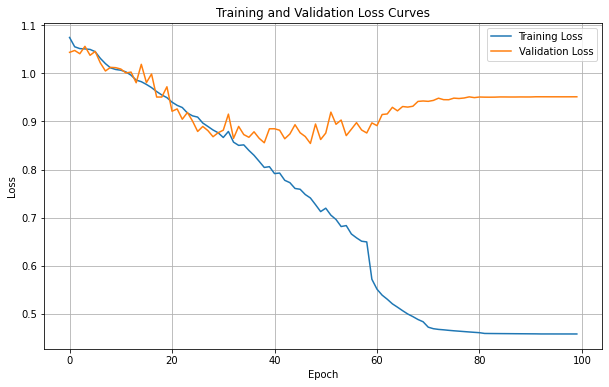

In [14]:
plt.figure(figsize=(10, 6))
plt.plot(train_loss_list, label='Training Loss')
plt.plot(val_loss_list, label='Validation Loss')
plt.title("Training and Validation Loss Curves")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()

In [15]:
test_dice = []
test_jaccard = []
model = UNet(in_channels=1, out_channels=1)
checkpoint = torch.load("UNetFinalNoCMMD", map_location=device)
model.load_state_dict(checkpoint["model_state_dict"])
model.to(device)
model.eval()
with torch.no_grad():
    for images, masks in test_loader:
        images = images.to(device)
        masks = masks.to(device)
        outputs = model(images)
        preds = (torch.sigmoid(outputs) > 0.5).float()
        preds_flat = preds.view(-1)
        masks_flat = masks.view(-1)
        intersection = (preds_flat * masks_flat).sum()
        union = (preds_flat + masks_flat).sum() - intersection
        jaccard = intersection / (union + 1e-10)
        dice = (2. * intersection) / (preds_flat.sum() + masks_flat.sum() + 1e-10)
        test_dice.append(dice.item())
        test_jaccard.append(jaccard.item())
print(f"Mean Dice Score: {sum(test_dice)/len(test_dice):.4f}")
print(f"Mean Jaccard Score: {sum(test_jaccard)/len(test_jaccard):.4f}")


Mean Dice Score: 0.2658
Mean Jaccard Score: 0.1794


In [30]:
# Test with CMMD Dataset
test_dice = []
test_jaccard = []
model = UNet(in_channels=1, out_channels=1)
checkpoint = torch.load("UNetFinalNoCMMD", map_location=device)
model.load_state_dict(checkpoint["model_state_dict"])
model.to(device)
model.eval()
with torch.no_grad():
    for images, masks in test_loader:
        images = images.to(device)
        masks = masks.to(device)
        outputs = model(images)
        preds = (torch.sigmoid(outputs) > 0.5).float()
        preds_flat = preds.view(-1)
        masks_flat = masks.view(-1)
        intersection = (preds_flat * masks_flat).sum()
        union = (preds_flat + masks_flat).sum() - intersection
        jaccard = intersection / (union + 1e-10)
        dice = (2. * intersection) / (preds_flat.sum() + masks_flat.sum() + 1e-10)
        test_dice.append(dice.item())
        test_jaccard.append(jaccard.item())
print(f"Mean Dice Score: {sum(test_dice)/len(test_dice):.4f}")
print(f"Mean Jaccard Score: {sum(test_jaccard)/len(test_jaccard):.4f}")


Mean Dice Score: 0.2777
Mean Jaccard Score: 0.1768


# UNet With only TOMPEI-CMMD

In [17]:
model = UNet(in_channels=1, out_channels=1).to(device)
optimizer = optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=10)
criterion = DiceBCEFocalLoss().to(device)
train(model, train_loader, val_loader, epochs=100, filename="UNetFinalNoDDSM")

Epoch 1 Validation: 100%|██████████████████████████████████████████████████████████████| 47/47 [00:08<00:00,  5.60it/s]


Epoch 1/100 | Train Loss: 0.9583, Dice: 0.2808 | Val Loss: 0.8176, Dice: 0.3517 | Best Val Loss: 0.8176 | LR: 0.0010


Epoch 2 Validation: 100%|██████████████████████████████████████████████████████████████| 47/47 [00:06<00:00,  7.59it/s]


Epoch 2/100 | Train Loss: 0.8576, Dice: 0.2950 | Val Loss: 0.8164, Dice: 0.3410 | Best Val Loss: 0.8164 | LR: 0.0010


Epoch 3 Validation: 100%|██████████████████████████████████████████████████████████████| 47/47 [00:05<00:00,  7.86it/s]


Epoch 3/100 | Train Loss: 0.8035, Dice: 0.3529 | Val Loss: 0.8181, Dice: 0.3251 | Best Val Loss: 0.8164 | LR: 0.0010


Epoch 4 Validation: 100%|██████████████████████████████████████████████████████████████| 47/47 [00:05<00:00,  7.86it/s]


Epoch 4/100 | Train Loss: 0.7845, Dice: 0.3716 | Val Loss: 0.7662, Dice: 0.4000 | Best Val Loss: 0.7662 | LR: 0.0010


Epoch 5 Validation: 100%|██████████████████████████████████████████████████████████████| 47/47 [00:06<00:00,  7.78it/s]


Epoch 5/100 | Train Loss: 0.6872, Dice: 0.4544 | Val Loss: 0.6860, Dice: 0.4695 | Best Val Loss: 0.6860 | LR: 0.0010


Epoch 6 Validation: 100%|██████████████████████████████████████████████████████████████| 47/47 [00:06<00:00,  7.82it/s]


Epoch 6/100 | Train Loss: 0.6543, Dice: 0.4803 | Val Loss: 0.6721, Dice: 0.4795 | Best Val Loss: 0.6721 | LR: 0.0010


Epoch 7 Validation: 100%|██████████████████████████████████████████████████████████████| 47/47 [00:05<00:00,  7.84it/s]


Epoch 7/100 | Train Loss: 0.6126, Dice: 0.5162 | Val Loss: 0.6808, Dice: 0.4742 | Best Val Loss: 0.6721 | LR: 0.0010


Epoch 8 Validation: 100%|██████████████████████████████████████████████████████████████| 47/47 [00:06<00:00,  7.70it/s]


Epoch 8/100 | Train Loss: 0.6044, Dice: 0.5240 | Val Loss: 0.6604, Dice: 0.4921 | Best Val Loss: 0.6604 | LR: 0.0010


Epoch 9 Validation: 100%|██████████████████████████████████████████████████████████████| 47/47 [00:05<00:00,  7.91it/s]


Epoch 9/100 | Train Loss: 0.5912, Dice: 0.5326 | Val Loss: 0.6530, Dice: 0.4991 | Best Val Loss: 0.6530 | LR: 0.0010


Epoch 10 Validation: 100%|█████████████████████████████████████████████████████████████| 47/47 [00:06<00:00,  7.67it/s]


Epoch 10/100 | Train Loss: 0.5976, Dice: 0.5279 | Val Loss: 0.6301, Dice: 0.5201 | Best Val Loss: 0.6301 | LR: 0.0010


Epoch 11 Validation: 100%|█████████████████████████████████████████████████████████████| 47/47 [00:05<00:00,  7.93it/s]


Epoch 11/100 | Train Loss: 0.5864, Dice: 0.5405 | Val Loss: 0.6458, Dice: 0.5079 | Best Val Loss: 0.6301 | LR: 0.0010


Epoch 12 Validation: 100%|█████████████████████████████████████████████████████████████| 47/47 [00:05<00:00,  7.86it/s]


Epoch 12/100 | Train Loss: 0.5658, Dice: 0.5562 | Val Loss: 0.6372, Dice: 0.5083 | Best Val Loss: 0.6301 | LR: 0.0010


Epoch 13 Validation: 100%|█████████████████████████████████████████████████████████████| 47/47 [00:06<00:00,  7.82it/s]


Epoch 13/100 | Train Loss: 0.5712, Dice: 0.5487 | Val Loss: 0.7140, Dice: 0.4570 | Best Val Loss: 0.6301 | LR: 0.0010


Epoch 14 Validation: 100%|█████████████████████████████████████████████████████████████| 47/47 [00:05<00:00,  7.87it/s]


Epoch 14/100 | Train Loss: 0.5600, Dice: 0.5541 | Val Loss: 0.6243, Dice: 0.5277 | Best Val Loss: 0.6243 | LR: 0.0010


Epoch 15 Validation: 100%|█████████████████████████████████████████████████████████████| 47/47 [00:06<00:00,  7.63it/s]


Epoch 15/100 | Train Loss: 0.5520, Dice: 0.5641 | Val Loss: 0.6302, Dice: 0.5107 | Best Val Loss: 0.6243 | LR: 0.0010


Epoch 16 Validation: 100%|█████████████████████████████████████████████████████████████| 47/47 [00:07<00:00,  6.25it/s]


Epoch 16/100 | Train Loss: 0.5436, Dice: 0.5706 | Val Loss: 0.6885, Dice: 0.4652 | Best Val Loss: 0.6243 | LR: 0.0010


Epoch 17 Validation: 100%|█████████████████████████████████████████████████████████████| 47/47 [00:05<00:00,  7.84it/s]


Epoch 17/100 | Train Loss: 0.5472, Dice: 0.5649 | Val Loss: 0.6143, Dice: 0.5329 | Best Val Loss: 0.6143 | LR: 0.0010


Epoch 18 Validation: 100%|█████████████████████████████████████████████████████████████| 47/47 [00:05<00:00,  7.84it/s]


Epoch 18/100 | Train Loss: 0.5445, Dice: 0.5669 | Val Loss: 0.6244, Dice: 0.5121 | Best Val Loss: 0.6143 | LR: 0.0010


Epoch 19 Validation: 100%|█████████████████████████████████████████████████████████████| 47/47 [00:05<00:00,  7.96it/s]


Epoch 19/100 | Train Loss: 0.5327, Dice: 0.5741 | Val Loss: 0.6648, Dice: 0.4794 | Best Val Loss: 0.6143 | LR: 0.0010


Epoch 20 Validation: 100%|█████████████████████████████████████████████████████████████| 47/47 [00:05<00:00,  7.92it/s]


Epoch 20/100 | Train Loss: 0.5229, Dice: 0.5842 | Val Loss: 0.6542, Dice: 0.4999 | Best Val Loss: 0.6143 | LR: 0.0010


Epoch 21 Validation: 100%|█████████████████████████████████████████████████████████████| 47/47 [00:05<00:00,  7.91it/s]


Epoch 21/100 | Train Loss: 0.5335, Dice: 0.5750 | Val Loss: 0.6430, Dice: 0.5159 | Best Val Loss: 0.6143 | LR: 0.0010


Epoch 22 Validation: 100%|█████████████████████████████████████████████████████████████| 47/47 [00:06<00:00,  7.76it/s]


Epoch 22/100 | Train Loss: 0.5046, Dice: 0.5982 | Val Loss: 0.6630, Dice: 0.4851 | Best Val Loss: 0.6143 | LR: 0.0010


Epoch 23 Validation: 100%|█████████████████████████████████████████████████████████████| 47/47 [00:05<00:00,  7.86it/s]


Epoch 23/100 | Train Loss: 0.4999, Dice: 0.6034 | Val Loss: 0.6640, Dice: 0.4996 | Best Val Loss: 0.6143 | LR: 0.0010


Epoch 24 Validation: 100%|█████████████████████████████████████████████████████████████| 47/47 [00:06<00:00,  7.80it/s]


Epoch 24/100 | Train Loss: 0.5162, Dice: 0.5907 | Val Loss: 0.6135, Dice: 0.5211 | Best Val Loss: 0.6135 | LR: 0.0010


Epoch 25 Validation: 100%|█████████████████████████████████████████████████████████████| 47/47 [00:05<00:00,  7.90it/s]


Epoch 25/100 | Train Loss: 0.4931, Dice: 0.6086 | Val Loss: 0.6891, Dice: 0.4887 | Best Val Loss: 0.6135 | LR: 0.0010


Epoch 26 Validation: 100%|█████████████████████████████████████████████████████████████| 47/47 [00:06<00:00,  7.57it/s]


Epoch 26/100 | Train Loss: 0.4963, Dice: 0.6057 | Val Loss: 0.6747, Dice: 0.4691 | Best Val Loss: 0.6135 | LR: 0.0010


Epoch 27 Validation: 100%|█████████████████████████████████████████████████████████████| 47/47 [00:05<00:00,  7.90it/s]


Epoch 27/100 | Train Loss: 0.4865, Dice: 0.6110 | Val Loss: 0.6223, Dice: 0.5250 | Best Val Loss: 0.6135 | LR: 0.0010


Epoch 28 Validation: 100%|█████████████████████████████████████████████████████████████| 47/47 [00:06<00:00,  7.44it/s]


Epoch 28/100 | Train Loss: 0.4714, Dice: 0.6245 | Val Loss: 0.6174, Dice: 0.5147 | Best Val Loss: 0.6135 | LR: 0.0010


Epoch 29 Validation: 100%|█████████████████████████████████████████████████████████████| 47/47 [00:06<00:00,  7.69it/s]


Epoch 29/100 | Train Loss: 0.4326, Dice: 0.6549 | Val Loss: 0.6075, Dice: 0.5249 | Best Val Loss: 0.6075 | LR: 0.0001


Epoch 30 Validation: 100%|█████████████████████████████████████████████████████████████| 47/47 [00:05<00:00,  7.87it/s]


Epoch 30/100 | Train Loss: 0.4199, Dice: 0.6657 | Val Loss: 0.6207, Dice: 0.5113 | Best Val Loss: 0.6075 | LR: 0.0001


Epoch 31 Validation: 100%|█████████████████████████████████████████████████████████████| 47/47 [00:06<00:00,  7.24it/s]


Epoch 31/100 | Train Loss: 0.4108, Dice: 0.6743 | Val Loss: 0.6061, Dice: 0.5235 | Best Val Loss: 0.6061 | LR: 0.0001


Epoch 32 Validation: 100%|█████████████████████████████████████████████████████████████| 47/47 [00:06<00:00,  7.81it/s]


Epoch 32/100 | Train Loss: 0.4078, Dice: 0.6753 | Val Loss: 0.6003, Dice: 0.5288 | Best Val Loss: 0.6003 | LR: 0.0001


Epoch 33 Validation: 100%|█████████████████████████████████████████████████████████████| 47/47 [00:05<00:00,  7.94it/s]


Epoch 33/100 | Train Loss: 0.4027, Dice: 0.6810 | Val Loss: 0.6144, Dice: 0.5159 | Best Val Loss: 0.6003 | LR: 0.0001


Epoch 34 Validation: 100%|█████████████████████████████████████████████████████████████| 47/47 [00:05<00:00,  7.87it/s]


Epoch 34/100 | Train Loss: 0.3977, Dice: 0.6852 | Val Loss: 0.6290, Dice: 0.5070 | Best Val Loss: 0.6003 | LR: 0.0001


Epoch 35 Validation: 100%|█████████████████████████████████████████████████████████████| 47/47 [00:05<00:00,  7.84it/s]


Epoch 35/100 | Train Loss: 0.3956, Dice: 0.6864 | Val Loss: 0.6236, Dice: 0.5116 | Best Val Loss: 0.6003 | LR: 0.0001


Epoch 36 Validation: 100%|█████████████████████████████████████████████████████████████| 47/47 [00:06<00:00,  7.70it/s]


Epoch 36/100 | Train Loss: 0.3949, Dice: 0.6858 | Val Loss: 0.6094, Dice: 0.5212 | Best Val Loss: 0.6003 | LR: 0.0001


Epoch 37 Validation: 100%|█████████████████████████████████████████████████████████████| 47/47 [00:05<00:00,  7.91it/s]


Epoch 37/100 | Train Loss: 0.3899, Dice: 0.6889 | Val Loss: 0.6282, Dice: 0.5095 | Best Val Loss: 0.6003 | LR: 0.0001


Epoch 38 Validation: 100%|█████████████████████████████████████████████████████████████| 47/47 [00:05<00:00,  7.86it/s]


Epoch 38/100 | Train Loss: 0.3885, Dice: 0.6923 | Val Loss: 0.6060, Dice: 0.5263 | Best Val Loss: 0.6003 | LR: 0.0001


Epoch 39 Validation: 100%|█████████████████████████████████████████████████████████████| 47/47 [00:07<00:00,  6.47it/s]


Epoch 39/100 | Train Loss: 0.3846, Dice: 0.6932 | Val Loss: 0.6164, Dice: 0.5201 | Best Val Loss: 0.6003 | LR: 0.0001


Epoch 40 Validation: 100%|█████████████████████████████████████████████████████████████| 47/47 [00:06<00:00,  7.74it/s]


Epoch 40/100 | Train Loss: 0.3777, Dice: 0.7005 | Val Loss: 0.6091, Dice: 0.5240 | Best Val Loss: 0.6003 | LR: 0.0000


Epoch 41 Validation: 100%|█████████████████████████████████████████████████████████████| 47/47 [00:06<00:00,  7.76it/s]


Epoch 41/100 | Train Loss: 0.3754, Dice: 0.7029 | Val Loss: 0.6113, Dice: 0.5214 | Best Val Loss: 0.6003 | LR: 0.0000


Epoch 42 Validation: 100%|█████████████████████████████████████████████████████████████| 47/47 [00:06<00:00,  7.54it/s]


Epoch 42/100 | Train Loss: 0.3744, Dice: 0.7040 | Val Loss: 0.6112, Dice: 0.5218 | Best Val Loss: 0.6003 | LR: 0.0000


Epoch 43 Validation: 100%|█████████████████████████████████████████████████████████████| 47/47 [00:06<00:00,  7.83it/s]


Epoch 43/100 | Train Loss: 0.3739, Dice: 0.7045 | Val Loss: 0.6111, Dice: 0.5214 | Best Val Loss: 0.6003 | LR: 0.0000


Epoch 44 Validation: 100%|█████████████████████████████████████████████████████████████| 47/47 [00:06<00:00,  7.34it/s]


Epoch 44/100 | Train Loss: 0.3732, Dice: 0.7048 | Val Loss: 0.6108, Dice: 0.5219 | Best Val Loss: 0.6003 | LR: 0.0000


Epoch 45 Validation: 100%|█████████████████████████████████████████████████████████████| 47/47 [00:06<00:00,  7.27it/s]


Epoch 45/100 | Train Loss: 0.3731, Dice: 0.7051 | Val Loss: 0.6118, Dice: 0.5206 | Best Val Loss: 0.6003 | LR: 0.0000


Epoch 46 Validation: 100%|█████████████████████████████████████████████████████████████| 47/47 [00:05<00:00,  7.86it/s]


Epoch 46/100 | Train Loss: 0.3725, Dice: 0.7055 | Val Loss: 0.6119, Dice: 0.5208 | Best Val Loss: 0.6003 | LR: 0.0000


Epoch 47 Validation: 100%|█████████████████████████████████████████████████████████████| 47/47 [00:06<00:00,  7.14it/s]


Epoch 47/100 | Train Loss: 0.3723, Dice: 0.7055 | Val Loss: 0.6127, Dice: 0.5203 | Best Val Loss: 0.6003 | LR: 0.0000


Epoch 48 Validation: 100%|█████████████████████████████████████████████████████████████| 47/47 [00:05<00:00,  7.85it/s]


Epoch 48/100 | Train Loss: 0.3718, Dice: 0.7063 | Val Loss: 0.6121, Dice: 0.5209 | Best Val Loss: 0.6003 | LR: 0.0000


Epoch 49 Validation: 100%|█████████████████████████████████████████████████████████████| 47/47 [00:05<00:00,  7.89it/s]


Epoch 49/100 | Train Loss: 0.3713, Dice: 0.7057 | Val Loss: 0.6103, Dice: 0.5224 | Best Val Loss: 0.6003 | LR: 0.0000


Epoch 50 Validation: 100%|█████████████████████████████████████████████████████████████| 47/47 [00:05<00:00,  7.91it/s]


Epoch 50/100 | Train Loss: 0.3711, Dice: 0.7066 | Val Loss: 0.6138, Dice: 0.5195 | Best Val Loss: 0.6003 | LR: 0.0000


Epoch 51 Validation: 100%|█████████████████████████████████████████████████████████████| 47/47 [00:05<00:00,  7.90it/s]


Epoch 51/100 | Train Loss: 0.3704, Dice: 0.7068 | Val Loss: 0.6133, Dice: 0.5198 | Best Val Loss: 0.6003 | LR: 0.0000


Epoch 52 Validation: 100%|█████████████████████████████████████████████████████████████| 47/47 [00:06<00:00,  7.63it/s]


Epoch 52/100 | Train Loss: 0.3702, Dice: 0.7071 | Val Loss: 0.6130, Dice: 0.5200 | Best Val Loss: 0.6003 | LR: 0.0000


Epoch 53 Validation: 100%|█████████████████████████████████████████████████████████████| 47/47 [00:05<00:00,  7.86it/s]


Epoch 53/100 | Train Loss: 0.3701, Dice: 0.7073 | Val Loss: 0.6128, Dice: 0.5203 | Best Val Loss: 0.6003 | LR: 0.0000


Epoch 54 Validation: 100%|█████████████████████████████████████████████████████████████| 47/47 [00:05<00:00,  7.88it/s]


Epoch 54/100 | Train Loss: 0.3700, Dice: 0.7073 | Val Loss: 0.6125, Dice: 0.5206 | Best Val Loss: 0.6003 | LR: 0.0000


Epoch 55 Validation: 100%|█████████████████████████████████████████████████████████████| 47/47 [00:05<00:00,  7.88it/s]


Epoch 55/100 | Train Loss: 0.3699, Dice: 0.7075 | Val Loss: 0.6124, Dice: 0.5206 | Best Val Loss: 0.6003 | LR: 0.0000


Epoch 56 Validation: 100%|█████████████████████████████████████████████████████████████| 47/47 [00:05<00:00,  7.88it/s]


Epoch 56/100 | Train Loss: 0.3699, Dice: 0.7074 | Val Loss: 0.6123, Dice: 0.5209 | Best Val Loss: 0.6003 | LR: 0.0000


Epoch 57 Validation: 100%|█████████████████████████████████████████████████████████████| 47/47 [00:05<00:00,  7.92it/s]


Epoch 57/100 | Train Loss: 0.3699, Dice: 0.7077 | Val Loss: 0.6122, Dice: 0.5210 | Best Val Loss: 0.6003 | LR: 0.0000


Epoch 58 Validation: 100%|█████████████████████████████████████████████████████████████| 47/47 [00:05<00:00,  7.95it/s]


Epoch 58/100 | Train Loss: 0.3698, Dice: 0.7075 | Val Loss: 0.6121, Dice: 0.5210 | Best Val Loss: 0.6003 | LR: 0.0000


Epoch 59 Validation: 100%|█████████████████████████████████████████████████████████████| 47/47 [00:05<00:00,  7.91it/s]


Epoch 59/100 | Train Loss: 0.3698, Dice: 0.7076 | Val Loss: 0.6121, Dice: 0.5210 | Best Val Loss: 0.6003 | LR: 0.0000


Epoch 60 Validation: 100%|█████████████████████████████████████████████████████████████| 47/47 [00:05<00:00,  7.85it/s]


Epoch 60/100 | Train Loss: 0.3698, Dice: 0.7077 | Val Loss: 0.6120, Dice: 0.5211 | Best Val Loss: 0.6003 | LR: 0.0000


Epoch 61 Validation: 100%|█████████████████████████████████████████████████████████████| 47/47 [00:05<00:00,  7.94it/s]


Epoch 61/100 | Train Loss: 0.3697, Dice: 0.7077 | Val Loss: 0.6121, Dice: 0.5210 | Best Val Loss: 0.6003 | LR: 0.0000


Epoch 62 Validation: 100%|█████████████████████████████████████████████████████████████| 47/47 [00:05<00:00,  7.93it/s]


Epoch 62/100 | Train Loss: 0.3696, Dice: 0.7079 | Val Loss: 0.6120, Dice: 0.5210 | Best Val Loss: 0.6003 | LR: 0.0000


Epoch 63 Validation: 100%|█████████████████████████████████████████████████████████████| 47/47 [00:05<00:00,  7.90it/s]


Epoch 63/100 | Train Loss: 0.3696, Dice: 0.7079 | Val Loss: 0.6121, Dice: 0.5210 | Best Val Loss: 0.6003 | LR: 0.0000


Epoch 64 Validation: 100%|█████████████████████████████████████████████████████████████| 47/47 [00:05<00:00,  7.94it/s]


Epoch 64/100 | Train Loss: 0.3696, Dice: 0.7079 | Val Loss: 0.6121, Dice: 0.5210 | Best Val Loss: 0.6003 | LR: 0.0000


Epoch 65 Validation: 100%|█████████████████████████████████████████████████████████████| 47/47 [00:05<00:00,  7.87it/s]


Epoch 65/100 | Train Loss: 0.3696, Dice: 0.7079 | Val Loss: 0.6120, Dice: 0.5211 | Best Val Loss: 0.6003 | LR: 0.0000


Epoch 66 Validation: 100%|█████████████████████████████████████████████████████████████| 47/47 [00:05<00:00,  7.94it/s]


Epoch 66/100 | Train Loss: 0.3696, Dice: 0.7079 | Val Loss: 0.6120, Dice: 0.5210 | Best Val Loss: 0.6003 | LR: 0.0000


Epoch 67 Validation: 100%|█████████████████████████████████████████████████████████████| 47/47 [00:05<00:00,  7.89it/s]


Epoch 67/100 | Train Loss: 0.3696, Dice: 0.7079 | Val Loss: 0.6120, Dice: 0.5211 | Best Val Loss: 0.6003 | LR: 0.0000


Epoch 68 Validation: 100%|█████████████████████████████████████████████████████████████| 47/47 [00:05<00:00,  7.90it/s]


Epoch 68/100 | Train Loss: 0.3696, Dice: 0.7079 | Val Loss: 0.6120, Dice: 0.5211 | Best Val Loss: 0.6003 | LR: 0.0000


Epoch 69 Validation: 100%|█████████████████████████████████████████████████████████████| 47/47 [00:05<00:00,  7.99it/s]


Epoch 69/100 | Train Loss: 0.3696, Dice: 0.7079 | Val Loss: 0.6120, Dice: 0.5210 | Best Val Loss: 0.6003 | LR: 0.0000


Epoch 70 Validation: 100%|█████████████████████████████████████████████████████████████| 47/47 [00:05<00:00,  7.95it/s]


Epoch 70/100 | Train Loss: 0.3696, Dice: 0.7079 | Val Loss: 0.6120, Dice: 0.5210 | Best Val Loss: 0.6003 | LR: 0.0000


Epoch 71 Validation: 100%|█████████████████████████████████████████████████████████████| 47/47 [00:05<00:00,  7.95it/s]


Epoch 71/100 | Train Loss: 0.3696, Dice: 0.7079 | Val Loss: 0.6120, Dice: 0.5210 | Best Val Loss: 0.6003 | LR: 0.0000


Epoch 72 Validation: 100%|█████████████████████████████████████████████████████████████| 47/47 [00:05<00:00,  7.93it/s]


Epoch 72/100 | Train Loss: 0.3696, Dice: 0.7079 | Val Loss: 0.6120, Dice: 0.5211 | Best Val Loss: 0.6003 | LR: 0.0000


Epoch 73 Validation: 100%|█████████████████████████████████████████████████████████████| 47/47 [00:06<00:00,  7.81it/s]


Epoch 73/100 | Train Loss: 0.3695, Dice: 0.7079 | Val Loss: 0.6120, Dice: 0.5211 | Best Val Loss: 0.6003 | LR: 0.0000


Epoch 74 Validation: 100%|█████████████████████████████████████████████████████████████| 47/47 [00:05<00:00,  7.88it/s]


Epoch 74/100 | Train Loss: 0.3695, Dice: 0.7079 | Val Loss: 0.6120, Dice: 0.5211 | Best Val Loss: 0.6003 | LR: 0.0000


Epoch 75 Validation: 100%|█████████████████████████████████████████████████████████████| 47/47 [00:05<00:00,  7.92it/s]


Epoch 75/100 | Train Loss: 0.3695, Dice: 0.7079 | Val Loss: 0.6120, Dice: 0.5211 | Best Val Loss: 0.6003 | LR: 0.0000


Epoch 76 Validation: 100%|█████████████████████████████████████████████████████████████| 47/47 [00:05<00:00,  7.92it/s]


Epoch 76/100 | Train Loss: 0.3695, Dice: 0.7079 | Val Loss: 0.6120, Dice: 0.5211 | Best Val Loss: 0.6003 | LR: 0.0000


Epoch 77 Validation: 100%|█████████████████████████████████████████████████████████████| 47/47 [00:05<00:00,  7.88it/s]


Epoch 77/100 | Train Loss: 0.3695, Dice: 0.7079 | Val Loss: 0.6120, Dice: 0.5211 | Best Val Loss: 0.6003 | LR: 0.0000


Epoch 78 Validation: 100%|█████████████████████████████████████████████████████████████| 47/47 [00:05<00:00,  7.93it/s]


Epoch 78/100 | Train Loss: 0.3695, Dice: 0.7079 | Val Loss: 0.6120, Dice: 0.5211 | Best Val Loss: 0.6003 | LR: 0.0000


Epoch 79 Validation: 100%|█████████████████████████████████████████████████████████████| 47/47 [00:05<00:00,  7.90it/s]


Epoch 79/100 | Train Loss: 0.3695, Dice: 0.7079 | Val Loss: 0.6120, Dice: 0.5211 | Best Val Loss: 0.6003 | LR: 0.0000


Epoch 80 Validation: 100%|█████████████████████████████████████████████████████████████| 47/47 [00:05<00:00,  7.94it/s]


Epoch 80/100 | Train Loss: 0.3695, Dice: 0.7079 | Val Loss: 0.6120, Dice: 0.5211 | Best Val Loss: 0.6003 | LR: 0.0000


Epoch 81 Validation: 100%|█████████████████████████████████████████████████████████████| 47/47 [00:05<00:00,  7.90it/s]


Epoch 81/100 | Train Loss: 0.3695, Dice: 0.7079 | Val Loss: 0.6120, Dice: 0.5210 | Best Val Loss: 0.6003 | LR: 0.0000


Epoch 82 Validation: 100%|█████████████████████████████████████████████████████████████| 47/47 [00:07<00:00,  6.68it/s]


Epoch 82/100 | Train Loss: 0.3695, Dice: 0.7079 | Val Loss: 0.6120, Dice: 0.5210 | Best Val Loss: 0.6003 | LR: 0.0000


Epoch 83 Validation: 100%|█████████████████████████████████████████████████████████████| 47/47 [00:05<00:00,  7.88it/s]


Epoch 83/100 | Train Loss: 0.3695, Dice: 0.7079 | Val Loss: 0.6120, Dice: 0.5210 | Best Val Loss: 0.6003 | LR: 0.0000


Epoch 84 Validation: 100%|█████████████████████████████████████████████████████████████| 47/47 [00:05<00:00,  7.86it/s]


Epoch 84/100 | Train Loss: 0.3695, Dice: 0.7079 | Val Loss: 0.6120, Dice: 0.5210 | Best Val Loss: 0.6003 | LR: 0.0000


Epoch 85 Validation: 100%|█████████████████████████████████████████████████████████████| 47/47 [00:05<00:00,  7.86it/s]


Epoch 85/100 | Train Loss: 0.3695, Dice: 0.7079 | Val Loss: 0.6120, Dice: 0.5210 | Best Val Loss: 0.6003 | LR: 0.0000


Epoch 86 Validation: 100%|█████████████████████████████████████████████████████████████| 47/47 [00:05<00:00,  7.92it/s]


Epoch 86/100 | Train Loss: 0.3695, Dice: 0.7079 | Val Loss: 0.6120, Dice: 0.5210 | Best Val Loss: 0.6003 | LR: 0.0000


Epoch 87 Validation: 100%|█████████████████████████████████████████████████████████████| 47/47 [00:05<00:00,  7.89it/s]


Epoch 87/100 | Train Loss: 0.3695, Dice: 0.7079 | Val Loss: 0.6120, Dice: 0.5210 | Best Val Loss: 0.6003 | LR: 0.0000


Epoch 88 Validation: 100%|█████████████████████████████████████████████████████████████| 47/47 [00:05<00:00,  7.90it/s]


Epoch 88/100 | Train Loss: 0.3695, Dice: 0.7079 | Val Loss: 0.6120, Dice: 0.5210 | Best Val Loss: 0.6003 | LR: 0.0000


Epoch 89 Validation: 100%|█████████████████████████████████████████████████████████████| 47/47 [00:05<00:00,  7.85it/s]


Epoch 89/100 | Train Loss: 0.3695, Dice: 0.7079 | Val Loss: 0.6120, Dice: 0.5210 | Best Val Loss: 0.6003 | LR: 0.0000


Epoch 90 Validation: 100%|█████████████████████████████████████████████████████████████| 47/47 [00:05<00:00,  7.87it/s]


Epoch 90/100 | Train Loss: 0.3695, Dice: 0.7079 | Val Loss: 0.6120, Dice: 0.5210 | Best Val Loss: 0.6003 | LR: 0.0000


Epoch 91 Validation: 100%|█████████████████████████████████████████████████████████████| 47/47 [00:05<00:00,  7.89it/s]


Epoch 91/100 | Train Loss: 0.3695, Dice: 0.7079 | Val Loss: 0.6120, Dice: 0.5210 | Best Val Loss: 0.6003 | LR: 0.0000


Epoch 92 Validation: 100%|█████████████████████████████████████████████████████████████| 47/47 [00:05<00:00,  7.88it/s]


Epoch 92/100 | Train Loss: 0.3695, Dice: 0.7079 | Val Loss: 0.6120, Dice: 0.5210 | Best Val Loss: 0.6003 | LR: 0.0000


Epoch 93 Validation: 100%|█████████████████████████████████████████████████████████████| 47/47 [00:05<00:00,  7.84it/s]


Epoch 93/100 | Train Loss: 0.3695, Dice: 0.7079 | Val Loss: 0.6120, Dice: 0.5210 | Best Val Loss: 0.6003 | LR: 0.0000


Epoch 94 Validation: 100%|█████████████████████████████████████████████████████████████| 47/47 [00:05<00:00,  7.91it/s]


Epoch 94/100 | Train Loss: 0.3695, Dice: 0.7079 | Val Loss: 0.6120, Dice: 0.5210 | Best Val Loss: 0.6003 | LR: 0.0000


Epoch 95 Validation: 100%|█████████████████████████████████████████████████████████████| 47/47 [00:05<00:00,  7.87it/s]


Epoch 95/100 | Train Loss: 0.3695, Dice: 0.7079 | Val Loss: 0.6120, Dice: 0.5210 | Best Val Loss: 0.6003 | LR: 0.0000


Epoch 96 Validation: 100%|█████████████████████████████████████████████████████████████| 47/47 [00:05<00:00,  7.90it/s]


Epoch 96/100 | Train Loss: 0.3695, Dice: 0.7079 | Val Loss: 0.6120, Dice: 0.5210 | Best Val Loss: 0.6003 | LR: 0.0000


Epoch 97 Validation: 100%|█████████████████████████████████████████████████████████████| 47/47 [00:05<00:00,  7.91it/s]


Epoch 97/100 | Train Loss: 0.3695, Dice: 0.7079 | Val Loss: 0.6120, Dice: 0.5210 | Best Val Loss: 0.6003 | LR: 0.0000


Epoch 98 Validation: 100%|█████████████████████████████████████████████████████████████| 47/47 [00:05<00:00,  7.89it/s]


Epoch 98/100 | Train Loss: 0.3695, Dice: 0.7079 | Val Loss: 0.6120, Dice: 0.5210 | Best Val Loss: 0.6003 | LR: 0.0000


Epoch 99 Validation: 100%|█████████████████████████████████████████████████████████████| 47/47 [00:05<00:00,  7.88it/s]


Epoch 99/100 | Train Loss: 0.3695, Dice: 0.7079 | Val Loss: 0.6120, Dice: 0.5210 | Best Val Loss: 0.6003 | LR: 0.0000


Epoch 100 Validation: 100%|████████████████████████████████████████████████████████████| 47/47 [00:05<00:00,  7.87it/s]

Epoch 100/100 | Train Loss: 0.3695, Dice: 0.7079 | Val Loss: 0.6120, Dice: 0.5210 | Best Val Loss: 0.6003 | LR: 0.0000


In [80]:
model = UNet(in_channels=1, out_channels=1).to(device)
optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=10)
criterion = DiceBCEFocalLoss().to(device)
train(model, train_loader, val_loader, epochs=100, filename="UNetFinalNoDDSMtest")

Epoch 1 Validation: 100%|██████████████████████████████████████████████████████████████| 47/47 [00:05<00:00,  8.06it/s]


Epoch 1/100 | Train Loss: 1.0947, Dice: 0.2068 | Val Loss: 1.0344, Dice: 0.2574 | Best Val Loss: 1.0344 | LR: 0.0001


Epoch 2 Validation: 100%|██████████████████████████████████████████████████████████████| 47/47 [00:05<00:00,  8.06it/s]


Epoch 2/100 | Train Loss: 0.9808, Dice: 0.3076 | Val Loss: 0.9458, Dice: 0.3340 | Best Val Loss: 0.9458 | LR: 0.0001


Epoch 3 Validation: 100%|██████████████████████████████████████████████████████████████| 47/47 [00:05<00:00,  8.00it/s]


Epoch 3/100 | Train Loss: 0.9004, Dice: 0.3507 | Val Loss: 0.9140, Dice: 0.3147 | Best Val Loss: 0.9140 | LR: 0.0001


Epoch 4 Validation: 100%|██████████████████████████████████████████████████████████████| 47/47 [00:05<00:00,  7.95it/s]


Epoch 4/100 | Train Loss: 0.8335, Dice: 0.3790 | Val Loss: 0.8118, Dice: 0.3891 | Best Val Loss: 0.8118 | LR: 0.0001


Epoch 5 Validation: 100%|██████████████████████████████████████████████████████████████| 47/47 [00:05<00:00,  7.91it/s]


Epoch 5/100 | Train Loss: 0.7533, Dice: 0.4331 | Val Loss: 0.7883, Dice: 0.3889 | Best Val Loss: 0.7883 | LR: 0.0001


Epoch 6 Validation: 100%|██████████████████████████████████████████████████████████████| 47/47 [00:05<00:00,  8.00it/s]


Epoch 6/100 | Train Loss: 0.7188, Dice: 0.4497 | Val Loss: 0.7693, Dice: 0.4089 | Best Val Loss: 0.7693 | LR: 0.0001


Epoch 7 Validation: 100%|██████████████████████████████████████████████████████████████| 47/47 [00:05<00:00,  8.05it/s]


Epoch 7/100 | Train Loss: 0.6874, Dice: 0.4682 | Val Loss: 0.6765, Dice: 0.4943 | Best Val Loss: 0.6765 | LR: 0.0001


Epoch 8 Validation: 100%|██████████████████████████████████████████████████████████████| 47/47 [00:05<00:00,  8.03it/s]


Epoch 8/100 | Train Loss: 0.6615, Dice: 0.4838 | Val Loss: 0.6525, Dice: 0.5052 | Best Val Loss: 0.6525 | LR: 0.0001


Epoch 9 Validation: 100%|██████████████████████████████████████████████████████████████| 47/47 [00:05<00:00,  8.05it/s]


Epoch 9/100 | Train Loss: 0.6424, Dice: 0.4968 | Val Loss: 0.6600, Dice: 0.4967 | Best Val Loss: 0.6525 | LR: 0.0001


Epoch 10 Validation: 100%|█████████████████████████████████████████████████████████████| 47/47 [00:05<00:00,  8.05it/s]


Epoch 10/100 | Train Loss: 0.6187, Dice: 0.5143 | Val Loss: 0.6341, Dice: 0.5191 | Best Val Loss: 0.6341 | LR: 0.0001


Epoch 11 Validation: 100%|█████████████████████████████████████████████████████████████| 47/47 [00:05<00:00,  8.05it/s]


Epoch 11/100 | Train Loss: 0.6203, Dice: 0.5100 | Val Loss: 0.6332, Dice: 0.5139 | Best Val Loss: 0.6332 | LR: 0.0001


Epoch 12 Validation: 100%|█████████████████████████████████████████████████████████████| 47/47 [00:05<00:00,  8.04it/s]


Epoch 12/100 | Train Loss: 0.5999, Dice: 0.5273 | Val Loss: 0.6076, Dice: 0.5357 | Best Val Loss: 0.6076 | LR: 0.0001


Epoch 13 Validation: 100%|█████████████████████████████████████████████████████████████| 47/47 [00:05<00:00,  8.00it/s]


Epoch 13/100 | Train Loss: 0.5852, Dice: 0.5405 | Val Loss: 0.6240, Dice: 0.5212 | Best Val Loss: 0.6076 | LR: 0.0001


Epoch 14 Validation: 100%|█████████████████████████████████████████████████████████████| 47/47 [00:05<00:00,  8.00it/s]


Epoch 14/100 | Train Loss: 0.5813, Dice: 0.5424 | Val Loss: 0.6469, Dice: 0.5029 | Best Val Loss: 0.6076 | LR: 0.0001


Epoch 15 Validation: 100%|█████████████████████████████████████████████████████████████| 47/47 [00:05<00:00,  8.04it/s]


Epoch 15/100 | Train Loss: 0.5743, Dice: 0.5439 | Val Loss: 0.6043, Dice: 0.5425 | Best Val Loss: 0.6043 | LR: 0.0001


Epoch 16 Validation: 100%|█████████████████████████████████████████████████████████████| 47/47 [00:05<00:00,  8.03it/s]


Epoch 16/100 | Train Loss: 0.5536, Dice: 0.5621 | Val Loss: 0.5958, Dice: 0.5368 | Best Val Loss: 0.5958 | LR: 0.0001


Epoch 17 Validation: 100%|█████████████████████████████████████████████████████████████| 47/47 [00:05<00:00,  8.05it/s]


Epoch 17/100 | Train Loss: 0.5486, Dice: 0.5649 | Val Loss: 0.6221, Dice: 0.5332 | Best Val Loss: 0.5958 | LR: 0.0001


Epoch 18 Validation: 100%|█████████████████████████████████████████████████████████████| 47/47 [00:05<00:00,  8.01it/s]


Epoch 18/100 | Train Loss: 0.5509, Dice: 0.5632 | Val Loss: 0.6060, Dice: 0.5375 | Best Val Loss: 0.5958 | LR: 0.0001


Epoch 19 Validation: 100%|█████████████████████████████████████████████████████████████| 47/47 [00:05<00:00,  7.99it/s]


Epoch 19/100 | Train Loss: 0.5335, Dice: 0.5765 | Val Loss: 0.6093, Dice: 0.5367 | Best Val Loss: 0.5958 | LR: 0.0001


Epoch 20 Validation: 100%|█████████████████████████████████████████████████████████████| 47/47 [00:05<00:00,  8.02it/s]


Epoch 20/100 | Train Loss: 0.5298, Dice: 0.5768 | Val Loss: 0.5958, Dice: 0.5349 | Best Val Loss: 0.5958 | LR: 0.0001


Epoch 21 Validation: 100%|█████████████████████████████████████████████████████████████| 47/47 [00:05<00:00,  8.05it/s]


Epoch 21/100 | Train Loss: 0.5239, Dice: 0.5826 | Val Loss: 0.5948, Dice: 0.5502 | Best Val Loss: 0.5948 | LR: 0.0001


Epoch 22 Validation: 100%|█████████████████████████████████████████████████████████████| 47/47 [00:05<00:00,  7.99it/s]


Epoch 22/100 | Train Loss: 0.5147, Dice: 0.5884 | Val Loss: 0.6061, Dice: 0.5474 | Best Val Loss: 0.5948 | LR: 0.0001


Epoch 23 Validation: 100%|█████████████████████████████████████████████████████████████| 47/47 [00:05<00:00,  7.97it/s]


Epoch 23/100 | Train Loss: 0.5277, Dice: 0.5787 | Val Loss: 0.6006, Dice: 0.5464 | Best Val Loss: 0.5948 | LR: 0.0001


Epoch 24 Validation: 100%|█████████████████████████████████████████████████████████████| 47/47 [00:05<00:00,  8.03it/s]


Epoch 24/100 | Train Loss: 0.5107, Dice: 0.5925 | Val Loss: 0.5670, Dice: 0.5712 | Best Val Loss: 0.5670 | LR: 0.0001


Epoch 25 Validation: 100%|█████████████████████████████████████████████████████████████| 47/47 [00:05<00:00,  8.03it/s]


Epoch 25/100 | Train Loss: 0.5019, Dice: 0.5993 | Val Loss: 0.5742, Dice: 0.5503 | Best Val Loss: 0.5670 | LR: 0.0001


Epoch 26 Validation: 100%|█████████████████████████████████████████████████████████████| 47/47 [00:05<00:00,  8.04it/s]


Epoch 26/100 | Train Loss: 0.4924, Dice: 0.6058 | Val Loss: 0.5540, Dice: 0.5746 | Best Val Loss: 0.5540 | LR: 0.0001


Epoch 27 Validation: 100%|█████████████████████████████████████████████████████████████| 47/47 [00:05<00:00,  8.00it/s]


Epoch 27/100 | Train Loss: 0.4901, Dice: 0.6065 | Val Loss: 0.5836, Dice: 0.5469 | Best Val Loss: 0.5540 | LR: 0.0001


Epoch 28 Validation: 100%|█████████████████████████████████████████████████████████████| 47/47 [00:05<00:00,  8.05it/s]


Epoch 28/100 | Train Loss: 0.4879, Dice: 0.6064 | Val Loss: 0.5524, Dice: 0.5782 | Best Val Loss: 0.5524 | LR: 0.0001


Epoch 29 Validation: 100%|█████████████████████████████████████████████████████████████| 47/47 [00:05<00:00,  8.03it/s]


Epoch 29/100 | Train Loss: 0.4876, Dice: 0.6067 | Val Loss: 0.5628, Dice: 0.5497 | Best Val Loss: 0.5524 | LR: 0.0001


Epoch 30 Validation: 100%|█████████████████████████████████████████████████████████████| 47/47 [00:05<00:00,  7.99it/s]


Epoch 30/100 | Train Loss: 0.4901, Dice: 0.6068 | Val Loss: 0.5717, Dice: 0.5505 | Best Val Loss: 0.5524 | LR: 0.0001


Epoch 31 Validation: 100%|█████████████████████████████████████████████████████████████| 47/47 [00:05<00:00,  8.07it/s]


Epoch 31/100 | Train Loss: 0.4797, Dice: 0.6141 | Val Loss: 0.5552, Dice: 0.5771 | Best Val Loss: 0.5524 | LR: 0.0001


Epoch 32 Validation: 100%|█████████████████████████████████████████████████████████████| 47/47 [00:05<00:00,  8.04it/s]


Epoch 32/100 | Train Loss: 0.4881, Dice: 0.6079 | Val Loss: 0.5778, Dice: 0.5640 | Best Val Loss: 0.5524 | LR: 0.0001


Epoch 33 Validation: 100%|█████████████████████████████████████████████████████████████| 47/47 [00:05<00:00,  8.01it/s]


Epoch 33/100 | Train Loss: 0.4831, Dice: 0.6148 | Val Loss: 0.5793, Dice: 0.5462 | Best Val Loss: 0.5524 | LR: 0.0001


Epoch 34 Validation: 100%|█████████████████████████████████████████████████████████████| 47/47 [00:05<00:00,  8.01it/s]


Epoch 34/100 | Train Loss: 0.4687, Dice: 0.6220 | Val Loss: 0.5825, Dice: 0.5506 | Best Val Loss: 0.5524 | LR: 0.0001


Epoch 35:  79%|███████████████████████████████████████████████████████▌              | 301/379 [01:00<00:15,  4.97it/s]


KeyboardInterrupt: 

In [19]:
test_dice = []
test_jaccard = []
model = UNet(in_channels=1, out_channels=1)
checkpoint = torch.load("UNetFinalNoDDSM", map_location=device)
model.load_state_dict(checkpoint["model_state_dict"])
model.to(device)
model.eval()
with torch.no_grad():
    for images, masks in test_loader:
        images = images.to(device)
        masks = masks.to(device)
        outputs = model(images)
        preds = (torch.sigmoid(outputs) > 0.5).float()
        preds_flat = preds.view(-1)
        masks_flat = masks.view(-1)
        intersection = (preds_flat * masks_flat).sum()
        union = (preds_flat + masks_flat).sum() - intersection
        jaccard = intersection / (union + 1e-10)
        dice = (2. * intersection) / (preds_flat.sum() + masks_flat.sum() + 1e-10)
        test_dice.append(dice.item())
        test_jaccard.append(jaccard.item())
print(f"Mean Dice Score: {sum(test_dice)/len(test_dice):.4f}")
print(f"Mean Jaccard Score: {sum(test_jaccard)/len(test_jaccard):.4f}")


Mean Dice Score: 0.5661
Mean Jaccard Score: 0.4262


In [55]:
test_dice = []
test_jaccard = []
model = UNet(in_channels=1, out_channels=1)
checkpoint = torch.load("UNetFinalNoDDSMtest", map_location=device)
model.load_state_dict(checkpoint["model_state_dict"])
model.to(device)
model.eval()
with torch.no_grad():
    for images, masks in test_loader:
        images = images.to(device)
        masks = masks.to(device)
        outputs = model(images)
        preds = (torch.sigmoid(outputs) > 0.5).float()
        preds_flat = preds.view(-1)
        masks_flat = masks.view(-1)
        intersection = (preds_flat * masks_flat).sum()
        union = (preds_flat + masks_flat).sum() - intersection
        jaccard = intersection / (union + 1e-10)
        dice = (2. * intersection) / (preds_flat.sum() + masks_flat.sum() + 1e-10)
        test_dice.append(dice.item())
        test_jaccard.append(jaccard.item())
print(f"Mean Dice Score: {sum(test_dice)/len(test_dice):.4f}")
print(f"Mean Jaccard Score: {sum(test_jaccard)/len(test_jaccard):.4f}")


Mean Dice Score: 0.5768
Mean Jaccard Score: 0.4422


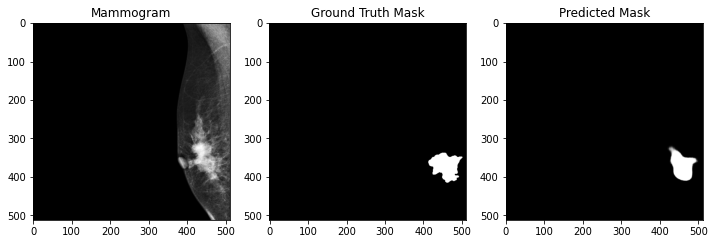

In [95]:
img, mask = get_nth_sample_from_loader(test_loader, 40) 
with torch.no_grad():
    output = model(img.to(device).unsqueeze(0))
    pred = torch.sigmoid(output)

    plt.figure(figsize=(12,4))
    plt.subplot(1,3,1)
    plt.imshow(img.squeeze().cpu(), cmap='gray')
    plt.title('Mammogram')

    plt.subplot(1,3,2)
    plt.imshow(mask.squeeze().cpu(), cmap='gray')
    plt.title('Ground Truth Mask')
    plt.subplot(1,3,3)
    plt.imshow(pred.squeeze().cpu(), cmap='gray')
    plt.title('Predicted Mask')
    plt.show()

In [90]:
for i,d in enumerate(test_dice):
    print(i, d)

0 0.7260110974311829
1 0.5932604670524597
2 0.5463530421257019
3 0.4851212799549103
4 0.3462620973587036
5 0.582770049571991
6 0.17174959182739258
7 0.5916358232498169
8 0.32813990116119385
9 0.4277334213256836
10 0.4099227786064148
11 0.7946118116378784
12 0.09045108407735825
13 0.7239147424697876
14 0.6064408421516418
15 0.6449382901191711
16 0.06892793625593185
17 0.6893810629844666
18 0.738973081111908
19 0.23727387189865112
20 0.5789642930030823
21 0.5275012850761414
22 0.4899694323539734
23 0.4564203917980194
24 0.8141170740127563
25 0.7195467352867126
26 0.7171282768249512
27 0.8038906455039978
28 0.7316421866416931
29 0.6659521460533142
30 0.577505886554718
31 0.47310373187065125
32 0.0
33 0.7244094610214233
34 0.04019554704427719
35 0.7872681617736816
36 0.45930662751197815
37 0.5329670310020447
38 0.5406976938247681
39 0.3470252752304077
40 0.8011422753334045
41 0.38418400287628174
42 0.6671326160430908
43 0.4697279930114746
44 0.05863316357135773
45 0.49018508195877075
46 0.

In [13]:
# Test with DDSM Dataset
test_dice = []
test_jaccard = []
model = UNet(in_channels=1, out_channels=1)
checkpoint = torch.load("UNetFinalNoDDSM", map_location=device)
model.load_state_dict(checkpoint["model_state_dict"])
model.to(device)
model.eval()
with torch.no_grad():
    for images, masks in test_loader:
        images = images.to(device)
        masks = masks.to(device)
        outputs = model(images)
        preds = (torch.sigmoid(outputs) > 0.5).float()
        preds_flat = preds.view(-1)
        masks_flat = masks.view(-1)
        intersection = (preds_flat * masks_flat).sum()
        union = (preds_flat + masks_flat).sum() - intersection
        jaccard = intersection / (union + 1e-10)
        dice = (2. * intersection) / (preds_flat.sum() + masks_flat.sum() + 1e-10)
        test_dice.append(dice.item())
        test_jaccard.append(jaccard.item())
print(f"Mean Dice Score: {sum(test_dice)/len(test_dice):.4f}")
print(f"Mean Jaccard Score: {sum(test_jaccard)/len(test_jaccard):.4f}")

Mean Dice Score: 0.0842
Mean Jaccard Score: 0.0498


# UNet With All CBIS-DDSM + TOMPEI-CMMD

In [119]:
model = UNet(in_channels=1, out_channels=1).to(device)
optimizer = optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=10)
criterion = DiceBCEFocalLoss().to(device)
train(model, train_loader, val_loader, epochs=100, filename="UNetFinal")

Epoch 1 Validation: 100%|████████████████████████████████████████████████████████████| 188/188 [01:23<00:00,  2.24it/s]


Epoch 1/100 | Train Loss: 1.0340, Dice: 0.0511 | Val Loss: 0.9947, Dice: 0.0869 | Best Val Loss: 0.9947 | LR: 0.0010


Epoch 2 Validation: 100%|████████████████████████████████████████████████████████████| 188/188 [01:19<00:00,  2.36it/s]


Epoch 2/100 | Train Loss: 0.9932, Dice: 0.1053 | Val Loss: 0.9826, Dice: 0.0760 | Best Val Loss: 0.9826 | LR: 0.0010


Epoch 3 Validation: 100%|████████████████████████████████████████████████████████████| 188/188 [01:17<00:00,  2.42it/s]


Epoch 3/100 | Train Loss: 0.9759, Dice: 0.1374 | Val Loss: 0.9817, Dice: 0.1248 | Best Val Loss: 0.9817 | LR: 0.0010


Epoch 4 Validation: 100%|████████████████████████████████████████████████████████████| 188/188 [01:20<00:00,  2.35it/s]


Epoch 4/100 | Train Loss: 0.9717, Dice: 0.1406 | Val Loss: 0.9983, Dice: 0.1385 | Best Val Loss: 0.9817 | LR: 0.0010


Epoch 5 Validation: 100%|████████████████████████████████████████████████████████████| 188/188 [01:21<00:00,  2.30it/s]


Epoch 5/100 | Train Loss: 0.9696, Dice: 0.1431 | Val Loss: 0.9805, Dice: 0.1389 | Best Val Loss: 0.9805 | LR: 0.0010


Epoch 6 Validation: 100%|████████████████████████████████████████████████████████████| 188/188 [01:13<00:00,  2.57it/s]


Epoch 6/100 | Train Loss: 0.9673, Dice: 0.1457 | Val Loss: 0.9765, Dice: 0.1235 | Best Val Loss: 0.9765 | LR: 0.0010


Epoch 7 Validation: 100%|████████████████████████████████████████████████████████████| 188/188 [01:12<00:00,  2.59it/s]


Epoch 7/100 | Train Loss: 0.9631, Dice: 0.1533 | Val Loss: 0.9820, Dice: 0.1497 | Best Val Loss: 0.9765 | LR: 0.0010


Epoch 8 Validation: 100%|████████████████████████████████████████████████████████████| 188/188 [01:13<00:00,  2.57it/s]


Epoch 8/100 | Train Loss: 0.9615, Dice: 0.1551 | Val Loss: 0.9695, Dice: 0.1407 | Best Val Loss: 0.9695 | LR: 0.0010


Epoch 9 Validation: 100%|████████████████████████████████████████████████████████████| 188/188 [01:13<00:00,  2.56it/s]


Epoch 9/100 | Train Loss: 0.9555, Dice: 0.1669 | Val Loss: 0.9706, Dice: 0.1498 | Best Val Loss: 0.9695 | LR: 0.0010


Epoch 10 Validation: 100%|███████████████████████████████████████████████████████████| 188/188 [01:12<00:00,  2.59it/s]


Epoch 10/100 | Train Loss: 0.9435, Dice: 0.1839 | Val Loss: 0.9554, Dice: 0.1518 | Best Val Loss: 0.9554 | LR: 0.0010


Epoch 11 Validation: 100%|███████████████████████████████████████████████████████████| 188/188 [01:13<00:00,  2.57it/s]


Epoch 11/100 | Train Loss: 0.9334, Dice: 0.1997 | Val Loss: 0.9511, Dice: 0.1697 | Best Val Loss: 0.9511 | LR: 0.0010


Epoch 12 Validation: 100%|███████████████████████████████████████████████████████████| 188/188 [01:12<00:00,  2.59it/s]


Epoch 12/100 | Train Loss: 0.9249, Dice: 0.2115 | Val Loss: 0.9489, Dice: 0.1772 | Best Val Loss: 0.9489 | LR: 0.0010


Epoch 13 Validation: 100%|███████████████████████████████████████████████████████████| 188/188 [01:13<00:00,  2.56it/s]


Epoch 13/100 | Train Loss: 0.9213, Dice: 0.2174 | Val Loss: 0.9326, Dice: 0.1808 | Best Val Loss: 0.9326 | LR: 0.0010


Epoch 14 Validation: 100%|███████████████████████████████████████████████████████████| 188/188 [01:13<00:00,  2.57it/s]


Epoch 14/100 | Train Loss: 0.9133, Dice: 0.2275 | Val Loss: 0.9210, Dice: 0.2078 | Best Val Loss: 0.9210 | LR: 0.0010


Epoch 15 Validation: 100%|███████████████████████████████████████████████████████████| 188/188 [01:20<00:00,  2.34it/s]


Epoch 15/100 | Train Loss: 0.9048, Dice: 0.2435 | Val Loss: 0.9037, Dice: 0.2359 | Best Val Loss: 0.9037 | LR: 0.0010


Epoch 16 Validation: 100%|███████████████████████████████████████████████████████████| 188/188 [01:16<00:00,  2.47it/s]


Epoch 16/100 | Train Loss: 0.8907, Dice: 0.2614 | Val Loss: 0.8934, Dice: 0.2486 | Best Val Loss: 0.8934 | LR: 0.0010


Epoch 17 Validation: 100%|███████████████████████████████████████████████████████████| 188/188 [01:18<00:00,  2.39it/s]


Epoch 17/100 | Train Loss: 0.8802, Dice: 0.2730 | Val Loss: 0.8814, Dice: 0.2540 | Best Val Loss: 0.8814 | LR: 0.0010


Epoch 18 Validation: 100%|███████████████████████████████████████████████████████████| 188/188 [01:23<00:00,  2.24it/s]


Epoch 18/100 | Train Loss: 0.8750, Dice: 0.2791 | Val Loss: 0.8705, Dice: 0.2625 | Best Val Loss: 0.8705 | LR: 0.0010


Epoch 19 Validation: 100%|███████████████████████████████████████████████████████████| 188/188 [01:28<00:00,  2.13it/s]


Epoch 19/100 | Train Loss: 0.8699, Dice: 0.2824 | Val Loss: 0.9008, Dice: 0.2446 | Best Val Loss: 0.8705 | LR: 0.0010


Epoch 20 Validation: 100%|███████████████████████████████████████████████████████████| 188/188 [01:14<00:00,  2.51it/s]


Epoch 20/100 | Train Loss: 0.8691, Dice: 0.2828 | Val Loss: 0.8609, Dice: 0.2791 | Best Val Loss: 0.8609 | LR: 0.0010


Epoch 21 Validation: 100%|███████████████████████████████████████████████████████████| 188/188 [01:15<00:00,  2.49it/s]


Epoch 21/100 | Train Loss: 0.8577, Dice: 0.2953 | Val Loss: 0.8626, Dice: 0.2780 | Best Val Loss: 0.8609 | LR: 0.0010


Epoch 22 Validation: 100%|███████████████████████████████████████████████████████████| 188/188 [01:16<00:00,  2.47it/s]


Epoch 22/100 | Train Loss: 0.8520, Dice: 0.3006 | Val Loss: 0.8473, Dice: 0.2953 | Best Val Loss: 0.8473 | LR: 0.0010


Epoch 23 Validation: 100%|███████████████████████████████████████████████████████████| 188/188 [01:20<00:00,  2.35it/s]


Epoch 23/100 | Train Loss: 0.8462, Dice: 0.3050 | Val Loss: 0.8477, Dice: 0.2880 | Best Val Loss: 0.8473 | LR: 0.0010


Epoch 24 Validation: 100%|███████████████████████████████████████████████████████████| 188/188 [01:13<00:00,  2.56it/s]


Epoch 24/100 | Train Loss: 0.8412, Dice: 0.3098 | Val Loss: 0.8451, Dice: 0.2979 | Best Val Loss: 0.8451 | LR: 0.0010


Epoch 25 Validation: 100%|███████████████████████████████████████████████████████████| 188/188 [01:28<00:00,  2.12it/s]


Epoch 25/100 | Train Loss: 0.8327, Dice: 0.3181 | Val Loss: 0.8418, Dice: 0.2904 | Best Val Loss: 0.8418 | LR: 0.0010


Epoch 26 Validation: 100%|███████████████████████████████████████████████████████████| 188/188 [01:18<00:00,  2.38it/s]


Epoch 26/100 | Train Loss: 0.8356, Dice: 0.3162 | Val Loss: 0.8253, Dice: 0.3065 | Best Val Loss: 0.8253 | LR: 0.0010


Epoch 27 Validation: 100%|███████████████████████████████████████████████████████████| 188/188 [01:24<00:00,  2.21it/s]


Epoch 27/100 | Train Loss: 0.8243, Dice: 0.3253 | Val Loss: 0.8268, Dice: 0.3046 | Best Val Loss: 0.8253 | LR: 0.0010


Epoch 28 Validation: 100%|███████████████████████████████████████████████████████████| 188/188 [01:26<00:00,  2.17it/s]


Epoch 28/100 | Train Loss: 0.8205, Dice: 0.3286 | Val Loss: 0.8518, Dice: 0.2795 | Best Val Loss: 0.8253 | LR: 0.0010


Epoch 29 Validation: 100%|███████████████████████████████████████████████████████████| 188/188 [01:21<00:00,  2.30it/s]


Epoch 29/100 | Train Loss: 0.8125, Dice: 0.3366 | Val Loss: 0.8428, Dice: 0.2969 | Best Val Loss: 0.8253 | LR: 0.0010


Epoch 30 Validation: 100%|███████████████████████████████████████████████████████████| 188/188 [01:25<00:00,  2.20it/s]


Epoch 30/100 | Train Loss: 0.8081, Dice: 0.3420 | Val Loss: 0.8413, Dice: 0.3037 | Best Val Loss: 0.8253 | LR: 0.0010


Epoch 31 Validation: 100%|███████████████████████████████████████████████████████████| 188/188 [01:14<00:00,  2.51it/s]


Epoch 31/100 | Train Loss: 0.8048, Dice: 0.3421 | Val Loss: 0.8101, Dice: 0.3174 | Best Val Loss: 0.8101 | LR: 0.0010


Epoch 32 Validation: 100%|███████████████████████████████████████████████████████████| 188/188 [01:23<00:00,  2.26it/s]


Epoch 32/100 | Train Loss: 0.7899, Dice: 0.3538 | Val Loss: 0.8260, Dice: 0.2975 | Best Val Loss: 0.8101 | LR: 0.0010


Epoch 33 Validation: 100%|███████████████████████████████████████████████████████████| 188/188 [01:17<00:00,  2.42it/s]


Epoch 33/100 | Train Loss: 0.7882, Dice: 0.3555 | Val Loss: 0.8273, Dice: 0.2987 | Best Val Loss: 0.8101 | LR: 0.0010


Epoch 34 Validation: 100%|███████████████████████████████████████████████████████████| 188/188 [01:13<00:00,  2.57it/s]


Epoch 34/100 | Train Loss: 0.7770, Dice: 0.3631 | Val Loss: 0.8525, Dice: 0.2906 | Best Val Loss: 0.8101 | LR: 0.0010


Epoch 35 Validation: 100%|███████████████████████████████████████████████████████████| 188/188 [01:15<00:00,  2.49it/s]


Epoch 35/100 | Train Loss: 0.7745, Dice: 0.3650 | Val Loss: 0.7936, Dice: 0.3277 | Best Val Loss: 0.7936 | LR: 0.0010


Epoch 36 Validation: 100%|███████████████████████████████████████████████████████████| 188/188 [01:15<00:00,  2.49it/s]


Epoch 36/100 | Train Loss: 0.7728, Dice: 0.3648 | Val Loss: 0.8338, Dice: 0.3029 | Best Val Loss: 0.7936 | LR: 0.0010


Epoch 37 Validation: 100%|███████████████████████████████████████████████████████████| 188/188 [01:15<00:00,  2.48it/s]


Epoch 37/100 | Train Loss: 0.7584, Dice: 0.3767 | Val Loss: 0.8083, Dice: 0.3136 | Best Val Loss: 0.7936 | LR: 0.0010


Epoch 38 Validation: 100%|███████████████████████████████████████████████████████████| 188/188 [01:15<00:00,  2.49it/s]


Epoch 38/100 | Train Loss: 0.7580, Dice: 0.3766 | Val Loss: 0.8080, Dice: 0.3161 | Best Val Loss: 0.7936 | LR: 0.0010


Epoch 39 Validation: 100%|███████████████████████████████████████████████████████████| 188/188 [01:14<00:00,  2.51it/s]


Epoch 39/100 | Train Loss: 0.7533, Dice: 0.3804 | Val Loss: 0.8024, Dice: 0.3266 | Best Val Loss: 0.7936 | LR: 0.0010


Epoch 40 Validation: 100%|███████████████████████████████████████████████████████████| 188/188 [01:12<00:00,  2.61it/s]


Epoch 40/100 | Train Loss: 0.7480, Dice: 0.3843 | Val Loss: 0.7954, Dice: 0.3276 | Best Val Loss: 0.7936 | LR: 0.0010


Epoch 41 Validation: 100%|███████████████████████████████████████████████████████████| 188/188 [01:16<00:00,  2.46it/s]


Epoch 41/100 | Train Loss: 0.7414, Dice: 0.3904 | Val Loss: 0.7734, Dice: 0.3490 | Best Val Loss: 0.7734 | LR: 0.0010


Epoch 42 Validation: 100%|███████████████████████████████████████████████████████████| 188/188 [01:15<00:00,  2.50it/s]


Epoch 42/100 | Train Loss: 0.7260, Dice: 0.4025 | Val Loss: 0.7880, Dice: 0.3391 | Best Val Loss: 0.7734 | LR: 0.0010


Epoch 43 Validation: 100%|███████████████████████████████████████████████████████████| 188/188 [01:13<00:00,  2.55it/s]


Epoch 43/100 | Train Loss: 0.7256, Dice: 0.4041 | Val Loss: 0.8056, Dice: 0.3292 | Best Val Loss: 0.7734 | LR: 0.0010


Epoch 44 Validation: 100%|███████████████████████████████████████████████████████████| 188/188 [01:14<00:00,  2.52it/s]


Epoch 44/100 | Train Loss: 0.7199, Dice: 0.4071 | Val Loss: 0.7783, Dice: 0.3519 | Best Val Loss: 0.7734 | LR: 0.0010


Epoch 45 Validation: 100%|███████████████████████████████████████████████████████████| 188/188 [01:14<00:00,  2.52it/s]


Epoch 45/100 | Train Loss: 0.7152, Dice: 0.4120 | Val Loss: 0.7950, Dice: 0.3341 | Best Val Loss: 0.7734 | LR: 0.0010


Epoch 46 Validation: 100%|███████████████████████████████████████████████████████████| 188/188 [01:15<00:00,  2.50it/s]


Epoch 46/100 | Train Loss: 0.7091, Dice: 0.4187 | Val Loss: 0.7971, Dice: 0.3273 | Best Val Loss: 0.7734 | LR: 0.0010


Epoch 47 Validation: 100%|███████████████████████████████████████████████████████████| 188/188 [01:16<00:00,  2.45it/s]


Epoch 47/100 | Train Loss: 0.7044, Dice: 0.4216 | Val Loss: 0.7923, Dice: 0.3399 | Best Val Loss: 0.7734 | LR: 0.0010


Epoch 48 Validation: 100%|███████████████████████████████████████████████████████████| 188/188 [01:27<00:00,  2.15it/s]


Epoch 48/100 | Train Loss: 0.6889, Dice: 0.4308 | Val Loss: 0.7942, Dice: 0.3427 | Best Val Loss: 0.7734 | LR: 0.0010


Epoch 49 Validation: 100%|███████████████████████████████████████████████████████████| 188/188 [01:28<00:00,  2.12it/s]


Epoch 49/100 | Train Loss: 0.6947, Dice: 0.4271 | Val Loss: 0.7968, Dice: 0.3323 | Best Val Loss: 0.7734 | LR: 0.0010


Epoch 50 Validation: 100%|███████████████████████████████████████████████████████████| 188/188 [01:29<00:00,  2.11it/s]


Epoch 50/100 | Train Loss: 0.6850, Dice: 0.4355 | Val Loss: 0.7982, Dice: 0.3254 | Best Val Loss: 0.7734 | LR: 0.0010


Epoch 51 Validation: 100%|███████████████████████████████████████████████████████████| 188/188 [01:22<00:00,  2.27it/s]


Epoch 51/100 | Train Loss: 0.6749, Dice: 0.4421 | Val Loss: 0.8096, Dice: 0.3182 | Best Val Loss: 0.7734 | LR: 0.0010


Epoch 52 Validation: 100%|███████████████████████████████████████████████████████████| 188/188 [01:15<00:00,  2.49it/s]


Epoch 52/100 | Train Loss: 0.6563, Dice: 0.4549 | Val Loss: 0.7876, Dice: 0.3524 | Best Val Loss: 0.7734 | LR: 0.0010


Epoch 53 Validation: 100%|███████████████████████████████████████████████████████████| 188/188 [01:12<00:00,  2.60it/s]


Epoch 53/100 | Train Loss: 0.6676, Dice: 0.4477 | Val Loss: 0.8022, Dice: 0.3309 | Best Val Loss: 0.7734 | LR: 0.0010


Epoch 54 Validation: 100%|███████████████████████████████████████████████████████████| 188/188 [01:14<00:00,  2.53it/s]


Epoch 54/100 | Train Loss: 0.6575, Dice: 0.4565 | Val Loss: 0.8040, Dice: 0.3307 | Best Val Loss: 0.7734 | LR: 0.0010


Epoch 55 Validation: 100%|███████████████████████████████████████████████████████████| 188/188 [01:17<00:00,  2.43it/s]


Epoch 55/100 | Train Loss: 0.6481, Dice: 0.4615 | Val Loss: 0.8098, Dice: 0.3313 | Best Val Loss: 0.7734 | LR: 0.0010


Epoch 56 Validation: 100%|███████████████████████████████████████████████████████████| 188/188 [01:13<00:00,  2.54it/s]


Epoch 56/100 | Train Loss: 0.6363, Dice: 0.4717 | Val Loss: 0.7756, Dice: 0.3534 | Best Val Loss: 0.7734 | LR: 0.0010


Epoch 57 Validation: 100%|███████████████████████████████████████████████████████████| 188/188 [01:16<00:00,  2.47it/s]


Epoch 57/100 | Train Loss: 0.6305, Dice: 0.4776 | Val Loss: 0.7779, Dice: 0.3483 | Best Val Loss: 0.7734 | LR: 0.0010


Epoch 58 Validation: 100%|███████████████████████████████████████████████████████████| 188/188 [01:15<00:00,  2.49it/s]


Epoch 58/100 | Train Loss: 0.6164, Dice: 0.4874 | Val Loss: 0.7938, Dice: 0.3401 | Best Val Loss: 0.7734 | LR: 0.0010


Epoch 59 Validation: 100%|███████████████████████████████████████████████████████████| 188/188 [01:22<00:00,  2.27it/s]


Epoch 59/100 | Train Loss: 0.6210, Dice: 0.4839 | Val Loss: 0.7896, Dice: 0.3489 | Best Val Loss: 0.7734 | LR: 0.0010


Epoch 60 Validation: 100%|███████████████████████████████████████████████████████████| 188/188 [01:20<00:00,  2.34it/s]


Epoch 60/100 | Train Loss: 0.6180, Dice: 0.4851 | Val Loss: 0.7771, Dice: 0.3532 | Best Val Loss: 0.7734 | LR: 0.0010


Epoch 61 Validation: 100%|███████████████████████████████████████████████████████████| 188/188 [01:14<00:00,  2.51it/s]


Epoch 61/100 | Train Loss: 0.6167, Dice: 0.4885 | Val Loss: 0.8177, Dice: 0.3319 | Best Val Loss: 0.7734 | LR: 0.0010


Epoch 62 Validation: 100%|███████████████████████████████████████████████████████████| 188/188 [01:16<00:00,  2.47it/s]


Epoch 62/100 | Train Loss: 0.6055, Dice: 0.4957 | Val Loss: 0.7851, Dice: 0.3469 | Best Val Loss: 0.7734 | LR: 0.0010


Epoch 63 Validation: 100%|███████████████████████████████████████████████████████████| 188/188 [01:15<00:00,  2.48it/s]


Epoch 63/100 | Train Loss: 0.5830, Dice: 0.5143 | Val Loss: 0.7949, Dice: 0.3378 | Best Val Loss: 0.7734 | LR: 0.0010


Epoch 64 Validation: 100%|███████████████████████████████████████████████████████████| 188/188 [01:16<00:00,  2.45it/s]


Epoch 64/100 | Train Loss: 0.5760, Dice: 0.5208 | Val Loss: 0.8099, Dice: 0.3215 | Best Val Loss: 0.7734 | LR: 0.0010


Epoch 65 Validation: 100%|███████████████████████████████████████████████████████████| 188/188 [01:15<00:00,  2.48it/s]


Epoch 65/100 | Train Loss: 0.5763, Dice: 0.5202 | Val Loss: 0.7732, Dice: 0.3641 | Best Val Loss: 0.7732 | LR: 0.0010


Epoch 66 Validation: 100%|███████████████████████████████████████████████████████████| 188/188 [01:15<00:00,  2.49it/s]


Epoch 66/100 | Train Loss: 0.5679, Dice: 0.5291 | Val Loss: 0.8422, Dice: 0.3206 | Best Val Loss: 0.7732 | LR: 0.0010


Epoch 67 Validation: 100%|███████████████████████████████████████████████████████████| 188/188 [01:14<00:00,  2.52it/s]


Epoch 67/100 | Train Loss: 0.5613, Dice: 0.5339 | Val Loss: 0.8060, Dice: 0.3307 | Best Val Loss: 0.7732 | LR: 0.0010


Epoch 68 Validation: 100%|███████████████████████████████████████████████████████████| 188/188 [01:15<00:00,  2.48it/s]


Epoch 68/100 | Train Loss: 0.5425, Dice: 0.5474 | Val Loss: 0.7877, Dice: 0.3632 | Best Val Loss: 0.7732 | LR: 0.0010


Epoch 69 Validation: 100%|███████████████████████████████████████████████████████████| 188/188 [01:15<00:00,  2.50it/s]


Epoch 69/100 | Train Loss: 0.5487, Dice: 0.5440 | Val Loss: 0.8180, Dice: 0.3286 | Best Val Loss: 0.7732 | LR: 0.0010


Epoch 70 Validation: 100%|███████████████████████████████████████████████████████████| 188/188 [01:12<00:00,  2.61it/s]


Epoch 70/100 | Train Loss: 0.5403, Dice: 0.5502 | Val Loss: 0.7830, Dice: 0.3609 | Best Val Loss: 0.7732 | LR: 0.0010


Epoch 71 Validation: 100%|███████████████████████████████████████████████████████████| 188/188 [01:14<00:00,  2.51it/s]


Epoch 71/100 | Train Loss: 0.5233, Dice: 0.5640 | Val Loss: 0.8124, Dice: 0.3309 | Best Val Loss: 0.7732 | LR: 0.0010


Epoch 72 Validation: 100%|███████████████████████████████████████████████████████████| 188/188 [01:14<00:00,  2.51it/s]


Epoch 72/100 | Train Loss: 0.5187, Dice: 0.5681 | Val Loss: 0.8098, Dice: 0.3292 | Best Val Loss: 0.7732 | LR: 0.0010


Epoch 73 Validation: 100%|███████████████████████████████████████████████████████████| 188/188 [01:16<00:00,  2.47it/s]


Epoch 73/100 | Train Loss: 0.5153, Dice: 0.5714 | Val Loss: 0.8002, Dice: 0.3377 | Best Val Loss: 0.7732 | LR: 0.0010


Epoch 74 Validation: 100%|███████████████████████████████████████████████████████████| 188/188 [01:15<00:00,  2.50it/s]


Epoch 74/100 | Train Loss: 0.4973, Dice: 0.5856 | Val Loss: 0.8012, Dice: 0.3487 | Best Val Loss: 0.7732 | LR: 0.0010


Epoch 75 Validation: 100%|███████████████████████████████████████████████████████████| 188/188 [01:15<00:00,  2.50it/s]


Epoch 75/100 | Train Loss: 0.5014, Dice: 0.5833 | Val Loss: 0.8181, Dice: 0.3325 | Best Val Loss: 0.7732 | LR: 0.0010


Epoch 76 Validation: 100%|███████████████████████████████████████████████████████████| 188/188 [01:16<00:00,  2.46it/s]


Epoch 76/100 | Train Loss: 0.4843, Dice: 0.5974 | Val Loss: 0.7967, Dice: 0.3530 | Best Val Loss: 0.7732 | LR: 0.0010


Epoch 77 Validation: 100%|███████████████████████████████████████████████████████████| 188/188 [01:13<00:00,  2.55it/s]


Epoch 77/100 | Train Loss: 0.4310, Dice: 0.6398 | Val Loss: 0.7936, Dice: 0.3485 | Best Val Loss: 0.7732 | LR: 0.0001


Epoch 78 Validation: 100%|███████████████████████████████████████████████████████████| 188/188 [01:14<00:00,  2.52it/s]


Epoch 78/100 | Train Loss: 0.4143, Dice: 0.6537 | Val Loss: 0.7943, Dice: 0.3472 | Best Val Loss: 0.7732 | LR: 0.0001


Epoch 79 Validation: 100%|███████████████████████████████████████████████████████████| 188/188 [01:15<00:00,  2.49it/s]


Epoch 79/100 | Train Loss: 0.4051, Dice: 0.6618 | Val Loss: 0.7985, Dice: 0.3471 | Best Val Loss: 0.7732 | LR: 0.0001


Epoch 80 Validation: 100%|███████████████████████████████████████████████████████████| 188/188 [01:16<00:00,  2.44it/s]


Epoch 80/100 | Train Loss: 0.3978, Dice: 0.6677 | Val Loss: 0.7969, Dice: 0.3481 | Best Val Loss: 0.7732 | LR: 0.0001


Epoch 81 Validation: 100%|███████████████████████████████████████████████████████████| 188/188 [01:15<00:00,  2.48it/s]


Epoch 81/100 | Train Loss: 0.3914, Dice: 0.6733 | Val Loss: 0.8102, Dice: 0.3384 | Best Val Loss: 0.7732 | LR: 0.0001


Epoch 82 Validation: 100%|███████████████████████████████████████████████████████████| 188/188 [01:13<00:00,  2.55it/s]


Epoch 82/100 | Train Loss: 0.3852, Dice: 0.6787 | Val Loss: 0.8182, Dice: 0.3349 | Best Val Loss: 0.7732 | LR: 0.0001


Epoch 83 Validation: 100%|███████████████████████████████████████████████████████████| 188/188 [01:16<00:00,  2.46it/s]


Epoch 83/100 | Train Loss: 0.3797, Dice: 0.6835 | Val Loss: 0.8084, Dice: 0.3427 | Best Val Loss: 0.7732 | LR: 0.0001


Epoch 84 Validation: 100%|███████████████████████████████████████████████████████████| 188/188 [01:15<00:00,  2.50it/s]


Epoch 84/100 | Train Loss: 0.3745, Dice: 0.6878 | Val Loss: 0.8194, Dice: 0.3328 | Best Val Loss: 0.7732 | LR: 0.0001


Epoch 85 Validation: 100%|███████████████████████████████████████████████████████████| 188/188 [01:15<00:00,  2.49it/s]


Epoch 85/100 | Train Loss: 0.3696, Dice: 0.6920 | Val Loss: 0.8203, Dice: 0.3349 | Best Val Loss: 0.7732 | LR: 0.0001


Epoch 86 Validation: 100%|███████████████████████████████████████████████████████████| 188/188 [01:15<00:00,  2.49it/s]


Epoch 86/100 | Train Loss: 0.3649, Dice: 0.6966 | Val Loss: 0.8220, Dice: 0.3354 | Best Val Loss: 0.7732 | LR: 0.0001


Epoch 87 Validation: 100%|███████████████████████████████████████████████████████████| 188/188 [01:16<00:00,  2.47it/s]


Epoch 87/100 | Train Loss: 0.3600, Dice: 0.7005 | Val Loss: 0.8304, Dice: 0.3287 | Best Val Loss: 0.7732 | LR: 0.0001


Epoch 88 Validation: 100%|███████████████████████████████████████████████████████████| 188/188 [01:15<00:00,  2.49it/s]


Epoch 88/100 | Train Loss: 0.3524, Dice: 0.7071 | Val Loss: 0.8312, Dice: 0.3274 | Best Val Loss: 0.7732 | LR: 0.0000


Epoch 89 Validation: 100%|███████████████████████████████████████████████████████████| 188/188 [01:15<00:00,  2.50it/s]


Epoch 89/100 | Train Loss: 0.3507, Dice: 0.7085 | Val Loss: 0.8309, Dice: 0.3281 | Best Val Loss: 0.7732 | LR: 0.0000


Epoch 90 Validation: 100%|███████████████████████████████████████████████████████████| 188/188 [01:15<00:00,  2.49it/s]


Epoch 90/100 | Train Loss: 0.3497, Dice: 0.7095 | Val Loss: 0.8322, Dice: 0.3276 | Best Val Loss: 0.7732 | LR: 0.0000


Epoch 91 Validation: 100%|███████████████████████████████████████████████████████████| 188/188 [01:14<00:00,  2.52it/s]


Epoch 91/100 | Train Loss: 0.3489, Dice: 0.7102 | Val Loss: 0.8326, Dice: 0.3279 | Best Val Loss: 0.7732 | LR: 0.0000


Epoch 92 Validation: 100%|███████████████████████████████████████████████████████████| 188/188 [01:15<00:00,  2.49it/s]


Epoch 92/100 | Train Loss: 0.3482, Dice: 0.7110 | Val Loss: 0.8318, Dice: 0.3291 | Best Val Loss: 0.7732 | LR: 0.0000


Epoch 93 Validation: 100%|███████████████████████████████████████████████████████████| 188/188 [01:15<00:00,  2.49it/s]


Epoch 93/100 | Train Loss: 0.3474, Dice: 0.7116 | Val Loss: 0.8340, Dice: 0.3269 | Best Val Loss: 0.7732 | LR: 0.0000


Epoch 94 Validation: 100%|███████████████████████████████████████████████████████████| 188/188 [01:14<00:00,  2.51it/s]


Epoch 94/100 | Train Loss: 0.3467, Dice: 0.7123 | Val Loss: 0.8337, Dice: 0.3272 | Best Val Loss: 0.7732 | LR: 0.0000


Epoch 95 Validation: 100%|███████████████████████████████████████████████████████████| 188/188 [01:14<00:00,  2.51it/s]


Epoch 95/100 | Train Loss: 0.3461, Dice: 0.7130 | Val Loss: 0.8350, Dice: 0.3270 | Best Val Loss: 0.7732 | LR: 0.0000


Epoch 96 Validation: 100%|███████████████████████████████████████████████████████████| 188/188 [01:17<00:00,  2.43it/s]


Epoch 96/100 | Train Loss: 0.3454, Dice: 0.7134 | Val Loss: 0.8355, Dice: 0.3261 | Best Val Loss: 0.7732 | LR: 0.0000


Epoch 97 Validation: 100%|███████████████████████████████████████████████████████████| 188/188 [01:15<00:00,  2.48it/s]


Epoch 97/100 | Train Loss: 0.3448, Dice: 0.7141 | Val Loss: 0.8364, Dice: 0.3254 | Best Val Loss: 0.7732 | LR: 0.0000


Epoch 98 Validation: 100%|███████████████████████████████████████████████████████████| 188/188 [01:17<00:00,  2.43it/s]


Epoch 98/100 | Train Loss: 0.3441, Dice: 0.7146 | Val Loss: 0.8351, Dice: 0.3269 | Best Val Loss: 0.7732 | LR: 0.0000


Epoch 99 Validation: 100%|███████████████████████████████████████████████████████████| 188/188 [01:15<00:00,  2.50it/s]


Epoch 99/100 | Train Loss: 0.3430, Dice: 0.7157 | Val Loss: 0.8357, Dice: 0.3264 | Best Val Loss: 0.7732 | LR: 0.0000


Epoch 100 Validation: 100%|██████████████████████████████████████████████████████████| 188/188 [01:18<00:00,  2.41it/s]

Epoch 100/100 | Train Loss: 0.3429, Dice: 0.7157 | Val Loss: 0.8360, Dice: 0.3263 | Best Val Loss: 0.7732 | LR: 0.0000


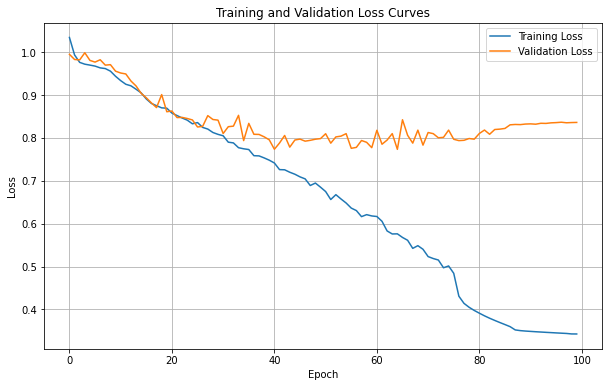

In [120]:
plt.figure(figsize=(10, 6))
plt.plot(train_loss_list, label='Training Loss')
plt.plot(val_loss_list, label='Validation Loss')
plt.title("Training and Validation Loss Curves")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()

In [86]:
test_dice = []
test_jaccard = []
model = UNet(in_channels=1, out_channels=1)
checkpoint = torch.load("UNetFinal", map_location=device)
model.load_state_dict(checkpoint["model_state_dict"])
model.to(device)
model.eval()
with torch.no_grad():
    for images, masks in test_loader:
        images = images.to(device)
        masks = masks.to(device)
        outputs = model(images)
        preds = (torch.sigmoid(outputs) > 0.5).float()
        preds_flat = preds.view(-1)
        masks_flat = masks.view(-1)
        intersection = (preds_flat * masks_flat).sum()
        union = (preds_flat + masks_flat).sum() - intersection
        jaccard = intersection / (union + 1e-10)
        dice = (2. * intersection) / (preds_flat.sum() + masks_flat.sum() + 1e-10)
        test_dice.append(dice.item())
        test_jaccard.append(jaccard.item())
print(f"Mean Dice Score: {sum(test_dice)/len(test_dice):.4f}")
print(f"Mean Jaccard Score: {sum(test_jaccard)/len(test_jaccard):.4f}")

Mean Dice Score: 0.3767
Mean Jaccard Score: 0.2680


In [31]:
test_dice = []
test_jaccard = []
model = UNet(in_channels=1, out_channels=1)
checkpoint = torch.load("UNetFinal", map_location=device)
model.load_state_dict(checkpoint["model_state_dict"])
model.to(device)
model.eval()
with torch.no_grad():
    for images, masks in test_loader:
        images = images.to(device)
        masks = masks.to(device)
        outputs = model(images)
        preds = (torch.sigmoid(outputs) > 0.5).float()
        preds_flat = preds.view(-1)
        masks_flat = masks.view(-1)
        intersection = (preds_flat * masks_flat).sum()
        union = (preds_flat + masks_flat).sum() - intersection
        jaccard = intersection / (union + 1e-10)
        dice = (2. * intersection) / (preds_flat.sum() + masks_flat.sum() + 1e-10)
        test_dice.append(dice.item())
        test_jaccard.append(jaccard.item())
print(f"Mean Dice Score: {sum(test_dice)/len(test_dice):.4f}")
print(f"Mean Jaccard Score: {sum(test_jaccard)/len(test_jaccard):.4f}")

Mean Dice Score: 0.3767
Mean Jaccard Score: 0.2680


In [33]:
for i, img in enumerate(test_dice):
    print(i, img)

0 0.7556191086769104
1 0.0
2 0.0
3 0.7216238379478455
4 0.13180729746818542
5 0.0
6 0.0
7 0.571946382522583
8 0.7935817837715149
9 0.09955698996782303
10 0.2572178542613983
11 0.04501844942569733
12 0.7559383511543274
13 0.5700605511665344
14 0.1744014173746109
15 0.5593495965003967
16 0.586132287979126
17 0.08704318851232529
18 0.37601175904273987
19 0.5497500896453857
20 0.5129802823066711
21 0.05294191464781761
22 0.15898172557353973
23 0.6090359091758728
24 0.15628337860107422
25 0.8899118304252625
26 0.30441755056381226
27 0.14056862890720367
28 0.3964790403842926
29 0.27339181303977966
30 0.05635456368327141
31 0.5526653528213501
32 0.8818990588188171
33 0.8259056210517883
34 0.6401765942573547
35 0.22471123933792114
36 0.39811912178993225
37 0.19921875
38 0.3919413983821869
39 0.0
40 0.7320623993873596
41 0.7168246507644653
42 0.8082775473594666
43 0.5714285969734192
44 0.38657036423683167
45 0.5221374034881592
46 0.8362839221954346
47 0.6976743936538696
48 0.5473020076751709
49

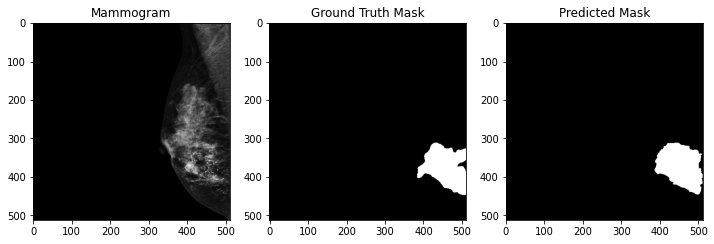

In [88]:
img, mask = get_nth_sample_from_loader(test_loader, 186) 
with torch.no_grad():
    output = model(img.unsqueeze(0).to(device))
    pred = (torch.sigmoid(output) > 0.5).float()

    plt.figure(figsize=(12,4))
    plt.subplot(1,3,1)
    plt.imshow(img.squeeze().cpu(), cmap='gray')
    plt.title('Mammogram')

    plt.subplot(1,3,2)
    plt.imshow(mask.squeeze().cpu(), cmap='gray')
    plt.title('Ground Truth Mask')
    plt.subplot(1,3,3)
    plt.imshow(pred.squeeze().cpu(), cmap='gray')
    plt.title('Predicted Mask')
    plt.show()

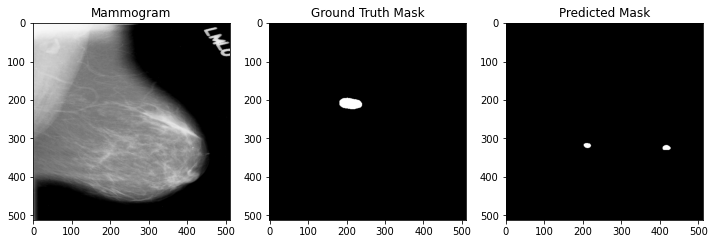

In [91]:
img, mask = get_nth_sample_from_loader(test_loader, 1) 
with torch.no_grad():
    output = model(img.unsqueeze(0).to(device))
    pred = (torch.sigmoid(output) > 0.5).float()

    plt.figure(figsize=(12,4))
    plt.subplot(1,3,1)
    plt.imshow(img.squeeze().cpu(), cmap='gray')
    plt.title('Mammogram')

    plt.subplot(1,3,2)
    plt.imshow(mask.squeeze().cpu(), cmap='gray')
    plt.title('Ground Truth Mask')
    plt.subplot(1,3,3)
    plt.imshow(pred.squeeze().cpu(), cmap='gray')
    plt.title('Predicted Mask')
    plt.show()

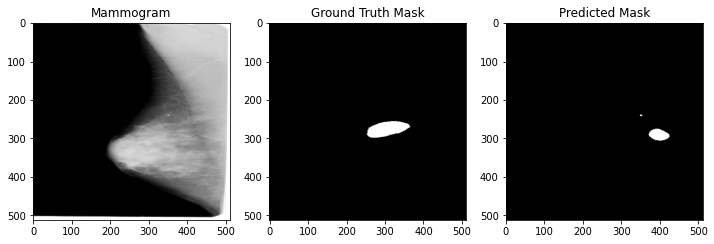

In [34]:
img, mask = get_nth_sample_from_loader(test_loader, 2) 
with torch.no_grad():
    output = model(img.unsqueeze(0).to(device))
    pred = (torch.sigmoid(output) > 0.5).float()

    plt.figure(figsize=(12,4))
    plt.subplot(1,3,1)
    plt.imshow(img.squeeze().cpu(), cmap='gray')
    plt.title('Mammogram')

    plt.subplot(1,3,2)
    plt.imshow(mask.squeeze().cpu(), cmap='gray')
    plt.title('Ground Truth Mask')
    plt.subplot(1,3,3)
    plt.imshow(pred.squeeze().cpu(), cmap='gray')
    plt.title('Predicted Mask')
    plt.show()

# U-Net with Both Cropped

In [16]:
model = UNet(in_channels=1, out_channels=1).to(device)
optimizer = optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=10)
criterion = DiceBCEFocalLoss().to(device)
train(model, train_loader, val_loader, epochs=100, filename="UNetFinalAllCrop")

Epoch 1 Validation: 100%|████████████████████████████████████████████████████████████| 188/188 [01:35<00:00,  1.96it/s]


Epoch 1/100 | Train Loss: 1.1324, Dice: 0.7038 | Val Loss: 1.0327, Dice: 0.7554 | Best Val Loss: 1.0327 | LR: 0.0010


Epoch 2 Validation: 100%|████████████████████████████████████████████████████████████| 188/188 [01:26<00:00,  2.18it/s]


Epoch 2/100 | Train Loss: 1.0363, Dice: 0.7373 | Val Loss: 0.9783, Dice: 0.7716 | Best Val Loss: 0.9783 | LR: 0.0010


Epoch 3 Validation: 100%|████████████████████████████████████████████████████████████| 188/188 [01:22<00:00,  2.29it/s]


Epoch 3/100 | Train Loss: 1.0009, Dice: 0.7379 | Val Loss: 0.9437, Dice: 0.7752 | Best Val Loss: 0.9437 | LR: 0.0010


Epoch 4 Validation: 100%|████████████████████████████████████████████████████████████| 188/188 [01:27<00:00,  2.16it/s]


Epoch 4/100 | Train Loss: 0.9901, Dice: 0.7408 | Val Loss: 0.9310, Dice: 0.7764 | Best Val Loss: 0.9310 | LR: 0.0010


Epoch 5 Validation: 100%|████████████████████████████████████████████████████████████| 188/188 [01:21<00:00,  2.30it/s]


Epoch 5/100 | Train Loss: 0.9829, Dice: 0.7424 | Val Loss: 0.9237, Dice: 0.7792 | Best Val Loss: 0.9237 | LR: 0.0010


Epoch 6 Validation: 100%|████████████████████████████████████████████████████████████| 188/188 [01:21<00:00,  2.32it/s]


Epoch 6/100 | Train Loss: 0.9643, Dice: 0.7473 | Val Loss: 0.8870, Dice: 0.7843 | Best Val Loss: 0.8870 | LR: 0.0010


Epoch 7 Validation: 100%|████████████████████████████████████████████████████████████| 188/188 [01:22<00:00,  2.29it/s]


Epoch 7/100 | Train Loss: 0.9447, Dice: 0.7530 | Val Loss: 0.8780, Dice: 0.7830 | Best Val Loss: 0.8780 | LR: 0.0010


Epoch 8 Validation: 100%|████████████████████████████████████████████████████████████| 188/188 [01:22<00:00,  2.28it/s]


Epoch 8/100 | Train Loss: 0.9306, Dice: 0.7573 | Val Loss: 0.8688, Dice: 0.7850 | Best Val Loss: 0.8688 | LR: 0.0010


Epoch 9 Validation: 100%|████████████████████████████████████████████████████████████| 188/188 [01:22<00:00,  2.29it/s]


Epoch 9/100 | Train Loss: 0.9229, Dice: 0.7592 | Val Loss: 0.8690, Dice: 0.7878 | Best Val Loss: 0.8688 | LR: 0.0010


Epoch 10 Validation: 100%|███████████████████████████████████████████████████████████| 188/188 [01:21<00:00,  2.30it/s]


Epoch 10/100 | Train Loss: 0.9140, Dice: 0.7600 | Val Loss: 0.8801, Dice: 0.7917 | Best Val Loss: 0.8688 | LR: 0.0010


Epoch 11 Validation: 100%|███████████████████████████████████████████████████████████| 188/188 [01:22<00:00,  2.29it/s]


Epoch 11/100 | Train Loss: 0.9053, Dice: 0.7621 | Val Loss: 0.8543, Dice: 0.7891 | Best Val Loss: 0.8543 | LR: 0.0010


Epoch 12 Validation: 100%|███████████████████████████████████████████████████████████| 188/188 [01:21<00:00,  2.30it/s]


Epoch 12/100 | Train Loss: 0.8973, Dice: 0.7639 | Val Loss: 0.8434, Dice: 0.7907 | Best Val Loss: 0.8434 | LR: 0.0010


Epoch 13 Validation: 100%|███████████████████████████████████████████████████████████| 188/188 [01:35<00:00,  1.97it/s]


Epoch 13/100 | Train Loss: 0.8887, Dice: 0.7642 | Val Loss: 0.8403, Dice: 0.7905 | Best Val Loss: 0.8403 | LR: 0.0010


Epoch 14 Validation: 100%|███████████████████████████████████████████████████████████| 188/188 [01:39<00:00,  1.90it/s]


Epoch 14/100 | Train Loss: 0.8840, Dice: 0.7656 | Val Loss: 0.8431, Dice: 0.7948 | Best Val Loss: 0.8403 | LR: 0.0010


Epoch 15 Validation: 100%|███████████████████████████████████████████████████████████| 188/188 [01:24<00:00,  2.23it/s]


Epoch 15/100 | Train Loss: 0.8763, Dice: 0.7671 | Val Loss: 0.8358, Dice: 0.7880 | Best Val Loss: 0.8358 | LR: 0.0010


Epoch 16 Validation: 100%|███████████████████████████████████████████████████████████| 188/188 [01:48<00:00,  1.74it/s]


Epoch 16/100 | Train Loss: 0.8668, Dice: 0.7671 | Val Loss: 0.8193, Dice: 0.7975 | Best Val Loss: 0.8193 | LR: 0.0010


Epoch 17 Validation: 100%|███████████████████████████████████████████████████████████| 188/188 [02:16<00:00,  1.38it/s]


Epoch 17/100 | Train Loss: 0.8621, Dice: 0.7685 | Val Loss: 0.8519, Dice: 0.7875 | Best Val Loss: 0.8193 | LR: 0.0010


Epoch 18 Validation: 100%|███████████████████████████████████████████████████████████| 188/188 [01:36<00:00,  1.95it/s]


Epoch 18/100 | Train Loss: 0.8542, Dice: 0.7694 | Val Loss: 0.8334, Dice: 0.7971 | Best Val Loss: 0.8193 | LR: 0.0010


Epoch 19 Validation: 100%|███████████████████████████████████████████████████████████| 188/188 [01:35<00:00,  1.96it/s]


Epoch 19/100 | Train Loss: 0.8491, Dice: 0.7711 | Val Loss: 0.8234, Dice: 0.7964 | Best Val Loss: 0.8193 | LR: 0.0010


Epoch 20 Validation: 100%|███████████████████████████████████████████████████████████| 188/188 [01:36<00:00,  1.95it/s]


Epoch 20/100 | Train Loss: 0.8416, Dice: 0.7719 | Val Loss: 0.8222, Dice: 0.7982 | Best Val Loss: 0.8193 | LR: 0.0010


Epoch 21 Validation: 100%|███████████████████████████████████████████████████████████| 188/188 [01:46<00:00,  1.77it/s]


Epoch 21/100 | Train Loss: 0.8375, Dice: 0.7732 | Val Loss: 0.8036, Dice: 0.8009 | Best Val Loss: 0.8036 | LR: 0.0010


Epoch 22 Validation: 100%|███████████████████████████████████████████████████████████| 188/188 [01:46<00:00,  1.77it/s]


Epoch 22/100 | Train Loss: 0.8280, Dice: 0.7759 | Val Loss: 0.8359, Dice: 0.7653 | Best Val Loss: 0.8036 | LR: 0.0010


Epoch 23 Validation: 100%|███████████████████████████████████████████████████████████| 188/188 [01:34<00:00,  1.99it/s]


Epoch 23/100 | Train Loss: 0.8282, Dice: 0.7755 | Val Loss: 0.8135, Dice: 0.7887 | Best Val Loss: 0.8036 | LR: 0.0010


Epoch 24 Validation: 100%|███████████████████████████████████████████████████████████| 188/188 [01:25<00:00,  2.21it/s]


Epoch 24/100 | Train Loss: 0.8175, Dice: 0.7779 | Val Loss: 0.7855, Dice: 0.8012 | Best Val Loss: 0.7855 | LR: 0.0010


Epoch 25 Validation: 100%|███████████████████████████████████████████████████████████| 188/188 [01:52<00:00,  1.68it/s]


Epoch 25/100 | Train Loss: 0.8176, Dice: 0.7773 | Val Loss: 0.8355, Dice: 0.7755 | Best Val Loss: 0.7855 | LR: 0.0010


Epoch 26 Validation: 100%|███████████████████████████████████████████████████████████| 188/188 [01:45<00:00,  1.78it/s]


Epoch 26/100 | Train Loss: 0.8164, Dice: 0.7795 | Val Loss: 0.7929, Dice: 0.8008 | Best Val Loss: 0.7855 | LR: 0.0010


Epoch 27 Validation: 100%|███████████████████████████████████████████████████████████| 188/188 [01:22<00:00,  2.28it/s]


Epoch 27/100 | Train Loss: 0.8056, Dice: 0.7816 | Val Loss: 0.7915, Dice: 0.8083 | Best Val Loss: 0.7855 | LR: 0.0010


Epoch 28 Validation: 100%|███████████████████████████████████████████████████████████| 188/188 [01:26<00:00,  2.17it/s]


Epoch 28/100 | Train Loss: 0.7981, Dice: 0.7844 | Val Loss: 0.7946, Dice: 0.7995 | Best Val Loss: 0.7855 | LR: 0.0010


Epoch 29 Validation: 100%|███████████████████████████████████████████████████████████| 188/188 [01:31<00:00,  2.06it/s]


Epoch 29/100 | Train Loss: 0.8046, Dice: 0.7832 | Val Loss: 0.8193, Dice: 0.7882 | Best Val Loss: 0.7855 | LR: 0.0010


Epoch 30 Validation: 100%|███████████████████████████████████████████████████████████| 188/188 [01:32<00:00,  2.03it/s]


Epoch 30/100 | Train Loss: 0.7941, Dice: 0.7862 | Val Loss: 0.7791, Dice: 0.8084 | Best Val Loss: 0.7791 | LR: 0.0010


Epoch 31 Validation: 100%|███████████████████████████████████████████████████████████| 188/188 [01:21<00:00,  2.32it/s]


Epoch 31/100 | Train Loss: 0.7888, Dice: 0.7880 | Val Loss: 0.8049, Dice: 0.7893 | Best Val Loss: 0.7791 | LR: 0.0010


Epoch 32 Validation: 100%|███████████████████████████████████████████████████████████| 188/188 [01:20<00:00,  2.33it/s]


Epoch 32/100 | Train Loss: 0.7796, Dice: 0.7920 | Val Loss: 0.7988, Dice: 0.7919 | Best Val Loss: 0.7791 | LR: 0.0010


Epoch 33 Validation: 100%|███████████████████████████████████████████████████████████| 188/188 [01:22<00:00,  2.29it/s]


Epoch 33/100 | Train Loss: 0.7870, Dice: 0.7874 | Val Loss: 0.7836, Dice: 0.8074 | Best Val Loss: 0.7791 | LR: 0.0010


Epoch 34 Validation: 100%|███████████████████████████████████████████████████████████| 188/188 [01:21<00:00,  2.30it/s]


Epoch 34/100 | Train Loss: 0.7797, Dice: 0.7915 | Val Loss: 0.7864, Dice: 0.8019 | Best Val Loss: 0.7791 | LR: 0.0010


Epoch 35 Validation: 100%|███████████████████████████████████████████████████████████| 188/188 [01:21<00:00,  2.30it/s]


Epoch 35/100 | Train Loss: 0.7758, Dice: 0.7899 | Val Loss: 0.8607, Dice: 0.7482 | Best Val Loss: 0.7791 | LR: 0.0010


Epoch 36 Validation: 100%|███████████████████████████████████████████████████████████| 188/188 [01:26<00:00,  2.19it/s]


Epoch 36/100 | Train Loss: 0.7752, Dice: 0.7922 | Val Loss: 0.7709, Dice: 0.8032 | Best Val Loss: 0.7709 | LR: 0.0010


Epoch 37 Validation: 100%|███████████████████████████████████████████████████████████| 188/188 [01:32<00:00,  2.03it/s]


Epoch 37/100 | Train Loss: 0.7666, Dice: 0.7942 | Val Loss: 0.7711, Dice: 0.7970 | Best Val Loss: 0.7709 | LR: 0.0010


Epoch 38 Validation: 100%|███████████████████████████████████████████████████████████| 188/188 [01:26<00:00,  2.16it/s]


Epoch 38/100 | Train Loss: 0.7534, Dice: 0.7977 | Val Loss: 0.7711, Dice: 0.8090 | Best Val Loss: 0.7709 | LR: 0.0010


Epoch 39 Validation: 100%|███████████████████████████████████████████████████████████| 188/188 [01:30<00:00,  2.08it/s]


Epoch 39/100 | Train Loss: 0.7658, Dice: 0.7957 | Val Loss: 0.7972, Dice: 0.7878 | Best Val Loss: 0.7709 | LR: 0.0010


Epoch 40 Validation: 100%|███████████████████████████████████████████████████████████| 188/188 [01:27<00:00,  2.14it/s]


Epoch 40/100 | Train Loss: 0.7449, Dice: 0.8001 | Val Loss: 0.7630, Dice: 0.8065 | Best Val Loss: 0.7630 | LR: 0.0010


Epoch 41 Validation: 100%|███████████████████████████████████████████████████████████| 188/188 [01:25<00:00,  2.20it/s]


Epoch 41/100 | Train Loss: 0.7610, Dice: 0.7975 | Val Loss: 0.7677, Dice: 0.8094 | Best Val Loss: 0.7630 | LR: 0.0010


Epoch 42 Validation: 100%|███████████████████████████████████████████████████████████| 188/188 [01:21<00:00,  2.30it/s]


Epoch 42/100 | Train Loss: 0.7464, Dice: 0.8012 | Val Loss: 0.7789, Dice: 0.8103 | Best Val Loss: 0.7630 | LR: 0.0010


Epoch 43 Validation: 100%|███████████████████████████████████████████████████████████| 188/188 [01:21<00:00,  2.30it/s]


Epoch 43/100 | Train Loss: 0.7326, Dice: 0.8040 | Val Loss: 0.8305, Dice: 0.7854 | Best Val Loss: 0.7630 | LR: 0.0010


Epoch 44 Validation: 100%|███████████████████████████████████████████████████████████| 188/188 [01:21<00:00,  2.31it/s]


Epoch 44/100 | Train Loss: 0.7486, Dice: 0.8003 | Val Loss: 0.7771, Dice: 0.8036 | Best Val Loss: 0.7630 | LR: 0.0010


Epoch 45 Validation: 100%|███████████████████████████████████████████████████████████| 188/188 [01:27<00:00,  2.15it/s]


Epoch 45/100 | Train Loss: 0.7227, Dice: 0.8059 | Val Loss: 0.7557, Dice: 0.8099 | Best Val Loss: 0.7557 | LR: 0.0010


Epoch 46 Validation: 100%|███████████████████████████████████████████████████████████| 188/188 [01:30<00:00,  2.08it/s]


Epoch 46/100 | Train Loss: 0.7220, Dice: 0.8063 | Val Loss: 0.7559, Dice: 0.8038 | Best Val Loss: 0.7557 | LR: 0.0010


Epoch 47 Validation: 100%|███████████████████████████████████████████████████████████| 188/188 [01:29<00:00,  2.10it/s]


Epoch 47/100 | Train Loss: 0.7175, Dice: 0.8070 | Val Loss: 0.8060, Dice: 0.7929 | Best Val Loss: 0.7557 | LR: 0.0010


Epoch 48 Validation: 100%|███████████████████████████████████████████████████████████| 188/188 [01:31<00:00,  2.05it/s]


Epoch 48/100 | Train Loss: 0.7097, Dice: 0.8106 | Val Loss: 0.7920, Dice: 0.7864 | Best Val Loss: 0.7557 | LR: 0.0010


Epoch 49 Validation: 100%|███████████████████████████████████████████████████████████| 188/188 [01:26<00:00,  2.17it/s]


Epoch 49/100 | Train Loss: 0.7107, Dice: 0.8092 | Val Loss: 0.7889, Dice: 0.8130 | Best Val Loss: 0.7557 | LR: 0.0010


Epoch 50 Validation: 100%|███████████████████████████████████████████████████████████| 188/188 [01:22<00:00,  2.29it/s]


Epoch 50/100 | Train Loss: 0.7023, Dice: 0.8119 | Val Loss: 0.7772, Dice: 0.8087 | Best Val Loss: 0.7557 | LR: 0.0010


Epoch 51:   1%|▍                                                                     | 11/1604 [00:06<16:03,  1.65it/s]

KeyboardInterrupt



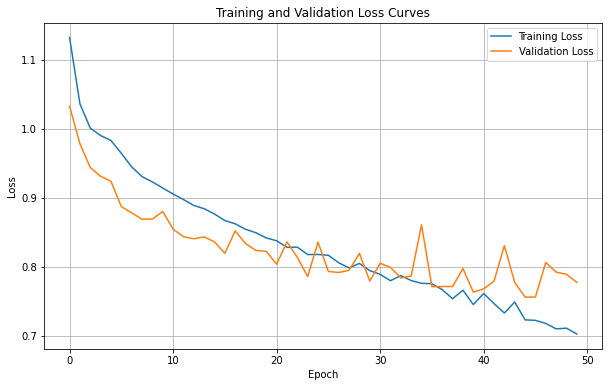

In [17]:
plt.figure(figsize=(10, 6))
plt.plot(train_loss_list, label='Training Loss')
plt.plot(val_loss_list, label='Validation Loss')
plt.title("Training and Validation Loss Curves")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()

In [19]:
test_dice = []
test_jaccard = []
model = UNet(in_channels=1, out_channels=1)
checkpoint = torch.load("UNetFinalAllCrop", map_location=device)
model.load_state_dict(checkpoint["model_state_dict"])
model.to(device)
model.eval()
with torch.no_grad():
    for images, masks in test_loader:
        images = images.to(device)
        masks = masks.to(device)
        outputs = model(images)
        preds = (torch.sigmoid(outputs) > 0.5).float()
        preds_flat = preds.view(-1)
        masks_flat = masks.view(-1)
        intersection = (preds_flat * masks_flat).sum()
        union = (preds_flat + masks_flat).sum() - intersection
        jaccard = intersection / (union + 1e-10)
        dice = (2. * intersection) / (preds_flat.sum() + masks_flat.sum() + 1e-10)
        test_dice.append(dice.item())
        test_jaccard.append(jaccard.item())
print(f"Mean Dice Score: {sum(test_dice)/len(test_dice):.4f}")
print(f"Mean Jaccard Score: {sum(test_jaccard)/len(test_jaccard):.4f}")

Mean Dice Score: 0.7881
Mean Jaccard Score: 0.6793


# CNN

## CNN Preprocessing

In [7]:
if not os.path.exists("./model_masks/"):
    os.makedirs("./model_masks/")

In [10]:
class MammogramCroppedDataset(Dataset):
    def __init__(self, img_dir, mask_dir, img_transform = None, mask_transform = None):
        self.img_dir = img_dir
        self.mask_dir = mask_dir
        self.img_transform = img_transform
        self.mask_transform = mask_transform
        self.images = os.listdir(img_dir)
        self.mask = os.listdir(mask_dir)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.images[idx])
        mask_path = os.path.join(self.mask_dir, self.mask[idx])
        
        img = dcmread(img_path).pixel_array.astype(np.float32)
        img = (img - np.min(img)) / (np.max(img) - np.min(img) + 1e-8)
        img = apply_clahe(img)
        
        mask = dcmread(mask_path).pixel_array.astype(np.float32)
        mask = (mask > 0).astype(np.float32)
        
        # Find bounding box of foreground mask pixels
        coords = np.argwhere(mask)
        if coords.size == 0:
            # If no lesion in mask, return center crop or full image
            h, w = mask.shape
            center_h, center_w = h // 2, w // 2
            crop_size = 256  # or other patch size
            top = max(center_h - crop_size // 2, 0)
            left = max(center_w - crop_size // 2, 0)
            bottom = min(top + crop_size, h)
            right = min(left + crop_size, w)
        else:
            top_left = coords.min(axis=0)
            bottom_right = coords.max(axis=0) + 1
            
            # padding
            padding = 20
            top = max(top_left[0] - padding, 0)
            left = max(top_left[1] - padding, 0)
            bottom = min(bottom_right[0] + padding, mask.shape[0])
            right = min(bottom_right[1] + padding, mask.shape[1])
        
        img_cropped = img[top:bottom, left:right]
        mask_cropped = mask[top:bottom, left:right]
        img_cropped = torch.from_numpy(img_cropped).float().unsqueeze(0)
        mask_cropped = torch.from_numpy(mask_cropped).float().unsqueeze(0)
        
        if self.img_transform:
            img_cropped = self.img_transform(img_cropped)
        if self.mask_transform:
            mask_cropped = self.mask_transform(mask_cropped)
        
        return img_cropped, mask_cropped

In [11]:
train_dataset = MammogramCroppedDataset(
    img_dir = "./train_images/",
    mask_dir = "./train_masks/",
    img_transform = img_transform,
    mask_transform = mask_transform
)

test_dataset = MammogramCroppedDataset(
    img_dir = "./test_images/",
    mask_dir = "./test_masks/",
    img_transform = img_transform,
    mask_transform = mask_transform
)

num_samples = len(test_dataset)
index = np.arange(num_samples)
val_index, test_index = train_test_split(
    index, test_size=0.5, random_state=42
)
val_dataset = Subset(test_dataset, val_index)
split_test_dataset = Subset(test_dataset, test_index)

train_loader = DataLoader(
    train_dataset,
    batch_size = 1,
    shuffle = True
)

val_loader = DataLoader(
    val_dataset,
    batch_size = 1,
    shuffle = False
)

test_loader = DataLoader(
    split_test_dataset,
    batch_size = 1,
    shuffle = False
)

In [51]:
# Test with DDSM Dataset
test_dice = []
test_jaccard = []
model = UNet(in_channels=1, out_channels=1)
checkpoint = torch.load("UNetFinalCroppedFirst", map_location=device)
model.load_state_dict(checkpoint["model_state_dict"])
model.to(device)
model.eval()
with torch.no_grad():
    for images, masks in test_loader:
        images = images.to(device)
        masks = masks.to(device)
        outputs = model(images)
        preds = (torch.sigmoid(outputs) > 0.5).float()
        preds_flat = preds.view(-1)
        masks_flat = masks.view(-1)
        intersection = (preds_flat * masks_flat).sum()
        union = (preds_flat + masks_flat).sum() - intersection
        jaccard = intersection / (union + 1e-10)
        dice = (2. * intersection) / (preds_flat.sum() + masks_flat.sum() + 1e-10)
        test_dice.append(dice.item())
        test_jaccard.append(jaccard.item())
print(f"Mean Dice Score: {sum(test_dice)/len(test_dice):.4f}")
print(f"Mean Jaccard Score: {sum(test_jaccard)/len(test_jaccard):.4f}")

Mean Dice Score: 0.8016
Mean Jaccard Score: 0.6777


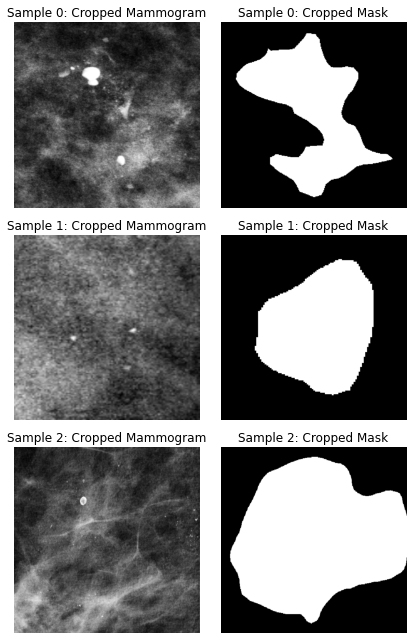

In [23]:
def show_mammogram_samples(dataset, n_samples=3):
    plt.figure(figsize=(6, 3 * n_samples))
    for i in range(n_samples):
        img, mask = dataset[i]  # img and mask are [1, H, W]
        img = img.squeeze().cpu().numpy()    # [H, W]
        mask = mask.squeeze().cpu().numpy()  # [H, W]

        plt.subplot(n_samples, 2, 2 * i + 1)
        plt.imshow(img, cmap='gray')
        plt.title(f'Sample {i}: Cropped Mammogram')
        plt.axis('off')

        plt.subplot(n_samples, 2, 2 * i + 2)
        plt.imshow(mask, cmap='gray')
        plt.title(f'Sample {i}: Cropped Mask')
        plt.axis('off')
    plt.tight_layout()
    plt.show()

dataset = MammogramCroppedDataset("./CMMD Train Image/", "./CMMD Train Mask/", img_transform, mask_transform)
show_mammogram_samples(dataset, n_samples=3)

## CNN Preprocessing

In [31]:
ddsm_df = pd.read_csv("./CBIS-DDSM_data.csv")
ddsm_df.head()

,patient_id,breast density,left or right breast,image view,abnormality id,abnormality type,calc type,calc distribution,assessment,pathology,subtlety,image file path,cropped image file path,ROI mask file path
0,P_00005,3,RIGHT,CC,1,calcification,AMORPHOUS,CLUSTERED,3,MALIGNANT,3,Calc-Training_P_00005_RIGHT_CC/1.3.6.1.4.1.959...,Calc-Training_P_00005_RIGHT_CC_1/1.3.6.1.4.1.9...,Calc-Training_P_00005_RIGHT_CC_1/1.3.6.1.4.1.9...
1,P_00005,3,RIGHT,MLO,1,calcification,AMORPHOUS,CLUSTERED,3,MALIGNANT,3,Calc-Training_P_00005_RIGHT_MLO/1.3.6.1.4.1.95...,Calc-Training_P_00005_RIGHT_MLO_1/1.3.6.1.4.1....,Calc-Training_P_00005_RIGHT_MLO_1/1.3.6.1.4.1....
2,P_00007,4,LEFT,CC,1,calcification,PLEOMORPHIC,LINEAR,4,BENIGN,4,Calc-Training_P_00007_LEFT_CC/1.3.6.1.4.1.9590...,Calc-Training_P_00007_LEFT_CC_1/1.3.6.1.4.1.95...,Calc-Training_P_00007_LEFT_CC_1/1.3.6.1.4.1.95...
3,P_00007,4,LEFT,MLO,1,calcification,PLEOMORPHIC,LINEAR,4,BENIGN,4,Calc-Training_P_00007_LEFT_MLO/1.3.6.1.4.1.959...,Calc-Training_P_00007_LEFT_MLO_1/1.3.6.1.4.1.9...,Calc-Training_P_00007_LEFT_MLO_1/1.3.6.1.4.1.9...
4,P_00008,1,LEFT,CC,1,calcification,NaN,REGIONAL,2,BENIGN_WITHOUT_CALLBACK,3,Calc-Training_P_00008_LEFT_CC/1.3.6.1.4.1.9590...,Calc-Training_P_00008_LEFT_CC_1/1.3.6.1.4.1.95...,Calc-Training_P_00008_LEFT_CC_1/1.3.6.1.4.1.95...


In [32]:
ddsm_df['image_id'] = ddsm_df['patient_id'].str.cat(ddsm_df[['left or right breast', 'image view']], sep='_')
ddsm_df.drop(['patient_id', 'breast density', 'left or right breast', 'image view', 
              'abnormality id', 'abnormality type', 'calc type', 'calc distribution', 'assessment', 'subtlety',
              'image file path', 'cropped image file path', 'ROI mask file path'], axis=1, inplace=True)

ddsm_df.head()

,pathology,image_id
0,MALIGNANT,P_00005_RIGHT_CC
1,MALIGNANT,P_00005_RIGHT_MLO
2,BENIGN,P_00007_LEFT_CC
3,BENIGN,P_00007_LEFT_MLO
4,BENIGN_WITHOUT_CALLBACK,P_00008_LEFT_CC


In [37]:
cmmd_df = pd.read_csv("./TOMPEI-CMMD_data.csv")
cmmd_df.head()

,ID1,LeftRight,classification
0,D1-0001,R,Benign
1,D1-0002,L,Benign
2,D1-0003,L,Benign
3,D1-0004,L,Benign
4,D1-0005,R,Benign


In [38]:
cmmd_df['image_id'] = cmmd_df['ID1'].astype(str) + '_MLO_' + cmmd_df['LeftRight'].astype(str) 
cmmd_df.drop(['ID1', 'LeftRight'], axis=1, inplace=True)
cmmd_df['classification'] = cmmd_df['classification'].str.upper()
cmmd_df.rename(columns={'classification': 'pathology'}, inplace=True)

cmmd_df.head()

,pathology,image_id
0,BENIGN,D1-0001_MLO_R
1,BENIGN,D1-0002_MLO_L
2,BENIGN,D1-0003_MLO_L
3,BENIGN,D1-0004_MLO_L
4,BENIGN,D1-0005_MLO_R


In [39]:
combined_df = pd.concat([ddsm_df, cmmd_df], axis=0, ignore_index=True)

,pathology,image_id
4142,MALIGNANT,D2-0747_MLO_R
4143,NORMAL,D2-0748_MLO_L
4144,INVISIBLE,D2-0748_MLO_R
4145,MALIGNANT,D2-0749_MLO_L
4146,NORMAL,D2-0749_MLO_R


In [53]:
combined_df['pathology'] = combined_df['pathology'].replace('BENIGN_WITHOUT_CALLBACK', 'BENIGN')
combined_df = combined_df[combined_df['pathology'] != 'INVISIBLE']
combined_df = combined_df[combined_df['pathology'] != 'NORMAL']
combined_df = combined_df[combined_df['pathology'] != 'EXCLUSION']

In [54]:
combined_df['pathology'] = combined_df['pathology'].replace('BENIGN', '0')
combined_df['pathology'] = combined_df['pathology'].replace('MALIGNANT', '1')

In [55]:
combined_df.to_csv('combined_data.csv', index=False)

## Dataset

In [2]:
def apply_clahe(img):
    img_int = (img * 255).astype(np.uint8)
    clahe  = cv.createCLAHE(clipLimit = 0.1, tileGridSize = (32,32))
    clahe_img = clahe.apply(img_int)
    return clahe_img.astype(np.float32) / 255.0

class MammogramCroppedDataset(Dataset):
    def __init__(self, img_dir, mask_dir, img_transform = None, mask_transform = None):
        self.img_dir = img_dir
        self.mask_dir = mask_dir
        self.img_transform = img_transform
        self.mask_transform = mask_transform
        all_images = os.listdir(img_dir)
        self.mask = os.listdir(mask_dir)
        self.labels_df = pd.read_csv("./combined_data.csv")
        self.labels_df['image_id'] = self.labels_df['image_id'].str.lower()
        all_images = [img.lower() for img in all_images]
        self.images = [img for img in all_images if img in set(self.labels_df['image_id'])]

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.images[idx])
        mask_path = os.path.join(self.mask_dir, self.mask[idx])
        
        img = dcmread(img_path).pixel_array.astype(np.float32)
        img = (img - np.min(img)) / (np.max(img) - np.min(img) + 1e-8)
        img = apply_clahe(img)
        
        mask = dcmread(mask_path).pixel_array.astype(np.float32)
        mask = (mask > 0).astype(np.float32)
        
        # Find bounding box of foreground mask pixels
        coords = np.argwhere(mask)
        if coords.size == 0:
            # If no lesion in mask, return center crop or full image
            h, w = mask.shape
            center_h, center_w = h // 2, w // 2
            crop_size = 256  # or other patch size
            top = max(center_h - crop_size // 2, 0)
            left = max(center_w - crop_size // 2, 0)
            bottom = min(top + crop_size, h)
            right = min(left + crop_size, w)
        else:
            top_left = coords.min(axis=0)
            bottom_right = coords.max(axis=0) + 1
            
            # Expand bounding box slightly (optional padding)
            padding = 20
            top = max(top_left[0] - padding, 0)
            left = max(top_left[1] - padding, 0)
            bottom = min(bottom_right[0] + padding, mask.shape[0])
            right = min(bottom_right[1] + padding, mask.shape[1])
        
        # Crop image and mask
        img_cropped = img[top:bottom, left:right]
        mask_cropped = mask[top:bottom, left:right]
        
        # Convert to tensor and add channel dim
        img_cropped = torch.from_numpy(img_cropped).float().unsqueeze(0)
        mask_cropped = torch.from_numpy(mask_cropped).float().unsqueeze(0)

        img_cropped = (img_cropped.numpy() * 255).astype(np.uint8).squeeze()  # (H, W)
        img_cropped = Image.fromarray(img_cropped)
        
        # Apply transforms if any
        if self.img_transform:
            img_cropped = self.img_transform(img_cropped)
        if self.mask_transform:
            mask_cropped = self.mask_transform(mask_cropped)

        img_id = self.images[idx]
        label = self.labels_df.loc[self.labels_df['image_id'] == img_id, 'pathology'].values[0]
        label = torch.tensor(label).long()
        
        return img_cropped, label

In [4]:
img_transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                         std=[0.229, 0.224, 0.225]) 
])

mask_transform = transforms.Compose([
    transforms.Resize((224, 224), interpolation=transforms.InterpolationMode.NEAREST)
])

train_dataset = MammogramCroppedDataset(
    img_dir = "./train_images/",
    mask_dir = "./train_masks/",
    img_transform = img_transform,
    mask_transform = mask_transform
)

test_dataset = MammogramCroppedDataset(
    img_dir = "./test_images/",
    mask_dir = "./test_masks/",
    img_transform = img_transform,
    mask_transform = mask_transform
)

train_loader = DataLoader(
    train_dataset,
    batch_size = 1,
    shuffle = True
)


test_loader = DataLoader(
    test_dataset,
    batch_size = 1,
    shuffle = False
)

## Naive Model

In [27]:
combined_df = pd.read_csv("./combined_data.csv")
counts = combined_df['pathology'].value_counts()
print(max(counts)/counts.sum())

0.5843579234972678


## Baseline Model

In [38]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2) 
        self.fc1 = nn.Linear(16 * 256 * 256, 2) 

    def forward(self, x):
        x = F.relu(self.conv1(x))   
        x = self.pool(x)            
        x = x.view(x.size(0), -1)  
        x = self.fc1(x)             
        return x


In [3]:
def train_model_kfold(model_class, dataset, device, k=5, num_epochs=10, batch_size=4, learning_rate=1e-3):
    """
    model_class : callable that returns a fresh model instance (e.g. lambda: MyModel())
    dataset     : torch.utils.data.Dataset
    """
    # Extract labels for stratification
    labels = [dataset.labels_df.loc[dataset.labels_df['image_id'] == img, 'pathology'].values[0] 
              for img in dataset.images]
    labels = np.array(labels)

    skf = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)

    fold_results = []

    for fold, (train_idx, val_idx) in enumerate(skf.split(np.zeros(len(labels)), labels)):
        print(f"\n===== Fold {fold+1}/{k} =====")

        # Subset dataset into train/val
        train_subset = Subset(dataset, train_idx)
        val_subset = Subset(dataset, val_idx)

        train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
        val_loader   = DataLoader(val_subset, batch_size=batch_size, shuffle=False)

        # Fresh model, optimizer, loss
        model = model_class().to(device)
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(model.parameters(), lr=learning_rate)

        for epoch in range(num_epochs):
            model.train()
            running_loss, correct, total = 0.0, 0, 0

            train_bar = tqdm(train_loader, desc=f"Fold {fold+1} Epoch {epoch+1}/{num_epochs} [Train]")
            for imgs, labels in train_bar:
                imgs, labels = imgs.to(device), labels.to(device)
                
                optimizer.zero_grad()
                outputs = model(imgs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()

                running_loss += loss.item() * imgs.size(0)
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

                train_bar.set_postfix(loss=running_loss/total, accuracy=correct/total)

            model.eval()
            val_loss, val_correct, val_total = 0.0, 0, 0
            with torch.no_grad():
                val_bar = tqdm(val_loader, desc=f"Fold {fold+1} Epoch {epoch+1}/{num_epochs} [Val]")
                for imgs, labels in val_bar:
                    imgs, labels = imgs.to(device), labels.to(device)
                    outputs = model(imgs)
                    loss = criterion(outputs, labels)

                    val_loss += loss.item() * imgs.size(0)
                    _, predicted = torch.max(outputs, 1)
                    val_total += labels.size(0)
                    val_correct += (predicted == labels).sum().item()

                    val_bar.set_postfix(loss=val_loss/val_total, accuracy=val_correct/val_total)

            print(f"Epoch {epoch+1}/{num_epochs} - "
                  f"Train Loss: {running_loss/total:.4f}, Train Acc: {correct/total:.4f} | "
                  f"Val Loss: {val_loss/val_total:.4f}, Val Acc: {val_correct/val_total:.4f}")

        fold_results.append({
            "fold": fold+1,
            "train_acc": correct/total,
            "val_acc": val_correct/val_total,
            "train_loss": running_loss/total,
            "val_loss": val_loss/val_total
        })

    # Summary
    print("\n===== Cross-validation results =====")
    avg_val_acc = np.mean([f["val_acc"] for f in fold_results])
    avg_val_loss = np.mean([f["val_loss"] for f in fold_results])
    print(f"Average Val Acc: {avg_val_acc:.4f}, Average Val Loss: {avg_val_loss:.4f}")

    return fold_results


In [40]:
results = train_model_kfold(
    model_class=SimpleCNN,
    dataset=train_dataset,
    device=device,
    k=5,
    num_epochs=10
)


===== Fold 1/5 =====


Fold 1 Epoch 1/10 [Val]: 100%|██████████████████████████████| 81/81 [02:16<00:00,  1.68s/it, accuracy=0.604, loss=5.01]


Epoch 1/10 - Train Loss: 12.6818, Train Acc: 0.5869 | Val Loss: 5.0145, Val Acc: 0.6044


Fold 1 Epoch 2/10 [Val]: 100%|██████████████████████████████| 81/81 [02:18<00:00,  1.71s/it, accuracy=0.598, loss=3.73]


Epoch 2/10 - Train Loss: 3.5047, Train Acc: 0.6235 | Val Loss: 3.7259, Val Acc: 0.5981


Fold 1 Epoch 3/10 [Val]: 100%|██████████████████████████████| 81/81 [02:13<00:00,  1.65s/it, accuracy=0.66, loss=0.837]


Epoch 3/10 - Train Loss: 3.2896, Train Acc: 0.6165 | Val Loss: 0.8374, Val Acc: 0.6604


Fold 1 Epoch 4/10 [Val]: 100%|█████████████████████████████| 81/81 [02:22<00:00,  1.76s/it, accuracy=0.586, loss=0.715]


Epoch 4/10 - Train Loss: 0.6856, Train Acc: 0.6851 | Val Loss: 0.7154, Val Acc: 0.5857


Fold 1 Epoch 5/10 [Val]: 100%|█████████████████████████████| 81/81 [02:12<00:00,  1.64s/it, accuracy=0.632, loss=0.738]


Epoch 5/10 - Train Loss: 0.4809, Train Acc: 0.7475 | Val Loss: 0.7384, Val Acc: 0.6324


Fold 1 Epoch 6/10 [Val]: 100%|█████████████████████████████| 81/81 [02:05<00:00,  1.55s/it, accuracy=0.657, loss=0.784]


Epoch 6/10 - Train Loss: 0.4273, Train Acc: 0.7997 | Val Loss: 0.7838, Val Acc: 0.6573


Fold 1 Epoch 7/10 [Val]: 100%|█████████████████████████████| 81/81 [02:05<00:00,  1.55s/it, accuracy=0.626, loss=0.775]


Epoch 7/10 - Train Loss: 0.3853, Train Acc: 0.8254 | Val Loss: 0.7748, Val Acc: 0.6262


Fold 1 Epoch 8/10 [Val]: 100%|███████████████████████████████| 81/81 [02:04<00:00,  1.54s/it, accuracy=0.654, loss=0.7]


Epoch 8/10 - Train Loss: 0.3574, Train Acc: 0.8566 | Val Loss: 0.7005, Val Acc: 0.6542


Fold 1 Epoch 9/10 [Val]: 100%|██████████████████████████████| 81/81 [02:05<00:00,  1.55s/it, accuracy=0.651, loss=0.73]


Epoch 9/10 - Train Loss: 0.3177, Train Acc: 0.8753 | Val Loss: 0.7304, Val Acc: 0.6511


Fold 1 Epoch 10/10 [Val]: 100%|████████████████████████████| 81/81 [02:04<00:00,  1.54s/it, accuracy=0.654, loss=0.701]


Epoch 10/10 - Train Loss: 0.2505, Train Acc: 0.9221 | Val Loss: 0.7011, Val Acc: 0.6542

===== Fold 2/5 =====


Fold 2 Epoch 1/10 [Val]: 100%|██████████████████████████████| 81/81 [02:03<00:00,  1.52s/it, accuracy=0.539, loss=9.54]


Epoch 1/10 - Train Loss: 17.3066, Train Acc: 0.5853 | Val Loss: 9.5366, Val Acc: 0.5389


Fold 2 Epoch 2/10 [Val]: 100%|██████████████████████████████| 81/81 [02:04<00:00,  1.54s/it, accuracy=0.632, loss=1.56]


Epoch 2/10 - Train Loss: 4.3649, Train Acc: 0.5931 | Val Loss: 1.5611, Val Acc: 0.6324


Fold 2 Epoch 3/10 [Val]: 100%|██████████████████████████████| 81/81 [02:02<00:00,  1.52s/it, accuracy=0.664, loss=0.63]


Epoch 3/10 - Train Loss: 1.1353, Train Acc: 0.6454 | Val Loss: 0.6305, Val Acc: 0.6636


Fold 2 Epoch 4/10 [Val]: 100%|█████████████████████████████| 81/81 [02:04<00:00,  1.53s/it, accuracy=0.701, loss=0.561]


Epoch 4/10 - Train Loss: 0.5546, Train Acc: 0.7140 | Val Loss: 0.5611, Val Acc: 0.7009


Fold 2 Epoch 5/10 [Val]: 100%|█████████████████████████████| 81/81 [02:03<00:00,  1.53s/it, accuracy=0.632, loss=0.633]


Epoch 5/10 - Train Loss: 0.4693, Train Acc: 0.7498 | Val Loss: 0.6327, Val Acc: 0.6324


Fold 2 Epoch 6/10 [Val]: 100%|█████████████████████████████| 81/81 [02:03<00:00,  1.52s/it, accuracy=0.695, loss=0.627]


Epoch 6/10 - Train Loss: 0.4286, Train Acc: 0.7911 | Val Loss: 0.6267, Val Acc: 0.6947


Fold 2 Epoch 7/10 [Val]: 100%|█████████████████████████████| 81/81 [02:03<00:00,  1.53s/it, accuracy=0.673, loss=0.633]


Epoch 7/10 - Train Loss: 0.3849, Train Acc: 0.8410 | Val Loss: 0.6334, Val Acc: 0.6729


Fold 2 Epoch 8/10 [Val]: 100%|█████████████████████████████| 81/81 [02:03<00:00,  1.52s/it, accuracy=0.685, loss=0.647]


Epoch 8/10 - Train Loss: 0.3788, Train Acc: 0.8363 | Val Loss: 0.6467, Val Acc: 0.6854


Fold 2 Epoch 9/10 [Val]: 100%|█████████████████████████████| 81/81 [02:03<00:00,  1.52s/it, accuracy=0.607, loss=0.717]


Epoch 9/10 - Train Loss: 0.3114, Train Acc: 0.8815 | Val Loss: 0.7174, Val Acc: 0.6075


Fold 2 Epoch 10/10 [Val]: 100%|████████████████████████████| 81/81 [02:04<00:00,  1.54s/it, accuracy=0.604, loss=0.754]


Epoch 10/10 - Train Loss: 0.2938, Train Acc: 0.8948 | Val Loss: 0.7538, Val Acc: 0.6044

===== Fold 3/5 =====


Fold 3 Epoch 1/10 [Val]: 100%|██████████████████████████████| 81/81 [02:02<00:00,  1.51s/it, accuracy=0.526, loss=6.86]


Epoch 1/10 - Train Loss: 15.6711, Train Acc: 0.6072 | Val Loss: 6.8574, Val Acc: 0.5265


Fold 3 Epoch 2/10 [Val]: 100%|██████████████████████████████| 81/81 [02:01<00:00,  1.49s/it, accuracy=0.651, loss=1.03]


Epoch 2/10 - Train Loss: 2.4310, Train Acc: 0.6259 | Val Loss: 1.0265, Val Acc: 0.6511


Fold 3 Epoch 3/10 [Val]: 100%|█████████████████████████████| 81/81 [02:00<00:00,  1.49s/it, accuracy=0.639, loss=0.765]


Epoch 3/10 - Train Loss: 0.6631, Train Acc: 0.6937 | Val Loss: 0.7649, Val Acc: 0.6386


Fold 3 Epoch 4/10 [Val]: 100%|█████████████████████████████| 81/81 [02:01<00:00,  1.51s/it, accuracy=0.654, loss=0.811]


Epoch 4/10 - Train Loss: 0.4688, Train Acc: 0.7740 | Val Loss: 0.8114, Val Acc: 0.6542


Fold 3 Epoch 5/10 [Val]: 100%|██████████████████████████████| 81/81 [02:00<00:00,  1.49s/it, accuracy=0.648, loss=0.81]


Epoch 5/10 - Train Loss: 0.4372, Train Acc: 0.7747 | Val Loss: 0.8104, Val Acc: 0.6480


Fold 3 Epoch 6/10 [Val]: 100%|█████████████████████████████| 81/81 [02:01<00:00,  1.50s/it, accuracy=0.657, loss=0.796]


Epoch 6/10 - Train Loss: 0.3967, Train Acc: 0.8168 | Val Loss: 0.7956, Val Acc: 0.6573


Fold 3 Epoch 7/10 [Val]: 100%|█████████████████████████████| 81/81 [02:01<00:00,  1.50s/it, accuracy=0.657, loss=0.715]


Epoch 7/10 - Train Loss: 0.3370, Train Acc: 0.8519 | Val Loss: 0.7154, Val Acc: 0.6573


Fold 3 Epoch 8/10 [Val]: 100%|█████████████████████████████| 81/81 [02:01<00:00,  1.49s/it, accuracy=0.651, loss=0.738]


Epoch 8/10 - Train Loss: 0.3347, Train Acc: 0.8675 | Val Loss: 0.7384, Val Acc: 0.6511


Fold 3 Epoch 9/10 [Val]: 100%|█████████████████████████████| 81/81 [02:02<00:00,  1.51s/it, accuracy=0.642, loss=0.874]


Epoch 9/10 - Train Loss: 0.3165, Train Acc: 0.8776 | Val Loss: 0.8737, Val Acc: 0.6417


Fold 3 Epoch 10/10 [Val]: 100%|████████████████████████████| 81/81 [02:02<00:00,  1.51s/it, accuracy=0.611, loss=0.926]


Epoch 10/10 - Train Loss: 0.2941, Train Acc: 0.8885 | Val Loss: 0.9260, Val Acc: 0.6106

===== Fold 4/5 =====


Fold 4 Epoch 1/10 [Val]: 100%|██████████████████████████████| 81/81 [02:05<00:00,  1.56s/it, accuracy=0.545, loss=6.66]


Epoch 1/10 - Train Loss: 22.7481, Train Acc: 0.5682 | Val Loss: 6.6574, Val Acc: 0.5452


Fold 4 Epoch 2/10 [Val]: 100%|██████████████████████████████| 81/81 [02:06<00:00,  1.56s/it, accuracy=0.645, loss=4.28]


Epoch 2/10 - Train Loss: 6.5584, Train Acc: 0.5869 | Val Loss: 4.2770, Val Acc: 0.6449


Fold 4 Epoch 3/10 [Val]: 100%|█████████████████████████████| 81/81 [02:06<00:00,  1.56s/it, accuracy=0.636, loss=0.691]


Epoch 3/10 - Train Loss: 1.3802, Train Acc: 0.6610 | Val Loss: 0.6912, Val Acc: 0.6355


Fold 4 Epoch 4/10 [Val]: 100%|██████████████████████████████| 81/81 [02:05<00:00,  1.55s/it, accuracy=0.657, loss=0.64]


Epoch 4/10 - Train Loss: 0.5076, Train Acc: 0.7599 | Val Loss: 0.6401, Val Acc: 0.6573


Fold 4 Epoch 5/10 [Val]: 100%|█████████████████████████████| 81/81 [02:06<00:00,  1.56s/it, accuracy=0.651, loss=0.633]


Epoch 5/10 - Train Loss: 0.4597, Train Acc: 0.7708 | Val Loss: 0.6331, Val Acc: 0.6511


Fold 4 Epoch 6/10 [Val]: 100%|█████████████████████████████| 81/81 [02:06<00:00,  1.56s/it, accuracy=0.682, loss=0.635]


Epoch 6/10 - Train Loss: 0.3878, Train Acc: 0.8028 | Val Loss: 0.6351, Val Acc: 0.6822


Fold 4 Epoch 7/10 [Val]: 100%|█████████████████████████████| 81/81 [02:06<00:00,  1.56s/it, accuracy=0.648, loss=0.694]


Epoch 7/10 - Train Loss: 0.4200, Train Acc: 0.8355 | Val Loss: 0.6943, Val Acc: 0.6480


Fold 4 Epoch 8/10 [Val]: 100%|█████████████████████████████| 81/81 [02:06<00:00,  1.56s/it, accuracy=0.639, loss=0.806]


Epoch 8/10 - Train Loss: 0.3748, Train Acc: 0.8574 | Val Loss: 0.8055, Val Acc: 0.6386


Fold 4 Epoch 9/10 [Val]: 100%|██████████████████████████████| 81/81 [02:06<00:00,  1.56s/it, accuracy=0.66, loss=0.616]


Epoch 9/10 - Train Loss: 0.3162, Train Acc: 0.8776 | Val Loss: 0.6161, Val Acc: 0.6604


Fold 4 Epoch 10/10 [Val]: 100%|█████████████████████████████| 81/81 [02:05<00:00,  1.56s/it, accuracy=0.657, loss=0.73]


Epoch 10/10 - Train Loss: 0.2786, Train Acc: 0.8924 | Val Loss: 0.7297, Val Acc: 0.6573

===== Fold 5/5 =====


Fold 5 Epoch 1/10 [Val]: 100%|██████████████████████████████| 80/80 [02:06<00:00,  1.58s/it, accuracy=0.528, loss=4.37]


Epoch 1/10 - Train Loss: 15.4355, Train Acc: 0.5771 | Val Loss: 4.3702, Val Acc: 0.5281


Fold 5 Epoch 2/10 [Val]: 100%|██████████████████████████████| 80/80 [02:06<00:00,  1.58s/it, accuracy=0.628, loss=1.81]


Epoch 2/10 - Train Loss: 2.4052, Train Acc: 0.6223 | Val Loss: 1.8100, Val Acc: 0.6281


Fold 5 Epoch 3/10 [Val]: 100%|█████████████████████████████| 80/80 [02:06<00:00,  1.58s/it, accuracy=0.741, loss=0.633]


Epoch 3/10 - Train Loss: 0.6506, Train Acc: 0.6916 | Val Loss: 0.6334, Val Acc: 0.7406


Fold 5 Epoch 4/10 [Val]: 100%|█████████████████████████████| 80/80 [02:06<00:00,  1.58s/it, accuracy=0.691, loss=0.675]


Epoch 4/10 - Train Loss: 0.4642, Train Acc: 0.7648 | Val Loss: 0.6752, Val Acc: 0.6906


Fold 5 Epoch 5/10 [Val]: 100%|█████████████████████████████| 80/80 [02:10<00:00,  1.63s/it, accuracy=0.684, loss=0.691]


Epoch 5/10 - Train Loss: 0.3839, Train Acc: 0.8232 | Val Loss: 0.6906, Val Acc: 0.6844


Fold 5 Epoch 6/10 [Val]: 100%|█████████████████████████████| 80/80 [02:04<00:00,  1.56s/it, accuracy=0.681, loss=0.799]


Epoch 6/10 - Train Loss: 0.3549, Train Acc: 0.8575 | Val Loss: 0.7987, Val Acc: 0.6813


Fold 5 Epoch 7/10 [Val]: 100%|█████████████████████████████| 80/80 [02:06<00:00,  1.58s/it, accuracy=0.716, loss=0.707]


Epoch 7/10 - Train Loss: 0.2870, Train Acc: 0.8910 | Val Loss: 0.7067, Val Acc: 0.7156


Fold 5 Epoch 8/10 [Val]: 100%|█████████████████████████████| 80/80 [02:06<00:00,  1.58s/it, accuracy=0.644, loss=0.669]


Epoch 8/10 - Train Loss: 0.2510, Train Acc: 0.9081 | Val Loss: 0.6693, Val Acc: 0.6438


Fold 5 Epoch 9/10 [Val]: 100%|██████████████████████████████| 80/80 [02:06<00:00,  1.58s/it, accuracy=0.728, loss=0.63]


Epoch 9/10 - Train Loss: 0.1777, Train Acc: 0.9525 | Val Loss: 0.6296, Val Acc: 0.7281


Fold 5 Epoch 10/10 [Val]: 100%|████████████████████████████| 80/80 [02:13<00:00,  1.67s/it, accuracy=0.641, loss=0.914]

Epoch 10/10 - Train Loss: 0.2164, Train Acc: 0.9237 | Val Loss: 0.9142, Val Acc: 0.6406

===== Cross-validation results =====
Average Val Acc: 0.6334, Average Val Loss: 0.8050


## Overfit Model

In [49]:
class CNNOverfit(nn.Module):
    def __init__(self):
        super(CNNOverfit, self).__init__()
        self.conv1 = nn.Conv2d(1, 64, 3, padding=1)   
        self.conv2 = nn.Conv2d(64, 128, 3, padding=1) 
        self.pool = nn.MaxPool2d(2, 2)               
        self.fc1 = nn.Linear(128 * 128 * 128, 512)   
        self.fc2 = nn.Linear(512, 2)                  

    def forward(self, x):
        x = F.relu(self.conv1(x))       
        x = F.relu(self.conv2(x))       
        x = self.pool(x)                
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))         
        x = self.fc2(x)
        return x

In [51]:
results = train_model_kfold(
    model_class=CNNOverfit,
    dataset=train_dataset,
    device=device,
    k=5,
    num_epochs=10
)


===== Fold 1/5 =====


RuntimeError: CUDA error: out of memory
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


## Transfer Learning

In [9]:
print(model.classifier)

Sequential(
  (0): Linear(in_features=25088, out_features=4096, bias=True)
  (1): ReLU(inplace=True)
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=4096, out_features=4096, bias=True)
  (4): ReLU(inplace=True)
  (5): Dropout(p=0.5, inplace=False)
  (6): Linear(in_features=4096, out_features=1000, bias=True)
)


In [4]:
def train_model_VGG(dataset, device, k=5, num_epochs=10, batch_size=4, learning_rate=1e-3):
    """
    dataset : torch.utils.data.Dataset
    device  : device to run training on
    """
    # Extract labels 
    labels = [dataset.labels_df.loc[dataset.labels_df['image_id'] == img, 'pathology'].values[0] 
              for img in dataset.images]
    labels = np.array(labels)
    
    skf = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)
    fold_results = []

    for fold, (train_idx, val_idx) in enumerate(skf.split(np.arange(len(labels)), labels)):
        print(f"\n===== Fold {fold+1}/{k} =====")
        
        train_subset = Subset(dataset, train_idx)
        val_subset = Subset(dataset, val_idx)
        train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
        val_loader   = DataLoader(val_subset, batch_size=batch_size, shuffle=False)
        
        # Initialize VGG16 pretrained model per fold
        model = models.vgg16(pretrained=True)
        for param in model.features.parameters():
            param.requires_grad = False
        model.classifier[6] = nn.Linear(model.classifier[6].in_features, 2)  # binary classes
        model = model.to(device)
        
        criterion = nn.CrossEntropyLoss()
        optimizer = torch.optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=learning_rate)
        
        for epoch in range(num_epochs):
            model.train()
            running_loss, correct, total = 0.0, 0, 0
            train_bar = tqdm(train_loader, desc=f"Fold {fold+1} Epoch {epoch+1}/{num_epochs} [Train]")

            for imgs, labels in train_bar:
                imgs, labels = imgs.to(device), labels.to(device)
                optimizer.zero_grad()
                outputs = model(imgs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
                
                running_loss += loss.item() * imgs.size(0)
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
                train_bar.set_postfix(loss=running_loss/total, accuracy=correct/total)
            
            model.eval()
            val_loss, val_correct, val_total = 0.0, 0, 0
            with torch.no_grad():
                val_bar = tqdm(val_loader, desc=f"Fold {fold+1} Epoch {epoch+1}/{num_epochs} [Val]")
                for imgs, labels in val_bar:
                    imgs, labels = imgs.to(device), labels.to(device)
                    outputs = model(imgs)
                    loss = criterion(outputs, labels)
                    val_loss += loss.item() * imgs.size(0)
                    _, predicted = torch.max(outputs, 1)
                    val_total += labels.size(0)
                    val_correct += (predicted == labels).sum().item()
                    val_bar.set_postfix(loss=val_loss/val_total if val_total else 0, accuracy=val_correct/val_total if val_total else 0)
            
            print(f"Epoch {epoch+1}/{num_epochs} - "
                  f"Train Loss: {running_loss/total:.4f}, Train Acc: {correct/total:.4f} | "
                  f"Val Loss: {val_loss/val_total:.4f}, Val Acc: {val_correct/val_total:.4f}")
        
        fold_results.append({
            "fold": fold+1,
            "train_acc": correct/total,
            "val_acc": val_correct/val_total,
            "train_loss": running_loss/total,
            "val_loss": val_loss/val_total
        })
    
    print("\n===== Cross-validation results =====")
    avg_val_acc = np.mean([f["val_acc"] for f in fold_results])
    avg_val_loss = np.mean([f["val_loss"] for f in fold_results])
    print(f"Average Val Acc: {avg_val_acc:.4f}, Average Val Loss: {avg_val_loss:.4f}")
    
    return fold_results


In [6]:
train_model_VGG(dataset=train_dataset, device=device)


===== Fold 1/5 =====


Fold 1 Epoch 1/10 [Val]: 100%|█████████████████████████████| 81/81 [02:37<00:00,  1.95s/it, accuracy=0.676, loss=0.738]


Epoch 1/10 - Train Loss: 1.4130, Train Acc: 0.6196 | Val Loss: 0.7382, Val Acc: 0.6760


Fold 1 Epoch 2/10 [Val]: 100%|█████████████████████████████| 81/81 [02:22<00:00,  1.76s/it, accuracy=0.682, loss=0.612]


Epoch 2/10 - Train Loss: 1.3324, Train Acc: 0.6516 | Val Loss: 0.6117, Val Acc: 0.6822


Fold 1 Epoch 3/10 [Val]: 100%|█████████████████████████████| 81/81 [02:23<00:00,  1.77s/it, accuracy=0.611, loss=0.713]


Epoch 3/10 - Train Loss: 0.9179, Train Acc: 0.7030 | Val Loss: 0.7132, Val Acc: 0.6106


Fold 1 Epoch 4/10 [Val]: 100%|██████████████████████████████| 81/81 [02:28<00:00,  1.84s/it, accuracy=0.623, loss=0.97]


Epoch 4/10 - Train Loss: 0.7377, Train Acc: 0.7233 | Val Loss: 0.9705, Val Acc: 0.6231


Fold 1 Epoch 5/10 [Val]: 100%|█████████████████████████████| 81/81 [02:43<00:00,  2.01s/it, accuracy=0.692, loss=0.841]


Epoch 5/10 - Train Loss: 0.6306, Train Acc: 0.7662 | Val Loss: 0.8407, Val Acc: 0.6916


Fold 1 Epoch 6/10 [Val]: 100%|█████████████████████████████| 81/81 [02:23<00:00,  1.78s/it, accuracy=0.692, loss=0.744]


Epoch 6/10 - Train Loss: 0.6484, Train Acc: 0.7740 | Val Loss: 0.7436, Val Acc: 0.6916


Fold 1 Epoch 7/10 [Val]: 100%|██████████████████████████████| 81/81 [03:02<00:00,  2.26s/it, accuracy=0.713, loss=1.09]


Epoch 7/10 - Train Loss: 0.5708, Train Acc: 0.8044 | Val Loss: 1.0926, Val Acc: 0.7134


Fold 1 Epoch 8/10 [Val]: 100%|██████████████████████████████| 81/81 [02:38<00:00,  1.95s/it, accuracy=0.695, loss=0.99]


Epoch 8/10 - Train Loss: 0.5246, Train Acc: 0.8239 | Val Loss: 0.9898, Val Acc: 0.6947


Fold 1 Epoch 9/10 [Val]: 100%|██████████████████████████████| 81/81 [02:42<00:00,  2.01s/it, accuracy=0.692, loss=1.66]


Epoch 9/10 - Train Loss: 0.6462, Train Acc: 0.8301 | Val Loss: 1.6643, Val Acc: 0.6916


Fold 1 Epoch 10/10 [Val]: 100%|█████████████████████████████| 81/81 [02:38<00:00,  1.96s/it, accuracy=0.639, loss=1.11]


Epoch 10/10 - Train Loss: 0.5816, Train Acc: 0.8316 | Val Loss: 1.1113, Val Acc: 0.6386

===== Fold 2/5 =====


Fold 2 Epoch 1/10 [Val]: 100%|█████████████████████████████| 81/81 [02:56<00:00,  2.17s/it, accuracy=0.688, loss=0.698]


Epoch 1/10 - Train Loss: 1.3984, Train Acc: 0.6391 | Val Loss: 0.6979, Val Acc: 0.6885


Fold 2 Epoch 2/10 [Val]: 100%|█████████████████████████████| 81/81 [02:09<00:00,  1.60s/it, accuracy=0.701, loss=0.642]


Epoch 2/10 - Train Loss: 1.0883, Train Acc: 0.6625 | Val Loss: 0.6420, Val Acc: 0.7009


Fold 2 Epoch 3/10 [Val]: 100%|█████████████████████████████| 81/81 [02:10<00:00,  1.62s/it, accuracy=0.704, loss=0.601]


Epoch 3/10 - Train Loss: 0.8620, Train Acc: 0.7101 | Val Loss: 0.6013, Val Acc: 0.7040


Fold 2 Epoch 4/10 [Val]: 100%|█████████████████████████████| 81/81 [02:14<00:00,  1.66s/it, accuracy=0.664, loss=0.707]


Epoch 4/10 - Train Loss: 0.8564, Train Acc: 0.7366 | Val Loss: 0.7065, Val Acc: 0.6636


Fold 2 Epoch 5/10 [Val]: 100%|██████████████████████████████| 81/81 [02:52<00:00,  2.13s/it, accuracy=0.723, loss=0.71]


Epoch 5/10 - Train Loss: 0.7396, Train Acc: 0.7436 | Val Loss: 0.7104, Val Acc: 0.7227


Fold 2 Epoch 6/10 [Val]: 100%|█████████████████████████████| 81/81 [02:15<00:00,  1.68s/it, accuracy=0.723, loss=0.766]


Epoch 6/10 - Train Loss: 0.7449, Train Acc: 0.7670 | Val Loss: 0.7663, Val Acc: 0.7227


Fold 2 Epoch 7/10 [Val]: 100%|█████████████████████████████████| 81/81 [02:16<00:00,  1.69s/it, accuracy=0.692, loss=1]


Epoch 7/10 - Train Loss: 0.6358, Train Acc: 0.7872 | Val Loss: 1.0016, Val Acc: 0.6916


Fold 2 Epoch 8/10 [Val]: 100%|███████████████████████████████| 81/81 [02:16<00:00,  1.68s/it, accuracy=0.72, loss=1.12]


Epoch 8/10 - Train Loss: 0.5340, Train Acc: 0.8098 | Val Loss: 1.1163, Val Acc: 0.7196


Fold 2 Epoch 9/10 [Val]: 100%|█████████████████████████████| 81/81 [02:17<00:00,  1.70s/it, accuracy=0.707, loss=0.838]


Epoch 9/10 - Train Loss: 0.7214, Train Acc: 0.8137 | Val Loss: 0.8377, Val Acc: 0.7072


Fold 2 Epoch 10/10 [Val]: 100%|█████████████████████████████| 81/81 [02:15<00:00,  1.68s/it, accuracy=0.71, loss=0.895]


Epoch 10/10 - Train Loss: 0.4188, Train Acc: 0.8480 | Val Loss: 0.8948, Val Acc: 0.7103

===== Fold 3/5 =====


Fold 3 Epoch 1/10 [Val]: 100%|██████████████████████████████| 81/81 [02:18<00:00,  1.70s/it, accuracy=0.648, loss=1.11]


Epoch 1/10 - Train Loss: 1.4891, Train Acc: 0.6196 | Val Loss: 1.1096, Val Acc: 0.6480


Fold 3 Epoch 2/10 [Val]: 100%|██████████████████████████████| 81/81 [02:12<00:00,  1.64s/it, accuracy=0.667, loss=1.34]


Epoch 2/10 - Train Loss: 1.1067, Train Acc: 0.6656 | Val Loss: 1.3404, Val Acc: 0.6667


Fold 3 Epoch 3/10 [Val]: 100%|█████████████████████████████| 81/81 [02:13<00:00,  1.65s/it, accuracy=0.673, loss=0.921]


Epoch 3/10 - Train Loss: 0.8186, Train Acc: 0.7023 | Val Loss: 0.9209, Val Acc: 0.6729


Fold 3 Epoch 4/10 [Val]: 100%|██████████████████████████████| 81/81 [02:13<00:00,  1.65s/it, accuracy=0.704, loss=1.08]


Epoch 4/10 - Train Loss: 0.9294, Train Acc: 0.7132 | Val Loss: 1.0847, Val Acc: 0.7040


Fold 3 Epoch 5/10 [Val]: 100%|██████████████████████████████| 81/81 [02:14<00:00,  1.66s/it, accuracy=0.692, loss=1.38]


Epoch 5/10 - Train Loss: 0.7346, Train Acc: 0.7521 | Val Loss: 1.3842, Val Acc: 0.6916


Fold 3 Epoch 6/10 [Val]: 100%|██████████████████████████████| 81/81 [02:15<00:00,  1.67s/it, accuracy=0.685, loss=1.37]


Epoch 6/10 - Train Loss: 0.5963, Train Acc: 0.7896 | Val Loss: 1.3712, Val Acc: 0.6854


Fold 3 Epoch 7/10 [Val]: 100%|██████████████████████████████| 81/81 [02:16<00:00,  1.69s/it, accuracy=0.732, loss=1.16]


Epoch 7/10 - Train Loss: 0.7052, Train Acc: 0.7592 | Val Loss: 1.1646, Val Acc: 0.7321


Fold 3 Epoch 8/10 [Val]: 100%|██████████████████████████████| 81/81 [02:13<00:00,  1.65s/it, accuracy=0.676, loss=1.63]


Epoch 8/10 - Train Loss: 0.5841, Train Acc: 0.8114 | Val Loss: 1.6344, Val Acc: 0.6760


Fold 3 Epoch 9/10 [Val]: 100%|██████████████████████████████| 81/81 [02:15<00:00,  1.68s/it, accuracy=0.701, loss=1.62]


Epoch 9/10 - Train Loss: 0.4563, Train Acc: 0.8239 | Val Loss: 1.6193, Val Acc: 0.7009


Fold 3 Epoch 10/10 [Val]: 100%|█████████████████████████████| 81/81 [02:16<00:00,  1.68s/it, accuracy=0.738, loss=1.54]


Epoch 10/10 - Train Loss: 0.4171, Train Acc: 0.8527 | Val Loss: 1.5442, Val Acc: 0.7383

===== Fold 4/5 =====


Fold 4 Epoch 1/10 [Val]: 100%|██████████████████████████████| 81/81 [02:17<00:00,  1.70s/it, accuracy=0.542, loss=2.12]


Epoch 1/10 - Train Loss: 1.5008, Train Acc: 0.6243 | Val Loss: 2.1193, Val Acc: 0.5421


Fold 4 Epoch 2/10 [Val]: 100%|█████████████████████████████| 81/81 [02:24<00:00,  1.79s/it, accuracy=0.654, loss=0.945]


Epoch 2/10 - Train Loss: 1.0729, Train Acc: 0.6516 | Val Loss: 0.9454, Val Acc: 0.6542


Fold 4 Epoch 3/10 [Val]: 100%|█████████████████████████████| 81/81 [02:23<00:00,  1.77s/it, accuracy=0.682, loss=0.636]


Epoch 3/10 - Train Loss: 0.8651, Train Acc: 0.6929 | Val Loss: 0.6355, Val Acc: 0.6822


Fold 4 Epoch 4/10 [Val]: 100%|█████████████████████████████| 81/81 [02:22<00:00,  1.76s/it, accuracy=0.676, loss=0.728]


Epoch 4/10 - Train Loss: 0.9508, Train Acc: 0.7217 | Val Loss: 0.7285, Val Acc: 0.6760


Fold 4 Epoch 5/10 [Val]: 100%|████████████████████████████████| 81/81 [02:24<00:00,  1.78s/it, accuracy=0.62, loss=1.2]


Epoch 5/10 - Train Loss: 0.6307, Train Acc: 0.7631 | Val Loss: 1.2001, Val Acc: 0.6199


Fold 4 Epoch 6/10 [Val]: 100%|█████████████████████████████| 81/81 [02:22<00:00,  1.76s/it, accuracy=0.698, loss=0.994]


Epoch 6/10 - Train Loss: 0.5846, Train Acc: 0.7763 | Val Loss: 0.9936, Val Acc: 0.6978


Fold 4 Epoch 7/10 [Val]: 100%|██████████████████████████████| 81/81 [02:23<00:00,  1.77s/it, accuracy=0.729, loss=1.01]


Epoch 7/10 - Train Loss: 0.5052, Train Acc: 0.7981 | Val Loss: 1.0080, Val Acc: 0.7290


Fold 4 Epoch 8/10 [Val]: 100%|██████████████████████████████| 81/81 [02:08<00:00,  1.59s/it, accuracy=0.741, loss=1.26]


Epoch 8/10 - Train Loss: 0.7291, Train Acc: 0.7973 | Val Loss: 1.2580, Val Acc: 0.7414


Fold 4 Epoch 9/10 [Val]: 100%|██████████████████████████████| 81/81 [02:17<00:00,  1.70s/it, accuracy=0.717, loss=1.16]


Epoch 9/10 - Train Loss: 1.0518, Train Acc: 0.7810 | Val Loss: 1.1551, Val Acc: 0.7165


Fold 4 Epoch 10/10 [Val]: 100%|████████████████████████████| 81/81 [02:06<00:00,  1.56s/it, accuracy=0.701, loss=0.903]


Epoch 10/10 - Train Loss: 0.5139, Train Acc: 0.8192 | Val Loss: 0.9028, Val Acc: 0.7009

===== Fold 5/5 =====


Fold 5 Epoch 1/10 [Val]: 100%|█████████████████████████████| 80/80 [02:09<00:00,  1.61s/it, accuracy=0.713, loss=0.928]


Epoch 1/10 - Train Loss: 1.5464, Train Acc: 0.6036 | Val Loss: 0.9276, Val Acc: 0.7125


Fold 5 Epoch 2/10 [Val]: 100%|█████████████████████████████| 80/80 [02:47<00:00,  2.09s/it, accuracy=0.694, loss=0.638]


Epoch 2/10 - Train Loss: 1.0407, Train Acc: 0.6636 | Val Loss: 0.6377, Val Acc: 0.6937


Fold 5 Epoch 3/10 [Val]: 100%|█████████████████████████████| 80/80 [02:29<00:00,  1.87s/it, accuracy=0.691, loss=0.788]


Epoch 3/10 - Train Loss: 0.8358, Train Acc: 0.6854 | Val Loss: 0.7878, Val Acc: 0.6906


Fold 5 Epoch 4/10 [Val]: 100%|█████████████████████████████| 80/80 [02:47<00:00,  2.10s/it, accuracy=0.722, loss=0.637]


Epoch 4/10 - Train Loss: 0.7670, Train Acc: 0.7165 | Val Loss: 0.6373, Val Acc: 0.7219


Fold 5 Epoch 5/10 [Val]: 100%|█████████████████████████████| 80/80 [02:15<00:00,  1.70s/it, accuracy=0.697, loss=0.781]


Epoch 5/10 - Train Loss: 0.8528, Train Acc: 0.7305 | Val Loss: 0.7812, Val Acc: 0.6969


Fold 5 Epoch 6/10 [Val]: 100%|██████████████████████████████| 80/80 [02:08<00:00,  1.61s/it, accuracy=0.738, loss=0.65]


Epoch 6/10 - Train Loss: 0.5626, Train Acc: 0.7625 | Val Loss: 0.6504, Val Acc: 0.7375


Fold 5 Epoch 7/10 [Val]: 100%|█████████████████████████████| 80/80 [02:09<00:00,  1.62s/it, accuracy=0.722, loss=0.909]


Epoch 7/10 - Train Loss: 0.4737, Train Acc: 0.8030 | Val Loss: 0.9090, Val Acc: 0.7219


Fold 5 Epoch 8/10 [Val]: 100%|██████████████████████████████| 80/80 [02:44<00:00,  2.06s/it, accuracy=0.725, loss=1.98]


Epoch 8/10 - Train Loss: 0.7869, Train Acc: 0.7788 | Val Loss: 1.9820, Val Acc: 0.7250


Fold 5 Epoch 9/10 [Val]: 100%|██████████████████████████████| 80/80 [03:04<00:00,  2.30s/it, accuracy=0.703, loss=1.96]


Epoch 9/10 - Train Loss: 0.7057, Train Acc: 0.8123 | Val Loss: 1.9634, Val Acc: 0.7031


Fold 5 Epoch 10/10 [Val]: 100%|█████████████████████████████| 80/80 [02:43<00:00,  2.04s/it, accuracy=0.741, loss=1.28]

Epoch 10/10 - Train Loss: 0.4982, Train Acc: 0.8357 | Val Loss: 1.2767, Val Acc: 0.7406

===== Cross-validation results =====
Average Val Acc: 0.7058, Average Val Loss: 1.1460


[{'fold': 1,
  'train_acc': 0.8316445830085737,
  'val_acc': 0.6386292834890965,
  'train_loss': 0.5815850064382472,
  'val_loss': 1.1113185966583534},
 {'fold': 2,
  'train_acc': 0.848012470771629,
  'val_acc': 0.7102803738317757,
  'train_loss': 0.4187637407309166,
  'val_loss': 0.8947762669844319},
 {'fold': 3,
  'train_acc': 0.852689010132502,
  'val_acc': 0.7383177570093458,
  'train_loss': 0.41708476684671264,
  'val_loss': 1.5441871371344233},
 {'fold': 4,
  'train_acc': 0.8191738113795791,
  'val_acc': 0.7009345794392523,
  'train_loss': 0.5138604013572959,
  'val_loss': 0.9027630832445735},
 {'fold': 5,
  'train_acc': 0.8356697819314641,
  'val_acc': 0.740625,
  'train_loss': 0.4981683184564713,
  'val_loss': 1.2767256581269883}]

In [8]:
def train_model_VGG(dataset, device, k=5, num_epochs=15, batch_size=16, learning_rate=1e-3):
    labels = [dataset.labels_df.loc[dataset.labels_df['image_id'] == img, 'pathology'].values[0] 
              for img in dataset.images]
    labels = np.array(labels)
    
    skf = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)
    fold_results = []

    for fold, (train_idx, val_idx) in enumerate(skf.split(np.arange(len(labels)), labels)):
        print(f"\n===== Fold {fold+1}/{k} =====")
        
        train_subset = Subset(dataset, train_idx)
        val_subset = Subset(dataset, val_idx)
        train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
        val_loader   = DataLoader(val_subset, batch_size=batch_size, shuffle=False)
        
        model = models.vgg16(pretrained=True)
        model.classifier[6] = nn.Linear(model.classifier[6].in_features, 2)
        model = model.to(device)

        unfreeze_schedule = [
            (0, 4, None, learning_rate),        
            (5, 9, 24, learning_rate/10),      
            (10, num_epochs-1, 0, learning_rate/100) 
        ]

        criterion = nn.CrossEntropyLoss()
        best_val_acc = 0.0
        save_path = f"vgg16_best_fold{fold+1}.pth"

        for epoch in range(num_epochs):
            # Update model trainable layers according to schedule
            for start, end, conv_start, lr in unfreeze_schedule:
                if start <= epoch <= end:
                    if conv_start is not None:
                        for param in model.features.parameters():
                            param.requires_grad = False
                        for param in model.features[conv_start:].parameters():
                            param.requires_grad = True
                    else:
                        for param in model.features.parameters():
                            param.requires_grad = False
                    optimizer = optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=lr)
                    break

            model.train()
            running_loss, correct, total = 0.0, 0, 0
            TP, FP, FN, TN = 0, 0, 0, 0
            train_bar = tqdm(train_loader, desc=f"Fold {fold+1} Epoch {epoch+1}/{num_epochs} [Train]")
            for imgs, labels in train_bar:
                imgs, labels = imgs.to(device), labels.to(device)
                optimizer.zero_grad()
                outputs = model(imgs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
                running_loss += loss.item() * imgs.size(0)
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
                predicted_np = predicted.cpu().numpy()
                labels_np = labels.cpu().numpy()
                TP += ((predicted_np == 1) & (labels_np == 1)).sum()
                FP += ((predicted_np == 1) & (labels_np == 0)).sum()
                FN += ((predicted_np == 0) & (labels_np == 1)).sum()
                TN += ((predicted_np == 0) & (labels_np == 0)).sum()
                train_bar.set_postfix(loss=running_loss/total, accuracy=correct/total)

            train_tpr = TP / (TP + FN + 1e-8)
            train_fpr = FP / (FP + TN + 1e-8)
            
            model.eval()
            val_loss, val_correct, val_total = 0.0, 0, 0
            val_TP, val_FP, val_FN, val_TN = 0, 0, 0, 0
            with torch.no_grad():
                val_bar = tqdm(val_loader, desc=f"Fold {fold+1} Epoch {epoch+1}/{num_epochs} [Val]")
                for imgs, labels in val_bar:
                    imgs, labels = imgs.to(device), labels.to(device)
                    outputs = model(imgs)
                    loss = criterion(outputs, labels)
                    val_loss += loss.item() * imgs.size(0)
                    _, predicted = torch.max(outputs, 1)
                    val_total += labels.size(0)
                    val_correct += (predicted == labels).sum().item()
                    predicted_np = predicted.cpu().numpy()
                    labels_np = labels.cpu().numpy()
                    val_TP += ((predicted_np == 1) & (labels_np == 1)).sum()
                    val_FP += ((predicted_np == 1) & (labels_np == 0)).sum()
                    val_FN += ((predicted_np == 0) & (labels_np == 1)).sum()
                    val_TN += ((predicted_np == 0) & (labels_np == 0)).sum()
                    val_bar.set_postfix(loss=val_loss/val_total if val_total else 0, accuracy=val_correct/val_total if val_total else 0)
            val_acc = val_correct / val_total
            val_tpr = val_TP / (val_TP + val_FN + 1e-8)
            val_fpr = val_FP / (val_FP + val_TN + 1e-8)
            
            print(f"Epoch {epoch+1}/{num_epochs} - "
                  f"Train Loss: {running_loss/total:.4f}, Train Acc: {correct/total:.4f}, Train TPR: {train_tpr:.4f}, Train FPR: {train_fpr:.4f} | "
                  f"Val Loss: {val_loss/val_total:.4f}, Val Acc: {val_correct/val_total:.4f}, Val TPR: {val_tpr:.4f}, Val FPR: {val_fpr:.4f}")

            if val_acc > best_val_acc:
                best_val_acc = val_acc
                torch.save(model.state_dict(), save_path)
                print(f"Best model saved for Fold {fold+1} at Epoch {epoch+1} (Val Acc: {best_val_acc:.4f})")

        fold_results.append({
            "fold": fold+1,
            "best_val_acc": best_val_acc
        })
    
    print("\n===== Cross-validation results =====")
    avg_val_acc = np.mean([f["best_val_acc"] for f in fold_results])
    print(f"Average Best Val Acc: {avg_val_acc:.4f}")
    return fold_results

In [10]:
train_model_VGG(dataset=train_dataset, device=device)


===== Fold 1/5 =====


Fold 1 Epoch 1/15 [Val]: 100%|█████████████████████████████| 21/21 [02:14<00:00,  6.40s/it, accuracy=0.607, loss=0.637]


Epoch 1/15 - Train Loss: 0.8260, Train Acc: 0.6578, Train TPR: 0.6628, Train FPR: 0.3480 | Val Loss: 0.6365, Val Acc: 0.6075, Val TPR: 0.9826, Val FPR: 0.8255
Best model saved for Fold 1 at Epoch 1 (Val Acc: 0.6075)


Fold 1 Epoch 2/15 [Val]: 100%|█████████████████████████████| 21/21 [02:28<00:00,  7.05s/it, accuracy=0.657, loss=0.787]


Epoch 2/15 - Train Loss: 0.6838, Train Acc: 0.6960, Train TPR: 0.7120, Train FPR: 0.3226 | Val Loss: 0.7871, Val Acc: 0.6573, Val TPR: 0.5291, Val FPR: 0.1946
Best model saved for Fold 1 at Epoch 2 (Val Acc: 0.6573)


Fold 1 Epoch 3/15 [Val]: 100%|██████████████████████████████| 21/21 [02:35<00:00,  7.40s/it, accuracy=0.71, loss=0.832]


Epoch 3/15 - Train Loss: 0.5488, Train Acc: 0.7677, Train TPR: 0.7771, Train FPR: 0.2432 | Val Loss: 0.8316, Val Acc: 0.7103, Val TPR: 0.6860, Val FPR: 0.2617
Best model saved for Fold 1 at Epoch 3 (Val Acc: 0.7103)


Fold 1 Epoch 4/15 [Val]: 100%|█████████████████████████████| 21/21 [02:30<00:00,  7.19s/it, accuracy=0.685, loss=0.814]


Epoch 4/15 - Train Loss: 0.5442, Train Acc: 0.7849, Train TPR: 0.8003, Train FPR: 0.2331 | Val Loss: 0.8139, Val Acc: 0.6854, Val TPR: 0.8372, Val FPR: 0.4899


Fold 1 Epoch 5/15 [Val]: 100%|██████████████████████████████| 21/21 [02:26<00:00,  6.97s/it, accuracy=0.654, loss=1.59]


Epoch 5/15 - Train Loss: 0.4935, Train Acc: 0.8324, Train TPR: 0.8336, Train FPR: 0.1689 | Val Loss: 1.5867, Val Acc: 0.6542, Val TPR: 0.4709, Val FPR: 0.1342


Fold 1 Epoch 6/15 [Val]: 100%|█████████████████████████████| 21/21 [03:04<00:00,  8.78s/it, accuracy=0.717, loss=0.824]


Epoch 6/15 - Train Loss: 0.4614, Train Acc: 0.8387, Train TPR: 0.8452, Train FPR: 0.1689 | Val Loss: 0.8238, Val Acc: 0.7165, Val TPR: 0.8140, Val FPR: 0.3960
Best model saved for Fold 1 at Epoch 6 (Val Acc: 0.7165)


Fold 1 Epoch 7/15 [Val]: 100%|█████████████████████████████| 21/21 [02:18<00:00,  6.61s/it, accuracy=0.695, loss=0.995]


Epoch 7/15 - Train Loss: 0.3170, Train Acc: 0.8839, Train TPR: 0.8799, Train FPR: 0.1115 | Val Loss: 0.9950, Val Acc: 0.6947, Val TPR: 0.8314, Val FPR: 0.4631


Fold 1 Epoch 8/15 [Val]: 100%|██████████████████████████████| 21/21 [02:21<00:00,  6.75s/it, accuracy=0.673, loss=1.04]


Epoch 8/15 - Train Loss: 0.2889, Train Acc: 0.9018, Train TPR: 0.9132, Train FPR: 0.1115 | Val Loss: 1.0421, Val Acc: 0.6729, Val TPR: 0.6453, Val FPR: 0.2953


Fold 1 Epoch 9/15 [Val]: 100%|██████████████████████████████| 21/21 [02:11<00:00,  6.26s/it, accuracy=0.704, loss=1.64]


Epoch 9/15 - Train Loss: 0.2697, Train Acc: 0.9299, Train TPR: 0.9392, Train FPR: 0.0811 | Val Loss: 1.6412, Val Acc: 0.7040, Val TPR: 0.9070, Val FPR: 0.5302


Fold 1 Epoch 10/15 [Val]: 100%|█████████████████████████████| 21/21 [02:13<00:00,  6.34s/it, accuracy=0.698, loss=1.52]


Epoch 10/15 - Train Loss: 0.2168, Train Acc: 0.9244, Train TPR: 0.9305, Train FPR: 0.0828 | Val Loss: 1.5222, Val Acc: 0.6978, Val TPR: 0.6105, Val FPR: 0.2013


Fold 1 Epoch 11/15 [Val]: 100%|█████████████████████████████| 21/21 [02:17<00:00,  6.55s/it, accuracy=0.707, loss=1.97]


Epoch 11/15 - Train Loss: 0.0853, Train Acc: 0.9719, Train TPR: 0.9740, Train FPR: 0.0304 | Val Loss: 1.9679, Val Acc: 0.7072, Val TPR: 0.6802, Val FPR: 0.2617


Fold 1 Epoch 12/15 [Val]: 100%|█████████████████████████████| 21/21 [02:17<00:00,  6.53s/it, accuracy=0.688, loss=2.28]


Epoch 12/15 - Train Loss: 0.0452, Train Acc: 0.9821, Train TPR: 0.9826, Train FPR: 0.0186 | Val Loss: 2.2794, Val Acc: 0.6885, Val TPR: 0.6047, Val FPR: 0.2148


Fold 1 Epoch 13/15 [Val]: 100%|█████████████████████████████| 21/21 [02:22<00:00,  6.79s/it, accuracy=0.735, loss=2.59]


Epoch 13/15 - Train Loss: 0.0483, Train Acc: 0.9899, Train TPR: 0.9899, Train FPR: 0.0101 | Val Loss: 2.5946, Val Acc: 0.7352, Val TPR: 0.7791, Val FPR: 0.3154
Best model saved for Fold 1 at Epoch 13 (Val Acc: 0.7352)


Fold 1 Epoch 14/15 [Val]: 100%|██████████████████████████████| 21/21 [02:18<00:00,  6.61s/it, accuracy=0.71, loss=4.74]


Epoch 14/15 - Train Loss: 0.0189, Train Acc: 0.9945, Train TPR: 0.9942, Train FPR: 0.0051 | Val Loss: 4.7450, Val Acc: 0.7103, Val TPR: 0.7267, Val FPR: 0.3087


Fold 1 Epoch 15/15 [Val]: 100%|█████████████████████████████| 21/21 [02:18<00:00,  6.60s/it, accuracy=0.713, loss=3.45]


Epoch 15/15 - Train Loss: 0.0140, Train Acc: 0.9977, Train TPR: 0.9971, Train FPR: 0.0017 | Val Loss: 3.4461, Val Acc: 0.7134, Val TPR: 0.6570, Val FPR: 0.2215

===== Fold 2/5 =====


Fold 2 Epoch 1/15 [Val]: 100%|█████████████████████████████| 21/21 [02:10<00:00,  6.20s/it, accuracy=0.664, loss=0.707]


Epoch 1/15 - Train Loss: 0.8318, Train Acc: 0.6228, Train TPR: 0.6435, Train FPR: 0.4013 | Val Loss: 0.7068, Val Acc: 0.6636, Val TPR: 0.3815, Val FPR: 0.0068
Best model saved for Fold 2 at Epoch 1 (Val Acc: 0.6636)


Fold 2 Epoch 2/15 [Val]: 100%|█████████████████████████████| 21/21 [02:17<00:00,  6.57s/it, accuracy=0.682, loss=0.768]


Epoch 2/15 - Train Loss: 0.6620, Train Acc: 0.7147, Train TPR: 0.7377, Train FPR: 0.3120 | Val Loss: 0.7679, Val Acc: 0.6822, Val TPR: 0.4451, Val FPR: 0.0405
Best model saved for Fold 2 at Epoch 2 (Val Acc: 0.6822)


Fold 2 Epoch 3/15 [Val]: 100%|█████████████████████████████| 21/21 [02:16<00:00,  6.48s/it, accuracy=0.685, loss=0.672]


Epoch 3/15 - Train Loss: 0.5871, Train Acc: 0.7560, Train TPR: 0.7710, Train FPR: 0.2614 | Val Loss: 0.6715, Val Acc: 0.6854, Val TPR: 0.6532, Val FPR: 0.2770
Best model saved for Fold 2 at Epoch 3 (Val Acc: 0.6854)


Fold 2 Epoch 4/15 [Val]: 100%|██████████████████████████████| 21/21 [02:19<00:00,  6.62s/it, accuracy=0.667, loss=1.41]


Epoch 4/15 - Train Loss: 0.4924, Train Acc: 0.8129, Train TPR: 0.8232, Train FPR: 0.1990 | Val Loss: 1.4099, Val Acc: 0.6667, Val TPR: 0.4220, Val FPR: 0.0473


Fold 2 Epoch 5/15 [Val]: 100%|████████████████████████████████| 21/21 [02:17<00:00,  6.56s/it, accuracy=0.72, loss=1.2]


Epoch 5/15 - Train Loss: 0.4192, Train Acc: 0.8566, Train TPR: 0.8667, Train FPR: 0.1551 | Val Loss: 1.1962, Val Acc: 0.7196, Val TPR: 0.5665, Val FPR: 0.1014
Best model saved for Fold 2 at Epoch 5 (Val Acc: 0.7196)


Fold 2 Epoch 6/15 [Val]: 100%|█████████████████████████████| 21/21 [02:15<00:00,  6.44s/it, accuracy=0.732, loss=0.826]


Epoch 6/15 - Train Loss: 0.4278, Train Acc: 0.8597, Train TPR: 0.8739, Train FPR: 0.1568 | Val Loss: 0.8260, Val Acc: 0.7321, Val TPR: 0.5838, Val FPR: 0.0946
Best model saved for Fold 2 at Epoch 6 (Val Acc: 0.7321)


Fold 2 Epoch 7/15 [Val]: 100%|██████████████████████████████| 21/21 [02:14<00:00,  6.39s/it, accuracy=0.698, loss=1.76]


Epoch 7/15 - Train Loss: 0.3169, Train Acc: 0.8784, Train TPR: 0.8783, Train FPR: 0.1214 | Val Loss: 1.7596, Val Acc: 0.6978, Val TPR: 0.6936, Val FPR: 0.2973


Fold 2 Epoch 8/15 [Val]: 100%|██████████████████████████████| 21/21 [02:15<00:00,  6.47s/it, accuracy=0.692, loss=1.38]


Epoch 8/15 - Train Loss: 0.2040, Train Acc: 0.9306, Train TPR: 0.9348, Train FPR: 0.0742 | Val Loss: 1.3807, Val Acc: 0.6916, Val TPR: 0.6185, Val FPR: 0.2230


Fold 2 Epoch 9/15 [Val]: 100%|██████████████████████████████| 21/21 [02:20<00:00,  6.71s/it, accuracy=0.704, loss=1.23]


Epoch 9/15 - Train Loss: 0.2682, Train Acc: 0.9337, Train TPR: 0.9391, Train FPR: 0.0725 | Val Loss: 1.2348, Val Acc: 0.7040, Val TPR: 0.6012, Val FPR: 0.1757


Fold 2 Epoch 10/15 [Val]: 100%|█████████████████████████████| 21/21 [02:21<00:00,  6.72s/it, accuracy=0.723, loss=1.34]


Epoch 10/15 - Train Loss: 0.1961, Train Acc: 0.9337, Train TPR: 0.9420, Train FPR: 0.0759 | Val Loss: 1.3428, Val Acc: 0.7227, Val TPR: 0.7168, Val FPR: 0.2703


Fold 2 Epoch 11/15 [Val]: 100%|█████████████████████████████| 21/21 [02:16<00:00,  6.52s/it, accuracy=0.732, loss=1.86]


Epoch 11/15 - Train Loss: 0.0675, Train Acc: 0.9782, Train TPR: 0.9783, Train FPR: 0.0219 | Val Loss: 1.8616, Val Acc: 0.7321, Val TPR: 0.6474, Val FPR: 0.1689


Fold 2 Epoch 12/15 [Val]: 100%|█████████████████████████████| 21/21 [02:15<00:00,  6.47s/it, accuracy=0.723, loss=2.24]


Epoch 12/15 - Train Loss: 0.0321, Train Acc: 0.9906, Train TPR: 0.9913, Train FPR: 0.0101 | Val Loss: 2.2414, Val Acc: 0.7227, Val TPR: 0.6821, Val FPR: 0.2297


Fold 2 Epoch 13/15 [Val]: 100%|█████████████████████████████| 21/21 [02:17<00:00,  6.54s/it, accuracy=0.723, loss=2.35]


Epoch 13/15 - Train Loss: 0.0205, Train Acc: 0.9938, Train TPR: 0.9928, Train FPR: 0.0051 | Val Loss: 2.3542, Val Acc: 0.7227, Val TPR: 0.6936, Val FPR: 0.2432


Fold 2 Epoch 14/15 [Val]: 100%|███████████████████████████████| 21/21 [02:19<00:00,  6.62s/it, accuracy=0.67, loss=2.3]


Epoch 14/15 - Train Loss: 0.0254, Train Acc: 0.9945, Train TPR: 0.9957, Train FPR: 0.0067 | Val Loss: 2.3021, Val Acc: 0.6698, Val TPR: 0.7168, Val FPR: 0.3851


Fold 2 Epoch 15/15 [Val]: 100%|█████████████████████████████| 21/21 [02:16<00:00,  6.51s/it, accuracy=0.713, loss=2.68]


Epoch 15/15 - Train Loss: 0.0155, Train Acc: 0.9953, Train TPR: 0.9971, Train FPR: 0.0067 | Val Loss: 2.6782, Val Acc: 0.7134, Val TPR: 0.6821, Val FPR: 0.2500

===== Fold 3/5 =====


Fold 3 Epoch 1/15 [Val]: 100%|█████████████████████████████| 21/21 [02:16<00:00,  6.48s/it, accuracy=0.695, loss=0.664]


Epoch 1/15 - Train Loss: 0.7776, Train Acc: 0.6493, Train TPR: 0.6493, Train FPR: 0.3508 | Val Loss: 0.6639, Val Acc: 0.6947, Val TPR: 0.7803, Val FPR: 0.4054
Best model saved for Fold 3 at Epoch 1 (Val Acc: 0.6947)


Fold 3 Epoch 2/15 [Val]: 100%|██████████████████████████████| 21/21 [02:11<00:00,  6.29s/it, accuracy=0.66, loss=0.948]


Epoch 2/15 - Train Loss: 0.6451, Train Acc: 0.6952, Train TPR: 0.6942, Train FPR: 0.3035 | Val Loss: 0.9480, Val Acc: 0.6604, Val TPR: 0.9249, Val FPR: 0.6486


Fold 3 Epoch 3/15 [Val]: 100%|██████████████████████████████| 21/21 [02:09<00:00,  6.15s/it, accuracy=0.648, loss=1.01]


Epoch 3/15 - Train Loss: 0.5776, Train Acc: 0.7514, Train TPR: 0.7580, Train FPR: 0.2563 | Val Loss: 1.0106, Val Acc: 0.6480, Val TPR: 0.8960, Val FPR: 0.6419


Fold 3 Epoch 4/15 [Val]: 100%|██████████████████████████████| 21/21 [02:10<00:00,  6.20s/it, accuracy=0.695, loss=1.06]


Epoch 4/15 - Train Loss: 0.5507, Train Acc: 0.7896, Train TPR: 0.7986, Train FPR: 0.2209 | Val Loss: 1.0630, Val Acc: 0.6947, Val TPR: 0.8902, Val FPR: 0.5338


Fold 3 Epoch 5/15 [Val]: 100%|██████████████████████████████| 21/21 [02:15<00:00,  6.45s/it, accuracy=0.623, loss=1.92]


Epoch 5/15 - Train Loss: 0.5175, Train Acc: 0.8153, Train TPR: 0.8203, Train FPR: 0.1906 | Val Loss: 1.9157, Val Acc: 0.6231, Val TPR: 1.0000, Val FPR: 0.8176


Fold 3 Epoch 6/15 [Val]: 100%|███████████████████████████████| 21/21 [02:16<00:00,  6.51s/it, accuracy=0.717, loss=1.3]


Epoch 6/15 - Train Loss: 0.3327, Train Acc: 0.8574, Train TPR: 0.8870, Train FPR: 0.1771 | Val Loss: 1.3005, Val Acc: 0.7165, Val TPR: 0.5838, Val FPR: 0.1284
Best model saved for Fold 3 at Epoch 6 (Val Acc: 0.7165)


Fold 3 Epoch 7/15 [Val]: 100%|██████████████████████████████| 21/21 [02:07<00:00,  6.09s/it, accuracy=0.741, loss=1.01]


Epoch 7/15 - Train Loss: 0.2989, Train Acc: 0.8823, Train TPR: 0.8899, Train FPR: 0.1265 | Val Loss: 1.0129, Val Acc: 0.7414, Val TPR: 0.7514, Val FPR: 0.2703
Best model saved for Fold 3 at Epoch 7 (Val Acc: 0.7414)


Fold 3 Epoch 8/15 [Val]: 100%|██████████████████████████████| 21/21 [02:15<00:00,  6.43s/it, accuracy=0.735, loss=2.32]


Epoch 8/15 - Train Loss: 0.2727, Train Acc: 0.9104, Train TPR: 0.9159, Train FPR: 0.0961 | Val Loss: 2.3158, Val Acc: 0.7352, Val TPR: 0.8208, Val FPR: 0.3649


Fold 3 Epoch 9/15 [Val]: 100%|██████████████████████████████| 21/21 [02:16<00:00,  6.50s/it, accuracy=0.713, loss=3.43]


Epoch 9/15 - Train Loss: 0.1930, Train Acc: 0.9415, Train TPR: 0.9377, Train FPR: 0.0540 | Val Loss: 3.4262, Val Acc: 0.7134, Val TPR: 0.9306, Val FPR: 0.5405


Fold 3 Epoch 10/15 [Val]: 100%|█████████████████████████████| 21/21 [02:06<00:00,  6.04s/it, accuracy=0.745, loss=4.95]


Epoch 10/15 - Train Loss: 0.1110, Train Acc: 0.9595, Train TPR: 0.9565, Train FPR: 0.0371 | Val Loss: 4.9546, Val Acc: 0.7445, Val TPR: 0.7688, Val FPR: 0.2838
Best model saved for Fold 3 at Epoch 10 (Val Acc: 0.7445)


Fold 3 Epoch 11/15 [Val]: 100%|█████████████████████████████| 21/21 [02:11<00:00,  6.27s/it, accuracy=0.757, loss=2.95]


Epoch 11/15 - Train Loss: 0.1320, Train Acc: 0.9704, Train TPR: 0.9739, Train FPR: 0.0337 | Val Loss: 2.9544, Val Acc: 0.7570, Val TPR: 0.7861, Val FPR: 0.2770
Best model saved for Fold 3 at Epoch 11 (Val Acc: 0.7570)


Fold 3 Epoch 12/15 [Val]: 100%|█████████████████████████████| 21/21 [02:13<00:00,  6.34s/it, accuracy=0.769, loss=3.69]


Epoch 12/15 - Train Loss: 0.0350, Train Acc: 0.9906, Train TPR: 0.9928, Train FPR: 0.0118 | Val Loss: 3.6852, Val Acc: 0.7695, Val TPR: 0.7457, Val FPR: 0.2027
Best model saved for Fold 3 at Epoch 12 (Val Acc: 0.7695)


Fold 3 Epoch 13/15 [Val]: 100%|█████████████████████████████| 21/21 [02:11<00:00,  6.27s/it, accuracy=0.754, loss=3.16]


Epoch 13/15 - Train Loss: 0.0450, Train Acc: 0.9899, Train TPR: 0.9899, Train FPR: 0.0101 | Val Loss: 3.1572, Val Acc: 0.7539, Val TPR: 0.7168, Val FPR: 0.2027


Fold 3 Epoch 14/15 [Val]: 100%|█████████████████████████████| 21/21 [02:12<00:00,  6.32s/it, accuracy=0.751, loss=2.51]


Epoch 14/15 - Train Loss: 0.0539, Train Acc: 0.9906, Train TPR: 0.9899, Train FPR: 0.0084 | Val Loss: 2.5137, Val Acc: 0.7508, Val TPR: 0.8208, Val FPR: 0.3311


Fold 3 Epoch 15/15 [Val]: 100%|█████████████████████████████| 21/21 [02:15<00:00,  6.45s/it, accuracy=0.735, loss=3.24]


Epoch 15/15 - Train Loss: 0.0216, Train Acc: 0.9969, Train TPR: 0.9971, Train FPR: 0.0034 | Val Loss: 3.2388, Val Acc: 0.7352, Val TPR: 0.7052, Val FPR: 0.2297

===== Fold 4/5 =====


Fold 4 Epoch 1/15 [Val]: 100%|█████████████████████████████| 21/21 [02:20<00:00,  6.68s/it, accuracy=0.642, loss=0.647]


Epoch 1/15 - Train Loss: 0.7680, Train Acc: 0.6454, Train TPR: 0.6507, Train FPR: 0.3609 | Val Loss: 0.6465, Val Acc: 0.6417, Val TPR: 0.9653, Val FPR: 0.7365
Best model saved for Fold 4 at Epoch 1 (Val Acc: 0.6417)


Fold 4 Epoch 2/15 [Val]: 100%|█████████████████████████████| 21/21 [02:21<00:00,  6.73s/it, accuracy=0.654, loss=0.586]


Epoch 2/15 - Train Loss: 0.7318, Train Acc: 0.6991, Train TPR: 0.7130, Train FPR: 0.3170 | Val Loss: 0.5861, Val Acc: 0.6542, Val TPR: 0.6301, Val FPR: 0.3176
Best model saved for Fold 4 at Epoch 2 (Val Acc: 0.6542)


Fold 4 Epoch 3/15 [Val]: 100%|█████████████████████████████| 21/21 [02:16<00:00,  6.52s/it, accuracy=0.698, loss=0.746]


Epoch 3/15 - Train Loss: 0.6031, Train Acc: 0.7506, Train TPR: 0.7667, Train FPR: 0.2681 | Val Loss: 0.7462, Val Acc: 0.6978, Val TPR: 0.4798, Val FPR: 0.0473
Best model saved for Fold 4 at Epoch 3 (Val Acc: 0.6978)


Fold 4 Epoch 4/15 [Val]: 100%|█████████████████████████████| 21/21 [02:22<00:00,  6.79s/it, accuracy=0.723, loss=0.946]


Epoch 4/15 - Train Loss: 0.4771, Train Acc: 0.7872, Train TPR: 0.7928, Train FPR: 0.2192 | Val Loss: 0.9463, Val Acc: 0.7227, Val TPR: 0.7457, Val FPR: 0.3041
Best model saved for Fold 4 at Epoch 4 (Val Acc: 0.7227)


Fold 4 Epoch 5/15 [Val]: 100%|██████████████████████████████| 21/21 [02:24<00:00,  6.87s/it, accuracy=0.726, loss=1.27]


Epoch 5/15 - Train Loss: 0.4235, Train Acc: 0.8542, Train TPR: 0.8623, Train FPR: 0.1551 | Val Loss: 1.2708, Val Acc: 0.7259, Val TPR: 0.8671, Val FPR: 0.4392
Best model saved for Fold 4 at Epoch 5 (Val Acc: 0.7259)


Fold 4 Epoch 6/15 [Val]: 100%|█████████████████████████████| 21/21 [02:12<00:00,  6.33s/it, accuracy=0.688, loss=0.845]


Epoch 6/15 - Train Loss: 0.4343, Train Acc: 0.8277, Train TPR: 0.8478, Train FPR: 0.1956 | Val Loss: 0.8450, Val Acc: 0.6885, Val TPR: 0.6879, Val FPR: 0.3108


Fold 4 Epoch 7/15 [Val]: 100%|███████████████████████████████| 21/21 [02:18<00:00,  6.59s/it, accuracy=0.71, loss=1.04]


Epoch 7/15 - Train Loss: 0.3892, Train Acc: 0.8426, Train TPR: 0.8667, Train FPR: 0.1855 | Val Loss: 1.0413, Val Acc: 0.7103, Val TPR: 0.6879, Val FPR: 0.2635


Fold 4 Epoch 8/15 [Val]: 100%|██████████████████████████████| 21/21 [02:51<00:00,  8.15s/it, accuracy=0.667, loss=1.56]


Epoch 8/15 - Train Loss: 0.2899, Train Acc: 0.8963, Train TPR: 0.9087, Train FPR: 0.1180 | Val Loss: 1.5602, Val Acc: 0.6667, Val TPR: 0.9017, Val FPR: 0.6081


Fold 4 Epoch 9/15 [Val]: 100%|███████████████████████████████| 21/21 [03:06<00:00,  8.86s/it, accuracy=0.688, loss=1.4]


Epoch 9/15 - Train Loss: 0.1928, Train Acc: 0.9228, Train TPR: 0.9275, Train FPR: 0.0826 | Val Loss: 1.4036, Val Acc: 0.6885, Val TPR: 0.6763, Val FPR: 0.2973


Fold 4 Epoch 10/15 [Val]: 100%|█████████████████████████████| 21/21 [02:50<00:00,  8.12s/it, accuracy=0.701, loss=2.31]


Epoch 10/15 - Train Loss: 0.1524, Train Acc: 0.9486, Train TPR: 0.9609, Train FPR: 0.0658 | Val Loss: 2.3092, Val Acc: 0.7009, Val TPR: 0.6821, Val FPR: 0.2770


Fold 4 Epoch 11/15 [Val]: 100%|██████████████████████████████| 21/21 [02:39<00:00,  7.57s/it, accuracy=0.71, loss=3.31]


Epoch 11/15 - Train Loss: 0.1184, Train Acc: 0.9782, Train TPR: 0.9797, Train FPR: 0.0236 | Val Loss: 3.3064, Val Acc: 0.7103, Val TPR: 0.6879, Val FPR: 0.2635


Fold 4 Epoch 12/15 [Val]: 100%|█████████████████████████████| 21/21 [02:39<00:00,  7.60s/it, accuracy=0.695, loss=3.72]


Epoch 12/15 - Train Loss: 0.0542, Train Acc: 0.9875, Train TPR: 0.9884, Train FPR: 0.0135 | Val Loss: 3.7228, Val Acc: 0.6947, Val TPR: 0.7746, Val FPR: 0.3986


Fold 4 Epoch 13/15 [Val]: 100%|█████████████████████████████| 21/21 [02:37<00:00,  7.51s/it, accuracy=0.679, loss=4.36]


Epoch 13/15 - Train Loss: 0.0205, Train Acc: 0.9930, Train TPR: 0.9942, Train FPR: 0.0084 | Val Loss: 4.3555, Val Acc: 0.6791, Val TPR: 0.6647, Val FPR: 0.3041


Fold 4 Epoch 14/15 [Val]: 100%|█████████████████████████████| 21/21 [02:47<00:00,  7.97s/it, accuracy=0.707, loss=3.08]


Epoch 14/15 - Train Loss: 0.0358, Train Acc: 0.9906, Train TPR: 0.9928, Train FPR: 0.0118 | Val Loss: 3.0831, Val Acc: 0.7072, Val TPR: 0.7861, Val FPR: 0.3851


Fold 4 Epoch 15/15 [Val]: 100%|█████████████████████████████| 21/21 [02:32<00:00,  7.27s/it, accuracy=0.723, loss=2.41]


Epoch 15/15 - Train Loss: 0.0593, Train Acc: 0.9899, Train TPR: 0.9899, Train FPR: 0.0101 | Val Loss: 2.4091, Val Acc: 0.7227, Val TPR: 0.7861, Val FPR: 0.3514

===== Fold 5/5 =====


Fold 5 Epoch 1/15 [Val]: 100%|█████████████████████████████| 20/20 [02:59<00:00,  8.97s/it, accuracy=0.616, loss=0.682]


Epoch 1/15 - Train Loss: 0.7775, Train Acc: 0.6495, Train TPR: 0.6599, Train FPR: 0.3626 | Val Loss: 0.6818, Val Acc: 0.6156, Val TPR: 0.9709, Val FPR: 0.7973
Best model saved for Fold 5 at Epoch 1 (Val Acc: 0.6156)


Fold 5 Epoch 2/15 [Val]: 100%|█████████████████████████████| 20/20 [02:16<00:00,  6.81s/it, accuracy=0.738, loss=0.601]


Epoch 2/15 - Train Loss: 0.6181, Train Acc: 0.7002, Train TPR: 0.7178, Train FPR: 0.3204 | Val Loss: 0.6010, Val Acc: 0.7375, Val TPR: 0.6512, Val FPR: 0.1622
Best model saved for Fold 5 at Epoch 2 (Val Acc: 0.7375)


Fold 5 Epoch 3/15 [Val]: 100%|█████████████████████████████| 20/20 [02:44<00:00,  8.25s/it, accuracy=0.703, loss=0.826]


Epoch 3/15 - Train Loss: 0.5702, Train Acc: 0.7593, Train TPR: 0.7713, Train FPR: 0.2546 | Val Loss: 0.8264, Val Acc: 0.7031, Val TPR: 0.7442, Val FPR: 0.3446


Fold 5 Epoch 4/15 [Val]: 100%|██████████████████████████████| 20/20 [02:31<00:00,  7.59s/it, accuracy=0.709, loss=1.03]


Epoch 4/15 - Train Loss: 0.5895, Train Acc: 0.7905, Train TPR: 0.7974, Train FPR: 0.2175 | Val Loss: 1.0270, Val Acc: 0.7094, Val TPR: 0.7035, Val FPR: 0.2838


Fold 5 Epoch 5/15 [Val]: 100%|██████████████████████████████| 20/20 [02:36<00:00,  7.83s/it, accuracy=0.738, loss=1.38]


Epoch 5/15 - Train Loss: 0.4679, Train Acc: 0.8232, Train TPR: 0.8263, Train FPR: 0.1804 | Val Loss: 1.3845, Val Acc: 0.7375, Val TPR: 0.7674, Val FPR: 0.2973


Fold 5 Epoch 6/15 [Val]: 100%|█████████████████████████████| 20/20 [02:23<00:00,  7.19s/it, accuracy=0.725, loss=0.842]


Epoch 6/15 - Train Loss: 0.3643, Train Acc: 0.8505, Train TPR: 0.8582, Train FPR: 0.1585 | Val Loss: 0.8416, Val Acc: 0.7250, Val TPR: 0.7616, Val FPR: 0.3176


Fold 5 Epoch 7/15 [Val]: 100%|██████████████████████████████| 20/20 [02:24<00:00,  7.21s/it, accuracy=0.725, loss=1.54]


Epoch 7/15 - Train Loss: 0.2594, Train Acc: 0.8847, Train TPR: 0.8842, Train FPR: 0.1147 | Val Loss: 1.5393, Val Acc: 0.7250, Val TPR: 0.5581, Val FPR: 0.0811


Fold 5 Epoch 8/15 [Val]: 100%|██████████████████████████████| 20/20 [02:11<00:00,  6.59s/it, accuracy=0.728, loss=1.64]


Epoch 8/15 - Train Loss: 0.2614, Train Acc: 0.9190, Train TPR: 0.9305, Train FPR: 0.0944 | Val Loss: 1.6409, Val Acc: 0.7281, Val TPR: 0.7035, Val FPR: 0.2432


Fold 5 Epoch 9/15 [Val]: 100%|██████████████████████████████| 20/20 [02:17<00:00,  6.88s/it, accuracy=0.722, loss=1.97]


Epoch 9/15 - Train Loss: 0.1786, Train Acc: 0.9361, Train TPR: 0.9436, Train FPR: 0.0725 | Val Loss: 1.9744, Val Acc: 0.7219, Val TPR: 0.6802, Val FPR: 0.2297


Fold 5 Epoch 10/15 [Val]: 100%|█████████████████████████████| 20/20 [02:19<00:00,  6.95s/it, accuracy=0.728, loss=2.17]


Epoch 10/15 - Train Loss: 0.2082, Train Acc: 0.9470, Train TPR: 0.9508, Train FPR: 0.0573 | Val Loss: 2.1663, Val Acc: 0.7281, Val TPR: 0.7500, Val FPR: 0.2973


Fold 5 Epoch 11/15 [Val]: 100%|█████████████████████████████| 20/20 [02:19<00:00,  6.97s/it, accuracy=0.744, loss=1.43]


Epoch 11/15 - Train Loss: 0.1163, Train Acc: 0.9665, Train TPR: 0.9653, Train FPR: 0.0320 | Val Loss: 1.4294, Val Acc: 0.7438, Val TPR: 0.7733, Val FPR: 0.2905
Best model saved for Fold 5 at Epoch 11 (Val Acc: 0.7438)


Fold 5 Epoch 12/15 [Val]: 100%|█████████████████████████████| 20/20 [02:16<00:00,  6.84s/it, accuracy=0.741, loss=2.25]


Epoch 12/15 - Train Loss: 0.0567, Train Acc: 0.9805, Train TPR: 0.9855, Train FPR: 0.0253 | Val Loss: 2.2540, Val Acc: 0.7406, Val TPR: 0.7616, Val FPR: 0.2838


Fold 5 Epoch 13/15 [Val]: 100%|█████████████████████████████| 20/20 [02:14<00:00,  6.75s/it, accuracy=0.728, loss=2.06]


Epoch 13/15 - Train Loss: 0.0621, Train Acc: 0.9860, Train TPR: 0.9870, Train FPR: 0.0152 | Val Loss: 2.0578, Val Acc: 0.7281, Val TPR: 0.7674, Val FPR: 0.3176


Fold 5 Epoch 14/15 [Val]: 100%|█████████████████████████████| 20/20 [02:29<00:00,  7.47s/it, accuracy=0.766, loss=2.12]


Epoch 14/15 - Train Loss: 0.0318, Train Acc: 0.9922, Train TPR: 0.9913, Train FPR: 0.0067 | Val Loss: 2.1215, Val Acc: 0.7656, Val TPR: 0.8430, Val FPR: 0.3243
Best model saved for Fold 5 at Epoch 14 (Val Acc: 0.7656)


Fold 5 Epoch 15/15 [Val]: 100%|█████████████████████████████| 20/20 [02:58<00:00,  8.94s/it, accuracy=0.747, loss=3.23]

Epoch 15/15 - Train Loss: 0.0137, Train Acc: 0.9938, Train TPR: 0.9942, Train FPR: 0.0067 | Val Loss: 3.2257, Val Acc: 0.7469, Val TPR: 0.7907, Val FPR: 0.3041

===== Cross-validation results =====
Average Best Val Acc: 0.7456


[{'fold': 1, 'best_val_acc': 0.735202492211838},
 {'fold': 2, 'best_val_acc': 0.7320872274143302},
 {'fold': 3, 'best_val_acc': 0.7694704049844237},
 {'fold': 4, 'best_val_acc': 0.7258566978193146},
 {'fold': 5, 'best_val_acc': 0.765625}]

In [9]:
def train_model_VGG_CMMD(dataset, device, k=5, num_epochs=15, batch_size=16, learning_rate=1e-3):
    labels = [dataset.labels_df.loc[dataset.labels_df['image_id'] == img, 'pathology'].values[0] 
              for img in dataset.images]
    labels = np.array(labels)
    
    skf = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)
    fold_results = []

    for fold, (train_idx, val_idx) in enumerate(skf.split(np.arange(len(labels)), labels)):
        print(f"\n===== Fold {fold+1}/{k} =====")
        
        train_subset = Subset(dataset, train_idx)
        val_subset = Subset(dataset, val_idx)
        train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
        val_loader   = DataLoader(val_subset, batch_size=batch_size, shuffle=False)
        
        model = models.vgg16(pretrained=True)
        model.classifier[6] = nn.Linear(model.classifier[6].in_features, 2)
        model = model.to(device)

        unfreeze_schedule = [
            (0, 4, None, learning_rate),       
            (5, 9, 24, learning_rate/10),      
            (10, num_epochs-1, 0, learning_rate/100) 
        ]

        criterion = nn.CrossEntropyLoss()
        best_val_acc = 0.0
        save_path = f"CMMD_vgg16_best_fold{fold+1}.pth"

        for epoch in range(num_epochs):
            # Update model trainable layers according to schedule
            for start, end, conv_start, lr in unfreeze_schedule:
                if start <= epoch <= end:
                    if conv_start is not None:
                        for param in model.features.parameters():
                            param.requires_grad = False
                        for param in model.features[conv_start:].parameters():
                            param.requires_grad = True
                    else:
                        for param in model.features.parameters():
                            param.requires_grad = False
                    optimizer = optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=lr)
                    break

            model.train()
            running_loss, correct, total = 0.0, 0, 0
            TP, FP, FN, TN = 0, 0, 0, 0
            train_bar = tqdm(train_loader, desc=f"Fold {fold+1} Epoch {epoch+1}/{num_epochs} [Train]")
            for imgs, labels in train_bar:
                imgs, labels = imgs.to(device), labels.to(device)
                optimizer.zero_grad()
                outputs = model(imgs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
                running_loss += loss.item() * imgs.size(0)
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
                predicted_np = predicted.cpu().numpy()
                labels_np = labels.cpu().numpy()
                TP += ((predicted_np == 1) & (labels_np == 1)).sum()
                FP += ((predicted_np == 1) & (labels_np == 0)).sum()
                FN += ((predicted_np == 0) & (labels_np == 1)).sum()
                TN += ((predicted_np == 0) & (labels_np == 0)).sum()
                train_bar.set_postfix(loss=running_loss/total, accuracy=correct/total)

            train_tpr = TP / (TP + FN + 1e-8)
            train_fpr = FP / (FP + TN + 1e-8)
            
            model.eval()
            val_loss, val_correct, val_total = 0.0, 0, 0
            val_TP, val_FP, val_FN, val_TN = 0, 0, 0, 0
            with torch.no_grad():
                val_bar = tqdm(val_loader, desc=f"Fold {fold+1} Epoch {epoch+1}/{num_epochs} [Val]")
                for imgs, labels in val_bar:
                    imgs, labels = imgs.to(device), labels.to(device)
                    outputs = model(imgs)
                    loss = criterion(outputs, labels)
                    val_loss += loss.item() * imgs.size(0)
                    _, predicted = torch.max(outputs, 1)
                    val_total += labels.size(0)
                    val_correct += (predicted == labels).sum().item()
                    predicted_np = predicted.cpu().numpy()
                    labels_np = labels.cpu().numpy()
                    val_TP += ((predicted_np == 1) & (labels_np == 1)).sum()
                    val_FP += ((predicted_np == 1) & (labels_np == 0)).sum()
                    val_FN += ((predicted_np == 0) & (labels_np == 1)).sum()
                    val_TN += ((predicted_np == 0) & (labels_np == 0)).sum()
                    val_bar.set_postfix(loss=val_loss/val_total if val_total else 0, accuracy=val_correct/val_total if val_total else 0)
            val_acc = val_correct / val_total
            val_tpr = val_TP / (val_TP + val_FN + 1e-8)
            val_fpr = val_FP / (val_FP + val_TN + 1e-8)
            
            print(f"Epoch {epoch+1}/{num_epochs} - "
                  f"Train Loss: {running_loss/total:.4f}, Train Acc: {correct/total:.4f}, Train TPR: {train_tpr:.4f}, Train FPR: {train_fpr:.4f} | "
                  f"Val Loss: {val_loss/val_total:.4f}, Val Acc: {val_correct/val_total:.4f}, Val TPR: {val_tpr:.4f}, Val FPR: {val_fpr:.4f}")
            
            if val_acc > best_val_acc:
                best_val_acc = val_acc
                torch.save(model.state_dict(), save_path)
                print(f"Best model saved for Fold {fold+1} at Epoch {epoch+1} (Val Acc: {best_val_acc:.4f})")

        fold_results.append({
            "fold": fold+1,
            "best_val_acc": best_val_acc
        })
    
    print("\n===== Cross-validation results =====")
    avg_val_acc = np.mean([f["best_val_acc"] for f in fold_results])
    print(f"Average Best Val Acc: {avg_val_acc:.4f}")
    return fold_results

In [6]:
train_model_VGG_CMMD(dataset=train_dataset, device=device)


===== Fold 1/5 =====


Fold 1 Epoch 1/15 [Val]: 100%|███████████████████████████████| 5/5 [00:15<00:00,  3.07s/it, accuracy=0.368, loss=0.995]


Epoch 1/15 - Train Loss: 1.0907, Train Acc: 0.8944, Train TPR: 0.9439, Train FPR: 0.8889 | Val Loss: 0.9946, Val Acc: 0.3684, Val TPR: 0.3521, Val FPR: 0.4000
Best model saved for Fold 1 at Epoch 1 (Val Acc: 0.3684)


Fold 1 Epoch 2/15 [Val]: 100%|███████████████████████████████| 5/5 [00:12<00:00,  2.52s/it, accuracy=0.934, loss=0.826]


Epoch 2/15 - Train Loss: 1.0302, Train Acc: 0.9307, Train TPR: 0.9860, Train FPR: 0.9444 | Val Loss: 0.8261, Val Acc: 0.9342, Val TPR: 1.0000, Val FPR: 1.0000
Best model saved for Fold 1 at Epoch 2 (Val Acc: 0.9342)


Fold 1 Epoch 3/15 [Val]: 100%|███████████████████████████████| 5/5 [00:12<00:00,  2.46s/it, accuracy=0.934, loss=0.591]


Epoch 3/15 - Train Loss: 0.4283, Train Acc: 0.9307, Train TPR: 0.9895, Train FPR: 1.0000 | Val Loss: 0.5909, Val Acc: 0.9342, Val TPR: 1.0000, Val FPR: 1.0000


Fold 1 Epoch 4/15 [Val]: 100%|███████████████████████████████| 5/5 [00:11<00:00,  2.35s/it, accuracy=0.921, loss=0.546]


Epoch 4/15 - Train Loss: 0.7409, Train Acc: 0.9274, Train TPR: 0.9719, Train FPR: 0.7778 | Val Loss: 0.5457, Val Acc: 0.9211, Val TPR: 0.9859, Val FPR: 1.0000


Fold 1 Epoch 5/15 [Val]: 100%|████████████████████████████████| 5/5 [00:13<00:00,  2.70s/it, accuracy=0.934, loss=1.56]


Epoch 5/15 - Train Loss: 0.4694, Train Acc: 0.9307, Train TPR: 0.9684, Train FPR: 0.6667 | Val Loss: 1.5552, Val Acc: 0.9342, Val TPR: 1.0000, Val FPR: 1.0000


Fold 1 Epoch 6/15 [Val]: 100%|████████████████████████████████| 5/5 [00:12<00:00,  2.54s/it, accuracy=0.921, loss=1.25]


Epoch 6/15 - Train Loss: 0.0680, Train Acc: 0.9802, Train TPR: 0.9965, Train FPR: 0.2778 | Val Loss: 1.2538, Val Acc: 0.9211, Val TPR: 0.9859, Val FPR: 1.0000


Fold 1 Epoch 7/15 [Val]: 100%|███████████████████████████████| 5/5 [00:09<00:00,  1.83s/it, accuracy=0.934, loss=0.684]


Epoch 7/15 - Train Loss: 0.2994, Train Acc: 0.9538, Train TPR: 0.9789, Train FPR: 0.4444 | Val Loss: 0.6844, Val Acc: 0.9342, Val TPR: 1.0000, Val FPR: 1.0000


Fold 1 Epoch 8/15 [Val]: 100%|████████████████████████████████| 5/5 [00:09<00:00,  1.92s/it, accuracy=0.934, loss=0.97]


Epoch 8/15 - Train Loss: 0.0688, Train Acc: 0.9835, Train TPR: 0.9965, Train FPR: 0.2222 | Val Loss: 0.9699, Val Acc: 0.9342, Val TPR: 1.0000, Val FPR: 1.0000


Fold 1 Epoch 9/15 [Val]: 100%|████████████████████████████████| 5/5 [00:09<00:00,  1.90s/it, accuracy=0.934, loss=1.75]


Epoch 9/15 - Train Loss: 0.0014, Train Acc: 1.0000, Train TPR: 1.0000, Train FPR: 0.0000 | Val Loss: 1.7455, Val Acc: 0.9342, Val TPR: 1.0000, Val FPR: 1.0000


Fold 1 Epoch 10/15 [Val]: 100%|██████████████████████████████| 5/5 [00:10<00:00,  2.09s/it, accuracy=0.947, loss=0.858]


Epoch 10/15 - Train Loss: 0.0953, Train Acc: 0.9835, Train TPR: 0.9965, Train FPR: 0.2222 | Val Loss: 0.8577, Val Acc: 0.9474, Val TPR: 1.0000, Val FPR: 0.8000
Best model saved for Fold 1 at Epoch 10 (Val Acc: 0.9474)


Fold 1 Epoch 11/15 [Val]: 100%|███████████████████████████████| 5/5 [00:10<00:00,  2.04s/it, accuracy=0.934, loss=1.51]


Epoch 11/15 - Train Loss: 0.0001, Train Acc: 1.0000, Train TPR: 1.0000, Train FPR: 0.0000 | Val Loss: 1.5127, Val Acc: 0.9342, Val TPR: 1.0000, Val FPR: 1.0000


Fold 1 Epoch 12/15 [Val]: 100%|███████████████████████████████| 5/5 [00:09<00:00,  1.94s/it, accuracy=0.934, loss=1.32]


Epoch 12/15 - Train Loss: 0.0004, Train Acc: 1.0000, Train TPR: 1.0000, Train FPR: 0.0000 | Val Loss: 1.3234, Val Acc: 0.9342, Val TPR: 1.0000, Val FPR: 1.0000


Fold 1 Epoch 13/15 [Val]: 100%|███████████████████████████████| 5/5 [00:11<00:00,  2.21s/it, accuracy=0.934, loss=3.19]


Epoch 13/15 - Train Loss: 0.0000, Train Acc: 1.0000, Train TPR: 1.0000, Train FPR: 0.0000 | Val Loss: 3.1873, Val Acc: 0.9342, Val TPR: 1.0000, Val FPR: 1.0000


Fold 1 Epoch 14/15 [Val]: 100%|███████████████████████████████| 5/5 [00:09<00:00,  1.91s/it, accuracy=0.947, loss=1.11]


Epoch 14/15 - Train Loss: 0.0000, Train Acc: 1.0000, Train TPR: 1.0000, Train FPR: 0.0000 | Val Loss: 1.1098, Val Acc: 0.9474, Val TPR: 1.0000, Val FPR: 0.8000


Fold 1 Epoch 15/15 [Val]: 100%|███████████████████████████████| 5/5 [00:09<00:00,  1.98s/it, accuracy=0.934, loss=2.78]


Epoch 15/15 - Train Loss: 0.0000, Train Acc: 1.0000, Train TPR: 1.0000, Train FPR: 0.0000 | Val Loss: 2.7793, Val Acc: 0.9342, Val TPR: 1.0000, Val FPR: 1.0000

===== Fold 2/5 =====


Fold 2 Epoch 1/15 [Val]: 100%|████████████████████████████████| 5/5 [00:09<00:00,  1.80s/it, accuracy=0.934, loss=0.26]


Epoch 1/15 - Train Loss: 1.0065, Train Acc: 0.9274, Train TPR: 0.9860, Train FPR: 1.0000 | Val Loss: 0.2596, Val Acc: 0.9342, Val TPR: 1.0000, Val FPR: 1.0000
Best model saved for Fold 2 at Epoch 1 (Val Acc: 0.9342)


Fold 2 Epoch 2/15 [Val]: 100%|███████████████████████████████| 5/5 [00:09<00:00,  1.93s/it, accuracy=0.934, loss=0.383]


Epoch 2/15 - Train Loss: 0.5605, Train Acc: 0.9241, Train TPR: 0.9825, Train FPR: 1.0000 | Val Loss: 0.3834, Val Acc: 0.9342, Val TPR: 0.9718, Val FPR: 0.6000


Fold 2 Epoch 3/15 [Val]: 100%|███████████████████████████████| 5/5 [00:11<00:00,  2.25s/it, accuracy=0.921, loss=0.465]


Epoch 3/15 - Train Loss: 0.8384, Train Acc: 0.9307, Train TPR: 0.9825, Train FPR: 0.8889 | Val Loss: 0.4652, Val Acc: 0.9211, Val TPR: 0.9577, Val FPR: 0.6000


Fold 2 Epoch 4/15 [Val]: 100%|████████████████████████████████| 5/5 [00:09<00:00,  1.89s/it, accuracy=0.895, loss=0.49]


Epoch 4/15 - Train Loss: 0.8189, Train Acc: 0.9274, Train TPR: 0.9789, Train FPR: 0.8889 | Val Loss: 0.4898, Val Acc: 0.8947, Val TPR: 0.9296, Val FPR: 0.6000


Fold 2 Epoch 5/15 [Val]: 100%|████████████████████████████████| 5/5 [00:10<00:00,  2.06s/it, accuracy=0.934, loss=1.56]


Epoch 5/15 - Train Loss: 0.4794, Train Acc: 0.9307, Train TPR: 0.9684, Train FPR: 0.6667 | Val Loss: 1.5578, Val Acc: 0.9342, Val TPR: 1.0000, Val FPR: 1.0000


Fold 2 Epoch 6/15 [Val]: 100%|███████████████████████████████| 5/5 [00:10<00:00,  2.19s/it, accuracy=0.934, loss=0.551]


Epoch 6/15 - Train Loss: 0.6558, Train Acc: 0.9109, Train TPR: 0.9509, Train FPR: 0.7222 | Val Loss: 0.5507, Val Acc: 0.9342, Val TPR: 1.0000, Val FPR: 1.0000


Fold 2 Epoch 7/15 [Val]: 100%|███████████████████████████████| 5/5 [00:12<00:00,  2.56s/it, accuracy=0.829, loss=0.406]


Epoch 7/15 - Train Loss: 0.1505, Train Acc: 0.9439, Train TPR: 0.9789, Train FPR: 0.6111 | Val Loss: 0.4059, Val Acc: 0.8289, Val TPR: 0.8592, Val FPR: 0.6000


Fold 2 Epoch 8/15 [Val]: 100%|███████████████████████████████| 5/5 [00:10<00:00,  2.11s/it, accuracy=0.947, loss=0.505]


Epoch 8/15 - Train Loss: 0.1147, Train Acc: 0.9934, Train TPR: 1.0000, Train FPR: 0.1111 | Val Loss: 0.5047, Val Acc: 0.9474, Val TPR: 0.9859, Val FPR: 0.6000
Best model saved for Fold 2 at Epoch 8 (Val Acc: 0.9474)


Fold 2 Epoch 9/15 [Val]: 100%|███████████████████████████████| 5/5 [00:14<00:00,  2.92s/it, accuracy=0.947, loss=0.429]


Epoch 9/15 - Train Loss: 0.1282, Train Acc: 0.9802, Train TPR: 1.0000, Train FPR: 0.3333 | Val Loss: 0.4294, Val Acc: 0.9474, Val TPR: 0.9859, Val FPR: 0.6000


Fold 2 Epoch 10/15 [Val]: 100%|██████████████████████████████| 5/5 [00:11<00:00,  2.39s/it, accuracy=0.961, loss=0.985]


Epoch 10/15 - Train Loss: 0.0618, Train Acc: 0.9769, Train TPR: 0.9895, Train FPR: 0.2222 | Val Loss: 0.9851, Val Acc: 0.9605, Val TPR: 1.0000, Val FPR: 0.6000
Best model saved for Fold 2 at Epoch 10 (Val Acc: 0.9605)


Fold 2 Epoch 11/15 [Val]: 100%|███████████████████████████████| 5/5 [00:15<00:00,  3.11s/it, accuracy=0.947, loss=0.88]


Epoch 11/15 - Train Loss: 0.0036, Train Acc: 0.9967, Train TPR: 1.0000, Train FPR: 0.0556 | Val Loss: 0.8800, Val Acc: 0.9474, Val TPR: 0.9859, Val FPR: 0.6000


Fold 2 Epoch 12/15 [Val]: 100%|███████████████████████████████| 5/5 [00:14<00:00,  2.98s/it, accuracy=0.961, loss=1.16]


Epoch 12/15 - Train Loss: 0.0015, Train Acc: 1.0000, Train TPR: 1.0000, Train FPR: 0.0000 | Val Loss: 1.1572, Val Acc: 0.9605, Val TPR: 1.0000, Val FPR: 0.6000


Fold 2 Epoch 13/15 [Val]: 100%|███████████████████████████████| 5/5 [00:13<00:00,  2.67s/it, accuracy=0.961, loss=1.23]


Epoch 13/15 - Train Loss: 0.0005, Train Acc: 1.0000, Train TPR: 1.0000, Train FPR: 0.0000 | Val Loss: 1.2293, Val Acc: 0.9605, Val TPR: 1.0000, Val FPR: 0.6000


Fold 2 Epoch 14/15 [Val]: 100%|███████████████████████████████| 5/5 [00:09<00:00,  1.97s/it, accuracy=0.961, loss=1.15]


Epoch 14/15 - Train Loss: 0.0001, Train Acc: 1.0000, Train TPR: 1.0000, Train FPR: 0.0000 | Val Loss: 1.1457, Val Acc: 0.9605, Val TPR: 1.0000, Val FPR: 0.6000


Fold 2 Epoch 15/15 [Val]: 100%|███████████████████████████████| 5/5 [00:11<00:00,  2.23s/it, accuracy=0.961, loss=1.08]


Epoch 15/15 - Train Loss: 0.0008, Train Acc: 1.0000, Train TPR: 1.0000, Train FPR: 0.0000 | Val Loss: 1.0845, Val Acc: 0.9605, Val TPR: 1.0000, Val FPR: 0.6000

===== Fold 3/5 =====


Fold 3 Epoch 1/15 [Val]: 100%|███████████████████████████████| 5/5 [00:11<00:00,  2.32s/it, accuracy=0.934, loss=0.526]


Epoch 1/15 - Train Loss: 0.8752, Train Acc: 0.9076, Train TPR: 0.9649, Train FPR: 1.0000 | Val Loss: 0.5263, Val Acc: 0.9342, Val TPR: 1.0000, Val FPR: 1.0000
Best model saved for Fold 3 at Epoch 1 (Val Acc: 0.9342)


Fold 3 Epoch 2/15 [Val]: 100%|███████████████████████████████| 5/5 [00:13<00:00,  2.79s/it, accuracy=0.934, loss=0.431]


Epoch 2/15 - Train Loss: 1.0870, Train Acc: 0.9043, Train TPR: 0.9614, Train FPR: 1.0000 | Val Loss: 0.4308, Val Acc: 0.9342, Val TPR: 1.0000, Val FPR: 1.0000


Fold 3 Epoch 3/15 [Val]: 100%|███████████████████████████████| 5/5 [00:08<00:00,  1.76s/it, accuracy=0.934, loss=0.662]


Epoch 3/15 - Train Loss: 0.7058, Train Acc: 0.9241, Train TPR: 0.9789, Train FPR: 0.9444 | Val Loss: 0.6623, Val Acc: 0.9342, Val TPR: 1.0000, Val FPR: 1.0000


Fold 3 Epoch 4/15 [Val]: 100%|████████████████████████████████| 5/5 [00:09<00:00,  1.86s/it, accuracy=0.934, loss=1.45]


Epoch 4/15 - Train Loss: 0.6308, Train Acc: 0.9439, Train TPR: 0.9789, Train FPR: 0.6111 | Val Loss: 1.4460, Val Acc: 0.9342, Val TPR: 1.0000, Val FPR: 1.0000


Fold 3 Epoch 5/15 [Val]: 100%|████████████████████████████████| 5/5 [00:09<00:00,  1.83s/it, accuracy=0.934, loss=1.02]


Epoch 5/15 - Train Loss: 0.3922, Train Acc: 0.9538, Train TPR: 0.9860, Train FPR: 0.5556 | Val Loss: 1.0196, Val Acc: 0.9342, Val TPR: 1.0000, Val FPR: 1.0000


Fold 3 Epoch 6/15 [Val]: 100%|███████████████████████████████| 5/5 [00:10<00:00,  2.06s/it, accuracy=0.934, loss=0.456]


Epoch 6/15 - Train Loss: 0.1819, Train Acc: 0.9604, Train TPR: 0.9825, Train FPR: 0.3889 | Val Loss: 0.4562, Val Acc: 0.9342, Val TPR: 1.0000, Val FPR: 1.0000


Fold 3 Epoch 7/15 [Val]: 100%|████████████████████████████████| 5/5 [00:10<00:00,  2.03s/it, accuracy=0.934, loss=0.67]


Epoch 7/15 - Train Loss: 0.1788, Train Acc: 0.9835, Train TPR: 1.0000, Train FPR: 0.2778 | Val Loss: 0.6703, Val Acc: 0.9342, Val TPR: 1.0000, Val FPR: 1.0000


Fold 3 Epoch 8/15 [Val]: 100%|████████████████████████████████| 5/5 [00:10<00:00,  2.05s/it, accuracy=0.947, loss=1.05]


Epoch 8/15 - Train Loss: 0.0269, Train Acc: 0.9835, Train TPR: 0.9965, Train FPR: 0.2222 | Val Loss: 1.0460, Val Acc: 0.9474, Val TPR: 1.0000, Val FPR: 0.8000
Best model saved for Fold 3 at Epoch 8 (Val Acc: 0.9474)


Fold 3 Epoch 9/15 [Val]: 100%|███████████████████████████████| 5/5 [00:11<00:00,  2.30s/it, accuracy=0.947, loss=0.861]


Epoch 9/15 - Train Loss: 0.0427, Train Acc: 0.9901, Train TPR: 1.0000, Train FPR: 0.1667 | Val Loss: 0.8609, Val Acc: 0.9474, Val TPR: 1.0000, Val FPR: 0.8000


Fold 3 Epoch 10/15 [Val]: 100%|██████████████████████████████| 5/5 [00:09<00:00,  1.85s/it, accuracy=0.947, loss=0.552]


Epoch 10/15 - Train Loss: 0.0666, Train Acc: 0.9901, Train TPR: 0.9965, Train FPR: 0.1111 | Val Loss: 0.5516, Val Acc: 0.9474, Val TPR: 1.0000, Val FPR: 0.8000


Fold 3 Epoch 11/15 [Val]: 100%|███████████████████████████████| 5/5 [00:11<00:00,  2.39s/it, accuracy=0.947, loss=1.31]


Epoch 11/15 - Train Loss: 0.0040, Train Acc: 1.0000, Train TPR: 1.0000, Train FPR: 0.0000 | Val Loss: 1.3086, Val Acc: 0.9474, Val TPR: 1.0000, Val FPR: 0.8000


Fold 3 Epoch 12/15 [Val]: 100%|███████████████████████████████| 5/5 [00:10<00:00,  2.01s/it, accuracy=0.947, loss=1.44]


Epoch 12/15 - Train Loss: 0.0003, Train Acc: 1.0000, Train TPR: 1.0000, Train FPR: 0.0000 | Val Loss: 1.4382, Val Acc: 0.9474, Val TPR: 1.0000, Val FPR: 0.8000


Fold 3 Epoch 13/15 [Val]: 100%|███████████████████████████████| 5/5 [00:10<00:00,  2.00s/it, accuracy=0.947, loss=1.75]


Epoch 13/15 - Train Loss: 0.0006, Train Acc: 1.0000, Train TPR: 1.0000, Train FPR: 0.0000 | Val Loss: 1.7488, Val Acc: 0.9474, Val TPR: 1.0000, Val FPR: 0.8000


Fold 3 Epoch 14/15 [Val]: 100%|███████████████████████████████| 5/5 [00:10<00:00,  2.01s/it, accuracy=0.947, loss=2.75]


Epoch 14/15 - Train Loss: 0.0025, Train Acc: 1.0000, Train TPR: 1.0000, Train FPR: 0.0000 | Val Loss: 2.7484, Val Acc: 0.9474, Val TPR: 1.0000, Val FPR: 0.8000


Fold 3 Epoch 15/15 [Val]: 100%|███████████████████████████████| 5/5 [00:09<00:00,  1.96s/it, accuracy=0.947, loss=1.13]


Epoch 15/15 - Train Loss: 0.0025, Train Acc: 0.9967, Train TPR: 1.0000, Train FPR: 0.0556 | Val Loss: 1.1325, Val Acc: 0.9474, Val TPR: 1.0000, Val FPR: 0.8000

===== Fold 4/5 =====


Fold 4 Epoch 1/15 [Val]: 100%|███████████████████████████████| 5/5 [00:13<00:00,  2.68s/it, accuracy=0.947, loss=0.748]


Epoch 1/15 - Train Loss: 0.9470, Train Acc: 0.9076, Train TPR: 0.9648, Train FPR: 0.9474 | Val Loss: 0.7475, Val Acc: 0.9474, Val TPR: 1.0000, Val FPR: 1.0000
Best model saved for Fold 4 at Epoch 1 (Val Acc: 0.9474)


Fold 4 Epoch 2/15 [Val]: 100%|███████████████████████████████| 5/5 [00:10<00:00,  2.12s/it, accuracy=0.947, loss=0.341]


Epoch 2/15 - Train Loss: 0.7342, Train Acc: 0.9109, Train TPR: 0.9683, Train FPR: 0.9474 | Val Loss: 0.3407, Val Acc: 0.9474, Val TPR: 1.0000, Val FPR: 1.0000


Fold 4 Epoch 3/15 [Val]: 100%|███████████████████████████████| 5/5 [00:11<00:00,  2.27s/it, accuracy=0.776, loss=0.629]


Epoch 3/15 - Train Loss: 0.4544, Train Acc: 0.9274, Train TPR: 0.9824, Train FPR: 0.8947 | Val Loss: 0.6294, Val Acc: 0.7763, Val TPR: 0.8194, Val FPR: 1.0000


Fold 4 Epoch 4/15 [Val]: 100%|████████████████████████████████| 5/5 [00:11<00:00,  2.29s/it, accuracy=0.947, loss=1.46]


Epoch 4/15 - Train Loss: 0.4923, Train Acc: 0.9406, Train TPR: 0.9718, Train FPR: 0.5263 | Val Loss: 1.4622, Val Acc: 0.9474, Val TPR: 1.0000, Val FPR: 1.0000


Fold 4 Epoch 5/15 [Val]: 100%|███████████████████████████████| 5/5 [00:11<00:00,  2.31s/it, accuracy=0.803, loss=0.929]


Epoch 5/15 - Train Loss: 0.4044, Train Acc: 0.9538, Train TPR: 0.9859, Train FPR: 0.5263 | Val Loss: 0.9290, Val Acc: 0.8026, Val TPR: 0.8472, Val FPR: 1.0000


Fold 4 Epoch 6/15 [Val]: 100%|████████████████████████████████| 5/5 [00:11<00:00,  2.34s/it, accuracy=0.921, loss=0.41]


Epoch 6/15 - Train Loss: 0.2886, Train Acc: 0.9439, Train TPR: 0.9718, Train FPR: 0.4737 | Val Loss: 0.4101, Val Acc: 0.9211, Val TPR: 0.9722, Val FPR: 1.0000


Fold 4 Epoch 7/15 [Val]: 100%|███████████████████████████████| 5/5 [00:11<00:00,  2.25s/it, accuracy=0.947, loss=0.813]


Epoch 7/15 - Train Loss: 0.1096, Train Acc: 0.9637, Train TPR: 0.9894, Train FPR: 0.4211 | Val Loss: 0.8134, Val Acc: 0.9474, Val TPR: 1.0000, Val FPR: 1.0000


Fold 4 Epoch 8/15 [Val]: 100%|███████████████████████████████| 5/5 [00:11<00:00,  2.27s/it, accuracy=0.961, loss=0.998]


Epoch 8/15 - Train Loss: 0.0890, Train Acc: 0.9835, Train TPR: 0.9930, Train FPR: 0.1579 | Val Loss: 0.9975, Val Acc: 0.9605, Val TPR: 1.0000, Val FPR: 0.7500
Best model saved for Fold 4 at Epoch 8 (Val Acc: 0.9605)


Fold 4 Epoch 9/15 [Val]: 100%|████████████████████████████████| 5/5 [00:12<00:00,  2.40s/it, accuracy=0.934, loss=1.18]


Epoch 9/15 - Train Loss: 0.0345, Train Acc: 0.9835, Train TPR: 0.9965, Train FPR: 0.2105 | Val Loss: 1.1789, Val Acc: 0.9342, Val TPR: 0.9722, Val FPR: 0.7500


Fold 4 Epoch 10/15 [Val]: 100%|███████████████████████████████| 5/5 [00:11<00:00,  2.22s/it, accuracy=0.868, loss=1.03]


Epoch 10/15 - Train Loss: 0.0170, Train Acc: 0.9934, Train TPR: 1.0000, Train FPR: 0.1053 | Val Loss: 1.0320, Val Acc: 0.8684, Val TPR: 0.9028, Val FPR: 0.7500


Fold 4 Epoch 11/15 [Val]: 100%|███████████████████████████████| 5/5 [00:13<00:00,  2.71s/it, accuracy=0.947, loss=2.34]


Epoch 11/15 - Train Loss: 0.0145, Train Acc: 0.9967, Train TPR: 0.9965, Train FPR: 0.0000 | Val Loss: 2.3395, Val Acc: 0.9474, Val TPR: 1.0000, Val FPR: 1.0000


Fold 4 Epoch 12/15 [Val]: 100%|███████████████████████████████| 5/5 [00:11<00:00,  2.29s/it, accuracy=0.961, loss=1.74]


Epoch 12/15 - Train Loss: 0.0001, Train Acc: 1.0000, Train TPR: 1.0000, Train FPR: 0.0000 | Val Loss: 1.7394, Val Acc: 0.9605, Val TPR: 1.0000, Val FPR: 0.7500


Fold 4 Epoch 13/15 [Val]: 100%|███████████████████████████████| 5/5 [00:08<00:00,  1.74s/it, accuracy=0.947, loss=2.35]


Epoch 13/15 - Train Loss: 0.0000, Train Acc: 1.0000, Train TPR: 1.0000, Train FPR: 0.0000 | Val Loss: 2.3499, Val Acc: 0.9474, Val TPR: 1.0000, Val FPR: 1.0000


Fold 4 Epoch 14/15 [Val]: 100%|███████████████████████████████| 5/5 [00:10<00:00,  2.17s/it, accuracy=0.947, loss=3.65]


Epoch 14/15 - Train Loss: 0.0000, Train Acc: 1.0000, Train TPR: 1.0000, Train FPR: 0.0000 | Val Loss: 3.6469, Val Acc: 0.9474, Val TPR: 1.0000, Val FPR: 1.0000


Fold 4 Epoch 15/15 [Val]: 100%|████████████████████████████████| 5/5 [00:12<00:00,  2.41s/it, accuracy=0.947, loss=3.1]


Epoch 15/15 - Train Loss: 0.0000, Train Acc: 1.0000, Train TPR: 1.0000, Train FPR: 0.0000 | Val Loss: 3.1025, Val Acc: 0.9474, Val TPR: 1.0000, Val FPR: 1.0000

===== Fold 5/5 =====


Fold 5 Epoch 1/15 [Val]: 100%|███████████████████████████████| 5/5 [00:09<00:00,  1.95s/it, accuracy=0.947, loss=0.268]


Epoch 1/15 - Train Loss: 1.1918, Train Acc: 0.8947, Train TPR: 0.9509, Train FPR: 0.9474 | Val Loss: 0.2675, Val Acc: 0.9467, Val TPR: 1.0000, Val FPR: 1.0000
Best model saved for Fold 5 at Epoch 1 (Val Acc: 0.9467)


Fold 5 Epoch 2/15 [Val]: 100%|███████████████████████████████| 5/5 [00:09<00:00,  1.89s/it, accuracy=0.947, loss=0.349]


Epoch 2/15 - Train Loss: 1.0881, Train Acc: 0.9079, Train TPR: 0.9684, Train FPR: 1.0000 | Val Loss: 0.3485, Val Acc: 0.9467, Val TPR: 1.0000, Val FPR: 1.0000


Fold 5 Epoch 3/15 [Val]: 100%|███████████████████████████████| 5/5 [00:09<00:00,  1.85s/it, accuracy=0.947, loss=0.449]


Epoch 3/15 - Train Loss: 0.9272, Train Acc: 0.9375, Train TPR: 0.9965, Train FPR: 0.9474 | Val Loss: 0.4493, Val Acc: 0.9467, Val TPR: 1.0000, Val FPR: 1.0000


Fold 5 Epoch 4/15 [Val]: 100%|████████████████████████████████| 5/5 [00:09<00:00,  1.87s/it, accuracy=0.947, loss=1.07]


Epoch 4/15 - Train Loss: 0.7151, Train Acc: 0.8816, Train TPR: 0.9404, Train FPR: 1.0000 | Val Loss: 1.0703, Val Acc: 0.9467, Val TPR: 1.0000, Val FPR: 1.0000


Fold 5 Epoch 5/15 [Val]: 100%|█████████████████████████████████| 5/5 [00:09<00:00,  1.90s/it, accuracy=0.947, loss=1.2]


Epoch 5/15 - Train Loss: 0.3671, Train Acc: 0.9408, Train TPR: 0.9860, Train FPR: 0.7368 | Val Loss: 1.1995, Val Acc: 0.9467, Val TPR: 1.0000, Val FPR: 1.0000


Fold 5 Epoch 6/15 [Val]: 100%|███████████████████████████████| 5/5 [00:10<00:00,  2.08s/it, accuracy=0.947, loss=0.418]


Epoch 6/15 - Train Loss: 0.2386, Train Acc: 0.9474, Train TPR: 0.9789, Train FPR: 0.5263 | Val Loss: 0.4182, Val Acc: 0.9467, Val TPR: 1.0000, Val FPR: 1.0000


Fold 5 Epoch 7/15 [Val]: 100%|███████████████████████████████| 5/5 [00:10<00:00,  2.16s/it, accuracy=0.933, loss=0.313]


Epoch 7/15 - Train Loss: 0.1940, Train Acc: 0.9342, Train TPR: 0.9579, Train FPR: 0.4211 | Val Loss: 0.3128, Val Acc: 0.9333, Val TPR: 0.9718, Val FPR: 0.7500


Fold 5 Epoch 8/15 [Val]: 100%|████████████████████████████████| 5/5 [00:10<00:00,  2.08s/it, accuracy=0.96, loss=0.329]


Epoch 8/15 - Train Loss: 0.1155, Train Acc: 0.9737, Train TPR: 1.0000, Train FPR: 0.4211 | Val Loss: 0.3289, Val Acc: 0.9600, Val TPR: 1.0000, Val FPR: 0.7500
Best model saved for Fold 5 at Epoch 8 (Val Acc: 0.9600)


Fold 5 Epoch 9/15 [Val]: 100%|████████████████████████████████| 5/5 [00:09<00:00,  1.98s/it, accuracy=0.96, loss=0.726]


Epoch 9/15 - Train Loss: 0.0271, Train Acc: 0.9868, Train TPR: 1.0000, Train FPR: 0.2105 | Val Loss: 0.7263, Val Acc: 0.9600, Val TPR: 1.0000, Val FPR: 0.7500


Fold 5 Epoch 10/15 [Val]: 100%|███████████████████████████████| 5/5 [00:09<00:00,  1.97s/it, accuracy=0.947, loss=1.59]


Epoch 10/15 - Train Loss: 0.0300, Train Acc: 0.9836, Train TPR: 0.9930, Train FPR: 0.1579 | Val Loss: 1.5864, Val Acc: 0.9467, Val TPR: 1.0000, Val FPR: 1.0000


Fold 5 Epoch 11/15 [Val]: 100%|███████████████████████████████| 5/5 [00:10<00:00,  2.00s/it, accuracy=0.933, loss=1.13]


Epoch 11/15 - Train Loss: 0.0019, Train Acc: 1.0000, Train TPR: 1.0000, Train FPR: 0.0000 | Val Loss: 1.1272, Val Acc: 0.9333, Val TPR: 0.9859, Val FPR: 1.0000


Fold 5 Epoch 12/15 [Val]: 100%|███████████████████████████████| 5/5 [00:09<00:00,  1.89s/it, accuracy=0.947, loss=1.36]


Epoch 12/15 - Train Loss: 0.0053, Train Acc: 0.9967, Train TPR: 1.0000, Train FPR: 0.0526 | Val Loss: 1.3625, Val Acc: 0.9467, Val TPR: 1.0000, Val FPR: 1.0000


Fold 5 Epoch 13/15 [Val]: 100%|███████████████████████████████| 5/5 [00:10<00:00,  2.03s/it, accuracy=0.933, loss=1.12]


Epoch 13/15 - Train Loss: 0.0006, Train Acc: 1.0000, Train TPR: 1.0000, Train FPR: 0.0000 | Val Loss: 1.1243, Val Acc: 0.9333, Val TPR: 0.9718, Val FPR: 0.7500


Fold 5 Epoch 14/15 [Val]: 100%|███████████████████████████████| 5/5 [00:09<00:00,  1.96s/it, accuracy=0.947, loss=2.43]


Epoch 14/15 - Train Loss: 0.0003, Train Acc: 1.0000, Train TPR: 1.0000, Train FPR: 0.0000 | Val Loss: 2.4298, Val Acc: 0.9467, Val TPR: 1.0000, Val FPR: 1.0000


Fold 5 Epoch 15/15 [Val]: 100%|███████████████████████████████| 5/5 [00:13<00:00,  2.73s/it, accuracy=0.947, loss=4.29]

Epoch 15/15 - Train Loss: 0.0000, Train Acc: 1.0000, Train TPR: 1.0000, Train FPR: 0.0000 | Val Loss: 4.2932, Val Acc: 0.9467, Val TPR: 1.0000, Val FPR: 1.0000

===== Cross-validation results =====
Average Best Val Acc: 0.9552


[{'fold': 1, 'best_val_acc': 0.9473684210526315},
 {'fold': 2, 'best_val_acc': 0.9605263157894737},
 {'fold': 3, 'best_val_acc': 0.9473684210526315},
 {'fold': 4, 'best_val_acc': 0.9605263157894737},
 {'fold': 5, 'best_val_acc': 0.96}]

In [10]:
def train_model_VGG_DDSM(dataset, device, k=5, num_epochs=15, batch_size=16, learning_rate=1e-3):
    labels = [dataset.labels_df.loc[dataset.labels_df['image_id'] == img, 'pathology'].values[0] 
              for img in dataset.images]
    labels = np.array(labels)
    
    skf = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)
    fold_results = []

    for fold, (train_idx, val_idx) in enumerate(skf.split(np.arange(len(labels)), labels)):
        print(f"\n===== Fold {fold+1}/{k} =====")
        
        train_subset = Subset(dataset, train_idx)
        val_subset = Subset(dataset, val_idx)
        train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
        val_loader   = DataLoader(val_subset, batch_size=batch_size, shuffle=False)
        
        model = models.vgg16(pretrained=True)
        model.classifier[6] = nn.Linear(model.classifier[6].in_features, 2)
        model = model.to(device)

        unfreeze_schedule = [
            (0, 4, None, learning_rate),        
            (5, 9, 24, learning_rate/10),      
            (10, num_epochs-1, 0, learning_rate/100) 
        ]

        criterion = nn.CrossEntropyLoss()
        best_val_acc = 0.0
        save_path = f"DDSM_vgg16_best_fold{fold+1}.pth"

        for epoch in range(num_epochs):
            # Update model trainable layers according to schedule
            for start, end, conv_start, lr in unfreeze_schedule:
                if start <= epoch <= end:
                    if conv_start is not None:
                        for param in model.features.parameters():
                            param.requires_grad = False
                        for param in model.features[conv_start:].parameters():
                            param.requires_grad = True
                    else:
                        for param in model.features.parameters():
                            param.requires_grad = False
                    optimizer = optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=lr)
                    break

            model.train()
            running_loss, correct, total = 0.0, 0, 0
            TP, FP, FN, TN = 0, 0, 0, 0
            train_bar = tqdm(train_loader, desc=f"Fold {fold+1} Epoch {epoch+1}/{num_epochs} [Train]")
            for imgs, labels in train_bar:
                imgs, labels = imgs.to(device), labels.to(device)
                optimizer.zero_grad()
                outputs = model(imgs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
                running_loss += loss.item() * imgs.size(0)
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
                predicted_np = predicted.cpu().numpy()
                labels_np = labels.cpu().numpy()
                TP += ((predicted_np == 1) & (labels_np == 1)).sum()
                FP += ((predicted_np == 1) & (labels_np == 0)).sum()
                FN += ((predicted_np == 0) & (labels_np == 1)).sum()
                TN += ((predicted_np == 0) & (labels_np == 0)).sum()
                train_bar.set_postfix(loss=running_loss/total, accuracy=correct/total)

            train_tpr = TP / (TP + FN + 1e-8)
            train_fpr = FP / (FP + TN + 1e-8)
            
            model.eval()
            val_loss, val_correct, val_total = 0.0, 0, 0
            val_TP, val_FP, val_FN, val_TN = 0, 0, 0, 0
            with torch.no_grad():
                val_bar = tqdm(val_loader, desc=f"Fold {fold+1} Epoch {epoch+1}/{num_epochs} [Val]")
                for imgs, labels in val_bar:
                    imgs, labels = imgs.to(device), labels.to(device)
                    outputs = model(imgs)
                    loss = criterion(outputs, labels)
                    val_loss += loss.item() * imgs.size(0)
                    _, predicted = torch.max(outputs, 1)
                    val_total += labels.size(0)
                    val_correct += (predicted == labels).sum().item()
                    predicted_np = predicted.cpu().numpy()
                    labels_np = labels.cpu().numpy()
                    val_TP += ((predicted_np == 1) & (labels_np == 1)).sum()
                    val_FP += ((predicted_np == 1) & (labels_np == 0)).sum()
                    val_FN += ((predicted_np == 0) & (labels_np == 1)).sum()
                    val_TN += ((predicted_np == 0) & (labels_np == 0)).sum()
                    val_bar.set_postfix(loss=val_loss/val_total if val_total else 0, accuracy=val_correct/val_total if val_total else 0)
            val_acc = val_correct / val_total
            val_tpr = val_TP / (val_TP + val_FN + 1e-8)
            val_fpr = val_FP / (val_FP + val_TN + 1e-8)
            
            print(f"Epoch {epoch+1}/{num_epochs} - "
                  f"Train Loss: {running_loss/total:.4f}, Train Acc: {correct/total:.4f}, Train TPR: {train_tpr:.4f}, Train FPR: {train_fpr:.4f} | "
                  f"Val Loss: {val_loss/val_total:.4f}, Val Acc: {val_correct/val_total:.4f}, Val TPR: {val_tpr:.4f}, Val FPR: {val_fpr:.4f}")
            
            if val_acc > best_val_acc:
                best_val_acc = val_acc
                torch.save(model.state_dict(), save_path)
                print(f"Best model saved for Fold {fold+1} at Epoch {epoch+1} (Val Acc: {best_val_acc:.4f})")

        fold_results.append({
            "fold": fold+1,
            "best_val_acc": best_val_acc
        })
    
    print("\n===== Cross-validation results =====")
    avg_val_acc = np.mean([f["best_val_acc"] for f in fold_results])
    print(f"Average Best Val Acc: {avg_val_acc:.4f}")
    return fold_results

In [8]:
train_model_VGG_DDSM(dataset=train_dataset, device=device)


===== Fold 1/5 =====


Fold 1 Epoch 1/15 [Val]: 100%|█████████████████████████████| 16/16 [02:43<00:00, 10.23s/it, accuracy=0.661, loss=0.604]


Epoch 1/15 - Train Loss: 1.0255, Train Acc: 0.5694, Train TPR: 0.4346, Train FPR: 0.3357 | Val Loss: 0.6039, Val Acc: 0.6612, Val TPR: 0.4510, Val FPR: 0.1888
Best model saved for Fold 1 at Epoch 1 (Val Acc: 0.6612)


Fold 1 Epoch 2/15 [Val]: 100%|█████████████████████████████| 16/16 [02:33<00:00,  9.57s/it, accuracy=0.531, loss=0.935]


Epoch 2/15 - Train Loss: 0.7046, Train Acc: 0.6408, Train TPR: 0.5605, Train FPR: 0.3026 | Val Loss: 0.9345, Val Acc: 0.5306, Val TPR: 0.9706, Val FPR: 0.7832


Fold 1 Epoch 3/15 [Val]: 100%|█████████████████████████████| 16/16 [02:50<00:00, 10.63s/it, accuracy=0.633, loss=0.883]


Epoch 3/15 - Train Loss: 0.6465, Train Acc: 0.7153, Train TPR: 0.6222, Train FPR: 0.2191 | Val Loss: 0.8830, Val Acc: 0.6327, Val TPR: 0.6275, Val FPR: 0.3636


Fold 1 Epoch 4/15 [Val]: 100%|██████████████████████████████| 16/16 [02:05<00:00,  7.87s/it, accuracy=0.633, loss=1.45]


Epoch 4/15 - Train Loss: 0.5399, Train Acc: 0.7653, Train TPR: 0.7062, Train FPR: 0.1930 | Val Loss: 1.4507, Val Acc: 0.6327, Val TPR: 0.2647, Val FPR: 0.1049


Fold 1 Epoch 5/15 [Val]: 100%|██████████████████████████████| 16/16 [02:59<00:00, 11.19s/it, accuracy=0.596, loss=1.68]


Epoch 5/15 - Train Loss: 0.6045, Train Acc: 0.7847, Train TPR: 0.7111, Train FPR: 0.1635 | Val Loss: 1.6792, Val Acc: 0.5959, Val TPR: 0.5686, Val FPR: 0.3846


Fold 1 Epoch 6/15 [Val]: 100%|████████████████████████████████| 16/16 [03:05<00:00, 11.62s/it, accuracy=0.6, loss=1.22]


Epoch 6/15 - Train Loss: 0.3525, Train Acc: 0.8592, Train TPR: 0.8296, Train FPR: 0.1200 | Val Loss: 1.2246, Val Acc: 0.6000, Val TPR: 0.3235, Val FPR: 0.2028


Fold 1 Epoch 7/15 [Val]: 100%|██████████████████████████████| 16/16 [02:49<00:00, 10.58s/it, accuracy=0.661, loss=2.96]


Epoch 7/15 - Train Loss: 0.2283, Train Acc: 0.9051, Train TPR: 0.8889, Train FPR: 0.0835 | Val Loss: 2.9564, Val Acc: 0.6612, Val TPR: 0.5784, Val FPR: 0.2797


Fold 1 Epoch 8/15 [Val]: 100%|██████████████████████████████| 16/16 [02:54<00:00, 10.93s/it, accuracy=0.629, loss=2.83]


Epoch 8/15 - Train Loss: 0.2052, Train Acc: 0.9357, Train TPR: 0.9160, Train FPR: 0.0504 | Val Loss: 2.8302, Val Acc: 0.6286, Val TPR: 0.4608, Val FPR: 0.2517


Fold 1 Epoch 9/15 [Val]: 100%|██████████████████████████████| 16/16 [02:54<00:00, 10.94s/it, accuracy=0.604, loss=4.39]


Epoch 9/15 - Train Loss: 0.1489, Train Acc: 0.9439, Train TPR: 0.9309, Train FPR: 0.0470 | Val Loss: 4.3926, Val Acc: 0.6041, Val TPR: 0.3333, Val FPR: 0.2028


Fold 1 Epoch 10/15 [Val]: 100%|█████████████████████████████| 16/16 [02:56<00:00, 11.04s/it, accuracy=0.665, loss=3.04]


Epoch 10/15 - Train Loss: 0.1625, Train Acc: 0.9622, Train TPR: 0.9481, Train FPR: 0.0278 | Val Loss: 3.0410, Val Acc: 0.6653, Val TPR: 0.5294, Val FPR: 0.2378
Best model saved for Fold 1 at Epoch 10 (Val Acc: 0.6653)


Fold 1 Epoch 11/15 [Val]: 100%|██████████████████████████████| 16/16 [03:11<00:00, 11.95s/it, accuracy=0.629, loss=3.2]


Epoch 11/15 - Train Loss: 0.0728, Train Acc: 0.9796, Train TPR: 0.9630, Train FPR: 0.0087 | Val Loss: 3.2036, Val Acc: 0.6286, Val TPR: 0.6667, Val FPR: 0.3986


Fold 1 Epoch 12/15 [Val]: 100%|█████████████████████████████| 16/16 [02:35<00:00,  9.72s/it, accuracy=0.645, loss=3.65]


Epoch 12/15 - Train Loss: 0.0475, Train Acc: 0.9827, Train TPR: 0.9778, Train FPR: 0.0139 | Val Loss: 3.6509, Val Acc: 0.6449, Val TPR: 0.6863, Val FPR: 0.3846


Fold 1 Epoch 13/15 [Val]: 100%|█████████████████████████████| 16/16 [03:16<00:00, 12.26s/it, accuracy=0.637, loss=4.22]


Epoch 13/15 - Train Loss: 0.0558, Train Acc: 0.9867, Train TPR: 0.9877, Train FPR: 0.0139 | Val Loss: 4.2230, Val Acc: 0.6367, Val TPR: 0.4412, Val FPR: 0.2238


Fold 1 Epoch 14/15 [Val]: 100%|█████████████████████████████| 16/16 [02:42<00:00, 10.18s/it, accuracy=0.678, loss=4.74]


Epoch 14/15 - Train Loss: 0.0192, Train Acc: 0.9959, Train TPR: 0.9951, Train FPR: 0.0035 | Val Loss: 4.7350, Val Acc: 0.6776, Val TPR: 0.6765, Val FPR: 0.3217
Best model saved for Fold 1 at Epoch 14 (Val Acc: 0.6776)


Fold 1 Epoch 15/15 [Val]: 100%|█████████████████████████████| 16/16 [02:16<00:00,  8.51s/it, accuracy=0.649, loss=6.53]


Epoch 15/15 - Train Loss: 0.0401, Train Acc: 0.9908, Train TPR: 0.9926, Train FPR: 0.0104 | Val Loss: 6.5347, Val Acc: 0.6490, Val TPR: 0.4020, Val FPR: 0.1748

===== Fold 2/5 =====


Fold 2 Epoch 1/15 [Val]: 100%|█████████████████████████████| 16/16 [02:00<00:00,  7.55s/it, accuracy=0.641, loss=0.612]


Epoch 1/15 - Train Loss: 0.8652, Train Acc: 0.5551, Train TPR: 0.3901, Train FPR: 0.3287 | Val Loss: 0.6118, Val Acc: 0.6408, Val TPR: 0.5294, Val FPR: 0.2797
Best model saved for Fold 2 at Epoch 1 (Val Acc: 0.6408)


Fold 2 Epoch 2/15 [Val]: 100%|█████████████████████████████| 16/16 [02:31<00:00,  9.44s/it, accuracy=0.612, loss=0.717]


Epoch 2/15 - Train Loss: 0.6627, Train Acc: 0.6500, Train TPR: 0.5333, Train FPR: 0.2678 | Val Loss: 0.7174, Val Acc: 0.6122, Val TPR: 0.7941, Val FPR: 0.5175


Fold 2 Epoch 3/15 [Val]: 100%|█████████████████████████████| 16/16 [02:30<00:00,  9.43s/it, accuracy=0.661, loss=0.912]


Epoch 3/15 - Train Loss: 0.6171, Train Acc: 0.7214, Train TPR: 0.6346, Train FPR: 0.2174 | Val Loss: 0.9115, Val Acc: 0.6612, Val TPR: 0.4804, Val FPR: 0.2098
Best model saved for Fold 2 at Epoch 3 (Val Acc: 0.6612)


Fold 2 Epoch 4/15 [Val]: 100%|██████████████████████████████| 16/16 [02:29<00:00,  9.36s/it, accuracy=0.592, loss=1.09]


Epoch 4/15 - Train Loss: 0.5284, Train Acc: 0.7786, Train TPR: 0.7111, Train FPR: 0.1739 | Val Loss: 1.0932, Val Acc: 0.5918, Val TPR: 0.7843, Val FPR: 0.5455


Fold 2 Epoch 5/15 [Val]: 100%|██████████████████████████████| 16/16 [02:36<00:00,  9.79s/it, accuracy=0.665, loss=1.69]


Epoch 5/15 - Train Loss: 0.5289, Train Acc: 0.7776, Train TPR: 0.7235, Train FPR: 0.1843 | Val Loss: 1.6909, Val Acc: 0.6653, Val TPR: 0.4510, Val FPR: 0.1818
Best model saved for Fold 2 at Epoch 5 (Val Acc: 0.6653)


Fold 2 Epoch 6/15 [Val]: 100%|██████████████████████████████| 16/16 [02:39<00:00,  9.97s/it, accuracy=0.641, loss=2.41]


Epoch 6/15 - Train Loss: 0.3986, Train Acc: 0.8459, Train TPR: 0.8198, Train FPR: 0.1357 | Val Loss: 2.4100, Val Acc: 0.6408, Val TPR: 0.5490, Val FPR: 0.2937


Fold 2 Epoch 7/15 [Val]: 100%|██████████████████████████████| 16/16 [02:18<00:00,  8.63s/it, accuracy=0.584, loss=1.28]


Epoch 7/15 - Train Loss: 0.3092, Train Acc: 0.8847, Train TPR: 0.8321, Train FPR: 0.0783 | Val Loss: 1.2754, Val Acc: 0.5837, Val TPR: 0.7059, Val FPR: 0.5035


Fold 2 Epoch 8/15 [Val]: 100%|██████████████████████████████| 16/16 [02:16<00:00,  8.52s/it, accuracy=0.673, loss=2.21]


Epoch 8/15 - Train Loss: 0.2023, Train Acc: 0.9276, Train TPR: 0.9086, Train FPR: 0.0591 | Val Loss: 2.2105, Val Acc: 0.6735, Val TPR: 0.7353, Val FPR: 0.3706
Best model saved for Fold 2 at Epoch 8 (Val Acc: 0.6735)


Fold 2 Epoch 9/15 [Val]: 100%|███████████████████████████████| 16/16 [02:18<00:00,  8.63s/it, accuracy=0.62, loss=1.86]


Epoch 9/15 - Train Loss: 0.1500, Train Acc: 0.9602, Train TPR: 0.9481, Train FPR: 0.0313 | Val Loss: 1.8649, Val Acc: 0.6204, Val TPR: 0.7745, Val FPR: 0.4895


Fold 2 Epoch 10/15 [Val]: 100%|█████████████████████████████| 16/16 [02:10<00:00,  8.14s/it, accuracy=0.637, loss=2.26]


Epoch 10/15 - Train Loss: 0.1440, Train Acc: 0.9673, Train TPR: 0.9630, Train FPR: 0.0296 | Val Loss: 2.2570, Val Acc: 0.6367, Val TPR: 0.6275, Val FPR: 0.3566


Fold 2 Epoch 11/15 [Val]: 100%|█████████████████████████████| 16/16 [02:10<00:00,  8.17s/it, accuracy=0.678, loss=2.46]


Epoch 11/15 - Train Loss: 0.0573, Train Acc: 0.9765, Train TPR: 0.9753, Train FPR: 0.0226 | Val Loss: 2.4597, Val Acc: 0.6776, Val TPR: 0.5686, Val FPR: 0.2448
Best model saved for Fold 2 at Epoch 11 (Val Acc: 0.6776)


Fold 2 Epoch 12/15 [Val]: 100%|█████████████████████████████| 16/16 [02:03<00:00,  7.72s/it, accuracy=0.686, loss=2.92]


Epoch 12/15 - Train Loss: 0.0252, Train Acc: 0.9918, Train TPR: 0.9926, Train FPR: 0.0087 | Val Loss: 2.9226, Val Acc: 0.6857, Val TPR: 0.6275, Val FPR: 0.2727
Best model saved for Fold 2 at Epoch 12 (Val Acc: 0.6857)


Fold 2 Epoch 13/15 [Val]: 100%|█████████████████████████████| 16/16 [02:12<00:00,  8.26s/it, accuracy=0.657, loss=2.64]


Epoch 13/15 - Train Loss: 0.0307, Train Acc: 0.9949, Train TPR: 0.9951, Train FPR: 0.0052 | Val Loss: 2.6379, Val Acc: 0.6571, Val TPR: 0.6471, Val FPR: 0.3357


Fold 2 Epoch 14/15 [Val]: 100%|█████████████████████████████| 16/16 [02:18<00:00,  8.63s/it, accuracy=0.673, loss=4.16]


Epoch 14/15 - Train Loss: 0.0136, Train Acc: 0.9969, Train TPR: 0.9975, Train FPR: 0.0035 | Val Loss: 4.1628, Val Acc: 0.6735, Val TPR: 0.6373, Val FPR: 0.3007


Fold 2 Epoch 15/15 [Val]: 100%|█████████████████████████████| 16/16 [02:05<00:00,  7.87s/it, accuracy=0.673, loss=4.56]


Epoch 15/15 - Train Loss: 0.0105, Train Acc: 0.9990, Train TPR: 0.9975, Train FPR: 0.0000 | Val Loss: 4.5552, Val Acc: 0.6735, Val TPR: 0.6275, Val FPR: 0.2937

===== Fold 3/5 =====


Fold 3 Epoch 1/15 [Val]: 100%|█████████████████████████████| 16/16 [02:10<00:00,  8.18s/it, accuracy=0.551, loss=0.714]


Epoch 1/15 - Train Loss: 0.9238, Train Acc: 0.5755, Train TPR: 0.4236, Train FPR: 0.3171 | Val Loss: 0.7137, Val Acc: 0.5510, Val TPR: 0.8416, Val FPR: 0.6528
Best model saved for Fold 3 at Epoch 1 (Val Acc: 0.5510)


Fold 3 Epoch 2/15 [Val]: 100%|████████████████████████████████| 16/16 [02:25<00:00,  9.11s/it, accuracy=0.6, loss=1.25]


Epoch 2/15 - Train Loss: 0.7295, Train Acc: 0.6500, Train TPR: 0.5468, Train FPR: 0.2770 | Val Loss: 1.2529, Val Acc: 0.6000, Val TPR: 0.0297, Val FPR: 0.0000
Best model saved for Fold 3 at Epoch 2 (Val Acc: 0.6000)


Fold 3 Epoch 3/15 [Val]: 100%|█████████████████████████████████| 16/16 [02:23<00:00,  8.99s/it, accuracy=0.563, loss=1]


Epoch 3/15 - Train Loss: 0.6449, Train Acc: 0.7061, Train TPR: 0.6355, Train FPR: 0.2439 | Val Loss: 1.0039, Val Acc: 0.5633, Val TPR: 0.8812, Val FPR: 0.6597


Fold 3 Epoch 4/15 [Val]: 100%|██████████████████████████████| 16/16 [02:24<00:00,  9.04s/it, accuracy=0.653, loss=1.13]


Epoch 4/15 - Train Loss: 0.5548, Train Acc: 0.7806, Train TPR: 0.7315, Train FPR: 0.1847 | Val Loss: 1.1311, Val Acc: 0.6531, Val TPR: 0.2277, Val FPR: 0.0486
Best model saved for Fold 3 at Epoch 4 (Val Acc: 0.6531)


Fold 3 Epoch 5/15 [Val]: 100%|██████████████████████████████| 16/16 [02:26<00:00,  9.15s/it, accuracy=0.624, loss=1.42]


Epoch 5/15 - Train Loss: 0.5012, Train Acc: 0.8051, Train TPR: 0.7438, Train FPR: 0.1516 | Val Loss: 1.4159, Val Acc: 0.6245, Val TPR: 0.6436, Val FPR: 0.3889


Fold 3 Epoch 6/15 [Val]: 100%|███████████████████████████████| 16/16 [02:17<00:00,  8.60s/it, accuracy=0.62, loss=0.86]


Epoch 6/15 - Train Loss: 0.4525, Train Acc: 0.8041, Train TPR: 0.7783, Train FPR: 0.1777 | Val Loss: 0.8601, Val Acc: 0.6204, Val TPR: 0.5941, Val FPR: 0.3611


Fold 3 Epoch 7/15 [Val]: 100%|██████████████████████████████| 16/16 [02:17<00:00,  8.60s/it, accuracy=0.665, loss=2.81]


Epoch 7/15 - Train Loss: 0.2873, Train Acc: 0.8776, Train TPR: 0.8448, Train FPR: 0.0993 | Val Loss: 2.8073, Val Acc: 0.6653, Val TPR: 0.3663, Val FPR: 0.1250
Best model saved for Fold 3 at Epoch 7 (Val Acc: 0.6653)


Fold 3 Epoch 8/15 [Val]: 100%|██████████████████████████████| 16/16 [02:23<00:00,  8.96s/it, accuracy=0.584, loss=1.29]


Epoch 8/15 - Train Loss: 0.2486, Train Acc: 0.9204, Train TPR: 0.9039, Train FPR: 0.0679 | Val Loss: 1.2910, Val Acc: 0.5837, Val TPR: 0.8515, Val FPR: 0.6042


Fold 3 Epoch 9/15 [Val]: 100%|██████████████████████████████| 16/16 [02:13<00:00,  8.32s/it, accuracy=0.673, loss=2.01]


Epoch 9/15 - Train Loss: 0.1994, Train Acc: 0.9286, Train TPR: 0.9015, Train FPR: 0.0523 | Val Loss: 2.0097, Val Acc: 0.6735, Val TPR: 0.5941, Val FPR: 0.2708
Best model saved for Fold 3 at Epoch 9 (Val Acc: 0.6735)


Fold 3 Epoch 10/15 [Val]: 100%|██████████████████████████████| 16/16 [02:07<00:00,  7.94s/it, accuracy=0.653, loss=3.1]


Epoch 10/15 - Train Loss: 0.1254, Train Acc: 0.9622, Train TPR: 0.9532, Train FPR: 0.0314 | Val Loss: 3.1029, Val Acc: 0.6531, Val TPR: 0.4653, Val FPR: 0.2153


Fold 3 Epoch 11/15 [Val]: 100%|██████████████████████████████| 16/16 [02:13<00:00,  8.36s/it, accuracy=0.673, loss=2.6]


Epoch 11/15 - Train Loss: 0.0583, Train Acc: 0.9816, Train TPR: 0.9803, Train FPR: 0.0174 | Val Loss: 2.6007, Val Acc: 0.6735, Val TPR: 0.6337, Val FPR: 0.2986


Fold 3 Epoch 12/15 [Val]: 100%|█████████████████████████████| 16/16 [02:08<00:00,  8.05s/it, accuracy=0.649, loss=2.02]


Epoch 12/15 - Train Loss: 0.0312, Train Acc: 0.9908, Train TPR: 0.9877, Train FPR: 0.0070 | Val Loss: 2.0159, Val Acc: 0.6490, Val TPR: 0.6436, Val FPR: 0.3472


Fold 3 Epoch 13/15 [Val]: 100%|█████████████████████████████| 16/16 [02:09<00:00,  8.08s/it, accuracy=0.678, loss=2.32]


Epoch 13/15 - Train Loss: 0.0560, Train Acc: 0.9867, Train TPR: 0.9852, Train FPR: 0.0122 | Val Loss: 2.3204, Val Acc: 0.6776, Val TPR: 0.6238, Val FPR: 0.2847
Best model saved for Fold 3 at Epoch 13 (Val Acc: 0.6776)


Fold 3 Epoch 14/15 [Val]: 100%|█████████████████████████████| 16/16 [02:07<00:00,  7.95s/it, accuracy=0.686, loss=3.26]


Epoch 14/15 - Train Loss: 0.0479, Train Acc: 0.9898, Train TPR: 0.9852, Train FPR: 0.0070 | Val Loss: 3.2569, Val Acc: 0.6857, Val TPR: 0.5842, Val FPR: 0.2431
Best model saved for Fold 3 at Epoch 14 (Val Acc: 0.6857)


Fold 3 Epoch 15/15 [Val]: 100%|█████████████████████████████| 16/16 [02:10<00:00,  8.13s/it, accuracy=0.678, loss=4.13]


Epoch 15/15 - Train Loss: 0.0107, Train Acc: 0.9959, Train TPR: 0.9975, Train FPR: 0.0052 | Val Loss: 4.1323, Val Acc: 0.6776, Val TPR: 0.5644, Val FPR: 0.2431

===== Fold 4/5 =====


Fold 4 Epoch 1/15 [Val]: 100%|█████████████████████████████| 16/16 [02:03<00:00,  7.70s/it, accuracy=0.641, loss=0.625]


Epoch 1/15 - Train Loss: 0.8540, Train Acc: 0.5816, Train TPR: 0.4433, Train FPR: 0.3206 | Val Loss: 0.6253, Val Acc: 0.6408, Val TPR: 0.2574, Val FPR: 0.0903
Best model saved for Fold 4 at Epoch 1 (Val Acc: 0.6408)


Fold 4 Epoch 2/15 [Val]: 100%|█████████████████████████████| 16/16 [02:00<00:00,  7.56s/it, accuracy=0.616, loss=0.937]


Epoch 2/15 - Train Loss: 0.6927, Train Acc: 0.6388, Train TPR: 0.5493, Train FPR: 0.2979 | Val Loss: 0.9367, Val Acc: 0.6163, Val TPR: 0.1782, Val FPR: 0.0764


Fold 4 Epoch 3/15 [Val]: 100%|█████████████████████████████| 16/16 [02:01<00:00,  7.62s/it, accuracy=0.588, loss=0.856]


Epoch 3/15 - Train Loss: 0.6487, Train Acc: 0.7265, Train TPR: 0.6872, Train FPR: 0.2456 | Val Loss: 0.8561, Val Acc: 0.5878, Val TPR: 0.0792, Val FPR: 0.0556


Fold 4 Epoch 4/15 [Val]: 100%|███████████████████████████████| 16/16 [02:01<00:00,  7.62s/it, accuracy=0.62, loss=1.09]


Epoch 4/15 - Train Loss: 0.5893, Train Acc: 0.7418, Train TPR: 0.6650, Train FPR: 0.2038 | Val Loss: 1.0932, Val Acc: 0.6204, Val TPR: 0.7921, Val FPR: 0.5000


Fold 4 Epoch 5/15 [Val]: 100%|██████████████████████████████| 16/16 [02:04<00:00,  7.79s/it, accuracy=0.608, loss=1.98]


Epoch 5/15 - Train Loss: 0.4381, Train Acc: 0.8276, Train TPR: 0.7808, Train FPR: 0.1394 | Val Loss: 1.9787, Val Acc: 0.6082, Val TPR: 0.8119, Val FPR: 0.5347


Fold 4 Epoch 6/15 [Val]: 100%|██████████████████████████████| 16/16 [01:59<00:00,  7.44s/it, accuracy=0.653, loss=1.77]


Epoch 6/15 - Train Loss: 0.3072, Train Acc: 0.8714, Train TPR: 0.8350, Train FPR: 0.1028 | Val Loss: 1.7740, Val Acc: 0.6531, Val TPR: 0.2871, Val FPR: 0.0903
Best model saved for Fold 4 at Epoch 6 (Val Acc: 0.6531)


Fold 4 Epoch 7/15 [Val]: 100%|██████████████████████████████| 16/16 [02:00<00:00,  7.53s/it, accuracy=0.641, loss=1.62]


Epoch 7/15 - Train Loss: 0.2262, Train Acc: 0.9092, Train TPR: 0.8916, Train FPR: 0.0784 | Val Loss: 1.6249, Val Acc: 0.6408, Val TPR: 0.4950, Val FPR: 0.2569


Fold 4 Epoch 8/15 [Val]: 100%|██████████████████████████████| 16/16 [02:01<00:00,  7.59s/it, accuracy=0.633, loss=1.77]


Epoch 8/15 - Train Loss: 0.1727, Train Acc: 0.9500, Train TPR: 0.9384, Train FPR: 0.0418 | Val Loss: 1.7653, Val Acc: 0.6327, Val TPR: 0.3762, Val FPR: 0.1875


Fold 4 Epoch 9/15 [Val]: 100%|██████████████████████████████| 16/16 [02:02<00:00,  7.65s/it, accuracy=0.608, loss=2.28]


Epoch 9/15 - Train Loss: 0.1417, Train Acc: 0.9582, Train TPR: 0.9433, Train FPR: 0.0314 | Val Loss: 2.2804, Val Acc: 0.6082, Val TPR: 0.4950, Val FPR: 0.3125


Fold 4 Epoch 10/15 [Val]: 100%|█████████████████████████████| 16/16 [02:01<00:00,  7.62s/it, accuracy=0.608, loss=3.01]


Epoch 10/15 - Train Loss: 0.1198, Train Acc: 0.9714, Train TPR: 0.9631, Train FPR: 0.0226 | Val Loss: 3.0131, Val Acc: 0.6082, Val TPR: 0.6832, Val FPR: 0.4444


Fold 4 Epoch 11/15 [Val]: 100%|███████████████████████████████| 16/16 [02:09<00:00,  8.11s/it, accuracy=0.6, loss=2.68]


Epoch 11/15 - Train Loss: 0.0623, Train Acc: 0.9827, Train TPR: 0.9803, Train FPR: 0.0157 | Val Loss: 2.6807, Val Acc: 0.6000, Val TPR: 0.4455, Val FPR: 0.2917


Fold 4 Epoch 12/15 [Val]: 100%|█████████████████████████████| 16/16 [02:06<00:00,  7.89s/it, accuracy=0.645, loss=3.03]


Epoch 12/15 - Train Loss: 0.0301, Train Acc: 0.9867, Train TPR: 0.9828, Train FPR: 0.0105 | Val Loss: 3.0273, Val Acc: 0.6449, Val TPR: 0.6535, Val FPR: 0.3611


Fold 4 Epoch 13/15 [Val]: 100%|██████████████████████████████| 16/16 [02:06<00:00,  7.88s/it, accuracy=0.633, loss=2.8]


Epoch 13/15 - Train Loss: 0.0301, Train Acc: 0.9918, Train TPR: 0.9852, Train FPR: 0.0035 | Val Loss: 2.7990, Val Acc: 0.6327, Val TPR: 0.6040, Val FPR: 0.3472


Fold 4 Epoch 14/15 [Val]: 100%|█████████████████████████████| 16/16 [02:07<00:00,  7.98s/it, accuracy=0.633, loss=3.95]


Epoch 14/15 - Train Loss: 0.0172, Train Acc: 0.9949, Train TPR: 0.9951, Train FPR: 0.0052 | Val Loss: 3.9543, Val Acc: 0.6327, Val TPR: 0.4653, Val FPR: 0.2500


Fold 4 Epoch 15/15 [Val]: 100%|█████████████████████████████| 16/16 [02:08<00:00,  8.06s/it, accuracy=0.629, loss=4.56]


Epoch 15/15 - Train Loss: 0.0204, Train Acc: 0.9949, Train TPR: 0.9926, Train FPR: 0.0035 | Val Loss: 4.5552, Val Acc: 0.6286, Val TPR: 0.4851, Val FPR: 0.2708

===== Fold 5/5 =====


Fold 5 Epoch 1/15 [Val]: 100%|█████████████████████████████| 16/16 [02:03<00:00,  7.73s/it, accuracy=0.608, loss=0.612]


Epoch 1/15 - Train Loss: 0.8936, Train Acc: 0.5684, Train TPR: 0.4606, Train FPR: 0.3554 | Val Loss: 0.6121, Val Acc: 0.6082, Val TPR: 0.1287, Val FPR: 0.0556
Best model saved for Fold 5 at Epoch 1 (Val Acc: 0.6082)


Fold 5 Epoch 2/15 [Val]: 100%|█████████████████████████████| 16/16 [02:01<00:00,  7.62s/it, accuracy=0.653, loss=0.578]


Epoch 2/15 - Train Loss: 0.6752, Train Acc: 0.6347, Train TPR: 0.5296, Train FPR: 0.2909 | Val Loss: 0.5784, Val Acc: 0.6531, Val TPR: 0.4059, Val FPR: 0.1736
Best model saved for Fold 5 at Epoch 2 (Val Acc: 0.6531)


Fold 5 Epoch 3/15 [Val]: 100%|█████████████████████████████| 16/16 [01:58<00:00,  7.40s/it, accuracy=0.608, loss=0.666]


Epoch 3/15 - Train Loss: 0.6346, Train Acc: 0.6918, Train TPR: 0.6133, Train FPR: 0.2526 | Val Loss: 0.6659, Val Acc: 0.6082, Val TPR: 0.2475, Val FPR: 0.1389


Fold 5 Epoch 4/15 [Val]: 100%|█████████████████████████████| 16/16 [02:03<00:00,  7.71s/it, accuracy=0.649, loss=0.675]


Epoch 4/15 - Train Loss: 0.5400, Train Acc: 0.7653, Train TPR: 0.6921, Train FPR: 0.1829 | Val Loss: 0.6754, Val Acc: 0.6490, Val TPR: 0.2376, Val FPR: 0.0625


Fold 5 Epoch 5/15 [Val]: 100%|█████████████████████████████| 16/16 [01:58<00:00,  7.42s/it, accuracy=0.678, loss=0.757]


Epoch 5/15 - Train Loss: 0.5107, Train Acc: 0.7939, Train TPR: 0.7438, Train FPR: 0.1707 | Val Loss: 0.7569, Val Acc: 0.6776, Val TPR: 0.7129, Val FPR: 0.3472
Best model saved for Fold 5 at Epoch 5 (Val Acc: 0.6776)


Fold 5 Epoch 6/15 [Val]: 100%|█████████████████████████████| 16/16 [02:07<00:00,  7.94s/it, accuracy=0.665, loss=0.978]


Epoch 6/15 - Train Loss: 0.3370, Train Acc: 0.8510, Train TPR: 0.8079, Train FPR: 0.1185 | Val Loss: 0.9781, Val Acc: 0.6653, Val TPR: 0.4554, Val FPR: 0.1875


Fold 5 Epoch 7/15 [Val]: 100%|██████████████████████████████| 16/16 [02:04<00:00,  7.78s/it, accuracy=0.682, loss=1.11]


Epoch 7/15 - Train Loss: 0.2531, Train Acc: 0.9051, Train TPR: 0.8793, Train FPR: 0.0767 | Val Loss: 1.1053, Val Acc: 0.6816, Val TPR: 0.7327, Val FPR: 0.3542
Best model saved for Fold 5 at Epoch 7 (Val Acc: 0.6816)


Fold 5 Epoch 8/15 [Val]: 100%|██████████████████████████████| 16/16 [02:08<00:00,  8.03s/it, accuracy=0.669, loss=1.51]


Epoch 8/15 - Train Loss: 0.1677, Train Acc: 0.9367, Train TPR: 0.9089, Train FPR: 0.0436 | Val Loss: 1.5057, Val Acc: 0.6694, Val TPR: 0.6040, Val FPR: 0.2847


Fold 5 Epoch 9/15 [Val]: 100%|██████████████████████████████| 16/16 [02:09<00:00,  8.08s/it, accuracy=0.657, loss=1.62]


Epoch 9/15 - Train Loss: 0.1733, Train Acc: 0.9459, Train TPR: 0.9310, Train FPR: 0.0436 | Val Loss: 1.6163, Val Acc: 0.6571, Val TPR: 0.5842, Val FPR: 0.2917


Fold 5 Epoch 10/15 [Val]: 100%|█████████████████████████████| 16/16 [02:07<00:00,  7.96s/it, accuracy=0.608, loss=1.43]


Epoch 10/15 - Train Loss: 0.1662, Train Acc: 0.9582, Train TPR: 0.9409, Train FPR: 0.0296 | Val Loss: 1.4256, Val Acc: 0.6082, Val TPR: 0.6832, Val FPR: 0.4444


Fold 5 Epoch 11/15 [Val]: 100%|█████████████████████████████| 16/16 [02:12<00:00,  8.29s/it, accuracy=0.645, loss=2.22]


Epoch 11/15 - Train Loss: 0.0781, Train Acc: 0.9724, Train TPR: 0.9754, Train FPR: 0.0296 | Val Loss: 2.2213, Val Acc: 0.6449, Val TPR: 0.4356, Val FPR: 0.2083


Fold 5 Epoch 12/15 [Val]: 100%|█████████████████████████████| 16/16 [02:04<00:00,  7.78s/it, accuracy=0.649, loss=3.51]


Epoch 12/15 - Train Loss: 0.0154, Train Acc: 0.9969, Train TPR: 0.9975, Train FPR: 0.0035 | Val Loss: 3.5106, Val Acc: 0.6490, Val TPR: 0.4752, Val FPR: 0.2292


Fold 5 Epoch 13/15 [Val]: 100%|█████████████████████████████| 16/16 [02:10<00:00,  8.16s/it, accuracy=0.637, loss=3.11]


Epoch 13/15 - Train Loss: 0.0097, Train Acc: 0.9959, Train TPR: 0.9951, Train FPR: 0.0035 | Val Loss: 3.1114, Val Acc: 0.6367, Val TPR: 0.4950, Val FPR: 0.2639


Fold 5 Epoch 14/15 [Val]: 100%|█████████████████████████████| 16/16 [02:02<00:00,  7.66s/it, accuracy=0.641, loss=2.69]


Epoch 14/15 - Train Loss: 0.0149, Train Acc: 0.9980, Train TPR: 0.9975, Train FPR: 0.0017 | Val Loss: 2.6918, Val Acc: 0.6408, Val TPR: 0.5446, Val FPR: 0.2917


Fold 5 Epoch 15/15 [Val]: 100%|██████████████████████████████| 16/16 [02:13<00:00,  8.34s/it, accuracy=0.624, loss=3.3]

Epoch 15/15 - Train Loss: 0.0169, Train Acc: 0.9959, Train TPR: 0.9951, Train FPR: 0.0035 | Val Loss: 3.3036, Val Acc: 0.6245, Val TPR: 0.4950, Val FPR: 0.2847

===== Cross-validation results =====
Average Best Val Acc: 0.6767


[{'fold': 1, 'best_val_acc': 0.6775510204081633},
 {'fold': 2, 'best_val_acc': 0.6857142857142857},
 {'fold': 3, 'best_val_acc': 0.6857142857142857},
 {'fold': 4, 'best_val_acc': 0.6530612244897959},
 {'fold': 5, 'best_val_acc': 0.6816326530612244}]

# Test with ResNet

In [11]:
def train_model_Res(dataset, device, k=5, num_epochs=15, batch_size=4, learning_rate=1e-3):
    labels = [dataset.labels_df.loc[dataset.labels_df['image_id'] == img, 'pathology'].values[0] 
              for img in dataset.images]
    labels = np.array(labels)
    
    skf = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)
    fold_results = []

    for fold, (train_idx, val_idx) in enumerate(skf.split(np.arange(len(labels)), labels)):
        print(f"\n===== Fold {fold+1}/{k} =====")
        
        train_subset = Subset(dataset, train_idx)
        val_subset = Subset(dataset, val_idx)
        train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
        val_loader   = DataLoader(val_subset, batch_size=batch_size, shuffle=False)
        
        model = models.resnet50(pretrained=True)
        model.fc = nn.Linear(model.fc.in_features, 2)
        model = model.to(device)

        unfreeze_schedule = [
            (0, 4, None, learning_rate),          
            (5, 9, 'layer4', learning_rate/10),   
            (10, num_epochs-1, 'all', learning_rate/100) 
        ]

        criterion = nn.CrossEntropyLoss()
        best_val_acc = 0.0
        save_path = f"resnet50_best_fold{fold+1}.pth"

        for epoch in range(num_epochs):
            for start, end, block, lr in unfreeze_schedule:
                if start <= epoch <= end:
                    # Freeze all except fc
                    for param in model.parameters():
                        param.requires_grad = False
                    for param in model.fc.parameters():
                        param.requires_grad = True

                    if block == 'layer4':
                        for param in model.layer4.parameters():
                            param.requires_grad = True
                    elif block == 'all':
                        for param in model.parameters():
                            param.requires_grad = True

                    optimizer = optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=lr)
                    break

            model.train()
            running_loss, correct, total = 0.0, 0, 0
            train_bar = tqdm(train_loader, desc=f"Fold {fold+1} Epoch {epoch+1}/{num_epochs} [Train]")
            for imgs, labels in train_bar:
                imgs, labels = imgs.to(device), labels.to(device)
                optimizer.zero_grad()
                outputs = model(imgs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
                running_loss += loss.item() * imgs.size(0)
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
                train_bar.set_postfix(loss=running_loss/total, accuracy=correct/total)
            
            model.eval()
            val_loss, val_correct, val_total = 0.0, 0, 0
            with torch.no_grad():
                val_bar = tqdm(val_loader, desc=f"Fold {fold+1} Epoch {epoch+1}/{num_epochs} [Val]")
                for imgs, labels in val_bar:
                    imgs, labels = imgs.to(device), labels.to(device)
                    outputs = model(imgs)
                    loss = criterion(outputs, labels)
                    val_loss += loss.item() * imgs.size(0)
                    _, predicted = torch.max(outputs, 1)
                    val_total += labels.size(0)
                    val_correct += (predicted == labels).sum().item()
                    val_bar.set_postfix(loss=val_loss/val_total if val_total else 0, accuracy=val_correct/val_total if val_total else 0)
            val_acc = val_correct / val_total
            print(f"Epoch {epoch+1}/{num_epochs} - "
                  f"Train Loss: {running_loss/total:.4f}, Train Acc: {correct/total:.4f} | "
                  f"Val Loss: {val_loss/val_total:.4f}, Val Acc: {val_acc:.4f}")

            if val_acc > best_val_acc:
                best_val_acc = val_acc
                torch.save(model.state_dict(), save_path)
                print(f"Best model saved for Fold {fold+1} at Epoch {epoch+1} (Val Acc: {best_val_acc:.4f})")

        fold_results.append({
            "fold": fold+1,
            "best_val_acc": best_val_acc
        })
    
    print("\n===== Cross-validation results =====")
    avg_val_acc = np.mean([f["best_val_acc"] for f in fold_results])
    print(f"Average Best Val Acc: {avg_val_acc:.4f}")
    return fold_results


In [17]:
train_model_Res(dataset=train_dataset, device=device)


===== Fold 1/5 =====


Fold 1 Epoch 1/15 [Val]: 100%|█████████████████████████████| 81/81 [02:09<00:00,  1.60s/it, accuracy=0.676, loss=0.577]


Epoch 1/15 - Train Loss: 0.7064, Train Acc: 0.6165 | Val Loss: 0.5774, Val Acc: 0.6760
Best model saved for Fold 1 at Epoch 1 (Val Acc: 0.6760)


Fold 1 Epoch 2/15 [Val]: 100%|█████████████████████████████| 81/81 [02:10<00:00,  1.61s/it, accuracy=0.707, loss=0.567]


Epoch 2/15 - Train Loss: 0.6738, Train Acc: 0.6430 | Val Loss: 0.5665, Val Acc: 0.7072
Best model saved for Fold 1 at Epoch 2 (Val Acc: 0.7072)


Fold 1 Epoch 3/15 [Val]: 100%|██████████████████████████████| 81/81 [02:09<00:00,  1.59s/it, accuracy=0.71, loss=0.572]


Epoch 3/15 - Train Loss: 0.7472, Train Acc: 0.6235 | Val Loss: 0.5724, Val Acc: 0.7103
Best model saved for Fold 1 at Epoch 3 (Val Acc: 0.7103)


Fold 1 Epoch 4/15 [Val]: 100%|█████████████████████████████| 81/81 [02:10<00:00,  1.61s/it, accuracy=0.682, loss=0.628]


Epoch 4/15 - Train Loss: 0.6538, Train Acc: 0.6469 | Val Loss: 0.6278, Val Acc: 0.6822


Fold 1 Epoch 5/15 [Val]: 100%|█████████████████████████████| 81/81 [02:09<00:00,  1.60s/it, accuracy=0.685, loss=0.603]


Epoch 5/15 - Train Loss: 0.6745, Train Acc: 0.6524 | Val Loss: 0.6025, Val Acc: 0.6854


Fold 1 Epoch 6/15 [Val]: 100%|█████████████████████████████| 81/81 [02:09<00:00,  1.60s/it, accuracy=0.704, loss=0.545]


Epoch 6/15 - Train Loss: 0.6218, Train Acc: 0.6711 | Val Loss: 0.5452, Val Acc: 0.7040


Fold 1 Epoch 7/15 [Val]: 100%|█████████████████████████████| 81/81 [02:09<00:00,  1.60s/it, accuracy=0.701, loss=0.649]


Epoch 7/15 - Train Loss: 0.5666, Train Acc: 0.6929 | Val Loss: 0.6492, Val Acc: 0.7009


Fold 1 Epoch 8/15 [Val]: 100%|██████████████████████████████| 81/81 [02:10<00:00,  1.61s/it, accuracy=0.71, loss=0.551]


Epoch 8/15 - Train Loss: 0.5076, Train Acc: 0.7366 | Val Loss: 0.5511, Val Acc: 0.7103


Fold 1 Epoch 9/15 [Val]: 100%|█████████████████████████████| 81/81 [02:35<00:00,  1.92s/it, accuracy=0.692, loss=0.605]


Epoch 9/15 - Train Loss: 0.4653, Train Acc: 0.7615 | Val Loss: 0.6050, Val Acc: 0.6916


Fold 1 Epoch 10/15 [Val]: 100%|█████████████████████████████| 81/81 [02:30<00:00,  1.86s/it, accuracy=0.67, loss=0.691]


Epoch 10/15 - Train Loss: 0.3832, Train Acc: 0.8207 | Val Loss: 0.6906, Val Acc: 0.6698


Fold 1 Epoch 11/15 [Val]: 100%|████████████████████████████| 81/81 [02:09<00:00,  1.60s/it, accuracy=0.688, loss=0.648]


Epoch 11/15 - Train Loss: 0.3171, Train Acc: 0.8691 | Val Loss: 0.6482, Val Acc: 0.6885


Fold 1 Epoch 12/15 [Val]: 100%|████████████████████████████| 81/81 [02:41<00:00,  1.99s/it, accuracy=0.695, loss=0.651]


Epoch 12/15 - Train Loss: 0.2223, Train Acc: 0.9143 | Val Loss: 0.6507, Val Acc: 0.6947


Fold 1 Epoch 13/15 [Val]: 100%|████████████████████████████| 81/81 [02:10<00:00,  1.61s/it, accuracy=0.695, loss=0.593]


Epoch 13/15 - Train Loss: 0.2172, Train Acc: 0.9182 | Val Loss: 0.5928, Val Acc: 0.6947


Fold 1 Epoch 14/15 [Val]: 100%|████████████████████████████| 81/81 [02:33<00:00,  1.90s/it, accuracy=0.682, loss=0.731]


Epoch 14/15 - Train Loss: 0.1794, Train Acc: 0.9252 | Val Loss: 0.7314, Val Acc: 0.6822


Fold 1 Epoch 15/15 [Val]: 100%|████████████████████████████| 81/81 [02:25<00:00,  1.80s/it, accuracy=0.695, loss=0.769]


Epoch 15/15 - Train Loss: 0.1543, Train Acc: 0.9415 | Val Loss: 0.7689, Val Acc: 0.6947

===== Fold 2/5 =====


Fold 2 Epoch 1/15 [Val]: 100%|█████████████████████████████| 81/81 [02:32<00:00,  1.88s/it, accuracy=0.648, loss=0.569]


Epoch 1/15 - Train Loss: 0.6913, Train Acc: 0.6181 | Val Loss: 0.5686, Val Acc: 0.6480
Best model saved for Fold 2 at Epoch 1 (Val Acc: 0.6480)


Fold 2 Epoch 2/15 [Val]: 100%|█████████████████████████████| 81/81 [02:13<00:00,  1.65s/it, accuracy=0.692, loss=0.651]


Epoch 2/15 - Train Loss: 0.7223, Train Acc: 0.6352 | Val Loss: 0.6510, Val Acc: 0.6916
Best model saved for Fold 2 at Epoch 2 (Val Acc: 0.6916)


Fold 2 Epoch 3/15 [Val]: 100%|█████████████████████████████| 81/81 [02:18<00:00,  1.72s/it, accuracy=0.698, loss=0.567]


Epoch 3/15 - Train Loss: 0.7492, Train Acc: 0.6485 | Val Loss: 0.5668, Val Acc: 0.6978
Best model saved for Fold 2 at Epoch 3 (Val Acc: 0.6978)


Fold 2 Epoch 4/15 [Val]: 100%|██████████████████████████████| 81/81 [02:16<00:00,  1.69s/it, accuracy=0.66, loss=0.738]


Epoch 4/15 - Train Loss: 0.6698, Train Acc: 0.6430 | Val Loss: 0.7376, Val Acc: 0.6604


Fold 2 Epoch 5/15 [Val]: 100%|█████████████████████████████| 81/81 [02:17<00:00,  1.69s/it, accuracy=0.679, loss=0.637]


Epoch 5/15 - Train Loss: 0.6642, Train Acc: 0.6726 | Val Loss: 0.6368, Val Acc: 0.6791


Fold 2 Epoch 6/15 [Val]: 100%|█████████████████████████████| 81/81 [02:28<00:00,  1.84s/it, accuracy=0.679, loss=0.668]


Epoch 6/15 - Train Loss: 0.6746, Train Acc: 0.6477 | Val Loss: 0.6677, Val Acc: 0.6791


Fold 2 Epoch 7/15 [Val]: 100%|█████████████████████████████| 81/81 [02:17<00:00,  1.69s/it, accuracy=0.741, loss=0.567]


Epoch 7/15 - Train Loss: 0.5841, Train Acc: 0.6719 | Val Loss: 0.5667, Val Acc: 0.7414
Best model saved for Fold 2 at Epoch 7 (Val Acc: 0.7414)


Fold 2 Epoch 8/15 [Val]: 100%|█████████████████████████████| 81/81 [02:32<00:00,  1.88s/it, accuracy=0.726, loss=0.577]


Epoch 8/15 - Train Loss: 0.5128, Train Acc: 0.7521 | Val Loss: 0.5768, Val Acc: 0.7259


Fold 2 Epoch 9/15 [Val]: 100%|█████████████████████████████| 81/81 [02:35<00:00,  1.92s/it, accuracy=0.735, loss=0.544]


Epoch 9/15 - Train Loss: 0.4637, Train Acc: 0.7825 | Val Loss: 0.5436, Val Acc: 0.7352


Fold 2 Epoch 10/15 [Val]: 100%|████████████████████████████| 81/81 [02:47<00:00,  2.07s/it, accuracy=0.729, loss=0.667]


Epoch 10/15 - Train Loss: 0.4157, Train Acc: 0.8051 | Val Loss: 0.6672, Val Acc: 0.7290


Fold 2 Epoch 11/15 [Val]: 100%|████████████████████████████| 81/81 [03:46<00:00,  2.80s/it, accuracy=0.735, loss=0.569]


Epoch 11/15 - Train Loss: 0.3260, Train Acc: 0.8620 | Val Loss: 0.5690, Val Acc: 0.7352


Fold 2 Epoch 12/15 [Val]: 100%|████████████████████████████| 81/81 [02:12<00:00,  1.64s/it, accuracy=0.735, loss=0.634]


Epoch 12/15 - Train Loss: 0.2315, Train Acc: 0.9119 | Val Loss: 0.6341, Val Acc: 0.7352


Fold 2 Epoch 13/15 [Val]: 100%|████████████████████████████| 81/81 [02:05<00:00,  1.56s/it, accuracy=0.729, loss=0.667]


Epoch 13/15 - Train Loss: 0.2133, Train Acc: 0.9135 | Val Loss: 0.6672, Val Acc: 0.7290


Fold 2 Epoch 14/15 [Val]: 100%|████████████████████████████| 81/81 [02:06<00:00,  1.56s/it, accuracy=0.745, loss=0.714]


Epoch 14/15 - Train Loss: 0.1974, Train Acc: 0.9260 | Val Loss: 0.7144, Val Acc: 0.7445
Best model saved for Fold 2 at Epoch 14 (Val Acc: 0.7445)


Fold 2 Epoch 15/15 [Val]: 100%|█████████████████████████████| 81/81 [02:06<00:00,  1.56s/it, accuracy=0.735, loss=0.76]


Epoch 15/15 - Train Loss: 0.1500, Train Acc: 0.9431 | Val Loss: 0.7596, Val Acc: 0.7352

===== Fold 3/5 =====


Fold 3 Epoch 1/15 [Val]: 100%|█████████████████████████████| 81/81 [02:08<00:00,  1.59s/it, accuracy=0.701, loss=0.594]


Epoch 1/15 - Train Loss: 0.7207, Train Acc: 0.6017 | Val Loss: 0.5936, Val Acc: 0.7009
Best model saved for Fold 3 at Epoch 1 (Val Acc: 0.7009)


Fold 3 Epoch 2/15 [Val]: 100%|█████████████████████████████| 81/81 [02:05<00:00,  1.55s/it, accuracy=0.717, loss=0.586]


Epoch 2/15 - Train Loss: 0.6590, Train Acc: 0.6329 | Val Loss: 0.5856, Val Acc: 0.7165
Best model saved for Fold 3 at Epoch 2 (Val Acc: 0.7165)


Fold 3 Epoch 3/15 [Val]: 100%|█████████████████████████████| 81/81 [02:05<00:00,  1.55s/it, accuracy=0.704, loss=0.582]


Epoch 3/15 - Train Loss: 0.6791, Train Acc: 0.6399 | Val Loss: 0.5818, Val Acc: 0.7040


Fold 3 Epoch 4/15 [Val]: 100%|█████████████████████████████| 81/81 [02:06<00:00,  1.56s/it, accuracy=0.679, loss=0.633]


Epoch 4/15 - Train Loss: 0.6244, Train Acc: 0.6680 | Val Loss: 0.6329, Val Acc: 0.6791


Fold 3 Epoch 5/15 [Val]: 100%|██████████████████████████████| 81/81 [02:05<00:00,  1.55s/it, accuracy=0.654, loss=0.69]


Epoch 5/15 - Train Loss: 0.6818, Train Acc: 0.6633 | Val Loss: 0.6903, Val Acc: 0.6542


Fold 3 Epoch 6/15 [Val]: 100%|█████████████████████████████| 81/81 [02:13<00:00,  1.65s/it, accuracy=0.704, loss=0.563]


Epoch 6/15 - Train Loss: 0.6584, Train Acc: 0.6516 | Val Loss: 0.5628, Val Acc: 0.7040


Fold 3 Epoch 7/15 [Val]: 100%|███████████████████████████████| 81/81 [02:14<00:00,  1.66s/it, accuracy=0.72, loss=0.61]


Epoch 7/15 - Train Loss: 0.5678, Train Acc: 0.7030 | Val Loss: 0.6100, Val Acc: 0.7196
Best model saved for Fold 3 at Epoch 7 (Val Acc: 0.7196)


Fold 3 Epoch 8/15 [Val]: 100%|█████████████████████████████| 81/81 [02:13<00:00,  1.65s/it, accuracy=0.723, loss=0.546]


Epoch 8/15 - Train Loss: 0.5286, Train Acc: 0.7202 | Val Loss: 0.5465, Val Acc: 0.7227
Best model saved for Fold 3 at Epoch 8 (Val Acc: 0.7227)


Fold 3 Epoch 9/15 [Val]: 100%|█████████████████████████████| 81/81 [02:13<00:00,  1.65s/it, accuracy=0.748, loss=0.566]


Epoch 9/15 - Train Loss: 0.4921, Train Acc: 0.7529 | Val Loss: 0.5655, Val Acc: 0.7477
Best model saved for Fold 3 at Epoch 9 (Val Acc: 0.7477)


Fold 3 Epoch 10/15 [Val]: 100%|█████████████████████████████| 81/81 [02:14<00:00,  1.65s/it, accuracy=0.76, loss=0.513]


Epoch 10/15 - Train Loss: 0.4355, Train Acc: 0.7919 | Val Loss: 0.5126, Val Acc: 0.7601
Best model saved for Fold 3 at Epoch 10 (Val Acc: 0.7601)


Fold 3 Epoch 11/15 [Val]: 100%|████████████████████████████| 81/81 [02:13<00:00,  1.64s/it, accuracy=0.757, loss=0.565]


Epoch 11/15 - Train Loss: 0.3192, Train Acc: 0.8566 | Val Loss: 0.5648, Val Acc: 0.7570


Fold 3 Epoch 12/15 [Val]: 100%|████████████████████████████| 81/81 [02:13<00:00,  1.65s/it, accuracy=0.735, loss=0.682]


Epoch 12/15 - Train Loss: 0.2489, Train Acc: 0.8995 | Val Loss: 0.6816, Val Acc: 0.7352


Fold 3 Epoch 13/15 [Val]: 100%|████████████████████████████| 81/81 [02:12<00:00,  1.64s/it, accuracy=0.769, loss=0.608]


Epoch 13/15 - Train Loss: 0.2137, Train Acc: 0.9158 | Val Loss: 0.6080, Val Acc: 0.7695
Best model saved for Fold 3 at Epoch 13 (Val Acc: 0.7695)


Fold 3 Epoch 14/15 [Val]: 100%|█████████████████████████████| 81/81 [02:19<00:00,  1.73s/it, accuracy=0.748, loss=0.71]


Epoch 14/15 - Train Loss: 0.2040, Train Acc: 0.9221 | Val Loss: 0.7095, Val Acc: 0.7477


Fold 3 Epoch 15/15 [Val]: 100%|████████████████████████████| 81/81 [02:26<00:00,  1.81s/it, accuracy=0.763, loss=0.643]


Epoch 15/15 - Train Loss: 0.1655, Train Acc: 0.9369 | Val Loss: 0.6431, Val Acc: 0.7632

===== Fold 4/5 =====


Fold 4 Epoch 1/15 [Val]: 100%|█████████████████████████████| 81/81 [02:30<00:00,  1.85s/it, accuracy=0.673, loss=0.562]


Epoch 1/15 - Train Loss: 0.6803, Train Acc: 0.6243 | Val Loss: 0.5623, Val Acc: 0.6729
Best model saved for Fold 4 at Epoch 1 (Val Acc: 0.6729)


Fold 4 Epoch 2/15 [Val]: 100%|█████████████████████████████| 81/81 [02:29<00:00,  1.85s/it, accuracy=0.592, loss=0.826]


Epoch 2/15 - Train Loss: 0.6829, Train Acc: 0.6539 | Val Loss: 0.8262, Val Acc: 0.5919


Fold 4 Epoch 3/15 [Val]: 100%|█████████████████████████████| 81/81 [02:27<00:00,  1.82s/it, accuracy=0.573, loss=0.907]


Epoch 3/15 - Train Loss: 0.6679, Train Acc: 0.6532 | Val Loss: 0.9066, Val Acc: 0.5732


Fold 4 Epoch 4/15 [Val]: 100%|█████████████████████████████| 81/81 [02:30<00:00,  1.86s/it, accuracy=0.717, loss=0.572]


Epoch 4/15 - Train Loss: 0.6638, Train Acc: 0.6571 | Val Loss: 0.5717, Val Acc: 0.7165
Best model saved for Fold 4 at Epoch 4 (Val Acc: 0.7165)


Fold 4 Epoch 5/15 [Val]: 100%|█████████████████████████████| 81/81 [02:17<00:00,  1.70s/it, accuracy=0.717, loss=0.595]


Epoch 5/15 - Train Loss: 0.6722, Train Acc: 0.6469 | Val Loss: 0.5948, Val Acc: 0.7165


Fold 4 Epoch 6/15 [Val]: 100%|█████████████████████████████| 81/81 [02:23<00:00,  1.77s/it, accuracy=0.682, loss=0.675]


Epoch 6/15 - Train Loss: 0.6390, Train Acc: 0.6524 | Val Loss: 0.6749, Val Acc: 0.6822


Fold 4 Epoch 7/15 [Val]: 100%|█████████████████████████████| 81/81 [02:23<00:00,  1.78s/it, accuracy=0.673, loss=0.633]


Epoch 7/15 - Train Loss: 0.5834, Train Acc: 0.6945 | Val Loss: 0.6329, Val Acc: 0.6729


Fold 4 Epoch 8/15 [Val]: 100%|██████████████████████████████| 81/81 [02:25<00:00,  1.79s/it, accuracy=0.76, loss=0.486]


Epoch 8/15 - Train Loss: 0.5238, Train Acc: 0.7420 | Val Loss: 0.4859, Val Acc: 0.7601
Best model saved for Fold 4 at Epoch 8 (Val Acc: 0.7601)


Fold 4 Epoch 9/15 [Val]: 100%|█████████████████████████████| 81/81 [02:31<00:00,  1.87s/it, accuracy=0.713, loss=0.616]


Epoch 9/15 - Train Loss: 0.4957, Train Acc: 0.7498 | Val Loss: 0.6164, Val Acc: 0.7134


Fold 4 Epoch 10/15 [Val]: 100%|█████████████████████████████| 81/81 [02:15<00:00,  1.67s/it, accuracy=0.76, loss=0.581]


Epoch 10/15 - Train Loss: 0.4077, Train Acc: 0.8176 | Val Loss: 0.5811, Val Acc: 0.7601


Fold 4 Epoch 11/15 [Val]: 100%|████████████████████████████| 81/81 [02:15<00:00,  1.68s/it, accuracy=0.735, loss=0.557]


Epoch 11/15 - Train Loss: 0.3012, Train Acc: 0.8652 | Val Loss: 0.5571, Val Acc: 0.7352


Fold 4 Epoch 12/15 [Val]: 100%|████████████████████████████| 81/81 [02:16<00:00,  1.68s/it, accuracy=0.741, loss=0.613]


Epoch 12/15 - Train Loss: 0.2373, Train Acc: 0.9072 | Val Loss: 0.6132, Val Acc: 0.7414


Fold 4 Epoch 13/15 [Val]: 100%|████████████████████████████| 81/81 [02:07<00:00,  1.58s/it, accuracy=0.769, loss=0.612]


Epoch 13/15 - Train Loss: 0.2204, Train Acc: 0.9127 | Val Loss: 0.6124, Val Acc: 0.7695
Best model saved for Fold 4 at Epoch 13 (Val Acc: 0.7695)


Fold 4 Epoch 14/15 [Val]: 100%|████████████████████████████| 81/81 [02:09<00:00,  1.60s/it, accuracy=0.751, loss=0.646]


Epoch 14/15 - Train Loss: 0.1928, Train Acc: 0.9244 | Val Loss: 0.6457, Val Acc: 0.7508


Fold 4 Epoch 15/15 [Val]: 100%|████████████████████████████| 81/81 [02:13<00:00,  1.65s/it, accuracy=0.754, loss=0.665]


Epoch 15/15 - Train Loss: 0.1603, Train Acc: 0.9462 | Val Loss: 0.6652, Val Acc: 0.7539

===== Fold 5/5 =====


Fold 5 Epoch 1/15 [Val]: 100%|█████████████████████████████| 80/80 [02:10<00:00,  1.63s/it, accuracy=0.616, loss=0.695]


Epoch 1/15 - Train Loss: 0.7422, Train Acc: 0.6067 | Val Loss: 0.6952, Val Acc: 0.6156
Best model saved for Fold 5 at Epoch 1 (Val Acc: 0.6156)


Fold 5 Epoch 2/15 [Val]: 100%|█████████████████████████████| 80/80 [02:11<00:00,  1.64s/it, accuracy=0.666, loss=0.714]


Epoch 2/15 - Train Loss: 0.7137, Train Acc: 0.6417 | Val Loss: 0.7139, Val Acc: 0.6656
Best model saved for Fold 5 at Epoch 2 (Val Acc: 0.6656)


Fold 5 Epoch 3/15 [Val]: 100%|█████████████████████████████| 80/80 [02:10<00:00,  1.63s/it, accuracy=0.738, loss=0.549]


Epoch 3/15 - Train Loss: 0.6474, Train Acc: 0.6488 | Val Loss: 0.5488, Val Acc: 0.7375
Best model saved for Fold 5 at Epoch 3 (Val Acc: 0.7375)


Fold 5 Epoch 4/15 [Val]: 100%|█████████████████████████████| 80/80 [02:09<00:00,  1.62s/it, accuracy=0.706, loss=0.642]


Epoch 4/15 - Train Loss: 0.6813, Train Acc: 0.6402 | Val Loss: 0.6422, Val Acc: 0.7063


Fold 5 Epoch 5/15 [Val]: 100%|█████████████████████████████| 80/80 [02:09<00:00,  1.62s/it, accuracy=0.713, loss=0.545]


Epoch 5/15 - Train Loss: 0.6620, Train Acc: 0.6581 | Val Loss: 0.5451, Val Acc: 0.7125


Fold 5 Epoch 6/15 [Val]: 100%|█████████████████████████████| 80/80 [02:08<00:00,  1.61s/it, accuracy=0.659, loss=0.955]


Epoch 6/15 - Train Loss: 0.6484, Train Acc: 0.6472 | Val Loss: 0.9554, Val Acc: 0.6594


Fold 5 Epoch 7/15 [Val]: 100%|█████████████████████████████| 80/80 [02:09<00:00,  1.62s/it, accuracy=0.697, loss=0.514]


Epoch 7/15 - Train Loss: 0.5978, Train Acc: 0.6916 | Val Loss: 0.5137, Val Acc: 0.6969


Fold 5 Epoch 8/15 [Val]: 100%|█████████████████████████████| 80/80 [02:09<00:00,  1.62s/it, accuracy=0.716, loss=0.563]


Epoch 8/15 - Train Loss: 0.5327, Train Acc: 0.7212 | Val Loss: 0.5632, Val Acc: 0.7156


Fold 5 Epoch 9/15 [Val]: 100%|█████████████████████████████| 80/80 [02:09<00:00,  1.61s/it, accuracy=0.725, loss=0.526]


Epoch 9/15 - Train Loss: 0.4897, Train Acc: 0.7469 | Val Loss: 0.5261, Val Acc: 0.7250


Fold 5 Epoch 10/15 [Val]: 100%|████████████████████████████| 80/80 [02:09<00:00,  1.62s/it, accuracy=0.722, loss=0.582]


Epoch 10/15 - Train Loss: 0.3996, Train Acc: 0.8232 | Val Loss: 0.5817, Val Acc: 0.7219


Fold 5 Epoch 11/15 [Val]: 100%|████████████████████████████| 80/80 [02:09<00:00,  1.61s/it, accuracy=0.756, loss=0.547]


Epoch 11/15 - Train Loss: 0.3162, Train Acc: 0.8684 | Val Loss: 0.5473, Val Acc: 0.7562
Best model saved for Fold 5 at Epoch 11 (Val Acc: 0.7562)


Fold 5 Epoch 12/15 [Val]: 100%|████████████████████████████| 80/80 [02:09<00:00,  1.62s/it, accuracy=0.697, loss=0.646]


Epoch 12/15 - Train Loss: 0.2550, Train Acc: 0.8964 | Val Loss: 0.6456, Val Acc: 0.6969


Fold 5 Epoch 13/15 [Val]: 100%|████████████████████████████| 80/80 [02:09<00:00,  1.62s/it, accuracy=0.731, loss=0.671]


Epoch 13/15 - Train Loss: 0.1819, Train Acc: 0.9346 | Val Loss: 0.6714, Val Acc: 0.7312


Fold 5 Epoch 14/15 [Val]: 100%|████████████████████████████| 80/80 [02:09<00:00,  1.61s/it, accuracy=0.744, loss=0.575]


Epoch 14/15 - Train Loss: 0.1924, Train Acc: 0.9252 | Val Loss: 0.5749, Val Acc: 0.7438


Fold 5 Epoch 15/15 [Val]: 100%|████████████████████████████| 80/80 [02:10<00:00,  1.63s/it, accuracy=0.722, loss=0.624]

Epoch 15/15 - Train Loss: 0.1493, Train Acc: 0.9486 | Val Loss: 0.6242, Val Acc: 0.7219

===== Cross-validation results =====
Average Best Val Acc: 0.7500


[{'fold': 1, 'best_val_acc': 0.7102803738317757},
 {'fold': 2, 'best_val_acc': 0.7445482866043613},
 {'fold': 3, 'best_val_acc': 0.7694704049844237},
 {'fold': 4, 'best_val_acc': 0.7694704049844237},
 {'fold': 5, 'best_val_acc': 0.75625}]

# Prototype

In [728]:
model = UNet(in_channels=1, out_channels=1).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.0001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=3)
criterion = DiceBCEFocalLoss()

In [68]:
train_loss_list = []
val_loss_list = []
def train(model, train_loader, epochs=50):
    best_val_loss = float("inf")

    for epoch in range(epochs):
        model.train()
        train_loss = 0.0
        for img, mask in tqdm(train_loader, desc=f"Epoch {epoch+1}"):
            img = img.to(device)
            mask = mask.to(device)

            optimizer.zero_grad()
            outputs = model(img)
            loss = criterion(outputs, mask)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

        avg_train_loss = train_loss / len(train_loader)
        train_loss_list.append(avg_train_loss)

        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for img, mask in tqdm(val_loader, desc=f"Epoch {epoch+1} Validation"):
                img = img.to(device)
                mask = mask.to(device)
                outputs = model(img)
                loss = criterion(outputs, mask)
                val_loss += loss.item()

        avg_val_loss = val_loss / len(val_loader)
        val_loss_list.append(avg_val_loss)
        
        

        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            torch.save(model.state_dict(), "combined_baseline.pth")

        print(f"Epoch {epoch+1}/{epochs} | Train Loss: {avg_train_loss:.2f} | Val Loss : {avg_val_loss:.2f} | Best Val Loss : {best_val_loss:.2f}")

In [ ]:
img, mask = get_nth_sample_from_loader(test_loader, 27) 
with torch.no_grad():
    output = model(img.to(device).unsqueeze(0))
    pred = torch.sigmoid(output)

    plt.figure(figsize=(12,4))
    plt.subplot(1,3,1)
    plt.imshow(img.squeeze().cpu(), cmap='gray')
    plt.title('Mammogram')
    plt.subplot(1,3,2)
    plt.imshow(mask.squeeze().cpu(), cmap='gray')
    plt.title('Ground Truth Mask')
    plt.subplot(1,3,3)
    plt.imshow(pred.squeeze().cpu(), cmap='gray')
    plt.title('Predicted Mask')
    plt.show()

In [69]:
train(model, train_loader, epochs=50)

Epoch 1 Validation: 100%|█████████████████████████████████████████████████████████████| 188/188 [00:48<00:00,  3.88it/s]


Epoch 1/50 | Train Loss: 0.98 | Val Loss : 1.13 | Best Val Loss : 1.13


Epoch 2 Validation: 100%|█████████████████████████████████████████████████████████████| 188/188 [00:49<00:00,  3.81it/s]


Epoch 2/50 | Train Loss: 0.95 | Val Loss : 1.64 | Best Val Loss : 1.13


Epoch 3 Validation: 100%|█████████████████████████████████████████████████████████████| 188/188 [00:49<00:00,  3.83it/s]


Epoch 3/50 | Train Loss: 0.93 | Val Loss : 1.06 | Best Val Loss : 1.06


Epoch 4 Validation: 100%|█████████████████████████████████████████████████████████████| 188/188 [00:49<00:00,  3.81it/s]


Epoch 4/50 | Train Loss: 0.93 | Val Loss : 1.13 | Best Val Loss : 1.06


Epoch 5 Validation: 100%|█████████████████████████████████████████████████████████████| 188/188 [00:49<00:00,  3.81it/s]


Epoch 5/50 | Train Loss: 0.92 | Val Loss : 1.05 | Best Val Loss : 1.05


Epoch 6 Validation: 100%|█████████████████████████████████████████████████████████████| 188/188 [00:49<00:00,  3.79it/s]


Epoch 6/50 | Train Loss: 0.92 | Val Loss : 1.04 | Best Val Loss : 1.04


Epoch 7 Validation: 100%|█████████████████████████████████████████████████████████████| 188/188 [00:49<00:00,  3.79it/s]


Epoch 7/50 | Train Loss: 0.91 | Val Loss : 1.04 | Best Val Loss : 1.04


Epoch 8 Validation: 100%|█████████████████████████████████████████████████████████████| 188/188 [00:49<00:00,  3.81it/s]


Epoch 8/50 | Train Loss: 0.91 | Val Loss : 1.04 | Best Val Loss : 1.04


Epoch 9 Validation: 100%|█████████████████████████████████████████████████████████████| 188/188 [00:49<00:00,  3.82it/s]


Epoch 9/50 | Train Loss: 0.91 | Val Loss : 1.10 | Best Val Loss : 1.04


Epoch 10 Validation: 100%|████████████████████████████████████████████████████████████| 188/188 [00:49<00:00,  3.81it/s]


Epoch 10/50 | Train Loss: 0.91 | Val Loss : 1.05 | Best Val Loss : 1.04


Epoch 11 Validation: 100%|████████████████████████████████████████████████████████████| 188/188 [00:48<00:00,  3.85it/s]


Epoch 11/50 | Train Loss: 0.91 | Val Loss : 1.05 | Best Val Loss : 1.04


Epoch 12 Validation: 100%|████████████████████████████████████████████████████████████| 188/188 [00:49<00:00,  3.83it/s]


Epoch 12/50 | Train Loss: 0.90 | Val Loss : 1.07 | Best Val Loss : 1.04


Epoch 13 Validation: 100%|████████████████████████████████████████████████████████████| 188/188 [00:49<00:00,  3.83it/s]


Epoch 13/50 | Train Loss: 0.88 | Val Loss : 1.06 | Best Val Loss : 1.04


Epoch 14 Validation: 100%|████████████████████████████████████████████████████████████| 188/188 [00:48<00:00,  3.84it/s]


Epoch 14/50 | Train Loss: 0.88 | Val Loss : 1.07 | Best Val Loss : 1.04


Epoch 15 Validation: 100%|████████████████████████████████████████████████████████████| 188/188 [00:45<00:00,  4.13it/s]


Epoch 15/50 | Train Loss: 0.89 | Val Loss : 1.09 | Best Val Loss : 1.04


Epoch 16 Validation: 100%|████████████████████████████████████████████████████████████| 188/188 [00:58<00:00,  3.22it/s]


Epoch 16/50 | Train Loss: 0.87 | Val Loss : 1.07 | Best Val Loss : 1.04


Epoch 17 Validation: 100%|████████████████████████████████████████████████████████████| 188/188 [00:53<00:00,  3.50it/s]


Epoch 17/50 | Train Loss: 0.87 | Val Loss : 1.09 | Best Val Loss : 1.04


Epoch 18 Validation: 100%|████████████████████████████████████████████████████████████| 188/188 [00:51<00:00,  3.62it/s]


Epoch 18/50 | Train Loss: 0.86 | Val Loss : 1.08 | Best Val Loss : 1.04


Epoch 19 Validation: 100%|████████████████████████████████████████████████████████████| 188/188 [00:49<00:00,  3.80it/s]


Epoch 19/50 | Train Loss: 0.85 | Val Loss : 1.11 | Best Val Loss : 1.04


Epoch 20 Validation: 100%|████████████████████████████████████████████████████████████| 188/188 [00:48<00:00,  3.85it/s]


Epoch 20/50 | Train Loss: 0.83 | Val Loss : 1.10 | Best Val Loss : 1.04


Epoch 21 Validation: 100%|████████████████████████████████████████████████████████████| 188/188 [00:49<00:00,  3.80it/s]


Epoch 21/50 | Train Loss: 0.82 | Val Loss : 1.04 | Best Val Loss : 1.04


Epoch 22 Validation: 100%|████████████████████████████████████████████████████████████| 188/188 [00:49<00:00,  3.80it/s]


Epoch 22/50 | Train Loss: 0.81 | Val Loss : 1.04 | Best Val Loss : 1.04


Epoch 23 Validation: 100%|████████████████████████████████████████████████████████████| 188/188 [00:51<00:00,  3.68it/s]


Epoch 23/50 | Train Loss: 0.81 | Val Loss : 1.08 | Best Val Loss : 1.04


Epoch 24 Validation: 100%|████████████████████████████████████████████████████████████| 188/188 [00:50<00:00,  3.73it/s]


Epoch 24/50 | Train Loss: 0.80 | Val Loss : 1.03 | Best Val Loss : 1.03


Epoch 25 Validation: 100%|████████████████████████████████████████████████████████████| 188/188 [00:50<00:00,  3.74it/s]


Epoch 25/50 | Train Loss: 0.79 | Val Loss : 1.06 | Best Val Loss : 1.03


Epoch 26 Validation: 100%|████████████████████████████████████████████████████████████| 188/188 [00:51<00:00,  3.68it/s]


Epoch 26/50 | Train Loss: 0.78 | Val Loss : 1.04 | Best Val Loss : 1.03


Epoch 27 Validation: 100%|████████████████████████████████████████████████████████████| 188/188 [00:51<00:00,  3.63it/s]


Epoch 27/50 | Train Loss: 0.77 | Val Loss : 1.03 | Best Val Loss : 1.03


Epoch 28 Validation: 100%|████████████████████████████████████████████████████████████| 188/188 [00:58<00:00,  3.24it/s]


Epoch 28/50 | Train Loss: 0.77 | Val Loss : 1.09 | Best Val Loss : 1.03


Epoch 29 Validation: 100%|████████████████████████████████████████████████████████████| 188/188 [00:51<00:00,  3.64it/s]


Epoch 29/50 | Train Loss: 0.77 | Val Loss : 1.08 | Best Val Loss : 1.03


Epoch 30 Validation: 100%|████████████████████████████████████████████████████████████| 188/188 [00:49<00:00,  3.81it/s]


Epoch 30/50 | Train Loss: 0.76 | Val Loss : 1.08 | Best Val Loss : 1.03


Epoch 31 Validation: 100%|████████████████████████████████████████████████████████████| 188/188 [00:49<00:00,  3.83it/s]


Epoch 31/50 | Train Loss: 0.75 | Val Loss : 1.08 | Best Val Loss : 1.03


Epoch 32 Validation: 100%|████████████████████████████████████████████████████████████| 188/188 [01:00<00:00,  3.13it/s]


Epoch 32/50 | Train Loss: 0.74 | Val Loss : 1.06 | Best Val Loss : 1.03


Epoch 33 Validation: 100%|████████████████████████████████████████████████████████████| 188/188 [00:49<00:00,  3.81it/s]


Epoch 33/50 | Train Loss: 0.74 | Val Loss : 1.05 | Best Val Loss : 1.03


Epoch 34 Validation: 100%|████████████████████████████████████████████████████████████| 188/188 [00:49<00:00,  3.79it/s]


Epoch 34/50 | Train Loss: 0.73 | Val Loss : 1.06 | Best Val Loss : 1.03


Epoch 35 Validation: 100%|████████████████████████████████████████████████████████████| 188/188 [00:49<00:00,  3.80it/s]


Epoch 35/50 | Train Loss: 0.72 | Val Loss : 1.02 | Best Val Loss : 1.02


Epoch 36 Validation: 100%|████████████████████████████████████████████████████████████| 188/188 [00:49<00:00,  3.80it/s]


Epoch 36/50 | Train Loss: 0.71 | Val Loss : 1.03 | Best Val Loss : 1.02


Epoch 37 Validation: 100%|████████████████████████████████████████████████████████████| 188/188 [00:49<00:00,  3.83it/s]


Epoch 37/50 | Train Loss: 0.70 | Val Loss : 1.09 | Best Val Loss : 1.02


Epoch 38 Validation: 100%|████████████████████████████████████████████████████████████| 188/188 [00:49<00:00,  3.82it/s]


Epoch 38/50 | Train Loss: 0.70 | Val Loss : 1.12 | Best Val Loss : 1.02


Epoch 39 Validation: 100%|████████████████████████████████████████████████████████████| 188/188 [00:49<00:00,  3.81it/s]


Epoch 39/50 | Train Loss: 0.68 | Val Loss : 1.07 | Best Val Loss : 1.02


Epoch 40 Validation: 100%|████████████████████████████████████████████████████████████| 188/188 [00:49<00:00,  3.81it/s]


Epoch 40/50 | Train Loss: 0.68 | Val Loss : 1.09 | Best Val Loss : 1.02


Epoch 41 Validation: 100%|████████████████████████████████████████████████████████████| 188/188 [00:49<00:00,  3.81it/s]


Epoch 41/50 | Train Loss: 0.67 | Val Loss : 1.08 | Best Val Loss : 1.02


Epoch 42 Validation: 100%|████████████████████████████████████████████████████████████| 188/188 [00:49<00:00,  3.81it/s]


Epoch 42/50 | Train Loss: 0.64 | Val Loss : 1.07 | Best Val Loss : 1.02


Epoch 43 Validation: 100%|████████████████████████████████████████████████████████████| 188/188 [00:49<00:00,  3.81it/s]


Epoch 43/50 | Train Loss: 0.64 | Val Loss : 1.03 | Best Val Loss : 1.02


Epoch 44 Validation: 100%|████████████████████████████████████████████████████████████| 188/188 [00:49<00:00,  3.78it/s]


Epoch 44/50 | Train Loss: 0.63 | Val Loss : 1.10 | Best Val Loss : 1.02


Epoch 45 Validation: 100%|████████████████████████████████████████████████████████████| 188/188 [00:49<00:00,  3.81it/s]


Epoch 45/50 | Train Loss: 0.62 | Val Loss : 1.07 | Best Val Loss : 1.02


Epoch 46 Validation: 100%|████████████████████████████████████████████████████████████| 188/188 [00:49<00:00,  3.82it/s]


Epoch 46/50 | Train Loss: 0.61 | Val Loss : 1.04 | Best Val Loss : 1.02


Epoch 47 Validation: 100%|████████████████████████████████████████████████████████████| 188/188 [00:49<00:00,  3.83it/s]


Epoch 47/50 | Train Loss: 0.60 | Val Loss : 1.14 | Best Val Loss : 1.02


Epoch 48 Validation: 100%|████████████████████████████████████████████████████████████| 188/188 [00:49<00:00,  3.82it/s]


Epoch 48/50 | Train Loss: 0.59 | Val Loss : 1.10 | Best Val Loss : 1.02


Epoch 49 Validation: 100%|████████████████████████████████████████████████████████████| 188/188 [00:49<00:00,  3.81it/s]


Epoch 49/50 | Train Loss: 0.59 | Val Loss : 1.05 | Best Val Loss : 1.02


Epoch 50 Validation: 100%|████████████████████████████████████████████████████████████| 188/188 [00:49<00:00,  3.80it/s]

Epoch 50/50 | Train Loss: 0.57 | Val Loss : 1.10 | Best Val Loss : 1.02


Baseline without cmmd dataset

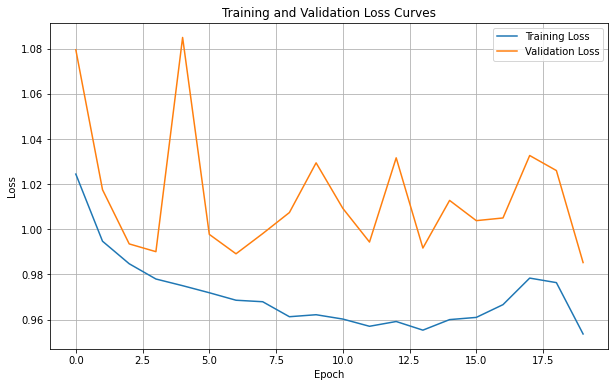

In [107]:
plt.figure(figsize=(10, 6))
plt.plot(train_loss_list, label='Training Loss')
plt.plot(val_loss_list, label='Validation Loss')
plt.title("Training and Validation Loss Curves")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()

In [11]:
test_dice = []
test_jaccard = []

model = UNet(in_channels=1, out_channels=1)
model.load_state_dict(torch.load("./best.pth"))
model.to(device)
model.eval()

with torch.no_grad():
    for images, masks in test_loader:
        images = images.to(device)
        masks = masks.to(device)
        outputs = model(images)
        preds = torch.sigmoid(outputs)
        
        # Flatten for metric calculation
        preds_flat = preds.view(-1)
        masks_flat = masks.view(-1)

        # Dice Score
        intersection = (preds_flat * masks_flat).sum()
        union = (preds_flat + masks_flat).sum() - intersection
        jaccard = intersection / union
        dice = (2. * intersection) / (preds_flat.sum() + masks_flat.sum() + 1e-10)
        
        test_dice.append(dice.item())
        test_jaccard.append(jaccard.item())

print(f"Mean Dice Score: {sum(test_dice)/len(test_dice):.4f}")
print(f"Mean Jaccard Score: {sum(test_jaccard)/len(test_jaccard):.4f}")

Mean Dice Score: 0.0841
Mean Jaccard Score: 0.0487


In [30]:
for i, img in enumerate(test_dice):
    print(i, img)

0 5.380418224376626e-05
1 5.402770693763159e-05
2 5.730829434469342e-05
3 5.5765180150046945e-05
4 5.3639687394024804e-05
5 5.403511386248283e-05
6 5.375257023843005e-05
7 5.342204531189054e-05
8 5.334938032319769e-05
9 5.547677574213594e-05
10 5.866141145816073e-05
11 5.5111646361183375e-05
12 5.367699850467034e-05
13 5.5197582696564496e-05
14 5.486293594003655e-05
15 5.258226883597672e-05
16 5.584714745054953e-05
17 5.0163118430646136e-05
18 5.2568364480976015e-05
19 5.304996739141643e-05
20 5.843936378369108e-05
21 5.1305141823831946e-05
22 5.633984983433038e-05
23 4.990813977201469e-05
24 5.0266946345800534e-05
25 5.5470380175393075e-05
26 5.41490844625514e-05
27 5.395547123043798e-05
28 5.3367479267762974e-05
29 5.599098585662432e-05
30 5.4869007726665586e-05
31 5.188190334592946e-05
32 5.330823114491068e-05
33 5.16117324877996e-05
34 5.4567379265790805e-05
35 5.518843317986466e-05
36 5.487255839398131e-05
37 5.467838127515279e-05
38 5.492970740306191e-05
39 5.517719910130836e-05


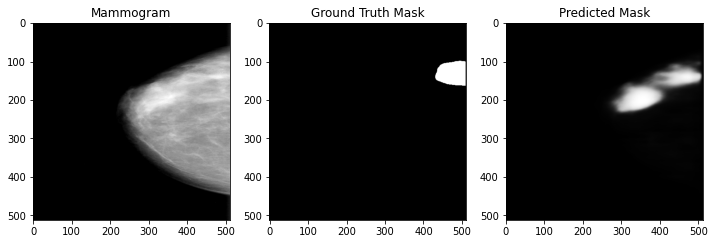

In [22]:
img, mask = get_nth_sample_from_loader(test_loader, 31) 
with torch.no_grad():
    output = model(img.to(device).unsqueeze(0))
    pred = torch.sigmoid(output)

    plt.figure(figsize=(12,4))
    plt.subplot(1,3,1)
    plt.imshow(img.squeeze().cpu(), cmap='gray')
    plt.title('Mammogram')
    plt.subplot(1,3,2)
    plt.imshow(mask.squeeze().cpu(), cmap='gray')
    plt.title('Ground Truth Mask')
    plt.subplot(1,3,3)
    plt.imshow(pred.squeeze().cpu(), cmap='gray')
    plt.title('Predicted Mask')
    plt.show()

Baseline with cmmd dataset

In [346]:
train_loss_list = []
val_loss_list = []
def train(model, train_loader, val_loader, epochs=50):
    best_val_loss = float("inf")

    for epoch in range(epochs):
        model.train()
        train_loss = 0.0
        for img, mask in tqdm(train_loader, desc=f"Epoch {epoch+1}"):
            img = img.to(device)
            mask = mask.to(device)
            optimizer.zero_grad()
            
            outputs = model(img)
            loss = criterion(outputs, mask)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

        avg_train_loss = train_loss / len(train_loader)
        train_loss_list.append(avg_train_loss)

        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for img, mask in tqdm(val_loader, desc=f"Epoch {epoch+1} Validation"):
                img = img.to(device)
                mask = mask.to(device)
                outputs = model(img)
                loss = criterion(outputs, mask)
                val_loss += loss.item()

        avg_val_loss = val_loss / len(val_loader)
        val_loss_list.append(avg_val_loss)
        
        

        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            torch.save(model.state_dict(), "normalise.pth")

        print(f"Epoch {epoch+1}/{epochs} | Train Loss: {avg_train_loss:.2f} | Val Loss : {avg_val_loss:.2f} | Best Val Loss : {best_val_loss:.2f}")

In [347]:
train(model, train_loader, val_loader, epochs=20)

Epoch 1 Validation: 100%|█████████████████████████████████████████████████████████████| 188/188 [02:39<00:00,  1.18it/s]


Epoch 1/20 | Train Loss: 1.01 | Val Loss : 1.10 | Best Val Loss : 1.10


Epoch 2 Validation: 100%|█████████████████████████████████████████████████████████████| 188/188 [02:38<00:00,  1.18it/s]


Epoch 2/20 | Train Loss: 0.99 | Val Loss : 1.02 | Best Val Loss : 1.02


Epoch 3 Validation: 100%|█████████████████████████████████████████████████████████████| 188/188 [01:23<00:00,  2.24it/s]


Epoch 3/20 | Train Loss: 0.98 | Val Loss : 2.15 | Best Val Loss : 1.02


Epoch 4 Validation: 100%|█████████████████████████████████████████████████████████████| 188/188 [01:23<00:00,  2.24it/s]


Epoch 4/20 | Train Loss: 0.98 | Val Loss : 1.05 | Best Val Loss : 1.02


Epoch 5 Validation: 100%|█████████████████████████████████████████████████████████████| 188/188 [01:23<00:00,  2.24it/s]


Epoch 5/20 | Train Loss: 0.98 | Val Loss : 1.05 | Best Val Loss : 1.02


Epoch 6 Validation: 100%|█████████████████████████████████████████████████████████████| 188/188 [01:23<00:00,  2.26it/s]


Epoch 6/20 | Train Loss: 0.98 | Val Loss : 1.03 | Best Val Loss : 1.02


Epoch 7 Validation: 100%|█████████████████████████████████████████████████████████████| 188/188 [02:17<00:00,  1.37it/s]


Epoch 7/20 | Train Loss: 0.98 | Val Loss : 1.04 | Best Val Loss : 1.02


Epoch 8 Validation: 100%|█████████████████████████████████████████████████████████████| 188/188 [01:23<00:00,  2.25it/s]


Epoch 8/20 | Train Loss: 0.97 | Val Loss : 1.03 | Best Val Loss : 1.02


Epoch 9 Validation: 100%|█████████████████████████████████████████████████████████████| 188/188 [01:22<00:00,  2.27it/s]


Epoch 9/20 | Train Loss: 0.96 | Val Loss : 1.02 | Best Val Loss : 1.02


Epoch 10 Validation: 100%|████████████████████████████████████████████████████████████| 188/188 [01:22<00:00,  2.27it/s]


Epoch 10/20 | Train Loss: 0.95 | Val Loss : 0.97 | Best Val Loss : 0.97


Epoch 11 Validation: 100%|████████████████████████████████████████████████████████████| 188/188 [01:23<00:00,  2.24it/s]


Epoch 11/20 | Train Loss: 0.95 | Val Loss : 0.99 | Best Val Loss : 0.97


Epoch 12 Validation: 100%|████████████████████████████████████████████████████████████| 188/188 [01:43<00:00,  1.82it/s]


Epoch 12/20 | Train Loss: 0.95 | Val Loss : 0.99 | Best Val Loss : 0.97


Epoch 13 Validation: 100%|████████████████████████████████████████████████████████████| 188/188 [01:54<00:00,  1.65it/s]


Epoch 13/20 | Train Loss: 0.94 | Val Loss : 0.96 | Best Val Loss : 0.96


Epoch 14 Validation: 100%|████████████████████████████████████████████████████████████| 188/188 [01:33<00:00,  2.00it/s]


Epoch 14/20 | Train Loss: 0.93 | Val Loss : 0.95 | Best Val Loss : 0.95


Epoch 15 Validation: 100%|████████████████████████████████████████████████████████████| 188/188 [01:33<00:00,  2.01it/s]


Epoch 15/20 | Train Loss: 0.92 | Val Loss : 0.96 | Best Val Loss : 0.95


Epoch 16 Validation: 100%|████████████████████████████████████████████████████████████| 188/188 [01:33<00:00,  2.00it/s]


Epoch 16/20 | Train Loss: 0.91 | Val Loss : 0.97 | Best Val Loss : 0.95


Epoch 17 Validation: 100%|████████████████████████████████████████████████████████████| 188/188 [01:33<00:00,  2.00it/s]


Epoch 17/20 | Train Loss: 0.91 | Val Loss : 0.98 | Best Val Loss : 0.95


Epoch 18 Validation: 100%|████████████████████████████████████████████████████████████| 188/188 [01:33<00:00,  2.01it/s]


Epoch 18/20 | Train Loss: 0.91 | Val Loss : 0.96 | Best Val Loss : 0.95


Epoch 19 Validation: 100%|████████████████████████████████████████████████████████████| 188/188 [01:33<00:00,  2.00it/s]


Epoch 19/20 | Train Loss: 0.90 | Val Loss : 0.95 | Best Val Loss : 0.95


Epoch 20 Validation: 100%|████████████████████████████████████████████████████████████| 188/188 [01:33<00:00,  2.01it/s]

Epoch 20/20 | Train Loss: 0.90 | Val Loss : 1.01 | Best Val Loss : 0.95


tensor([[[ 1.0000,  1.0000,  1.0000,  ..., -1.0000, -1.0000, -1.0000],
         [ 1.0000,  1.0000,  1.0000,  ..., -1.0000, -1.0000, -1.0000],
         [ 1.0000,  1.0000,  1.0000,  ..., -1.0000, -1.0000, -1.0000],
         ...,
         [ 0.9993,  0.8128, -0.2135,  ..., -1.0000, -1.0000, -1.0000],
         [ 1.0000,  0.8304, -0.2173,  ..., -1.0000, -1.0000, -1.0000],
         [ 1.0000,  0.8369, -0.2122,  ..., -1.0000, -1.0000, -1.0000]]])


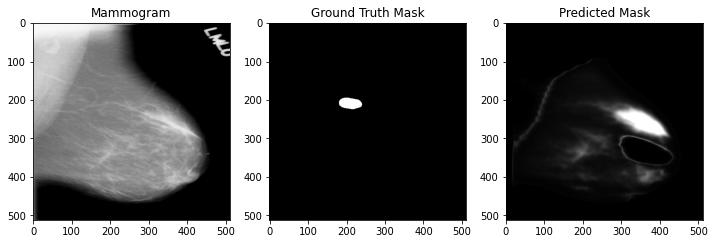

In [350]:
model = UNet(in_channels=1, out_channels=1)
model.load_state_dict(torch.load("./normalise.pth"))
model.to(device)
model.eval()
img, mask = get_nth_sample_from_loader(test_loader, 1) 
print(img)
with torch.no_grad():
    output = model(img.to(device).unsqueeze(0))
    pred = torch.sigmoid(output)

    plt.figure(figsize=(12,4))
    plt.subplot(1,3,1)
    plt.imshow(img.squeeze().cpu(), cmap='gray')
    plt.title('Mammogram')

    plt.subplot(1,3,2)
    plt.imshow(mask.squeeze().cpu(), cmap='gray')
    plt.title('Ground Truth Mask')
    plt.subplot(1,3,3)
    plt.imshow(pred.squeeze().cpu(), cmap='gray')
    plt.title('Predicted Mask')
    plt.show()

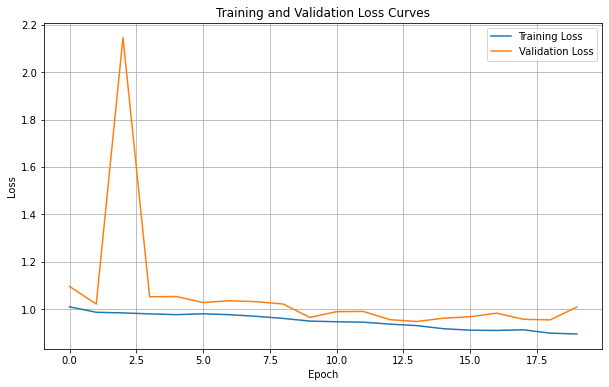

In [351]:
plt.figure(figsize=(10, 6))
plt.plot(train_loss_list, label='Training Loss')
plt.plot(val_loss_list, label='Validation Loss')
plt.title("Training and Validation Loss Curves")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()

In [355]:
test_dice = []
test_jaccard = []

model = UNet(in_channels=1, out_channels=1)
model.load_state_dict(torch.load("./normalise.pth"))
model.to(device)
model.eval()

with torch.no_grad():
    for images, masks in test_loader:
        images = images.to(device)
        masks = masks.to(device)
        outputs = model(images)
        preds = torch.sigmoid(outputs)
        
        # Flatten for metric calculation
        preds_flat = preds.view(-1)
        masks_flat = masks.view(-1)

        # Dice Score
        intersection = (preds_flat * masks_flat).sum()
        union = (preds_flat + masks_flat).sum() - intersection
        jaccard = intersection / union
        dice = (2. * intersection) / (preds_flat.sum() + masks_flat.sum() + 1e-10)
        
        test_dice.append(dice.item())
        test_jaccard.append(jaccard.item())

print(f"Mean Dice Score: {sum(test_dice)/len(test_dice):.4f}")
print(f"Mean Jaccard Score: {sum(test_jaccard)/len(test_jaccard):.4f}")

Mean Dice Score: 0.1425
Mean Jaccard Score: 0.0872


Clahe applied

In [12]:
train_loss_list = []
val_loss_list = []
def train(model, train_loader, epochs=50):
    best_val_loss = float("inf")

    for epoch in range(epochs):
        model.train()
        train_loss = 0.0
        for img, mask in tqdm(train_loader, desc=f"Epoch {epoch+1}"):
            img = img.to(device)
            mask = mask.to(device)

            optimizer.zero_grad()
            outputs = model(img)
            loss = criterion(outputs, mask)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

        avg_train_loss = train_loss / len(train_loader)
        train_loss_list.append(avg_train_loss)

        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for img, mask in tqdm(val_loader, desc=f"Epoch {epoch+1} Validation"):
                img = img.to(device)
                mask = mask.to(device)
                outputs = model(img)
                loss = criterion(outputs, mask)
                val_loss += loss.item()

        avg_val_loss = val_loss / len(val_loader)
        val_loss_list.append(avg_val_loss)
        
        

        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            torch.save(model.state_dict(), "clahe.pth")

        print(f"Epoch {epoch+1}/{epochs} | Train Loss: {avg_train_loss:.2f} | Val Loss : {avg_val_loss:.2f} | Best Val Loss : {best_val_loss:.2f}")

In [19]:
model = UNet(in_channels=1, out_channels=1)
model.load_state_dict(torch.load("./clahe.pth"))
model.to(device)
optimizer = optim.Adam(model.parameters(), lr=0.1)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=3)
criterion = DiceBCEFocalLoss()
train(model, train_loader, epochs=1)

Epoch 1 Validation: 100%|████████████████████████████████████████████████████████████| 188/188 [04:24<00:00,  1.41s/it]

Epoch 1/1 | Train Loss: 0.81 | Val Loss : 1.22 | Best Val Loss : 1.22


In [18]:
test_dice = []
test_jaccard = []

model = UNet(in_channels=1, out_channels=1)
model.load_state_dict(torch.load("./clahe.pth"))
model.to(device)
model.eval()

with torch.no_grad():
    for images, masks in test_loader:
        images = images.to(device)
        masks = masks.to(device)
        outputs = model(images)
        preds = torch.sigmoid(outputs)
        
        # Flatten for metric calculation
        preds_flat = preds.view(-1)
        masks_flat = masks.view(-1)

        # Dice Score
        intersection = (preds_flat * masks_flat).sum()
        union = (preds_flat + masks_flat).sum() - intersection
        jaccard = intersection / union
        dice = (2. * intersection) / (preds_flat.sum() + masks_flat.sum() + 1e-10)
        
        test_dice.append(dice.item())
        test_jaccard.append(jaccard.item())

print(f"Mean Dice Score: {sum(test_dice)/len(test_dice):.4f}")
print(f"Mean Jaccard Score: {sum(test_jaccard)/len(test_jaccard):.4f}")

Mean Dice Score: 0.1842
Mean Jaccard Score: 0.1217


In [13]:
for i, img in enumerate(test_dice):
    print(i, img)

0 0.3733092248439789
1 0.01050038356333971
2 0.054747309535741806
3 0.4460931420326233
4 0.007162738125771284
5 0.004264243878424168
6 0.014947198331356049
7 0.2734690010547638
8 0.46555274724960327
9 0.004071071743965149
10 0.06313144415616989
11 0.003714370308443904
12 0.6717633008956909
13 0.022910408675670624
14 0.00275797164067626
15 0.006146155763417482
16 0.55473792552948
17 0.008887182921171188
18 0.12839272618293762
19 0.08374644070863724
20 0.27033519744873047
21 0.0012547734659165144
22 0.2181500345468521
23 0.2968236207962036
24 0.1424795240163803
25 0.7014606595039368
26 0.2174876481294632
27 0.01470554806292057
28 0.5486695766448975
29 0.014270592480897903
30 0.0037804131861776114
31 0.297386109828949
32 0.8596885204315186
33 0.2837439179420471
34 0.008958776481449604
35 0.09526997059583664
36 0.14694920182228088
37 0.338800847530365
38 0.0697270929813385
39 0.00139338755980134
40 0.216698557138443
41 0.6109752655029297
42 0.2104204297065735
43 0.023726535961031914
44 0.1

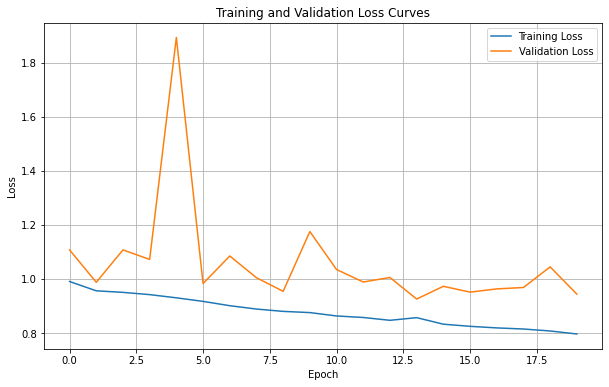

In [377]:
plt.figure(figsize=(10, 6))
plt.plot(train_loss_list, label='Training Loss')
plt.plot(val_loss_list, label='Validation Loss')
plt.title("Training and Validation Loss Curves")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()

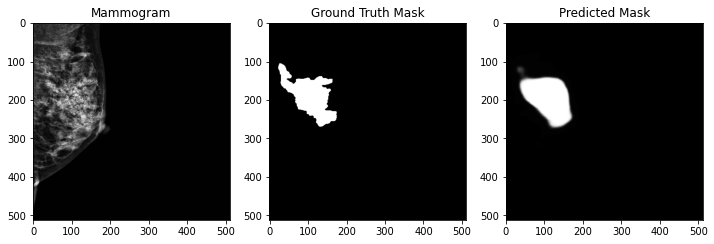

In [16]:
img, mask = get_nth_sample_from_loader(test_loader, 46) 
with torch.no_grad():
    output = model(img.to(device).unsqueeze(0))
    pred = torch.sigmoid(output)

    plt.figure(figsize=(12,4))
    plt.subplot(1,3,1)
    plt.imshow(img.squeeze().cpu(), cmap='gray')
    plt.title('Mammogram')

    plt.subplot(1,3,2)
    plt.imshow(mask.squeeze().cpu(), cmap='gray')
    plt.title('Ground Truth Mask')
    plt.subplot(1,3,3)
    plt.imshow(pred.squeeze().cpu(), cmap='gray')
    plt.title('Predicted Mask')
    plt.show()

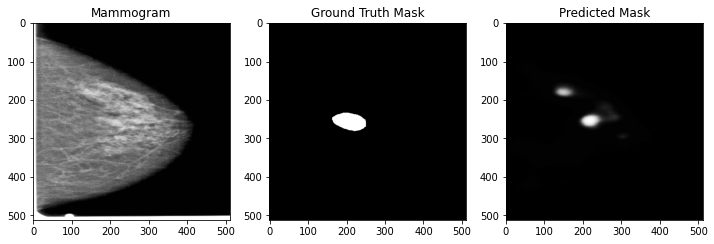

In [19]:
img, mask = get_nth_sample_from_loader(test_loader, 0) 
with torch.no_grad():
    output = model(img.to(device).unsqueeze(0))
    pred = torch.sigmoid(output)

    plt.figure(figsize=(12,4))
    plt.subplot(1,3,1)
    plt.imshow(img.squeeze().cpu(), cmap='gray')
    plt.title('Mammogram')

    plt.subplot(1,3,2)
    plt.imshow(mask.squeeze().cpu(), cmap='gray')
    plt.title('Ground Truth Mask')
    plt.subplot(1,3,3)
    plt.imshow(pred.squeeze().cpu(), cmap='gray')
    plt.title('Predicted Mask')
    plt.show()

# More Testing

In [45]:
model = UNet(in_channels=1, out_channels=1)
model.load_state_dict(torch.load("./288AllV2newTest"))
model.to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-5, weight_decay=1e-4)
criterion = DiceBCEFocalLoss()
train(model, train_loader, val_loader, epochs=100, filename="288AllV2newTestP2")

Epoch 1 Validation: 100%|████████████████████████████████████████████████████████████| 188/188 [01:06<00:00,  2.82it/s]


Epoch 1/100 | Train Loss: 0.6792 | Val Loss: 0.7638 | Best Val Loss: 0.7638 | Train Dice (0.5): 0.4326 | Val Dice (0.5): 0.3533 | Best Threshold: 0.45 | Best Dice: 0.3942


Epoch 2 Validation: 100%|████████████████████████████████████████████████████████████| 188/188 [01:06<00:00,  2.85it/s]


Epoch 2/100 | Train Loss: 0.6727 | Val Loss: 0.7648 | Best Val Loss: 0.7638 | Train Dice (0.5): 0.4364 | Val Dice (0.5): 0.3513 | Best Threshold: 0.40 | Best Dice: 0.3940


Epoch 3 Validation: 100%|████████████████████████████████████████████████████████████| 188/188 [01:04<00:00,  2.92it/s]


Epoch 3/100 | Train Loss: 0.6694 | Val Loss: 0.7661 | Best Val Loss: 0.7638 | Train Dice (0.5): 0.4388 | Val Dice (0.5): 0.3494 | Best Threshold: 0.45 | Best Dice: 0.3943


Epoch 4 Validation: 100%|████████████████████████████████████████████████████████████| 188/188 [01:06<00:00,  2.81it/s]


Epoch 4/100 | Train Loss: 0.6667 | Val Loss: 0.7675 | Best Val Loss: 0.7638 | Train Dice (0.5): 0.4407 | Val Dice (0.5): 0.3484 | Best Threshold: 0.45 | Best Dice: 0.3941


Epoch 5 Validation: 100%|████████████████████████████████████████████████████████████| 188/188 [01:08<00:00,  2.76it/s]


Epoch 5/100 | Train Loss: 0.6642 | Val Loss: 0.7675 | Best Val Loss: 0.7638 | Train Dice (0.5): 0.4428 | Val Dice (0.5): 0.3484 | Best Threshold: 0.50 | Best Dice: 0.3943


Epoch 6 Validation: 100%|████████████████████████████████████████████████████████████| 188/188 [01:07<00:00,  2.79it/s]


Epoch 6/100 | Train Loss: 0.6621 | Val Loss: 0.7676 | Best Val Loss: 0.7638 | Train Dice (0.5): 0.4441 | Val Dice (0.5): 0.3490 | Best Threshold: 0.50 | Best Dice: 0.3954


Epoch 7 Validation: 100%|████████████████████████████████████████████████████████████| 188/188 [01:05<00:00,  2.85it/s]


Epoch 7/100 | Train Loss: 0.6603 | Val Loss: 0.7685 | Best Val Loss: 0.7638 | Train Dice (0.5): 0.4456 | Val Dice (0.5): 0.3487 | Best Threshold: 0.55 | Best Dice: 0.3957


Epoch 8 Validation: 100%|████████████████████████████████████████████████████████████| 188/188 [01:06<00:00,  2.81it/s]


Epoch 8/100 | Train Loss: 0.6586 | Val Loss: 0.7690 | Best Val Loss: 0.7638 | Train Dice (0.5): 0.4469 | Val Dice (0.5): 0.3478 | Best Threshold: 0.55 | Best Dice: 0.3946


Epoch 9:  69%|███████████████████████████████████████████████▊                     | 1111/1604 [06:39<02:57,  2.78it/s]


KeyboardInterrupt: 

In [127]:
model = UNet(in_channels=1, out_channels=1).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)
criterion = DiceBCEFocalLoss().to(device)
train(model, train_loader, val_loader, epochs=100, filename="288AllV3newTest")

Epoch 1 Validation: 100%|████████████████████████████████████████████████████████████| 188/188 [01:15<00:00,  2.48it/s]


Epoch 1/100 | Train Loss: 1.2357 | Val Loss: 1.1834 | Best Val Loss: 1.1834 | Train Dice (0.5): 0.1189 | Val Dice (0.5): 0.0737 | Best Threshold: 0.50 | Best Dice: 0.0911


Epoch 2 Validation: 100%|████████████████████████████████████████████████████████████| 188/188 [01:24<00:00,  2.23it/s]


Epoch 2/100 | Train Loss: 1.1399 | Val Loss: 1.1133 | Best Val Loss: 1.1133 | Train Dice (0.5): 0.1071 | Val Dice (0.5): 0.0907 | Best Threshold: 0.45 | Best Dice: 0.1479


Epoch 3 Validation: 100%|████████████████████████████████████████████████████████████| 188/188 [01:14<00:00,  2.51it/s]


Epoch 3/100 | Train Loss: 1.0825 | Val Loss: 1.0692 | Best Val Loss: 1.0692 | Train Dice (0.5): 0.1222 | Val Dice (0.5): 0.1288 | Best Threshold: 0.55 | Best Dice: 0.1690


Epoch 4 Validation: 100%|████████████████████████████████████████████████████████████| 188/188 [01:05<00:00,  2.87it/s]


Epoch 4/100 | Train Loss: 1.0394 | Val Loss: 1.0365 | Best Val Loss: 1.0365 | Train Dice (0.5): 0.1479 | Val Dice (0.5): 0.1277 | Best Threshold: 0.45 | Best Dice: 0.1506


Epoch 5 Validation: 100%|████████████████████████████████████████████████████████████| 188/188 [01:03<00:00,  2.95it/s]


Epoch 5/100 | Train Loss: 1.0060 | Val Loss: 1.0049 | Best Val Loss: 1.0049 | Train Dice (0.5): 0.1634 | Val Dice (0.5): 0.1422 | Best Threshold: 0.55 | Best Dice: 0.1850


Epoch 6 Validation: 100%|████████████████████████████████████████████████████████████| 188/188 [01:04<00:00,  2.94it/s]


Epoch 6/100 | Train Loss: 0.9783 | Val Loss: 0.9806 | Best Val Loss: 0.9806 | Train Dice (0.5): 0.1756 | Val Dice (0.5): 0.1388 | Best Threshold: 0.50 | Best Dice: 0.1874


Epoch 7 Validation: 100%|████████████████████████████████████████████████████████████| 188/188 [01:03<00:00,  2.95it/s]


Epoch 7/100 | Train Loss: 0.9552 | Val Loss: 0.9655 | Best Val Loss: 0.9655 | Train Dice (0.5): 0.1778 | Val Dice (0.5): 0.1408 | Best Threshold: 0.60 | Best Dice: 0.1834


Epoch 8 Validation: 100%|████████████████████████████████████████████████████████████| 188/188 [01:02<00:00,  2.99it/s]


Epoch 8/100 | Train Loss: 0.9395 | Val Loss: 0.9541 | Best Val Loss: 0.9541 | Train Dice (0.5): 0.1755 | Val Dice (0.5): 0.1486 | Best Threshold: 0.50 | Best Dice: 0.1991


Epoch 9 Validation: 100%|████████████████████████████████████████████████████████████| 188/188 [01:04<00:00,  2.92it/s]


Epoch 9/100 | Train Loss: 0.9223 | Val Loss: 0.9346 | Best Val Loss: 0.9346 | Train Dice (0.5): 0.1869 | Val Dice (0.5): 0.1573 | Best Threshold: 0.45 | Best Dice: 0.2042


Epoch 10 Validation: 100%|███████████████████████████████████████████████████████████| 188/188 [01:04<00:00,  2.92it/s]


Epoch 10/100 | Train Loss: 0.8999 | Val Loss: 0.9130 | Best Val Loss: 0.9130 | Train Dice (0.5): 0.2046 | Val Dice (0.5): 0.1875 | Best Threshold: 0.60 | Best Dice: 0.2234


Epoch 11 Validation: 100%|███████████████████████████████████████████████████████████| 188/188 [01:02<00:00,  2.99it/s]


Epoch 11/100 | Train Loss: 0.8814 | Val Loss: 0.9039 | Best Val Loss: 0.9039 | Train Dice (0.5): 0.2209 | Val Dice (0.5): 0.1869 | Best Threshold: 0.55 | Best Dice: 0.2265


Epoch 12 Validation: 100%|███████████████████████████████████████████████████████████| 188/188 [01:03<00:00,  2.98it/s]


Epoch 12/100 | Train Loss: 0.8639 | Val Loss: 0.8972 | Best Val Loss: 0.8972 | Train Dice (0.5): 0.2351 | Val Dice (0.5): 0.1892 | Best Threshold: 0.60 | Best Dice: 0.2222


Epoch 13 Validation: 100%|███████████████████████████████████████████████████████████| 188/188 [01:02<00:00,  3.00it/s]


Epoch 13/100 | Train Loss: 0.8569 | Val Loss: 0.8700 | Best Val Loss: 0.8700 | Train Dice (0.5): 0.2378 | Val Dice (0.5): 0.2178 | Best Threshold: 0.60 | Best Dice: 0.2501


Epoch 14 Validation: 100%|███████████████████████████████████████████████████████████| 188/188 [01:03<00:00,  2.96it/s]


Epoch 14/100 | Train Loss: 0.8476 | Val Loss: 0.8804 | Best Val Loss: 0.8700 | Train Dice (0.5): 0.2448 | Val Dice (0.5): 0.2020 | Best Threshold: 0.70 | Best Dice: 0.2383


Epoch 15 Validation: 100%|███████████████████████████████████████████████████████████| 188/188 [01:01<00:00,  3.04it/s]


Epoch 15/100 | Train Loss: 0.8351 | Val Loss: 0.8508 | Best Val Loss: 0.8508 | Train Dice (0.5): 0.2562 | Val Dice (0.5): 0.2272 | Best Threshold: 0.25 | Best Dice: 0.2583


Epoch 16 Validation: 100%|███████████████████████████████████████████████████████████| 188/188 [01:03<00:00,  2.95it/s]


Epoch 16/100 | Train Loss: 0.8223 | Val Loss: 0.8364 | Best Val Loss: 0.8364 | Train Dice (0.5): 0.2666 | Val Dice (0.5): 0.2414 | Best Threshold: 0.50 | Best Dice: 0.2710


Epoch 17 Validation: 100%|███████████████████████████████████████████████████████████| 188/188 [01:09<00:00,  2.70it/s]


Epoch 17/100 | Train Loss: 0.8130 | Val Loss: 0.8262 | Best Val Loss: 0.8262 | Train Dice (0.5): 0.2728 | Val Dice (0.5): 0.2502 | Best Threshold: 0.10 | Best Dice: 0.2936


Epoch 18 Validation: 100%|███████████████████████████████████████████████████████████| 188/188 [01:09<00:00,  2.70it/s]


Epoch 18/100 | Train Loss: 0.8058 | Val Loss: 0.8237 | Best Val Loss: 0.8237 | Train Dice (0.5): 0.2787 | Val Dice (0.5): 0.2532 | Best Threshold: 0.55 | Best Dice: 0.2886


Epoch 19 Validation: 100%|███████████████████████████████████████████████████████████| 188/188 [01:08<00:00,  2.73it/s]


Epoch 19/100 | Train Loss: 0.8036 | Val Loss: 0.8131 | Best Val Loss: 0.8131 | Train Dice (0.5): 0.2803 | Val Dice (0.5): 0.2607 | Best Threshold: 0.35 | Best Dice: 0.2950


Epoch 20 Validation: 100%|███████████████████████████████████████████████████████████| 188/188 [01:09<00:00,  2.70it/s]


Epoch 20/100 | Train Loss: 0.7927 | Val Loss: 0.7955 | Best Val Loss: 0.7955 | Train Dice (0.5): 0.2917 | Val Dice (0.5): 0.2793 | Best Threshold: 0.25 | Best Dice: 0.3066


Epoch 21 Validation: 100%|███████████████████████████████████████████████████████████| 188/188 [01:09<00:00,  2.71it/s]


Epoch 21/100 | Train Loss: 0.7879 | Val Loss: 0.7875 | Best Val Loss: 0.7875 | Train Dice (0.5): 0.2949 | Val Dice (0.5): 0.2875 | Best Threshold: 0.30 | Best Dice: 0.3099


Epoch 22 Validation: 100%|███████████████████████████████████████████████████████████| 188/188 [01:09<00:00,  2.69it/s]


Epoch 22/100 | Train Loss: 0.7830 | Val Loss: 0.8106 | Best Val Loss: 0.7875 | Train Dice (0.5): 0.2994 | Val Dice (0.5): 0.2620 | Best Threshold: 0.10 | Best Dice: 0.3083


Epoch 23 Validation: 100%|███████████████████████████████████████████████████████████| 188/188 [01:09<00:00,  2.69it/s]


Epoch 23/100 | Train Loss: 0.7713 | Val Loss: 0.7888 | Best Val Loss: 0.7875 | Train Dice (0.5): 0.3122 | Val Dice (0.5): 0.2826 | Best Threshold: 0.50 | Best Dice: 0.3179


Epoch 24 Validation: 100%|███████████████████████████████████████████████████████████| 188/188 [01:09<00:00,  2.70it/s]


Epoch 24/100 | Train Loss: 0.7669 | Val Loss: 0.7839 | Best Val Loss: 0.7839 | Train Dice (0.5): 0.3144 | Val Dice (0.5): 0.2891 | Best Threshold: 0.40 | Best Dice: 0.3246


Epoch 25 Validation: 100%|███████████████████████████████████████████████████████████| 188/188 [01:09<00:00,  2.72it/s]


Epoch 25/100 | Train Loss: 0.7626 | Val Loss: 0.7783 | Best Val Loss: 0.7783 | Train Dice (0.5): 0.3187 | Val Dice (0.5): 0.2917 | Best Threshold: 0.15 | Best Dice: 0.3217


Epoch 26 Validation: 100%|███████████████████████████████████████████████████████████| 188/188 [01:18<00:00,  2.38it/s]


Epoch 26/100 | Train Loss: 0.7558 | Val Loss: 0.7846 | Best Val Loss: 0.7783 | Train Dice (0.5): 0.3244 | Val Dice (0.5): 0.2861 | Best Threshold: 0.05 | Best Dice: 0.3114


Epoch 27 Validation: 100%|███████████████████████████████████████████████████████████| 188/188 [01:17<00:00,  2.43it/s]


Epoch 27/100 | Train Loss: 0.7526 | Val Loss: 0.7763 | Best Val Loss: 0.7763 | Train Dice (0.5): 0.3279 | Val Dice (0.5): 0.2938 | Best Threshold: 0.50 | Best Dice: 0.3275


Epoch 28 Validation: 100%|███████████████████████████████████████████████████████████| 188/188 [01:26<00:00,  2.18it/s]


Epoch 28/100 | Train Loss: 0.7526 | Val Loss: 0.7698 | Best Val Loss: 0.7698 | Train Dice (0.5): 0.3284 | Val Dice (0.5): 0.2975 | Best Threshold: 0.35 | Best Dice: 0.3240


Epoch 29 Validation: 100%|███████████████████████████████████████████████████████████| 188/188 [01:03<00:00,  2.95it/s]


Epoch 29/100 | Train Loss: 0.7428 | Val Loss: 0.7649 | Best Val Loss: 0.7649 | Train Dice (0.5): 0.3376 | Val Dice (0.5): 0.3057 | Best Threshold: 0.05 | Best Dice: 0.3272


Epoch 30 Validation: 100%|███████████████████████████████████████████████████████████| 188/188 [01:05<00:00,  2.89it/s]


Epoch 30/100 | Train Loss: 0.7347 | Val Loss: 0.7655 | Best Val Loss: 0.7649 | Train Dice (0.5): 0.3447 | Val Dice (0.5): 0.3020 | Best Threshold: 0.05 | Best Dice: 0.3389


Epoch 31 Validation: 100%|███████████████████████████████████████████████████████████| 188/188 [01:04<00:00,  2.90it/s]


Epoch 31/100 | Train Loss: 0.7447 | Val Loss: 0.7752 | Best Val Loss: 0.7649 | Train Dice (0.5): 0.3352 | Val Dice (0.5): 0.2940 | Best Threshold: 0.10 | Best Dice: 0.3239


Epoch 32 Validation: 100%|███████████████████████████████████████████████████████████| 188/188 [01:04<00:00,  2.92it/s]


Epoch 32/100 | Train Loss: 0.7300 | Val Loss: 0.7757 | Best Val Loss: 0.7649 | Train Dice (0.5): 0.3494 | Val Dice (0.5): 0.2955 | Best Threshold: 0.05 | Best Dice: 0.3389


Epoch 33 Validation: 100%|███████████████████████████████████████████████████████████| 188/188 [01:04<00:00,  2.91it/s]


Epoch 33/100 | Train Loss: 0.7232 | Val Loss: 0.7560 | Best Val Loss: 0.7560 | Train Dice (0.5): 0.3557 | Val Dice (0.5): 0.3107 | Best Threshold: 0.05 | Best Dice: 0.3464


Epoch 34 Validation: 100%|███████████████████████████████████████████████████████████| 188/188 [01:04<00:00,  2.91it/s]


Epoch 34/100 | Train Loss: 0.7161 | Val Loss: 0.7652 | Best Val Loss: 0.7560 | Train Dice (0.5): 0.3623 | Val Dice (0.5): 0.2993 | Best Threshold: 0.35 | Best Dice: 0.3381


Epoch 35 Validation: 100%|███████████████████████████████████████████████████████████| 188/188 [01:04<00:00,  2.90it/s]


Epoch 35/100 | Train Loss: 0.7198 | Val Loss: 0.7603 | Best Val Loss: 0.7560 | Train Dice (0.5): 0.3606 | Val Dice (0.5): 0.3080 | Best Threshold: 0.05 | Best Dice: 0.3366


Epoch 36 Validation: 100%|███████████████████████████████████████████████████████████| 188/188 [01:04<00:00,  2.91it/s]


Epoch 36/100 | Train Loss: 0.7124 | Val Loss: 0.7521 | Best Val Loss: 0.7521 | Train Dice (0.5): 0.3672 | Val Dice (0.5): 0.3141 | Best Threshold: 0.10 | Best Dice: 0.3430


Epoch 37 Validation: 100%|███████████████████████████████████████████████████████████| 188/188 [01:04<00:00,  2.91it/s]


Epoch 37/100 | Train Loss: 0.7098 | Val Loss: 0.7628 | Best Val Loss: 0.7521 | Train Dice (0.5): 0.3689 | Val Dice (0.5): 0.3023 | Best Threshold: 0.15 | Best Dice: 0.3500


Epoch 38 Validation: 100%|███████████████████████████████████████████████████████████| 188/188 [01:05<00:00,  2.87it/s]


Epoch 38/100 | Train Loss: 0.7024 | Val Loss: 0.7527 | Best Val Loss: 0.7521 | Train Dice (0.5): 0.3766 | Val Dice (0.5): 0.3143 | Best Threshold: 0.15 | Best Dice: 0.3611


Epoch 39 Validation: 100%|███████████████████████████████████████████████████████████| 188/188 [01:05<00:00,  2.89it/s]


Epoch 39/100 | Train Loss: 0.7015 | Val Loss: 0.7410 | Best Val Loss: 0.7410 | Train Dice (0.5): 0.3758 | Val Dice (0.5): 0.3286 | Best Threshold: 0.05 | Best Dice: 0.3536


Epoch 40 Validation: 100%|███████████████████████████████████████████████████████████| 188/188 [01:10<00:00,  2.65it/s]


Epoch 40/100 | Train Loss: 0.6959 | Val Loss: 0.7550 | Best Val Loss: 0.7410 | Train Dice (0.5): 0.3821 | Val Dice (0.5): 0.3146 | Best Threshold: 0.05 | Best Dice: 0.3580


Epoch 41 Validation: 100%|███████████████████████████████████████████████████████████| 188/188 [01:04<00:00,  2.91it/s]


Epoch 41/100 | Train Loss: 0.7088 | Val Loss: 0.7675 | Best Val Loss: 0.7410 | Train Dice (0.5): 0.3685 | Val Dice (0.5): 0.2990 | Best Threshold: 0.50 | Best Dice: 0.3425


Epoch 42 Validation: 100%|███████████████████████████████████████████████████████████| 188/188 [01:11<00:00,  2.64it/s]


Epoch 42/100 | Train Loss: 0.7006 | Val Loss: 0.7387 | Best Val Loss: 0.7387 | Train Dice (0.5): 0.3772 | Val Dice (0.5): 0.3264 | Best Threshold: 0.05 | Best Dice: 0.3657


Epoch 43 Validation: 100%|███████████████████████████████████████████████████████████| 188/188 [01:23<00:00,  2.25it/s]


Epoch 43/100 | Train Loss: 0.6869 | Val Loss: 0.7509 | Best Val Loss: 0.7387 | Train Dice (0.5): 0.3907 | Val Dice (0.5): 0.3168 | Best Threshold: 0.10 | Best Dice: 0.3663


Epoch 44 Validation: 100%|███████████████████████████████████████████████████████████| 188/188 [01:04<00:00,  2.90it/s]


Epoch 44/100 | Train Loss: 0.6837 | Val Loss: 0.7403 | Best Val Loss: 0.7387 | Train Dice (0.5): 0.3923 | Val Dice (0.5): 0.3289 | Best Threshold: 0.10 | Best Dice: 0.3521


Epoch 45 Validation: 100%|███████████████████████████████████████████████████████████| 188/188 [01:30<00:00,  2.07it/s]


Epoch 45/100 | Train Loss: 0.6761 | Val Loss: 0.7446 | Best Val Loss: 0.7387 | Train Dice (0.5): 0.3997 | Val Dice (0.5): 0.3264 | Best Threshold: 0.05 | Best Dice: 0.3483


Epoch 46 Validation: 100%|███████████████████████████████████████████████████████████| 188/188 [01:05<00:00,  2.86it/s]


Epoch 46/100 | Train Loss: 0.6827 | Val Loss: 0.7461 | Best Val Loss: 0.7387 | Train Dice (0.5): 0.3928 | Val Dice (0.5): 0.3221 | Best Threshold: 0.05 | Best Dice: 0.3482


Epoch 47 Validation: 100%|███████████████████████████████████████████████████████████| 188/188 [01:04<00:00,  2.93it/s]


Epoch 47/100 | Train Loss: 0.6711 | Val Loss: 0.7440 | Best Val Loss: 0.7387 | Train Dice (0.5): 0.4050 | Val Dice (0.5): 0.3217 | Best Threshold: 0.05 | Best Dice: 0.3689


Epoch 48 Validation: 100%|███████████████████████████████████████████████████████████| 188/188 [01:04<00:00,  2.90it/s]


Epoch 48/100 | Train Loss: 0.6753 | Val Loss: 0.7449 | Best Val Loss: 0.7387 | Train Dice (0.5): 0.3989 | Val Dice (0.5): 0.3254 | Best Threshold: 0.40 | Best Dice: 0.3733


Epoch 49 Validation: 100%|███████████████████████████████████████████████████████████| 188/188 [01:12<00:00,  2.58it/s]


Epoch 49/100 | Train Loss: 0.6699 | Val Loss: 0.7576 | Best Val Loss: 0.7387 | Train Dice (0.5): 0.4058 | Val Dice (0.5): 0.3129 | Best Threshold: 0.15 | Best Dice: 0.3653


Epoch 50 Validation: 100%|███████████████████████████████████████████████████████████| 188/188 [01:06<00:00,  2.85it/s]


Epoch 50/100 | Train Loss: 0.6645 | Val Loss: 0.7503 | Best Val Loss: 0.7387 | Train Dice (0.5): 0.4106 | Val Dice (0.5): 0.3184 | Best Threshold: 0.15 | Best Dice: 0.3716


Epoch 51 Validation: 100%|███████████████████████████████████████████████████████████| 188/188 [01:06<00:00,  2.81it/s]


Epoch 51/100 | Train Loss: 0.6598 | Val Loss: 0.7414 | Best Val Loss: 0.7387 | Train Dice (0.5): 0.4147 | Val Dice (0.5): 0.3255 | Best Threshold: 0.15 | Best Dice: 0.3870


Epoch 52 Validation: 100%|███████████████████████████████████████████████████████████| 188/188 [01:05<00:00,  2.88it/s]


Epoch 52/100 | Train Loss: 0.6545 | Val Loss: 0.7363 | Best Val Loss: 0.7363 | Train Dice (0.5): 0.4195 | Val Dice (0.5): 0.3297 | Best Threshold: 0.05 | Best Dice: 0.3880


Epoch 53 Validation: 100%|███████████████████████████████████████████████████████████| 188/188 [01:05<00:00,  2.89it/s]


Epoch 53/100 | Train Loss: 0.6518 | Val Loss: 0.7483 | Best Val Loss: 0.7363 | Train Dice (0.5): 0.4224 | Val Dice (0.5): 0.3193 | Best Threshold: 0.05 | Best Dice: 0.3743


Epoch 54 Validation: 100%|███████████████████████████████████████████████████████████| 188/188 [01:05<00:00,  2.86it/s]


Epoch 54/100 | Train Loss: 0.6549 | Val Loss: 0.7512 | Best Val Loss: 0.7363 | Train Dice (0.5): 0.4180 | Val Dice (0.5): 0.3156 | Best Threshold: 0.05 | Best Dice: 0.3642


Epoch 55 Validation: 100%|███████████████████████████████████████████████████████████| 188/188 [01:05<00:00,  2.89it/s]


Epoch 55/100 | Train Loss: 0.6457 | Val Loss: 0.7406 | Best Val Loss: 0.7363 | Train Dice (0.5): 0.4269 | Val Dice (0.5): 0.3253 | Best Threshold: 0.05 | Best Dice: 0.3873


Epoch 56 Validation: 100%|███████████████████████████████████████████████████████████| 188/188 [01:05<00:00,  2.87it/s]


Epoch 56/100 | Train Loss: 0.6413 | Val Loss: 0.7398 | Best Val Loss: 0.7363 | Train Dice (0.5): 0.4330 | Val Dice (0.5): 0.3262 | Best Threshold: 0.10 | Best Dice: 0.3782


Epoch 57:  19%|█████████████▍                                                       | 312/1604 [01:58<08:10,  2.64it/s]

KeyboardInterrupt



In [38]:
model = UNet(in_channels=1, out_channels=1).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)
criterion = DiceBCEFocalLoss().to(device)
train(model, train_loader, val_loader, epochs=100, filename="288AllV1newTest")

Epoch 1 Validation: 100%|████████████████████████████████████████████████████████████| 188/188 [01:04<00:00,  2.92it/s]


Epoch 1/100 | Train Loss: 1.0211 | Val Loss: 0.9800 | Best Val Loss: 0.9800 | Train Dice (0.5): 0.0001 | Val Dice (0.5): 0.0000 | Best Threshold: 0.40 | Best Dice: 0.1905


Epoch 2 Validation: 100%|████████████████████████████████████████████████████████████| 188/188 [01:04<00:00,  2.93it/s]


Epoch 2/100 | Train Loss: 0.9778 | Val Loss: 0.9716 | Best Val Loss: 0.9716 | Train Dice (0.5): 0.1092 | Val Dice (0.5): 0.1462 | Best Threshold: 0.50 | Best Dice: 0.1866


Epoch 3 Validation: 100%|████████████████████████████████████████████████████████████| 188/188 [01:04<00:00,  2.93it/s]


Epoch 3/100 | Train Loss: 0.9630 | Val Loss: 0.9672 | Best Val Loss: 0.9672 | Train Dice (0.5): 0.1460 | Val Dice (0.5): 0.1129 | Best Threshold: 0.35 | Best Dice: 0.1892


Epoch 4 Validation: 100%|████████████████████████████████████████████████████████████| 188/188 [01:04<00:00,  2.91it/s]


Epoch 4/100 | Train Loss: 0.9576 | Val Loss: 0.9711 | Best Val Loss: 0.9672 | Train Dice (0.5): 0.1531 | Val Dice (0.5): 0.1486 | Best Threshold: 0.55 | Best Dice: 0.1935


Epoch 5 Validation: 100%|████████████████████████████████████████████████████████████| 188/188 [01:04<00:00,  2.90it/s]


Epoch 5/100 | Train Loss: 0.9547 | Val Loss: 0.9666 | Best Val Loss: 0.9666 | Train Dice (0.5): 0.1540 | Val Dice (0.5): 0.1085 | Best Threshold: 0.30 | Best Dice: 0.1974


Epoch 6 Validation: 100%|████████████████████████████████████████████████████████████| 188/188 [01:14<00:00,  2.53it/s]


Epoch 6/100 | Train Loss: 0.9493 | Val Loss: 0.9597 | Best Val Loss: 0.9597 | Train Dice (0.5): 0.1598 | Val Dice (0.5): 0.1518 | Best Threshold: 0.50 | Best Dice: 0.1979


Epoch 7 Validation: 100%|████████████████████████████████████████████████████████████| 188/188 [01:08<00:00,  2.76it/s]


Epoch 7/100 | Train Loss: 0.9400 | Val Loss: 0.9606 | Best Val Loss: 0.9597 | Train Dice (0.5): 0.1760 | Val Dice (0.5): 0.1368 | Best Threshold: 0.20 | Best Dice: 0.1945


Epoch 8 Validation: 100%|████████████████████████████████████████████████████████████| 188/188 [01:17<00:00,  2.43it/s]


Epoch 8/100 | Train Loss: 0.9283 | Val Loss: 0.9595 | Best Val Loss: 0.9595 | Train Dice (0.5): 0.1887 | Val Dice (0.5): 0.1436 | Best Threshold: 0.45 | Best Dice: 0.2176


Epoch 9 Validation: 100%|████████████████████████████████████████████████████████████| 188/188 [01:05<00:00,  2.89it/s]


Epoch 9/100 | Train Loss: 0.9123 | Val Loss: 0.9351 | Best Val Loss: 0.9351 | Train Dice (0.5): 0.2120 | Val Dice (0.5): 0.1574 | Best Threshold: 0.30 | Best Dice: 0.2381


Epoch 10 Validation: 100%|███████████████████████████████████████████████████████████| 188/188 [01:06<00:00,  2.84it/s]


Epoch 10/100 | Train Loss: 0.9033 | Val Loss: 0.9261 | Best Val Loss: 0.9261 | Train Dice (0.5): 0.2290 | Val Dice (0.5): 0.1882 | Best Threshold: 0.25 | Best Dice: 0.2325


Epoch 11 Validation: 100%|███████████████████████████████████████████████████████████| 188/188 [01:13<00:00,  2.55it/s]


Epoch 11/100 | Train Loss: 0.8912 | Val Loss: 0.8910 | Best Val Loss: 0.8910 | Train Dice (0.5): 0.2400 | Val Dice (0.5): 0.2247 | Best Threshold: 0.25 | Best Dice: 0.2629


Epoch 12 Validation: 100%|███████████████████████████████████████████████████████████| 188/188 [01:14<00:00,  2.51it/s]


Epoch 12/100 | Train Loss: 0.8789 | Val Loss: 0.8904 | Best Val Loss: 0.8904 | Train Dice (0.5): 0.2560 | Val Dice (0.5): 0.2264 | Best Threshold: 0.40 | Best Dice: 0.2784


Epoch 13 Validation: 100%|███████████████████████████████████████████████████████████| 188/188 [01:03<00:00,  2.94it/s]


Epoch 13/100 | Train Loss: 0.8768 | Val Loss: 0.9242 | Best Val Loss: 0.8904 | Train Dice (0.5): 0.2606 | Val Dice (0.5): 0.1977 | Best Threshold: 0.10 | Best Dice: 0.2355


Epoch 14 Validation: 100%|███████████████████████████████████████████████████████████| 188/188 [01:03<00:00,  2.96it/s]


Epoch 14/100 | Train Loss: 0.8646 | Val Loss: 0.8881 | Best Val Loss: 0.8881 | Train Dice (0.5): 0.2708 | Val Dice (0.5): 0.2358 | Best Threshold: 0.45 | Best Dice: 0.2856


Epoch 15 Validation: 100%|███████████████████████████████████████████████████████████| 188/188 [01:05<00:00,  2.89it/s]


Epoch 15/100 | Train Loss: 0.8589 | Val Loss: 0.8709 | Best Val Loss: 0.8709 | Train Dice (0.5): 0.2767 | Val Dice (0.5): 0.2553 | Best Threshold: 0.65 | Best Dice: 0.3027


Epoch 16 Validation: 100%|███████████████████████████████████████████████████████████| 188/188 [01:03<00:00,  2.98it/s]


Epoch 16/100 | Train Loss: 0.8547 | Val Loss: 0.8588 | Best Val Loss: 0.8588 | Train Dice (0.5): 0.2794 | Val Dice (0.5): 0.2617 | Best Threshold: 0.50 | Best Dice: 0.3032


Epoch 17 Validation: 100%|███████████████████████████████████████████████████████████| 188/188 [01:03<00:00,  2.94it/s]


Epoch 17/100 | Train Loss: 0.8468 | Val Loss: 0.8594 | Best Val Loss: 0.8588 | Train Dice (0.5): 0.2890 | Val Dice (0.5): 0.2675 | Best Threshold: 0.65 | Best Dice: 0.3211


Epoch 18 Validation: 100%|███████████████████████████████████████████████████████████| 188/188 [01:04<00:00,  2.89it/s]


Epoch 18/100 | Train Loss: 0.8422 | Val Loss: 0.8547 | Best Val Loss: 0.8547 | Train Dice (0.5): 0.2948 | Val Dice (0.5): 0.2665 | Best Threshold: 0.35 | Best Dice: 0.3125


Epoch 19 Validation: 100%|███████████████████████████████████████████████████████████| 188/188 [01:03<00:00,  2.95it/s]


Epoch 19/100 | Train Loss: 0.8418 | Val Loss: 0.8540 | Best Val Loss: 0.8540 | Train Dice (0.5): 0.2948 | Val Dice (0.5): 0.2669 | Best Threshold: 0.55 | Best Dice: 0.3091


Epoch 20 Validation: 100%|███████████████████████████████████████████████████████████| 188/188 [01:03<00:00,  2.94it/s]


Epoch 20/100 | Train Loss: 0.8360 | Val Loss: 0.8452 | Best Val Loss: 0.8452 | Train Dice (0.5): 0.3012 | Val Dice (0.5): 0.2776 | Best Threshold: 0.10 | Best Dice: 0.3101


Epoch 21 Validation: 100%|███████████████████████████████████████████████████████████| 188/188 [01:04<00:00,  2.93it/s]


Epoch 21/100 | Train Loss: 0.8330 | Val Loss: 0.8389 | Best Val Loss: 0.8389 | Train Dice (0.5): 0.3025 | Val Dice (0.5): 0.2826 | Best Threshold: 0.50 | Best Dice: 0.3292


Epoch 22 Validation: 100%|███████████████████████████████████████████████████████████| 188/188 [01:03<00:00,  2.96it/s]


Epoch 22/100 | Train Loss: 0.8274 | Val Loss: 0.8313 | Best Val Loss: 0.8313 | Train Dice (0.5): 0.3085 | Val Dice (0.5): 0.2903 | Best Threshold: 0.40 | Best Dice: 0.3538


Epoch 23 Validation: 100%|███████████████████████████████████████████████████████████| 188/188 [01:04<00:00,  2.93it/s]


Epoch 23/100 | Train Loss: 0.8213 | Val Loss: 0.8283 | Best Val Loss: 0.8283 | Train Dice (0.5): 0.3137 | Val Dice (0.5): 0.2874 | Best Threshold: 0.35 | Best Dice: 0.3385


Epoch 24 Validation: 100%|███████████████████████████████████████████████████████████| 188/188 [01:03<00:00,  2.96it/s]


Epoch 24/100 | Train Loss: 0.8233 | Val Loss: 0.8583 | Best Val Loss: 0.8283 | Train Dice (0.5): 0.3108 | Val Dice (0.5): 0.2643 | Best Threshold: 0.75 | Best Dice: 0.3106


Epoch 25 Validation: 100%|███████████████████████████████████████████████████████████| 188/188 [01:04<00:00,  2.93it/s]


Epoch 25/100 | Train Loss: 0.8183 | Val Loss: 0.8148 | Best Val Loss: 0.8148 | Train Dice (0.5): 0.3174 | Val Dice (0.5): 0.3014 | Best Threshold: 0.35 | Best Dice: 0.3453


Epoch 26 Validation: 100%|███████████████████████████████████████████████████████████| 188/188 [01:03<00:00,  2.94it/s]


Epoch 26/100 | Train Loss: 0.8131 | Val Loss: 0.8516 | Best Val Loss: 0.8148 | Train Dice (0.5): 0.3228 | Val Dice (0.5): 0.2617 | Best Threshold: 0.05 | Best Dice: 0.3302


Epoch 27 Validation: 100%|███████████████████████████████████████████████████████████| 188/188 [01:03<00:00,  2.95it/s]


Epoch 27/100 | Train Loss: 0.8127 | Val Loss: 0.8216 | Best Val Loss: 0.8148 | Train Dice (0.5): 0.3233 | Val Dice (0.5): 0.2979 | Best Threshold: 0.30 | Best Dice: 0.3455


Epoch 28 Validation: 100%|███████████████████████████████████████████████████████████| 188/188 [01:04<00:00,  2.92it/s]


Epoch 28/100 | Train Loss: 0.8084 | Val Loss: 0.8276 | Best Val Loss: 0.8148 | Train Dice (0.5): 0.3283 | Val Dice (0.5): 0.2908 | Best Threshold: 0.60 | Best Dice: 0.3337


Epoch 29 Validation: 100%|███████████████████████████████████████████████████████████| 188/188 [01:04<00:00,  2.91it/s]


Epoch 29/100 | Train Loss: 0.8049 | Val Loss: 0.8241 | Best Val Loss: 0.8148 | Train Dice (0.5): 0.3324 | Val Dice (0.5): 0.2979 | Best Threshold: 0.15 | Best Dice: 0.3409


Epoch 30 Validation: 100%|███████████████████████████████████████████████████████████| 188/188 [01:03<00:00,  2.95it/s]


Epoch 30/100 | Train Loss: 0.8070 | Val Loss: 0.8377 | Best Val Loss: 0.8148 | Train Dice (0.5): 0.3294 | Val Dice (0.5): 0.2775 | Best Threshold: 0.50 | Best Dice: 0.3332


Epoch 31 Validation: 100%|███████████████████████████████████████████████████████████| 188/188 [01:03<00:00,  2.95it/s]


Epoch 31/100 | Train Loss: 0.8007 | Val Loss: 0.8175 | Best Val Loss: 0.8148 | Train Dice (0.5): 0.3343 | Val Dice (0.5): 0.3004 | Best Threshold: 0.10 | Best Dice: 0.3378


Epoch 32 Validation: 100%|███████████████████████████████████████████████████████████| 188/188 [01:04<00:00,  2.92it/s]


Epoch 32/100 | Train Loss: 0.8019 | Val Loss: 0.8333 | Best Val Loss: 0.8148 | Train Dice (0.5): 0.3334 | Val Dice (0.5): 0.2873 | Best Threshold: 0.75 | Best Dice: 0.3428


Epoch 33 Validation: 100%|███████████████████████████████████████████████████████████| 188/188 [01:03<00:00,  2.94it/s]


Epoch 33/100 | Train Loss: 0.7972 | Val Loss: 0.8225 | Best Val Loss: 0.8148 | Train Dice (0.5): 0.3390 | Val Dice (0.5): 0.2954 | Best Threshold: 0.25 | Best Dice: 0.3336


Epoch 34 Validation: 100%|███████████████████████████████████████████████████████████| 188/188 [01:04<00:00,  2.94it/s]


Epoch 34/100 | Train Loss: 0.7943 | Val Loss: 0.8475 | Best Val Loss: 0.8148 | Train Dice (0.5): 0.3407 | Val Dice (0.5): 0.2756 | Best Threshold: 0.05 | Best Dice: 0.3076


Epoch 35 Validation: 100%|███████████████████████████████████████████████████████████| 188/188 [01:04<00:00,  2.92it/s]


Epoch 35/100 | Train Loss: 0.7969 | Val Loss: 0.8110 | Best Val Loss: 0.8110 | Train Dice (0.5): 0.3392 | Val Dice (0.5): 0.3023 | Best Threshold: 0.15 | Best Dice: 0.3497


Epoch 36 Validation: 100%|███████████████████████████████████████████████████████████| 188/188 [01:04<00:00,  2.90it/s]


Epoch 36/100 | Train Loss: 0.8013 | Val Loss: 0.8200 | Best Val Loss: 0.8110 | Train Dice (0.5): 0.3334 | Val Dice (0.5): 0.2962 | Best Threshold: 0.15 | Best Dice: 0.3289


Epoch 37 Validation: 100%|███████████████████████████████████████████████████████████| 188/188 [01:04<00:00,  2.92it/s]


Epoch 37/100 | Train Loss: 0.7891 | Val Loss: 0.8274 | Best Val Loss: 0.8110 | Train Dice (0.5): 0.3447 | Val Dice (0.5): 0.2873 | Best Threshold: 0.20 | Best Dice: 0.3332


Epoch 38 Validation: 100%|███████████████████████████████████████████████████████████| 188/188 [01:04<00:00,  2.93it/s]


Epoch 38/100 | Train Loss: 0.7883 | Val Loss: 0.8213 | Best Val Loss: 0.8110 | Train Dice (0.5): 0.3463 | Val Dice (0.5): 0.2982 | Best Threshold: 0.65 | Best Dice: 0.3397


Epoch 39 Validation: 100%|███████████████████████████████████████████████████████████| 188/188 [01:03<00:00,  2.95it/s]


Epoch 39/100 | Train Loss: 0.7847 | Val Loss: 0.8254 | Best Val Loss: 0.8110 | Train Dice (0.5): 0.3499 | Val Dice (0.5): 0.2915 | Best Threshold: 0.55 | Best Dice: 0.3462


Epoch 40 Validation: 100%|███████████████████████████████████████████████████████████| 188/188 [01:08<00:00,  2.75it/s]


Epoch 40/100 | Train Loss: 0.7849 | Val Loss: 0.8108 | Best Val Loss: 0.8108 | Train Dice (0.5): 0.3476 | Val Dice (0.5): 0.3035 | Best Threshold: 0.40 | Best Dice: 0.3526


Epoch 41 Validation: 100%|███████████████████████████████████████████████████████████| 188/188 [01:07<00:00,  2.78it/s]


Epoch 41/100 | Train Loss: 0.7783 | Val Loss: 0.8305 | Best Val Loss: 0.8108 | Train Dice (0.5): 0.3545 | Val Dice (0.5): 0.2913 | Best Threshold: 0.55 | Best Dice: 0.3479


Epoch 42 Validation: 100%|███████████████████████████████████████████████████████████| 188/188 [01:06<00:00,  2.84it/s]


Epoch 42/100 | Train Loss: 0.7784 | Val Loss: 0.8156 | Best Val Loss: 0.8108 | Train Dice (0.5): 0.3547 | Val Dice (0.5): 0.3048 | Best Threshold: 0.20 | Best Dice: 0.3548


Epoch 43 Validation: 100%|███████████████████████████████████████████████████████████| 188/188 [01:08<00:00,  2.75it/s]


Epoch 43/100 | Train Loss: 0.7743 | Val Loss: 0.8305 | Best Val Loss: 0.8108 | Train Dice (0.5): 0.3576 | Val Dice (0.5): 0.2844 | Best Threshold: 0.05 | Best Dice: 0.3257


Epoch 44 Validation: 100%|███████████████████████████████████████████████████████████| 188/188 [01:08<00:00,  2.76it/s]


Epoch 44/100 | Train Loss: 0.7767 | Val Loss: 0.8091 | Best Val Loss: 0.8091 | Train Dice (0.5): 0.3551 | Val Dice (0.5): 0.3052 | Best Threshold: 0.05 | Best Dice: 0.3560


Epoch 45 Validation: 100%|███████████████████████████████████████████████████████████| 188/188 [01:08<00:00,  2.75it/s]


Epoch 45/100 | Train Loss: 0.7729 | Val Loss: 0.8161 | Best Val Loss: 0.8091 | Train Dice (0.5): 0.3584 | Val Dice (0.5): 0.2971 | Best Threshold: 0.15 | Best Dice: 0.3468


Epoch 46 Validation: 100%|███████████████████████████████████████████████████████████| 188/188 [01:08<00:00,  2.76it/s]


Epoch 46/100 | Train Loss: 0.7700 | Val Loss: 0.8249 | Best Val Loss: 0.8091 | Train Dice (0.5): 0.3614 | Val Dice (0.5): 0.2901 | Best Threshold: 0.05 | Best Dice: 0.3328


Epoch 47 Validation: 100%|███████████████████████████████████████████████████████████| 188/188 [01:08<00:00,  2.74it/s]


Epoch 47/100 | Train Loss: 0.7682 | Val Loss: 0.8085 | Best Val Loss: 0.8085 | Train Dice (0.5): 0.3619 | Val Dice (0.5): 0.3032 | Best Threshold: 0.10 | Best Dice: 0.3587


Epoch 48 Validation: 100%|███████████████████████████████████████████████████████████| 188/188 [01:08<00:00,  2.75it/s]


Epoch 48/100 | Train Loss: 0.7622 | Val Loss: 0.8204 | Best Val Loss: 0.8085 | Train Dice (0.5): 0.3673 | Val Dice (0.5): 0.3006 | Best Threshold: 0.05 | Best Dice: 0.3315


Epoch 49 Validation: 100%|███████████████████████████████████████████████████████████| 188/188 [01:07<00:00,  2.79it/s]


Epoch 49/100 | Train Loss: 0.7646 | Val Loss: 0.8141 | Best Val Loss: 0.8085 | Train Dice (0.5): 0.3658 | Val Dice (0.5): 0.3017 | Best Threshold: 0.05 | Best Dice: 0.3375


Epoch 50 Validation: 100%|███████████████████████████████████████████████████████████| 188/188 [01:07<00:00,  2.78it/s]


Epoch 50/100 | Train Loss: 0.7585 | Val Loss: 0.8117 | Best Val Loss: 0.8085 | Train Dice (0.5): 0.3707 | Val Dice (0.5): 0.3030 | Best Threshold: 0.05 | Best Dice: 0.3594


Epoch 51 Validation: 100%|███████████████████████████████████████████████████████████| 188/188 [01:08<00:00,  2.76it/s]


Epoch 51/100 | Train Loss: 0.7584 | Val Loss: 0.8128 | Best Val Loss: 0.8085 | Train Dice (0.5): 0.3709 | Val Dice (0.5): 0.2977 | Best Threshold: 0.05 | Best Dice: 0.3410


Epoch 52 Validation: 100%|███████████████████████████████████████████████████████████| 188/188 [01:07<00:00,  2.79it/s]


Epoch 52/100 | Train Loss: 0.7562 | Val Loss: 0.8065 | Best Val Loss: 0.8065 | Train Dice (0.5): 0.3720 | Val Dice (0.5): 0.3058 | Best Threshold: 0.05 | Best Dice: 0.3683


Epoch 53 Validation: 100%|███████████████████████████████████████████████████████████| 188/188 [01:06<00:00,  2.84it/s]


Epoch 53/100 | Train Loss: 0.7498 | Val Loss: 0.8068 | Best Val Loss: 0.8065 | Train Dice (0.5): 0.3781 | Val Dice (0.5): 0.3067 | Best Threshold: 0.05 | Best Dice: 0.3683


Epoch 54 Validation: 100%|███████████████████████████████████████████████████████████| 188/188 [01:04<00:00,  2.93it/s]


Epoch 54/100 | Train Loss: 0.7489 | Val Loss: 0.8041 | Best Val Loss: 0.8041 | Train Dice (0.5): 0.3770 | Val Dice (0.5): 0.3110 | Best Threshold: 0.10 | Best Dice: 0.3538


Epoch 55 Validation: 100%|███████████████████████████████████████████████████████████| 188/188 [01:05<00:00,  2.89it/s]


Epoch 55/100 | Train Loss: 0.7488 | Val Loss: 0.8046 | Best Val Loss: 0.8041 | Train Dice (0.5): 0.3774 | Val Dice (0.5): 0.3103 | Best Threshold: 0.10 | Best Dice: 0.3662


Epoch 56 Validation: 100%|███████████████████████████████████████████████████████████| 188/188 [01:08<00:00,  2.75it/s]


Epoch 56/100 | Train Loss: 0.7425 | Val Loss: 0.7998 | Best Val Loss: 0.7998 | Train Dice (0.5): 0.3828 | Val Dice (0.5): 0.3122 | Best Threshold: 0.10 | Best Dice: 0.3666


Epoch 57 Validation: 100%|███████████████████████████████████████████████████████████| 188/188 [01:07<00:00,  2.79it/s]


Epoch 57/100 | Train Loss: 0.7399 | Val Loss: 0.9092 | Best Val Loss: 0.7998 | Train Dice (0.5): 0.3835 | Val Dice (0.5): 0.2082 | Best Threshold: 0.15 | Best Dice: 0.2885


Epoch 58 Validation: 100%|███████████████████████████████████████████████████████████| 188/188 [01:05<00:00,  2.88it/s]


Epoch 58/100 | Train Loss: 0.7421 | Val Loss: 0.8126 | Best Val Loss: 0.7998 | Train Dice (0.5): 0.3821 | Val Dice (0.5): 0.2953 | Best Threshold: 0.05 | Best Dice: 0.3768


Epoch 59 Validation: 100%|███████████████████████████████████████████████████████████| 188/188 [01:06<00:00,  2.81it/s]


Epoch 59/100 | Train Loss: 0.7365 | Val Loss: 0.7961 | Best Val Loss: 0.7961 | Train Dice (0.5): 0.3874 | Val Dice (0.5): 0.3180 | Best Threshold: 0.10 | Best Dice: 0.3750


Epoch 60 Validation: 100%|███████████████████████████████████████████████████████████| 188/188 [01:04<00:00,  2.90it/s]


Epoch 60/100 | Train Loss: 0.7372 | Val Loss: 0.7992 | Best Val Loss: 0.7961 | Train Dice (0.5): 0.3847 | Val Dice (0.5): 0.3169 | Best Threshold: 0.15 | Best Dice: 0.3554


Epoch 61 Validation: 100%|███████████████████████████████████████████████████████████| 188/188 [01:06<00:00,  2.84it/s]


Epoch 61/100 | Train Loss: 0.7313 | Val Loss: 0.8080 | Best Val Loss: 0.7961 | Train Dice (0.5): 0.3909 | Val Dice (0.5): 0.3064 | Best Threshold: 0.10 | Best Dice: 0.3563


Epoch 62 Validation: 100%|███████████████████████████████████████████████████████████| 188/188 [01:04<00:00,  2.93it/s]


Epoch 62/100 | Train Loss: 0.7278 | Val Loss: 0.8248 | Best Val Loss: 0.7961 | Train Dice (0.5): 0.3953 | Val Dice (0.5): 0.2895 | Best Threshold: 0.10 | Best Dice: 0.3407


Epoch 63 Validation: 100%|███████████████████████████████████████████████████████████| 188/188 [01:08<00:00,  2.76it/s]


Epoch 63/100 | Train Loss: 0.7310 | Val Loss: 0.8036 | Best Val Loss: 0.7961 | Train Dice (0.5): 0.3893 | Val Dice (0.5): 0.3085 | Best Threshold: 0.15 | Best Dice: 0.3670


Epoch 64 Validation: 100%|███████████████████████████████████████████████████████████| 188/188 [01:05<00:00,  2.87it/s]


Epoch 64/100 | Train Loss: 0.7255 | Val Loss: 0.8091 | Best Val Loss: 0.7961 | Train Dice (0.5): 0.3968 | Val Dice (0.5): 0.3142 | Best Threshold: 0.60 | Best Dice: 0.3724


Epoch 65 Validation: 100%|███████████████████████████████████████████████████████████| 188/188 [01:14<00:00,  2.51it/s]


Epoch 65/100 | Train Loss: 0.7228 | Val Loss: 0.8053 | Best Val Loss: 0.7961 | Train Dice (0.5): 0.3980 | Val Dice (0.5): 0.3119 | Best Threshold: 0.30 | Best Dice: 0.3406


Epoch 66 Validation: 100%|███████████████████████████████████████████████████████████| 188/188 [01:05<00:00,  2.86it/s]


Epoch 66/100 | Train Loss: 0.7190 | Val Loss: 0.8253 | Best Val Loss: 0.7961 | Train Dice (0.5): 0.4000 | Val Dice (0.5): 0.2993 | Best Threshold: 0.40 | Best Dice: 0.3460


Epoch 67 Validation: 100%|███████████████████████████████████████████████████████████| 188/188 [01:15<00:00,  2.50it/s]


Epoch 67/100 | Train Loss: 0.7171 | Val Loss: 0.8100 | Best Val Loss: 0.7961 | Train Dice (0.5): 0.4025 | Val Dice (0.5): 0.3060 | Best Threshold: 0.20 | Best Dice: 0.3735


Epoch 68 Validation: 100%|███████████████████████████████████████████████████████████| 188/188 [01:27<00:00,  2.15it/s]


Epoch 68/100 | Train Loss: 0.7157 | Val Loss: 0.8282 | Best Val Loss: 0.7961 | Train Dice (0.5): 0.4033 | Val Dice (0.5): 0.3048 | Best Threshold: 0.65 | Best Dice: 0.3759


Epoch 69 Validation: 100%|███████████████████████████████████████████████████████████| 188/188 [01:06<00:00,  2.84it/s]


Epoch 69/100 | Train Loss: 0.7236 | Val Loss: 0.7966 | Best Val Loss: 0.7961 | Train Dice (0.5): 0.3969 | Val Dice (0.5): 0.3145 | Best Threshold: 0.20 | Best Dice: 0.3772


Epoch 70 Validation: 100%|███████████████████████████████████████████████████████████| 188/188 [01:04<00:00,  2.90it/s]


Epoch 70/100 | Train Loss: 0.7139 | Val Loss: 0.8080 | Best Val Loss: 0.7961 | Train Dice (0.5): 0.4057 | Val Dice (0.5): 0.3035 | Best Threshold: 0.15 | Best Dice: 0.3402


Epoch 71:   0%|▎                                                                      | 8/1604 [00:04<14:59,  1.77it/s]


KeyboardInterrupt: 

In [16]:
model = UNet(in_channels=1, out_channels=1).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-4)
criterion = DiceBCEFocalLoss()
train(model, train_loader, val_loader, epochs=100, filename="288AllV1")

Epoch 1 Validation: 100%|████████████████████████████████████████████████████████████| 188/188 [01:13<00:00,  2.56it/s]


Epoch 1/100 | Train Loss: 1.07 | Val Loss : 1.05 | Best Val Loss : 1.05 | Train Dice: 0.02 | Val Dice: 0.00 


Epoch 2 Validation: 100%|████████████████████████████████████████████████████████████| 188/188 [01:07<00:00,  2.77it/s]


Epoch 2/100 | Train Loss: 1.01 | Val Loss : 1.04 | Best Val Loss : 1.04 | Train Dice: 0.03 | Val Dice: 0.00 


Epoch 3 Validation: 100%|████████████████████████████████████████████████████████████| 188/188 [01:07<00:00,  2.77it/s]


Epoch 3/100 | Train Loss: 1.00 | Val Loss : 1.02 | Best Val Loss : 1.02 | Train Dice: 0.04 | Val Dice: 0.00 


Epoch 4 Validation: 100%|████████████████████████████████████████████████████████████| 188/188 [01:07<00:00,  2.77it/s]


Epoch 4/100 | Train Loss: 0.99 | Val Loss : 1.02 | Best Val Loss : 1.02 | Train Dice: 0.06 | Val Dice: 0.02 


Epoch 5 Validation: 100%|████████████████████████████████████████████████████████████| 188/188 [01:07<00:00,  2.77it/s]


Epoch 5/100 | Train Loss: 0.98 | Val Loss : 1.01 | Best Val Loss : 1.01 | Train Dice: 0.07 | Val Dice: 0.08 


Epoch 6 Validation: 100%|████████████████████████████████████████████████████████████| 188/188 [01:08<00:00,  2.76it/s]


Epoch 6/100 | Train Loss: 0.97 | Val Loss : 1.01 | Best Val Loss : 1.01 | Train Dice: 0.08 | Val Dice: 0.09 


Epoch 7 Validation: 100%|████████████████████████████████████████████████████████████| 188/188 [01:08<00:00,  2.76it/s]


Epoch 7/100 | Train Loss: 0.96 | Val Loss : 0.99 | Best Val Loss : 0.99 | Train Dice: 0.09 | Val Dice: 0.13 


Epoch 8 Validation: 100%|████████████████████████████████████████████████████████████| 188/188 [01:07<00:00,  2.77it/s]


Epoch 8/100 | Train Loss: 0.96 | Val Loss : 0.99 | Best Val Loss : 0.99 | Train Dice: 0.11 | Val Dice: 0.13 


Epoch 9 Validation: 100%|████████████████████████████████████████████████████████████| 188/188 [01:08<00:00,  2.75it/s]


Epoch 9/100 | Train Loss: 0.95 | Val Loss : 0.98 | Best Val Loss : 0.98 | Train Dice: 0.13 | Val Dice: 0.15 


Epoch 10 Validation: 100%|███████████████████████████████████████████████████████████| 188/188 [01:07<00:00,  2.77it/s]


Epoch 10/100 | Train Loss: 0.94 | Val Loss : 0.99 | Best Val Loss : 0.98 | Train Dice: 0.15 | Val Dice: 0.15 


Epoch 11 Validation: 100%|███████████████████████████████████████████████████████████| 188/188 [01:07<00:00,  2.77it/s]


Epoch 11/100 | Train Loss: 0.92 | Val Loss : 0.97 | Best Val Loss : 0.97 | Train Dice: 0.18 | Val Dice: 0.15 


Epoch 12 Validation: 100%|███████████████████████████████████████████████████████████| 188/188 [01:07<00:00,  2.77it/s]


Epoch 12/100 | Train Loss: 0.91 | Val Loss : 0.99 | Best Val Loss : 0.97 | Train Dice: 0.19 | Val Dice: 0.14 


Epoch 13 Validation: 100%|███████████████████████████████████████████████████████████| 188/188 [01:08<00:00,  2.76it/s]


Epoch 13/100 | Train Loss: 0.91 | Val Loss : 0.98 | Best Val Loss : 0.97 | Train Dice: 0.19 | Val Dice: 0.16 


Epoch 14 Validation: 100%|███████████████████████████████████████████████████████████| 188/188 [01:07<00:00,  2.77it/s]


Epoch 14/100 | Train Loss: 0.90 | Val Loss : 0.97 | Best Val Loss : 0.97 | Train Dice: 0.21 | Val Dice: 0.16 


Epoch 15 Validation: 100%|███████████████████████████████████████████████████████████| 188/188 [01:07<00:00,  2.77it/s]


Epoch 15/100 | Train Loss: 0.89 | Val Loss : 0.97 | Best Val Loss : 0.97 | Train Dice: 0.21 | Val Dice: 0.17 


Epoch 16 Validation: 100%|███████████████████████████████████████████████████████████| 188/188 [01:07<00:00,  2.77it/s]


Epoch 16/100 | Train Loss: 0.90 | Val Loss : 0.96 | Best Val Loss : 0.96 | Train Dice: 0.21 | Val Dice: 0.16 


Epoch 17 Validation: 100%|███████████████████████████████████████████████████████████| 188/188 [01:07<00:00,  2.77it/s]


Epoch 17/100 | Train Loss: 0.89 | Val Loss : 0.94 | Best Val Loss : 0.94 | Train Dice: 0.22 | Val Dice: 0.19 


Epoch 18 Validation: 100%|███████████████████████████████████████████████████████████| 188/188 [01:08<00:00,  2.76it/s]


Epoch 18/100 | Train Loss: 0.88 | Val Loss : 0.95 | Best Val Loss : 0.94 | Train Dice: 0.23 | Val Dice: 0.18 


Epoch 19 Validation: 100%|███████████████████████████████████████████████████████████| 188/188 [01:08<00:00,  2.76it/s]


Epoch 19/100 | Train Loss: 0.88 | Val Loss : 0.93 | Best Val Loss : 0.93 | Train Dice: 0.23 | Val Dice: 0.20 


Epoch 20 Validation: 100%|███████████████████████████████████████████████████████████| 188/188 [01:07<00:00,  2.77it/s]


Epoch 20/100 | Train Loss: 0.87 | Val Loss : 0.93 | Best Val Loss : 0.93 | Train Dice: 0.24 | Val Dice: 0.20 


Epoch 21 Validation: 100%|███████████████████████████████████████████████████████████| 188/188 [01:07<00:00,  2.77it/s]


Epoch 21/100 | Train Loss: 0.87 | Val Loss : 0.91 | Best Val Loss : 0.91 | Train Dice: 0.24 | Val Dice: 0.22 


Epoch 22 Validation: 100%|███████████████████████████████████████████████████████████| 188/188 [01:08<00:00,  2.76it/s]


Epoch 22/100 | Train Loss: 0.87 | Val Loss : 0.92 | Best Val Loss : 0.91 | Train Dice: 0.24 | Val Dice: 0.21 


Epoch 23 Validation: 100%|███████████████████████████████████████████████████████████| 188/188 [01:08<00:00,  2.76it/s]


Epoch 23/100 | Train Loss: 0.86 | Val Loss : 0.91 | Best Val Loss : 0.91 | Train Dice: 0.25 | Val Dice: 0.22 


Epoch 24 Validation: 100%|███████████████████████████████████████████████████████████| 188/188 [01:07<00:00,  2.78it/s]


Epoch 24/100 | Train Loss: 0.86 | Val Loss : 0.90 | Best Val Loss : 0.90 | Train Dice: 0.25 | Val Dice: 0.22 


Epoch 25 Validation: 100%|███████████████████████████████████████████████████████████| 188/188 [01:07<00:00,  2.78it/s]


Epoch 25/100 | Train Loss: 0.86 | Val Loss : 0.89 | Best Val Loss : 0.89 | Train Dice: 0.25 | Val Dice: 0.23 


Epoch 26 Validation: 100%|███████████████████████████████████████████████████████████| 188/188 [01:07<00:00,  2.79it/s]


Epoch 26/100 | Train Loss: 0.85 | Val Loss : 0.89 | Best Val Loss : 0.89 | Train Dice: 0.27 | Val Dice: 0.23 


Epoch 27 Validation: 100%|███████████████████████████████████████████████████████████| 188/188 [01:07<00:00,  2.78it/s]


Epoch 27/100 | Train Loss: 0.85 | Val Loss : 0.89 | Best Val Loss : 0.89 | Train Dice: 0.27 | Val Dice: 0.23 


Epoch 28 Validation: 100%|███████████████████████████████████████████████████████████| 188/188 [01:07<00:00,  2.78it/s]


Epoch 28/100 | Train Loss: 0.85 | Val Loss : 0.89 | Best Val Loss : 0.89 | Train Dice: 0.27 | Val Dice: 0.24 


Epoch 29 Validation: 100%|███████████████████████████████████████████████████████████| 188/188 [01:07<00:00,  2.79it/s]


Epoch 29/100 | Train Loss: 0.85 | Val Loss : 0.89 | Best Val Loss : 0.89 | Train Dice: 0.27 | Val Dice: 0.24 


Epoch 30 Validation: 100%|███████████████████████████████████████████████████████████| 188/188 [01:07<00:00,  2.78it/s]


Epoch 30/100 | Train Loss: 0.84 | Val Loss : 0.89 | Best Val Loss : 0.89 | Train Dice: 0.27 | Val Dice: 0.24 


Epoch 31 Validation: 100%|███████████████████████████████████████████████████████████| 188/188 [01:07<00:00,  2.78it/s]


Epoch 31/100 | Train Loss: 0.84 | Val Loss : 0.89 | Best Val Loss : 0.89 | Train Dice: 0.27 | Val Dice: 0.24 


Epoch 32 Validation: 100%|███████████████████████████████████████████████████████████| 188/188 [01:07<00:00,  2.78it/s]


Epoch 32/100 | Train Loss: 0.84 | Val Loss : 0.86 | Best Val Loss : 0.86 | Train Dice: 0.28 | Val Dice: 0.26 


Epoch 33 Validation: 100%|███████████████████████████████████████████████████████████| 188/188 [01:08<00:00,  2.76it/s]


Epoch 33/100 | Train Loss: 0.83 | Val Loss : 0.90 | Best Val Loss : 0.86 | Train Dice: 0.28 | Val Dice: 0.23 


Epoch 34 Validation: 100%|███████████████████████████████████████████████████████████| 188/188 [01:08<00:00,  2.73it/s]


Epoch 34/100 | Train Loss: 0.84 | Val Loss : 0.87 | Best Val Loss : 0.86 | Train Dice: 0.27 | Val Dice: 0.25 


Epoch 35 Validation: 100%|███████████████████████████████████████████████████████████| 188/188 [01:07<00:00,  2.77it/s]


Epoch 35/100 | Train Loss: 0.83 | Val Loss : 0.88 | Best Val Loss : 0.86 | Train Dice: 0.28 | Val Dice: 0.24 


Epoch 36 Validation: 100%|███████████████████████████████████████████████████████████| 188/188 [01:07<00:00,  2.77it/s]


Epoch 36/100 | Train Loss: 0.83 | Val Loss : 0.85 | Best Val Loss : 0.85 | Train Dice: 0.29 | Val Dice: 0.27 


Epoch 37 Validation: 100%|███████████████████████████████████████████████████████████| 188/188 [01:07<00:00,  2.78it/s]


Epoch 37/100 | Train Loss: 0.82 | Val Loss : 0.86 | Best Val Loss : 0.85 | Train Dice: 0.29 | Val Dice: 0.26 


Epoch 38 Validation: 100%|███████████████████████████████████████████████████████████| 188/188 [01:07<00:00,  2.78it/s]


Epoch 38/100 | Train Loss: 0.82 | Val Loss : 0.86 | Best Val Loss : 0.85 | Train Dice: 0.29 | Val Dice: 0.26 


Epoch 39 Validation: 100%|███████████████████████████████████████████████████████████| 188/188 [01:07<00:00,  2.78it/s]


Epoch 39/100 | Train Loss: 0.82 | Val Loss : 0.86 | Best Val Loss : 0.85 | Train Dice: 0.29 | Val Dice: 0.26 


Epoch 40 Validation: 100%|███████████████████████████████████████████████████████████| 188/188 [01:07<00:00,  2.77it/s]


Epoch 40/100 | Train Loss: 0.82 | Val Loss : 0.88 | Best Val Loss : 0.85 | Train Dice: 0.30 | Val Dice: 0.25 


Epoch 41 Validation: 100%|███████████████████████████████████████████████████████████| 188/188 [01:07<00:00,  2.77it/s]


Epoch 41/100 | Train Loss: 0.81 | Val Loss : 0.85 | Best Val Loss : 0.85 | Train Dice: 0.30 | Val Dice: 0.27 


Epoch 42 Validation: 100%|███████████████████████████████████████████████████████████| 188/188 [01:07<00:00,  2.78it/s]


Epoch 42/100 | Train Loss: 0.82 | Val Loss : 0.87 | Best Val Loss : 0.85 | Train Dice: 0.29 | Val Dice: 0.25 


Epoch 43 Validation: 100%|███████████████████████████████████████████████████████████| 188/188 [01:07<00:00,  2.80it/s]


Epoch 43/100 | Train Loss: 0.81 | Val Loss : 0.84 | Best Val Loss : 0.84 | Train Dice: 0.30 | Val Dice: 0.27 


Epoch 44 Validation: 100%|███████████████████████████████████████████████████████████| 188/188 [01:07<00:00,  2.79it/s]


Epoch 44/100 | Train Loss: 0.81 | Val Loss : 0.86 | Best Val Loss : 0.84 | Train Dice: 0.30 | Val Dice: 0.26 


Epoch 45 Validation: 100%|███████████████████████████████████████████████████████████| 188/188 [01:17<00:00,  2.43it/s]


Epoch 45/100 | Train Loss: 0.82 | Val Loss : 0.85 | Best Val Loss : 0.84 | Train Dice: 0.30 | Val Dice: 0.26 


Epoch 46 Validation: 100%|███████████████████████████████████████████████████████████| 188/188 [01:08<00:00,  2.75it/s]


Epoch 46/100 | Train Loss: 0.81 | Val Loss : 0.87 | Best Val Loss : 0.84 | Train Dice: 0.30 | Val Dice: 0.25 


Epoch 47 Validation: 100%|███████████████████████████████████████████████████████████| 188/188 [01:07<00:00,  2.77it/s]


Epoch 47/100 | Train Loss: 0.81 | Val Loss : 0.84 | Best Val Loss : 0.84 | Train Dice: 0.30 | Val Dice: 0.28 


Epoch 48 Validation: 100%|███████████████████████████████████████████████████████████| 188/188 [01:08<00:00,  2.76it/s]


Epoch 48/100 | Train Loss: 0.80 | Val Loss : 0.82 | Best Val Loss : 0.82 | Train Dice: 0.31 | Val Dice: 0.28 


Epoch 49 Validation: 100%|███████████████████████████████████████████████████████████| 188/188 [01:08<00:00,  2.76it/s]


Epoch 49/100 | Train Loss: 0.80 | Val Loss : 0.83 | Best Val Loss : 0.82 | Train Dice: 0.31 | Val Dice: 0.28 


Epoch 50 Validation: 100%|███████████████████████████████████████████████████████████| 188/188 [01:16<00:00,  2.45it/s]


Epoch 50/100 | Train Loss: 0.80 | Val Loss : 0.83 | Best Val Loss : 0.82 | Train Dice: 0.31 | Val Dice: 0.28 


Epoch 51 Validation: 100%|███████████████████████████████████████████████████████████| 188/188 [01:08<00:00,  2.74it/s]


Epoch 51/100 | Train Loss: 0.80 | Val Loss : 0.86 | Best Val Loss : 0.82 | Train Dice: 0.31 | Val Dice: 0.26 


Epoch 52 Validation: 100%|███████████████████████████████████████████████████████████| 188/188 [01:08<00:00,  2.76it/s]


Epoch 52/100 | Train Loss: 0.80 | Val Loss : 0.87 | Best Val Loss : 0.82 | Train Dice: 0.31 | Val Dice: 0.25 


Epoch 53 Validation: 100%|███████████████████████████████████████████████████████████| 188/188 [01:11<00:00,  2.63it/s]


Epoch 53/100 | Train Loss: 0.80 | Val Loss : 0.83 | Best Val Loss : 0.82 | Train Dice: 0.32 | Val Dice: 0.28 


Epoch 54 Validation: 100%|███████████████████████████████████████████████████████████| 188/188 [01:09<00:00,  2.72it/s]


Epoch 54/100 | Train Loss: 0.80 | Val Loss : 0.84 | Best Val Loss : 0.82 | Train Dice: 0.31 | Val Dice: 0.27 


Epoch 55 Validation: 100%|███████████████████████████████████████████████████████████| 188/188 [01:10<00:00,  2.67it/s]


Epoch 55/100 | Train Loss: 0.80 | Val Loss : 0.87 | Best Val Loss : 0.82 | Train Dice: 0.32 | Val Dice: 0.26 


Epoch 56 Validation: 100%|███████████████████████████████████████████████████████████| 188/188 [01:11<00:00,  2.64it/s]


Epoch 56/100 | Train Loss: 0.80 | Val Loss : 0.82 | Best Val Loss : 0.82 | Train Dice: 0.32 | Val Dice: 0.29 


Epoch 57 Validation: 100%|███████████████████████████████████████████████████████████| 188/188 [01:07<00:00,  2.77it/s]


Epoch 57/100 | Train Loss: 0.80 | Val Loss : 0.81 | Best Val Loss : 0.81 | Train Dice: 0.32 | Val Dice: 0.29 


Epoch 58 Validation: 100%|███████████████████████████████████████████████████████████| 188/188 [01:07<00:00,  2.77it/s]


Epoch 58/100 | Train Loss: 0.80 | Val Loss : 0.84 | Best Val Loss : 0.81 | Train Dice: 0.32 | Val Dice: 0.27 


Epoch 59 Validation: 100%|███████████████████████████████████████████████████████████| 188/188 [01:07<00:00,  2.77it/s]


Epoch 59/100 | Train Loss: 0.79 | Val Loss : 0.85 | Best Val Loss : 0.81 | Train Dice: 0.32 | Val Dice: 0.27 


Epoch 60 Validation: 100%|███████████████████████████████████████████████████████████| 188/188 [01:07<00:00,  2.78it/s]


Epoch 60/100 | Train Loss: 0.79 | Val Loss : 0.83 | Best Val Loss : 0.81 | Train Dice: 0.32 | Val Dice: 0.28 


Epoch 61 Validation: 100%|███████████████████████████████████████████████████████████| 188/188 [01:07<00:00,  2.78it/s]


Epoch 61/100 | Train Loss: 0.79 | Val Loss : 0.84 | Best Val Loss : 0.81 | Train Dice: 0.33 | Val Dice: 0.27 


Epoch 62 Validation: 100%|███████████████████████████████████████████████████████████| 188/188 [01:07<00:00,  2.78it/s]


Epoch 62/100 | Train Loss: 0.79 | Val Loss : 0.82 | Best Val Loss : 0.81 | Train Dice: 0.33 | Val Dice: 0.28 


Epoch 63 Validation: 100%|███████████████████████████████████████████████████████████| 188/188 [01:07<00:00,  2.78it/s]


Epoch 63/100 | Train Loss: 0.79 | Val Loss : 0.83 | Best Val Loss : 0.81 | Train Dice: 0.32 | Val Dice: 0.28 


Epoch 64 Validation: 100%|███████████████████████████████████████████████████████████| 188/188 [01:07<00:00,  2.77it/s]


Epoch 64/100 | Train Loss: 0.80 | Val Loss : 0.84 | Best Val Loss : 0.81 | Train Dice: 0.32 | Val Dice: 0.28 


Epoch 65 Validation: 100%|███████████████████████████████████████████████████████████| 188/188 [01:07<00:00,  2.77it/s]


Epoch 65/100 | Train Loss: 0.79 | Val Loss : 0.84 | Best Val Loss : 0.81 | Train Dice: 0.33 | Val Dice: 0.28 


Epoch 66 Validation: 100%|███████████████████████████████████████████████████████████| 188/188 [01:07<00:00,  2.77it/s]


Epoch 66/100 | Train Loss: 0.79 | Val Loss : 0.85 | Best Val Loss : 0.81 | Train Dice: 0.33 | Val Dice: 0.27 


Epoch 67 Validation: 100%|███████████████████████████████████████████████████████████| 188/188 [01:07<00:00,  2.77it/s]


Epoch 67/100 | Train Loss: 0.79 | Val Loss : 0.85 | Best Val Loss : 0.81 | Train Dice: 0.33 | Val Dice: 0.26 


Epoch 68 Validation: 100%|███████████████████████████████████████████████████████████| 188/188 [01:07<00:00,  2.77it/s]


Epoch 68/100 | Train Loss: 0.78 | Val Loss : 0.84 | Best Val Loss : 0.81 | Train Dice: 0.33 | Val Dice: 0.28 


Epoch 69 Validation: 100%|███████████████████████████████████████████████████████████| 188/188 [01:08<00:00,  2.76it/s]


Epoch 69/100 | Train Loss: 0.78 | Val Loss : 0.83 | Best Val Loss : 0.81 | Train Dice: 0.33 | Val Dice: 0.28 


Epoch 70 Validation: 100%|███████████████████████████████████████████████████████████| 188/188 [01:07<00:00,  2.77it/s]


Epoch 70/100 | Train Loss: 0.79 | Val Loss : 0.83 | Best Val Loss : 0.81 | Train Dice: 0.33 | Val Dice: 0.28 


Epoch 71 Validation: 100%|███████████████████████████████████████████████████████████| 188/188 [01:07<00:00,  2.79it/s]


Epoch 71/100 | Train Loss: 0.78 | Val Loss : 0.87 | Best Val Loss : 0.81 | Train Dice: 0.33 | Val Dice: 0.26 


Epoch 72 Validation: 100%|███████████████████████████████████████████████████████████| 188/188 [01:07<00:00,  2.80it/s]


Epoch 72/100 | Train Loss: 0.78 | Val Loss : 0.83 | Best Val Loss : 0.81 | Train Dice: 0.34 | Val Dice: 0.28 


Epoch 73 Validation: 100%|███████████████████████████████████████████████████████████| 188/188 [01:07<00:00,  2.78it/s]


Epoch 73/100 | Train Loss: 0.78 | Val Loss : 0.86 | Best Val Loss : 0.81 | Train Dice: 0.33 | Val Dice: 0.26 


Epoch 74 Validation: 100%|███████████████████████████████████████████████████████████| 188/188 [01:07<00:00,  2.78it/s]


Epoch 74/100 | Train Loss: 0.78 | Val Loss : 0.84 | Best Val Loss : 0.81 | Train Dice: 0.33 | Val Dice: 0.28 


Epoch 75 Validation: 100%|███████████████████████████████████████████████████████████| 188/188 [01:07<00:00,  2.79it/s]


Epoch 75/100 | Train Loss: 0.78 | Val Loss : 0.87 | Best Val Loss : 0.81 | Train Dice: 0.33 | Val Dice: 0.26 


Epoch 76 Validation: 100%|███████████████████████████████████████████████████████████| 188/188 [01:07<00:00,  2.79it/s]


Epoch 76/100 | Train Loss: 0.77 | Val Loss : 0.83 | Best Val Loss : 0.81 | Train Dice: 0.34 | Val Dice: 0.28 


Epoch 77 Validation: 100%|███████████████████████████████████████████████████████████| 188/188 [01:07<00:00,  2.78it/s]


Epoch 77/100 | Train Loss: 0.78 | Val Loss : 0.84 | Best Val Loss : 0.81 | Train Dice: 0.34 | Val Dice: 0.27 


Epoch 78 Validation: 100%|███████████████████████████████████████████████████████████| 188/188 [01:07<00:00,  2.79it/s]


Epoch 78/100 | Train Loss: 0.78 | Val Loss : 0.83 | Best Val Loss : 0.81 | Train Dice: 0.33 | Val Dice: 0.29 


Epoch 79 Validation: 100%|███████████████████████████████████████████████████████████| 188/188 [01:07<00:00,  2.79it/s]


Epoch 79/100 | Train Loss: 0.78 | Val Loss : 0.83 | Best Val Loss : 0.81 | Train Dice: 0.34 | Val Dice: 0.28 


Epoch 80 Validation: 100%|███████████████████████████████████████████████████████████| 188/188 [01:07<00:00,  2.78it/s]


Epoch 80/100 | Train Loss: 0.77 | Val Loss : 0.85 | Best Val Loss : 0.81 | Train Dice: 0.34 | Val Dice: 0.28 


Epoch 81 Validation: 100%|███████████████████████████████████████████████████████████| 188/188 [01:07<00:00,  2.79it/s]


Epoch 81/100 | Train Loss: 0.77 | Val Loss : 0.83 | Best Val Loss : 0.81 | Train Dice: 0.34 | Val Dice: 0.28 


Epoch 82 Validation: 100%|███████████████████████████████████████████████████████████| 188/188 [01:07<00:00,  2.79it/s]


Epoch 82/100 | Train Loss: 0.77 | Val Loss : 0.85 | Best Val Loss : 0.81 | Train Dice: 0.34 | Val Dice: 0.27 


Epoch 83 Validation: 100%|███████████████████████████████████████████████████████████| 188/188 [01:07<00:00,  2.78it/s]


Epoch 83/100 | Train Loss: 0.77 | Val Loss : 0.83 | Best Val Loss : 0.81 | Train Dice: 0.35 | Val Dice: 0.29 


Epoch 84 Validation: 100%|███████████████████████████████████████████████████████████| 188/188 [01:07<00:00,  2.79it/s]


Epoch 84/100 | Train Loss: 0.77 | Val Loss : 0.83 | Best Val Loss : 0.81 | Train Dice: 0.34 | Val Dice: 0.28 


Epoch 85 Validation: 100%|███████████████████████████████████████████████████████████| 188/188 [01:07<00:00,  2.79it/s]


Epoch 85/100 | Train Loss: 0.77 | Val Loss : 0.84 | Best Val Loss : 0.81 | Train Dice: 0.35 | Val Dice: 0.28 


Epoch 86 Validation: 100%|███████████████████████████████████████████████████████████| 188/188 [01:08<00:00,  2.74it/s]


Epoch 86/100 | Train Loss: 0.77 | Val Loss : 0.83 | Best Val Loss : 0.81 | Train Dice: 0.35 | Val Dice: 0.28 


Epoch 87 Validation: 100%|███████████████████████████████████████████████████████████| 188/188 [01:07<00:00,  2.77it/s]


Epoch 87/100 | Train Loss: 0.77 | Val Loss : 0.82 | Best Val Loss : 0.81 | Train Dice: 0.34 | Val Dice: 0.29 


Epoch 88 Validation: 100%|███████████████████████████████████████████████████████████| 188/188 [01:08<00:00,  2.73it/s]


Epoch 88/100 | Train Loss: 0.77 | Val Loss : 0.83 | Best Val Loss : 0.81 | Train Dice: 0.34 | Val Dice: 0.28 


Epoch 89 Validation: 100%|███████████████████████████████████████████████████████████| 188/188 [01:30<00:00,  2.07it/s]


Epoch 89/100 | Train Loss: 0.77 | Val Loss : 0.82 | Best Val Loss : 0.81 | Train Dice: 0.34 | Val Dice: 0.29 


Epoch 90 Validation: 100%|███████████████████████████████████████████████████████████| 188/188 [01:14<00:00,  2.54it/s]


Epoch 90/100 | Train Loss: 0.76 | Val Loss : 0.84 | Best Val Loss : 0.81 | Train Dice: 0.35 | Val Dice: 0.28 


Epoch 91 Validation: 100%|███████████████████████████████████████████████████████████| 188/188 [01:30<00:00,  2.07it/s]


Epoch 91/100 | Train Loss: 0.76 | Val Loss : 0.84 | Best Val Loss : 0.81 | Train Dice: 0.35 | Val Dice: 0.28 


Epoch 92 Validation: 100%|███████████████████████████████████████████████████████████| 188/188 [01:26<00:00,  2.18it/s]


Epoch 92/100 | Train Loss: 0.77 | Val Loss : 0.82 | Best Val Loss : 0.81 | Train Dice: 0.35 | Val Dice: 0.29 


Epoch 93 Validation: 100%|███████████████████████████████████████████████████████████| 188/188 [01:20<00:00,  2.34it/s]


Epoch 93/100 | Train Loss: 0.77 | Val Loss : 0.81 | Best Val Loss : 0.81 | Train Dice: 0.34 | Val Dice: 0.30 


Epoch 94 Validation: 100%|███████████████████████████████████████████████████████████| 188/188 [01:20<00:00,  2.34it/s]


Epoch 94/100 | Train Loss: 0.76 | Val Loss : 0.84 | Best Val Loss : 0.81 | Train Dice: 0.36 | Val Dice: 0.28 


Epoch 95 Validation: 100%|███████████████████████████████████████████████████████████| 188/188 [01:14<00:00,  2.51it/s]


Epoch 95/100 | Train Loss: 0.76 | Val Loss : 0.84 | Best Val Loss : 0.81 | Train Dice: 0.35 | Val Dice: 0.28 


Epoch 96 Validation: 100%|███████████████████████████████████████████████████████████| 188/188 [01:08<00:00,  2.73it/s]


Epoch 96/100 | Train Loss: 0.77 | Val Loss : 0.81 | Best Val Loss : 0.81 | Train Dice: 0.35 | Val Dice: 0.29 


Epoch 97 Validation: 100%|███████████████████████████████████████████████████████████| 188/188 [01:14<00:00,  2.53it/s]


Epoch 97/100 | Train Loss: 0.76 | Val Loss : 0.85 | Best Val Loss : 0.81 | Train Dice: 0.35 | Val Dice: 0.27 


Epoch 98 Validation: 100%|███████████████████████████████████████████████████████████| 188/188 [01:23<00:00,  2.26it/s]


Epoch 98/100 | Train Loss: 0.76 | Val Loss : 0.85 | Best Val Loss : 0.81 | Train Dice: 0.35 | Val Dice: 0.27 


Epoch 99 Validation: 100%|███████████████████████████████████████████████████████████| 188/188 [01:27<00:00,  2.15it/s]


Epoch 99/100 | Train Loss: 0.76 | Val Loss : 0.83 | Best Val Loss : 0.81 | Train Dice: 0.35 | Val Dice: 0.28 


Epoch 100 Validation: 100%|██████████████████████████████████████████████████████████| 188/188 [01:18<00:00,  2.41it/s]

Epoch 100/100 | Train Loss: 0.75 | Val Loss : 0.84 | Best Val Loss : 0.81 | Train Dice: 0.36 | Val Dice: 0.28 


In [283]:
model = UNet(in_channels=1, out_channels=1)
model.load_state_dict(torch.load("./288AllV1P3"))
model.to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-4)
criterion = DiceBCEFocalLoss()
train(model, train_loader, val_loader, epochs=10, filename="./288AllV1P4")

Epoch 1 Validation: 100%|████████████████████████████████████████████████████████████| 188/188 [01:08<00:00,  2.75it/s]


Epoch 1/10 | Train Loss: 0.81 | Val Loss : 0.85 | Best Val Loss : 0.85 | Train Dice: 0.30 | Val Dice: 0.27 


Epoch 2 Validation: 100%|████████████████████████████████████████████████████████████| 188/188 [01:08<00:00,  2.75it/s]


Epoch 2/10 | Train Loss: 0.81 | Val Loss : 0.83 | Best Val Loss : 0.83 | Train Dice: 0.30 | Val Dice: 0.28 


Epoch 3 Validation: 100%|████████████████████████████████████████████████████████████| 188/188 [01:14<00:00,  2.54it/s]


Epoch 3/10 | Train Loss: 0.81 | Val Loss : 0.85 | Best Val Loss : 0.83 | Train Dice: 0.30 | Val Dice: 0.26 


Epoch 4 Validation: 100%|████████████████████████████████████████████████████████████| 188/188 [01:08<00:00,  2.73it/s]


Epoch 4/10 | Train Loss: 0.81 | Val Loss : 0.85 | Best Val Loss : 0.83 | Train Dice: 0.30 | Val Dice: 0.27 


Epoch 5 Validation: 100%|████████████████████████████████████████████████████████████| 188/188 [01:08<00:00,  2.75it/s]


Epoch 5/10 | Train Loss: 0.81 | Val Loss : 0.85 | Best Val Loss : 0.83 | Train Dice: 0.31 | Val Dice: 0.26 


Epoch 6 Validation: 100%|████████████████████████████████████████████████████████████| 188/188 [01:08<00:00,  2.75it/s]


Epoch 6/10 | Train Loss: 0.80 | Val Loss : 0.85 | Best Val Loss : 0.83 | Train Dice: 0.31 | Val Dice: 0.27 


Epoch 7 Validation: 100%|████████████████████████████████████████████████████████████| 188/188 [01:08<00:00,  2.76it/s]


Epoch 7/10 | Train Loss: 0.80 | Val Loss : 0.86 | Best Val Loss : 0.83 | Train Dice: 0.31 | Val Dice: 0.27 


Epoch 8 Validation: 100%|████████████████████████████████████████████████████████████| 188/188 [01:08<00:00,  2.75it/s]


Epoch 8/10 | Train Loss: 0.80 | Val Loss : 0.85 | Best Val Loss : 0.83 | Train Dice: 0.31 | Val Dice: 0.27 


Epoch 9 Validation: 100%|████████████████████████████████████████████████████████████| 188/188 [01:08<00:00,  2.76it/s]


Epoch 9/10 | Train Loss: 0.80 | Val Loss : 0.84 | Best Val Loss : 0.83 | Train Dice: 0.31 | Val Dice: 0.27 


Epoch 10 Validation: 100%|███████████████████████████████████████████████████████████| 188/188 [01:08<00:00,  2.74it/s]

Epoch 10/10 | Train Loss: 0.80 | Val Loss : 0.84 | Best Val Loss : 0.83 | Train Dice: 0.32 | Val Dice: 0.27 


In [277]:
model = UNet(in_channels=1, out_channels=1).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-4)
criterion = DiceBCEFocalLoss()
train(model, train_loader, val_loader, epochs=30, filename="288AllV1")

Epoch 1 Validation: 100%|████████████████████████████████████████████████████████████| 188/188 [01:19<00:00,  2.37it/s]


Epoch 1/30 | Train Loss: 1.05 | Val Loss : 1.06 | Best Val Loss : 1.06 | Train Dice: 0.02 | Val Dice: 0.00 


Epoch 2 Validation: 100%|████████████████████████████████████████████████████████████| 188/188 [01:18<00:00,  2.38it/s]


Epoch 2/30 | Train Loss: 1.00 | Val Loss : 1.03 | Best Val Loss : 1.03 | Train Dice: 0.02 | Val Dice: 0.00 


Epoch 3 Validation: 100%|████████████████████████████████████████████████████████████| 188/188 [01:18<00:00,  2.39it/s]


Epoch 3/30 | Train Loss: 0.99 | Val Loss : 1.03 | Best Val Loss : 1.03 | Train Dice: 0.05 | Val Dice: 0.00 


Epoch 4 Validation: 100%|████████████████████████████████████████████████████████████| 188/188 [01:18<00:00,  2.38it/s]


Epoch 4/30 | Train Loss: 0.98 | Val Loss : 1.02 | Best Val Loss : 1.02 | Train Dice: 0.06 | Val Dice: 0.06 


Epoch 5 Validation: 100%|████████████████████████████████████████████████████████████| 188/188 [01:19<00:00,  2.38it/s]


Epoch 5/30 | Train Loss: 0.99 | Val Loss : 1.02 | Best Val Loss : 1.02 | Train Dice: 0.07 | Val Dice: 0.09 


Epoch 6 Validation: 100%|████████████████████████████████████████████████████████████| 188/188 [01:18<00:00,  2.39it/s]


Epoch 6/30 | Train Loss: 0.97 | Val Loss : 1.01 | Best Val Loss : 1.01 | Train Dice: 0.08 | Val Dice: 0.07 


Epoch 7 Validation: 100%|████████████████████████████████████████████████████████████| 188/188 [01:18<00:00,  2.39it/s]


Epoch 7/30 | Train Loss: 0.95 | Val Loss : 0.98 | Best Val Loss : 0.98 | Train Dice: 0.12 | Val Dice: 0.15 


Epoch 8 Validation: 100%|████████████████████████████████████████████████████████████| 188/188 [01:18<00:00,  2.38it/s]


Epoch 8/30 | Train Loss: 0.94 | Val Loss : 0.98 | Best Val Loss : 0.98 | Train Dice: 0.14 | Val Dice: 0.15 


Epoch 9 Validation: 100%|████████████████████████████████████████████████████████████| 188/188 [01:18<00:00,  2.38it/s]


Epoch 9/30 | Train Loss: 0.93 | Val Loss : 0.98 | Best Val Loss : 0.98 | Train Dice: 0.16 | Val Dice: 0.15 


Epoch 10 Validation: 100%|███████████████████████████████████████████████████████████| 188/188 [01:18<00:00,  2.39it/s]


Epoch 10/30 | Train Loss: 0.93 | Val Loss : 0.97 | Best Val Loss : 0.97 | Train Dice: 0.16 | Val Dice: 0.15 


Epoch 11 Validation: 100%|███████████████████████████████████████████████████████████| 188/188 [01:18<00:00,  2.39it/s]


Epoch 11/30 | Train Loss: 0.92 | Val Loss : 0.98 | Best Val Loss : 0.97 | Train Dice: 0.18 | Val Dice: 0.16 


Epoch 12 Validation: 100%|███████████████████████████████████████████████████████████| 188/188 [01:18<00:00,  2.39it/s]


Epoch 12/30 | Train Loss: 0.91 | Val Loss : 0.97 | Best Val Loss : 0.97 | Train Dice: 0.19 | Val Dice: 0.16 


Epoch 13 Validation: 100%|███████████████████████████████████████████████████████████| 188/188 [01:25<00:00,  2.21it/s]


Epoch 13/30 | Train Loss: 0.90 | Val Loss : 0.96 | Best Val Loss : 0.96 | Train Dice: 0.20 | Val Dice: 0.18 


Epoch 14 Validation: 100%|███████████████████████████████████████████████████████████| 188/188 [01:18<00:00,  2.38it/s]


Epoch 14/30 | Train Loss: 0.90 | Val Loss : 0.95 | Best Val Loss : 0.95 | Train Dice: 0.20 | Val Dice: 0.18 


Epoch 15 Validation: 100%|███████████████████████████████████████████████████████████| 188/188 [01:18<00:00,  2.40it/s]


Epoch 15/30 | Train Loss: 0.89 | Val Loss : 0.95 | Best Val Loss : 0.95 | Train Dice: 0.21 | Val Dice: 0.19 


Epoch 16 Validation: 100%|███████████████████████████████████████████████████████████| 188/188 [01:18<00:00,  2.40it/s]


Epoch 16/30 | Train Loss: 0.89 | Val Loss : 0.94 | Best Val Loss : 0.94 | Train Dice: 0.21 | Val Dice: 0.19 


Epoch 17 Validation: 100%|███████████████████████████████████████████████████████████| 188/188 [01:18<00:00,  2.39it/s]


Epoch 17/30 | Train Loss: 0.89 | Val Loss : 0.95 | Best Val Loss : 0.94 | Train Dice: 0.22 | Val Dice: 0.19 


Epoch 18 Validation: 100%|███████████████████████████████████████████████████████████| 188/188 [01:18<00:00,  2.40it/s]


Epoch 18/30 | Train Loss: 0.88 | Val Loss : 0.95 | Best Val Loss : 0.94 | Train Dice: 0.22 | Val Dice: 0.18 


Epoch 19 Validation: 100%|███████████████████████████████████████████████████████████| 188/188 [01:18<00:00,  2.41it/s]


Epoch 19/30 | Train Loss: 0.88 | Val Loss : 0.93 | Best Val Loss : 0.93 | Train Dice: 0.23 | Val Dice: 0.20 


Epoch 20 Validation: 100%|███████████████████████████████████████████████████████████| 188/188 [01:18<00:00,  2.40it/s]


Epoch 20/30 | Train Loss: 0.88 | Val Loss : 0.93 | Best Val Loss : 0.93 | Train Dice: 0.23 | Val Dice: 0.20 


Epoch 21 Validation: 100%|███████████████████████████████████████████████████████████| 188/188 [01:18<00:00,  2.40it/s]


Epoch 21/30 | Train Loss: 0.87 | Val Loss : 0.93 | Best Val Loss : 0.93 | Train Dice: 0.24 | Val Dice: 0.20 


Epoch 22 Validation: 100%|███████████████████████████████████████████████████████████| 188/188 [01:19<00:00,  2.38it/s]


Epoch 22/30 | Train Loss: 0.87 | Val Loss : 0.91 | Best Val Loss : 0.91 | Train Dice: 0.24 | Val Dice: 0.21 


Epoch 23 Validation: 100%|███████████████████████████████████████████████████████████| 188/188 [01:18<00:00,  2.39it/s]


Epoch 23/30 | Train Loss: 0.86 | Val Loss : 0.92 | Best Val Loss : 0.91 | Train Dice: 0.25 | Val Dice: 0.21 


Epoch 24 Validation: 100%|███████████████████████████████████████████████████████████| 188/188 [01:19<00:00,  2.36it/s]


Epoch 24/30 | Train Loss: 0.86 | Val Loss : 0.93 | Best Val Loss : 0.91 | Train Dice: 0.25 | Val Dice: 0.20 


Epoch 25 Validation: 100%|███████████████████████████████████████████████████████████| 188/188 [01:19<00:00,  2.35it/s]


Epoch 25/30 | Train Loss: 0.86 | Val Loss : 0.91 | Best Val Loss : 0.91 | Train Dice: 0.25 | Val Dice: 0.22 


Epoch 26 Validation: 100%|███████████████████████████████████████████████████████████| 188/188 [01:19<00:00,  2.37it/s]


Epoch 26/30 | Train Loss: 0.86 | Val Loss : 0.88 | Best Val Loss : 0.88 | Train Dice: 0.26 | Val Dice: 0.24 


Epoch 27 Validation: 100%|███████████████████████████████████████████████████████████| 188/188 [01:18<00:00,  2.39it/s]


Epoch 27/30 | Train Loss: 0.86 | Val Loss : 0.89 | Best Val Loss : 0.88 | Train Dice: 0.25 | Val Dice: 0.23 


Epoch 28 Validation: 100%|███████████████████████████████████████████████████████████| 188/188 [01:19<00:00,  2.37it/s]


Epoch 28/30 | Train Loss: 0.85 | Val Loss : 0.91 | Best Val Loss : 0.88 | Train Dice: 0.26 | Val Dice: 0.22 


Epoch 29 Validation: 100%|███████████████████████████████████████████████████████████| 188/188 [01:18<00:00,  2.39it/s]


Epoch 29/30 | Train Loss: 0.85 | Val Loss : 0.89 | Best Val Loss : 0.88 | Train Dice: 0.26 | Val Dice: 0.23 


Epoch 30 Validation: 100%|███████████████████████████████████████████████████████████| 188/188 [01:19<00:00,  2.37it/s]

Epoch 30/30 | Train Loss: 0.84 | Val Loss : 0.88 | Best Val Loss : 0.88 | Train Dice: 0.27 | Val Dice: 0.24 


In [74]:
model = UNet(in_channels=1, out_channels=1)
model.load_state_dict(torch.load("288newLRwL2Correct.pth"))
model.to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-7, weight_decay=1e-4)
criterion = DiceBCEFocalLoss()
train(model, train_loader, val_loader, epochs=10)

Epoch 1 Validation: 100%|████████████████████████████████████████████████████████████| 188/188 [01:08<00:00,  2.76it/s]


Epoch 1/10 | Train Loss: 0.76 | Val Loss : 0.80 | Best Val Loss : 0.80 | Train Dice: 0.34 | Val Dice: 0.28 


Epoch 2 Validation: 100%|████████████████████████████████████████████████████████████| 188/188 [01:20<00:00,  2.35it/s]


Epoch 2/10 | Train Loss: 0.76 | Val Loss : 0.80 | Best Val Loss : 0.80 | Train Dice: 0.34 | Val Dice: 0.28 


Epoch 3 Validation: 100%|████████████████████████████████████████████████████████████| 188/188 [01:25<00:00,  2.21it/s]


Epoch 3/10 | Train Loss: 0.76 | Val Loss : 0.80 | Best Val Loss : 0.80 | Train Dice: 0.34 | Val Dice: 0.28 


Epoch 4:   1%|▊                                                                      | 18/1604 [00:08<12:38,  2.09it/s]


KeyboardInterrupt: 

In [363]:
model = UNet(in_channels=1, out_channels=1).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=3)
criterion = DiceBCEFocalLoss()
train(model, train_loader, val_loader, epochs=30)

Epoch 1 Validation: 100%|████████████████████████████████████████████████████████████| 141/141 [01:10<00:00,  2.01it/s]


Epoch 1/30 | Train Loss: 1.06 | Val Loss : 1.07 | Best Val Loss : 1.07 | Train Dice: 0.04 | Val Dice: 0.06 


Epoch 2 Validation: 100%|████████████████████████████████████████████████████████████| 141/141 [01:10<00:00,  2.01it/s]


Epoch 2/30 | Train Loss: 1.03 | Val Loss : 1.07 | Best Val Loss : 1.07 | Train Dice: 0.05 | Val Dice: 0.07 


Epoch 3 Validation: 100%|████████████████████████████████████████████████████████████| 141/141 [01:09<00:00,  2.03it/s]


Epoch 3/30 | Train Loss: 1.01 | Val Loss : 1.04 | Best Val Loss : 1.04 | Train Dice: 0.07 | Val Dice: 0.08 


Epoch 4 Validation: 100%|████████████████████████████████████████████████████████████| 141/141 [01:09<00:00,  2.02it/s]


Epoch 4/30 | Train Loss: 1.00 | Val Loss : 1.02 | Best Val Loss : 1.02 | Train Dice: 0.08 | Val Dice: 0.09 


Epoch 5 Validation: 100%|████████████████████████████████████████████████████████████| 141/141 [01:13<00:00,  1.92it/s]


Epoch 5/30 | Train Loss: 1.00 | Val Loss : 1.02 | Best Val Loss : 1.02 | Train Dice: 0.08 | Val Dice: 0.09 


Epoch 6 Validation: 100%|████████████████████████████████████████████████████████████| 141/141 [01:09<00:00,  2.02it/s]


Epoch 6/30 | Train Loss: 0.99 | Val Loss : 1.01 | Best Val Loss : 1.01 | Train Dice: 0.09 | Val Dice: 0.09 


Epoch 7 Validation: 100%|████████████████████████████████████████████████████████████| 141/141 [01:09<00:00,  2.03it/s]


Epoch 7/30 | Train Loss: 0.99 | Val Loss : 1.00 | Best Val Loss : 1.00 | Train Dice: 0.09 | Val Dice: 0.09 


Epoch 8 Validation: 100%|████████████████████████████████████████████████████████████| 141/141 [01:09<00:00,  2.03it/s]


Epoch 8/30 | Train Loss: 0.99 | Val Loss : 1.00 | Best Val Loss : 1.00 | Train Dice: 0.10 | Val Dice: 0.09 


Epoch 9 Validation: 100%|████████████████████████████████████████████████████████████| 141/141 [01:09<00:00,  2.03it/s]


Epoch 9/30 | Train Loss: 0.98 | Val Loss : 1.00 | Best Val Loss : 1.00 | Train Dice: 0.10 | Val Dice: 0.10 


Epoch 10 Validation: 100%|███████████████████████████████████████████████████████████| 141/141 [01:09<00:00,  2.03it/s]


Epoch 10/30 | Train Loss: 0.98 | Val Loss : 1.00 | Best Val Loss : 1.00 | Train Dice: 0.11 | Val Dice: 0.11 


Epoch 11 Validation: 100%|███████████████████████████████████████████████████████████| 141/141 [01:09<00:00,  2.03it/s]


Epoch 11/30 | Train Loss: 0.97 | Val Loss : 1.00 | Best Val Loss : 1.00 | Train Dice: 0.11 | Val Dice: 0.11 


Epoch 12 Validation: 100%|███████████████████████████████████████████████████████████| 141/141 [01:10<00:00,  2.01it/s]


Epoch 12/30 | Train Loss: 0.97 | Val Loss : 1.00 | Best Val Loss : 1.00 | Train Dice: 0.12 | Val Dice: 0.11 


Epoch 13 Validation: 100%|███████████████████████████████████████████████████████████| 141/141 [01:09<00:00,  2.03it/s]


Epoch 13/30 | Train Loss: 0.97 | Val Loss : 0.99 | Best Val Loss : 0.99 | Train Dice: 0.12 | Val Dice: 0.11 


Epoch 14 Validation: 100%|███████████████████████████████████████████████████████████| 141/141 [01:09<00:00,  2.02it/s]


Epoch 14/30 | Train Loss: 0.97 | Val Loss : 1.00 | Best Val Loss : 0.99 | Train Dice: 0.12 | Val Dice: 0.11 


Epoch 15 Validation: 100%|███████████████████████████████████████████████████████████| 141/141 [01:09<00:00,  2.02it/s]


Epoch 15/30 | Train Loss: 0.97 | Val Loss : 0.99 | Best Val Loss : 0.99 | Train Dice: 0.12 | Val Dice: 0.11 


Epoch 16 Validation: 100%|███████████████████████████████████████████████████████████| 141/141 [01:09<00:00,  2.03it/s]


Epoch 16/30 | Train Loss: 0.96 | Val Loss : 0.99 | Best Val Loss : 0.99 | Train Dice: 0.13 | Val Dice: 0.11 


Epoch 17 Validation: 100%|███████████████████████████████████████████████████████████| 141/141 [01:09<00:00,  2.02it/s]


Epoch 17/30 | Train Loss: 0.96 | Val Loss : 0.99 | Best Val Loss : 0.99 | Train Dice: 0.13 | Val Dice: 0.12 


Epoch 18 Validation: 100%|███████████████████████████████████████████████████████████| 141/141 [01:10<00:00,  2.01it/s]


Epoch 18/30 | Train Loss: 0.95 | Val Loss : 1.00 | Best Val Loss : 0.99 | Train Dice: 0.13 | Val Dice: 0.11 


Epoch 19 Validation: 100%|███████████████████████████████████████████████████████████| 141/141 [01:11<00:00,  1.98it/s]


Epoch 19/30 | Train Loss: 0.95 | Val Loss : 0.99 | Best Val Loss : 0.99 | Train Dice: 0.14 | Val Dice: 0.12 


Epoch 20 Validation: 100%|███████████████████████████████████████████████████████████| 141/141 [01:10<00:00,  2.00it/s]


Epoch 20/30 | Train Loss: 0.95 | Val Loss : 0.97 | Best Val Loss : 0.97 | Train Dice: 0.14 | Val Dice: 0.13 


Epoch 21 Validation: 100%|███████████████████████████████████████████████████████████| 141/141 [01:11<00:00,  1.98it/s]


Epoch 21/30 | Train Loss: 0.94 | Val Loss : 0.97 | Best Val Loss : 0.97 | Train Dice: 0.15 | Val Dice: 0.14 


Epoch 22 Validation: 100%|███████████████████████████████████████████████████████████| 141/141 [01:12<00:00,  1.93it/s]


Epoch 22/30 | Train Loss: 0.93 | Val Loss : 0.96 | Best Val Loss : 0.96 | Train Dice: 0.16 | Val Dice: 0.15 


Epoch 23 Validation: 100%|███████████████████████████████████████████████████████████| 141/141 [01:11<00:00,  1.98it/s]


Epoch 23/30 | Train Loss: 0.93 | Val Loss : 0.95 | Best Val Loss : 0.95 | Train Dice: 0.16 | Val Dice: 0.16 


Epoch 24 Validation: 100%|███████████████████████████████████████████████████████████| 141/141 [01:11<00:00,  1.97it/s]


Epoch 24/30 | Train Loss: 0.92 | Val Loss : 0.95 | Best Val Loss : 0.95 | Train Dice: 0.17 | Val Dice: 0.16 


Epoch 25 Validation: 100%|███████████████████████████████████████████████████████████| 141/141 [01:11<00:00,  1.98it/s]


Epoch 25/30 | Train Loss: 0.92 | Val Loss : 0.95 | Best Val Loss : 0.95 | Train Dice: 0.17 | Val Dice: 0.16 


Epoch 26 Validation: 100%|███████████████████████████████████████████████████████████| 141/141 [01:12<00:00,  1.95it/s]


Epoch 26/30 | Train Loss: 0.91 | Val Loss : 0.94 | Best Val Loss : 0.94 | Train Dice: 0.18 | Val Dice: 0.17 


Epoch 27 Validation: 100%|███████████████████████████████████████████████████████████| 141/141 [01:12<00:00,  1.94it/s]


Epoch 27/30 | Train Loss: 0.91 | Val Loss : 0.95 | Best Val Loss : 0.94 | Train Dice: 0.18 | Val Dice: 0.17 


Epoch 28 Validation: 100%|███████████████████████████████████████████████████████████| 141/141 [01:11<00:00,  1.98it/s]


Epoch 28/30 | Train Loss: 0.90 | Val Loss : 0.94 | Best Val Loss : 0.94 | Train Dice: 0.19 | Val Dice: 0.17 


Epoch 29 Validation: 100%|███████████████████████████████████████████████████████████| 141/141 [01:09<00:00,  2.03it/s]


Epoch 29/30 | Train Loss: 0.90 | Val Loss : 0.93 | Best Val Loss : 0.93 | Train Dice: 0.19 | Val Dice: 0.18 


Epoch 30 Validation: 100%|███████████████████████████████████████████████████████████| 141/141 [01:10<00:00,  2.01it/s]

Epoch 30/30 | Train Loss: 0.89 | Val Loss : 0.94 | Best Val Loss : 0.93 | Train Dice: 0.20 | Val Dice: 0.18 


In [ ]:
model = UNet(in_channels=1, out_channels=1).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-4)
criterion = DiceBCEFocalLoss()
train(model, train_loader, val_loader, epochs=30)

Epoch 1 Validation: 100%|████████████████████████████████████████████████████████████| 188/188 [01:19<00:00,  2.37it/s]


Epoch 1/30 | Train Loss: 1.02 | Val Loss : 1.04 | Best Val Loss : 1.04 | Train Dice: 0.08 | Val Dice: 0.08 


Epoch 2 Validation: 100%|████████████████████████████████████████████████████████████| 188/188 [01:23<00:00,  2.26it/s]


Epoch 2/30 | Train Loss: 0.97 | Val Loss : 1.02 | Best Val Loss : 1.02 | Train Dice: 0.12 | Val Dice: 0.11 


Epoch 3 Validation: 100%|████████████████████████████████████████████████████████████| 188/188 [01:19<00:00,  2.36it/s]


Epoch 3/30 | Train Loss: 0.95 | Val Loss : 1.00 | Best Val Loss : 1.00 | Train Dice: 0.14 | Val Dice: 0.12 


Epoch 4 Validation: 100%|████████████████████████████████████████████████████████████| 188/188 [01:19<00:00,  2.35it/s]


Epoch 4/30 | Train Loss: 0.94 | Val Loss : 0.99 | Best Val Loss : 0.99 | Train Dice: 0.14 | Val Dice: 0.13 


Epoch 5 Validation: 100%|████████████████████████████████████████████████████████████| 188/188 [01:20<00:00,  2.35it/s]


Epoch 5/30 | Train Loss: 0.94 | Val Loss : 0.98 | Best Val Loss : 0.98 | Train Dice: 0.15 | Val Dice: 0.13 


Epoch 6 Validation: 100%|████████████████████████████████████████████████████████████| 188/188 [01:20<00:00,  2.34it/s]


Epoch 6/30 | Train Loss: 0.93 | Val Loss : 0.98 | Best Val Loss : 0.98 | Train Dice: 0.15 | Val Dice: 0.13 


Epoch 7 Validation: 100%|████████████████████████████████████████████████████████████| 188/188 [01:19<00:00,  2.36it/s]


Epoch 7/30 | Train Loss: 0.93 | Val Loss : 0.97 | Best Val Loss : 0.97 | Train Dice: 0.15 | Val Dice: 0.13 


Epoch 8 Validation: 100%|████████████████████████████████████████████████████████████| 188/188 [01:19<00:00,  2.38it/s]


Epoch 8/30 | Train Loss: 0.93 | Val Loss : 0.97 | Best Val Loss : 0.97 | Train Dice: 0.16 | Val Dice: 0.13 


Epoch 9 Validation: 100%|████████████████████████████████████████████████████████████| 188/188 [01:19<00:00,  2.37it/s]


Epoch 9/30 | Train Loss: 0.92 | Val Loss : 0.97 | Best Val Loss : 0.97 | Train Dice: 0.16 | Val Dice: 0.13 


Epoch 10 Validation: 100%|███████████████████████████████████████████████████████████| 188/188 [01:26<00:00,  2.17it/s]


Epoch 10/30 | Train Loss: 0.91 | Val Loss : 0.97 | Best Val Loss : 0.97 | Train Dice: 0.17 | Val Dice: 0.14 


Epoch 11 Validation: 100%|███████████████████████████████████████████████████████████| 188/188 [01:20<00:00,  2.33it/s]


Epoch 11/30 | Train Loss: 0.90 | Val Loss : 0.98 | Best Val Loss : 0.97 | Train Dice: 0.18 | Val Dice: 0.13 


Epoch 12 Validation: 100%|███████████████████████████████████████████████████████████| 188/188 [01:21<00:00,  2.30it/s]


Epoch 12/30 | Train Loss: 0.90 | Val Loss : 0.97 | Best Val Loss : 0.97 | Train Dice: 0.18 | Val Dice: 0.14 


Epoch 13 Validation: 100%|███████████████████████████████████████████████████████████| 188/188 [01:20<00:00,  2.33it/s]


Epoch 13/30 | Train Loss: 0.89 | Val Loss : 0.97 | Best Val Loss : 0.97 | Train Dice: 0.20 | Val Dice: 0.14 


Epoch 14 Validation: 100%|███████████████████████████████████████████████████████████| 188/188 [01:32<00:00,  2.03it/s]


Epoch 14/30 | Train Loss: 0.89 | Val Loss : 0.96 | Best Val Loss : 0.96 | Train Dice: 0.20 | Val Dice: 0.15 


Epoch 15 Validation: 100%|███████████████████████████████████████████████████████████| 188/188 [01:32<00:00,  2.02it/s]


Epoch 15/30 | Train Loss: 0.87 | Val Loss : 0.97 | Best Val Loss : 0.96 | Train Dice: 0.21 | Val Dice: 0.15 


Epoch 16 Validation: 100%|███████████████████████████████████████████████████████████| 188/188 [01:33<00:00,  2.00it/s]


Epoch 16/30 | Train Loss: 0.87 | Val Loss : 0.94 | Best Val Loss : 0.94 | Train Dice: 0.22 | Val Dice: 0.17 


Epoch 17 Validation: 100%|███████████████████████████████████████████████████████████| 188/188 [01:39<00:00,  1.89it/s]


Epoch 17/30 | Train Loss: 0.86 | Val Loss : 0.93 | Best Val Loss : 0.93 | Train Dice: 0.22 | Val Dice: 0.18 


Epoch 18 Validation: 100%|███████████████████████████████████████████████████████████| 188/188 [01:35<00:00,  1.98it/s]


Epoch 18/30 | Train Loss: 0.86 | Val Loss : 0.93 | Best Val Loss : 0.93 | Train Dice: 0.23 | Val Dice: 0.18 


Epoch 19 Validation: 100%|███████████████████████████████████████████████████████████| 188/188 [01:27<00:00,  2.14it/s]


Epoch 19/30 | Train Loss: 0.85 | Val Loss : 0.92 | Best Val Loss : 0.92 | Train Dice: 0.23 | Val Dice: 0.18 


Epoch 20 Validation: 100%|███████████████████████████████████████████████████████████| 188/188 [01:20<00:00,  2.32it/s]


Epoch 20/30 | Train Loss: 0.85 | Val Loss : 0.92 | Best Val Loss : 0.92 | Train Dice: 0.24 | Val Dice: 0.19 


Epoch 21 Validation: 100%|███████████████████████████████████████████████████████████| 188/188 [01:20<00:00,  2.34it/s]


Epoch 21/30 | Train Loss: 0.84 | Val Loss : 0.93 | Best Val Loss : 0.92 | Train Dice: 0.24 | Val Dice: 0.18 


Epoch 22 Validation: 100%|███████████████████████████████████████████████████████████| 188/188 [01:22<00:00,  2.29it/s]


Epoch 22/30 | Train Loss: 0.84 | Val Loss : 0.92 | Best Val Loss : 0.92 | Train Dice: 0.24 | Val Dice: 0.19 


Epoch 23 Validation: 100%|███████████████████████████████████████████████████████████| 188/188 [01:21<00:00,  2.30it/s]


Epoch 23/30 | Train Loss: 0.84 | Val Loss : 0.92 | Best Val Loss : 0.92 | Train Dice: 0.25 | Val Dice: 0.19 


Epoch 24 Validation: 100%|███████████████████████████████████████████████████████████| 188/188 [01:21<00:00,  2.30it/s]


Epoch 24/30 | Train Loss: 0.83 | Val Loss : 0.92 | Best Val Loss : 0.92 | Train Dice: 0.25 | Val Dice: 0.18 


Epoch 25 Validation: 100%|███████████████████████████████████████████████████████████| 188/188 [01:20<00:00,  2.33it/s]


Epoch 25/30 | Train Loss: 0.83 | Val Loss : 0.92 | Best Val Loss : 0.92 | Train Dice: 0.26 | Val Dice: 0.19 


Epoch 26 Validation: 100%|███████████████████████████████████████████████████████████| 188/188 [01:20<00:00,  2.34it/s]


Epoch 26/30 | Train Loss: 0.82 | Val Loss : 0.92 | Best Val Loss : 0.92 | Train Dice: 0.26 | Val Dice: 0.19 


Epoch 27 Validation: 100%|███████████████████████████████████████████████████████████| 188/188 [01:20<00:00,  2.33it/s]


Epoch 27/30 | Train Loss: 0.82 | Val Loss : 0.92 | Best Val Loss : 0.92 | Train Dice: 0.26 | Val Dice: 0.19 


Epoch 28:  18%|████████████▎                                                        | 287/1604 [01:58<08:58,  2.45it/s]

In [19]:
model = UNet(in_channels=1, out_channels=1)
model.load_state_dict(torch.load("288newLRwL2.pth"))
model.to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-7, weight_decay=1e-4)
criterion = DiceBCEFocalLoss()
train(model, train_loader, val_loader, epochs=17)

Epoch 1 Validation: 100%|████████████████████████████████████████████████████████████| 188/188 [01:13<00:00,  2.57it/s]


Epoch 1/17 | Train Loss: 0.77 | Val Loss : 0.81 | Best Val Loss : 0.81 | Train Dice: 0.31 | Val Dice: 0.26 


Epoch 2 Validation: 100%|████████████████████████████████████████████████████████████| 188/188 [01:12<00:00,  2.58it/s]


Epoch 2/17 | Train Loss: 0.77 | Val Loss : 0.81 | Best Val Loss : 0.81 | Train Dice: 0.31 | Val Dice: 0.26 


Epoch 3 Validation: 100%|████████████████████████████████████████████████████████████| 188/188 [01:16<00:00,  2.46it/s]


Epoch 3/17 | Train Loss: 0.77 | Val Loss : 0.81 | Best Val Loss : 0.81 | Train Dice: 0.31 | Val Dice: 0.26 


Epoch 4 Validation: 100%|████████████████████████████████████████████████████████████| 188/188 [01:12<00:00,  2.59it/s]


Epoch 4/17 | Train Loss: 0.77 | Val Loss : 0.81 | Best Val Loss : 0.81 | Train Dice: 0.31 | Val Dice: 0.26 


Epoch 5:  30%|█████████████████████▎                                                | 489/1604 [03:43<08:29,  2.19it/s]


KeyboardInterrupt: 

In [71]:
model = UNet(in_channels=1, out_channels=1).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-4)
criterion = DiceBCEFocalLoss()
train(model, train_loader, val_loader, epochs=30)

Epoch 1 Validation: 100%|████████████████████████████████████████████████████████████| 188/188 [01:10<00:00,  2.66it/s]


Epoch 1/30 | Train Loss: 1.03 | Val Loss : 1.04 | Best Val Loss : 1.04 | Train Dice: 0.05 | Val Dice: 0.00 


Epoch 2 Validation: 100%|████████████████████████████████████████████████████████████| 188/188 [01:10<00:00,  2.68it/s]


Epoch 2/30 | Train Loss: 0.99 | Val Loss : 1.03 | Best Val Loss : 1.03 | Train Dice: 0.06 | Val Dice: 0.07 


Epoch 3 Validation: 100%|████████████████████████████████████████████████████████████| 188/188 [01:09<00:00,  2.69it/s]


Epoch 3/30 | Train Loss: 0.98 | Val Loss : 1.02 | Best Val Loss : 1.02 | Train Dice: 0.08 | Val Dice: 0.09 


Epoch 4 Validation: 100%|████████████████████████████████████████████████████████████| 188/188 [01:09<00:00,  2.70it/s]


Epoch 4/30 | Train Loss: 0.95 | Val Loss : 1.01 | Best Val Loss : 1.01 | Train Dice: 0.12 | Val Dice: 0.13 


Epoch 5 Validation: 100%|████████████████████████████████████████████████████████████| 188/188 [01:08<00:00,  2.74it/s]


Epoch 5/30 | Train Loss: 0.94 | Val Loss : 1.05 | Best Val Loss : 1.01 | Train Dice: 0.14 | Val Dice: 0.07 


Epoch 6 Validation: 100%|████████████████████████████████████████████████████████████| 188/188 [01:08<00:00,  2.74it/s]


Epoch 6/30 | Train Loss: 0.94 | Val Loss : 0.99 | Best Val Loss : 0.99 | Train Dice: 0.15 | Val Dice: 0.13 


Epoch 7 Validation: 100%|████████████████████████████████████████████████████████████| 188/188 [01:11<00:00,  2.61it/s]


Epoch 7/30 | Train Loss: 0.94 | Val Loss : 1.01 | Best Val Loss : 0.99 | Train Dice: 0.15 | Val Dice: 0.14 


Epoch 8 Validation: 100%|████████████████████████████████████████████████████████████| 188/188 [01:08<00:00,  2.76it/s]


Epoch 8/30 | Train Loss: 0.93 | Val Loss : 0.99 | Best Val Loss : 0.99 | Train Dice: 0.16 | Val Dice: 0.14 


Epoch 9 Validation: 100%|████████████████████████████████████████████████████████████| 188/188 [01:07<00:00,  2.77it/s]


Epoch 9/30 | Train Loss: 0.92 | Val Loss : 0.99 | Best Val Loss : 0.99 | Train Dice: 0.17 | Val Dice: 0.14 


Epoch 10 Validation: 100%|███████████████████████████████████████████████████████████| 188/188 [01:12<00:00,  2.60it/s]


Epoch 10/30 | Train Loss: 0.91 | Val Loss : 0.98 | Best Val Loss : 0.98 | Train Dice: 0.18 | Val Dice: 0.14 


Epoch 11 Validation: 100%|███████████████████████████████████████████████████████████| 188/188 [01:07<00:00,  2.78it/s]


Epoch 11/30 | Train Loss: 0.92 | Val Loss : 0.98 | Best Val Loss : 0.98 | Train Dice: 0.17 | Val Dice: 0.15 


Epoch 12 Validation: 100%|███████████████████████████████████████████████████████████| 188/188 [01:08<00:00,  2.76it/s]


Epoch 12/30 | Train Loss: 0.89 | Val Loss : 0.99 | Best Val Loss : 0.98 | Train Dice: 0.21 | Val Dice: 0.17 


Epoch 13 Validation: 100%|███████████████████████████████████████████████████████████| 188/188 [01:07<00:00,  2.77it/s]


Epoch 13/30 | Train Loss: 0.88 | Val Loss : 0.96 | Best Val Loss : 0.96 | Train Dice: 0.22 | Val Dice: 0.18 


Epoch 14 Validation: 100%|███████████████████████████████████████████████████████████| 188/188 [01:08<00:00,  2.76it/s]


Epoch 14/30 | Train Loss: 0.87 | Val Loss : 0.95 | Best Val Loss : 0.95 | Train Dice: 0.23 | Val Dice: 0.18 


Epoch 15 Validation: 100%|███████████████████████████████████████████████████████████| 188/188 [01:07<00:00,  2.77it/s]


Epoch 15/30 | Train Loss: 0.87 | Val Loss : 0.95 | Best Val Loss : 0.95 | Train Dice: 0.23 | Val Dice: 0.18 


Epoch 16 Validation: 100%|███████████████████████████████████████████████████████████| 188/188 [01:08<00:00,  2.76it/s]


Epoch 16/30 | Train Loss: 0.86 | Val Loss : 0.93 | Best Val Loss : 0.93 | Train Dice: 0.25 | Val Dice: 0.20 


Epoch 17 Validation: 100%|███████████████████████████████████████████████████████████| 188/188 [01:08<00:00,  2.76it/s]


Epoch 17/30 | Train Loss: 0.86 | Val Loss : 0.92 | Best Val Loss : 0.92 | Train Dice: 0.25 | Val Dice: 0.21 


Epoch 18 Validation: 100%|███████████████████████████████████████████████████████████| 188/188 [01:12<00:00,  2.59it/s]


Epoch 18/30 | Train Loss: 0.85 | Val Loss : 0.91 | Best Val Loss : 0.91 | Train Dice: 0.26 | Val Dice: 0.21 


Epoch 19 Validation: 100%|███████████████████████████████████████████████████████████| 188/188 [01:07<00:00,  2.77it/s]


Epoch 19/30 | Train Loss: 0.84 | Val Loss : 0.91 | Best Val Loss : 0.91 | Train Dice: 0.26 | Val Dice: 0.21 


Epoch 20 Validation: 100%|███████████████████████████████████████████████████████████| 188/188 [01:07<00:00,  2.77it/s]


Epoch 20/30 | Train Loss: 0.83 | Val Loss : 0.92 | Best Val Loss : 0.91 | Train Dice: 0.27 | Val Dice: 0.21 


Epoch 21 Validation: 100%|███████████████████████████████████████████████████████████| 188/188 [01:08<00:00,  2.74it/s]


Epoch 21/30 | Train Loss: 0.83 | Val Loss : 0.90 | Best Val Loss : 0.90 | Train Dice: 0.28 | Val Dice: 0.22 


Epoch 22 Validation: 100%|███████████████████████████████████████████████████████████| 188/188 [01:07<00:00,  2.78it/s]


Epoch 22/30 | Train Loss: 0.82 | Val Loss : 0.90 | Best Val Loss : 0.90 | Train Dice: 0.28 | Val Dice: 0.21 


Epoch 23 Validation: 100%|███████████████████████████████████████████████████████████| 188/188 [01:07<00:00,  2.78it/s]


Epoch 23/30 | Train Loss: 0.82 | Val Loss : 0.91 | Best Val Loss : 0.90 | Train Dice: 0.29 | Val Dice: 0.21 


Epoch 24 Validation: 100%|███████████████████████████████████████████████████████████| 188/188 [01:28<00:00,  2.12it/s]


Epoch 24/30 | Train Loss: 0.81 | Val Loss : 0.90 | Best Val Loss : 0.90 | Train Dice: 0.29 | Val Dice: 0.22 


Epoch 25 Validation: 100%|███████████████████████████████████████████████████████████| 188/188 [01:08<00:00,  2.76it/s]


Epoch 25/30 | Train Loss: 0.81 | Val Loss : 0.90 | Best Val Loss : 0.90 | Train Dice: 0.30 | Val Dice: 0.22 


Epoch 26 Validation: 100%|███████████████████████████████████████████████████████████| 188/188 [01:07<00:00,  2.77it/s]


Epoch 26/30 | Train Loss: 0.81 | Val Loss : 0.90 | Best Val Loss : 0.90 | Train Dice: 0.30 | Val Dice: 0.23 


Epoch 27 Validation: 100%|███████████████████████████████████████████████████████████| 188/188 [01:07<00:00,  2.77it/s]


Epoch 27/30 | Train Loss: 0.80 | Val Loss : 0.89 | Best Val Loss : 0.89 | Train Dice: 0.31 | Val Dice: 0.23 


Epoch 28 Validation: 100%|███████████████████████████████████████████████████████████| 188/188 [01:08<00:00,  2.75it/s]


Epoch 28/30 | Train Loss: 0.80 | Val Loss : 0.91 | Best Val Loss : 0.89 | Train Dice: 0.31 | Val Dice: 0.22 


Epoch 29 Validation: 100%|███████████████████████████████████████████████████████████| 188/188 [01:08<00:00,  2.76it/s]


Epoch 29/30 | Train Loss: 0.80 | Val Loss : 0.89 | Best Val Loss : 0.89 | Train Dice: 0.31 | Val Dice: 0.22 


Epoch 30 Validation: 100%|███████████████████████████████████████████████████████████| 188/188 [01:07<00:00,  2.78it/s]

Epoch 30/30 | Train Loss: 0.79 | Val Loss : 0.90 | Best Val Loss : 0.89 | Train Dice: 0.31 | Val Dice: 0.23 


In [371]:
model = UNet(in_channels=1, out_channels=1)
model.load_state_dict(torch.load("./288.pth"))
model.to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-4)
criterion = DiceBCEFocalLoss()
train(model, train_loader, val_loader, epochs=30)

Epoch 1 Validation: 100%|████████████████████████████████████████████████████████████| 141/141 [01:08<00:00,  2.05it/s]


Epoch 1/30 | Train Loss: 0.89 | Val Loss : 0.94 | Best Val Loss : 0.94 | Train Dice: 0.20 | Val Dice: 0.18 


Epoch 2 Validation: 100%|████████████████████████████████████████████████████████████| 141/141 [01:08<00:00,  2.06it/s]


Epoch 2/30 | Train Loss: 0.89 | Val Loss : 0.93 | Best Val Loss : 0.93 | Train Dice: 0.20 | Val Dice: 0.18 


Epoch 3 Validation: 100%|████████████████████████████████████████████████████████████| 141/141 [01:08<00:00,  2.05it/s]


Epoch 3/30 | Train Loss: 0.88 | Val Loss : 0.93 | Best Val Loss : 0.93 | Train Dice: 0.21 | Val Dice: 0.18 


Epoch 4 Validation: 100%|████████████████████████████████████████████████████████████| 141/141 [01:08<00:00,  2.06it/s]


Epoch 4/30 | Train Loss: 0.88 | Val Loss : 0.92 | Best Val Loss : 0.92 | Train Dice: 0.21 | Val Dice: 0.19 


Epoch 5 Validation: 100%|████████████████████████████████████████████████████████████| 141/141 [01:08<00:00,  2.06it/s]


Epoch 5/30 | Train Loss: 0.87 | Val Loss : 0.92 | Best Val Loss : 0.92 | Train Dice: 0.22 | Val Dice: 0.19 


Epoch 6 Validation: 100%|████████████████████████████████████████████████████████████| 141/141 [01:08<00:00,  2.06it/s]


Epoch 6/30 | Train Loss: 0.87 | Val Loss : 0.91 | Best Val Loss : 0.91 | Train Dice: 0.22 | Val Dice: 0.19 


Epoch 7 Validation: 100%|████████████████████████████████████████████████████████████| 141/141 [01:08<00:00,  2.05it/s]


Epoch 7/30 | Train Loss: 0.86 | Val Loss : 0.91 | Best Val Loss : 0.91 | Train Dice: 0.23 | Val Dice: 0.20 


Epoch 8 Validation: 100%|████████████████████████████████████████████████████████████| 141/141 [01:11<00:00,  1.97it/s]


Epoch 8/30 | Train Loss: 0.86 | Val Loss : 0.91 | Best Val Loss : 0.91 | Train Dice: 0.23 | Val Dice: 0.20 


Epoch 9 Validation: 100%|████████████████████████████████████████████████████████████| 141/141 [01:10<00:00,  1.99it/s]


Epoch 9/30 | Train Loss: 0.85 | Val Loss : 0.91 | Best Val Loss : 0.91 | Train Dice: 0.24 | Val Dice: 0.20 


Epoch 10 Validation: 100%|███████████████████████████████████████████████████████████| 141/141 [01:10<00:00,  1.99it/s]


Epoch 10/30 | Train Loss: 0.85 | Val Loss : 0.90 | Best Val Loss : 0.90 | Train Dice: 0.24 | Val Dice: 0.20 


Epoch 11 Validation: 100%|███████████████████████████████████████████████████████████| 141/141 [01:11<00:00,  1.97it/s]


Epoch 11/30 | Train Loss: 0.84 | Val Loss : 0.90 | Best Val Loss : 0.90 | Train Dice: 0.25 | Val Dice: 0.20 


Epoch 12 Validation: 100%|███████████████████████████████████████████████████████████| 141/141 [01:10<00:00,  2.00it/s]


Epoch 12/30 | Train Loss: 0.84 | Val Loss : 0.91 | Best Val Loss : 0.90 | Train Dice: 0.25 | Val Dice: 0.20 


Epoch 13 Validation: 100%|███████████████████████████████████████████████████████████| 141/141 [01:12<00:00,  1.95it/s]


Epoch 13/30 | Train Loss: 0.84 | Val Loss : 0.90 | Best Val Loss : 0.90 | Train Dice: 0.25 | Val Dice: 0.20 


Epoch 14 Validation: 100%|███████████████████████████████████████████████████████████| 141/141 [01:10<00:00,  1.99it/s]


Epoch 14/30 | Train Loss: 0.83 | Val Loss : 0.90 | Best Val Loss : 0.90 | Train Dice: 0.27 | Val Dice: 0.20 


Epoch 15 Validation: 100%|███████████████████████████████████████████████████████████| 141/141 [01:10<00:00,  2.01it/s]


Epoch 15/30 | Train Loss: 0.82 | Val Loss : 0.90 | Best Val Loss : 0.90 | Train Dice: 0.27 | Val Dice: 0.20 


Epoch 16 Validation: 100%|███████████████████████████████████████████████████████████| 141/141 [01:09<00:00,  2.02it/s]


Epoch 16/30 | Train Loss: 0.81 | Val Loss : 0.91 | Best Val Loss : 0.90 | Train Dice: 0.28 | Val Dice: 0.20 


Epoch 17 Validation: 100%|███████████████████████████████████████████████████████████| 141/141 [01:10<00:00,  2.01it/s]


Epoch 17/30 | Train Loss: 0.81 | Val Loss : 0.89 | Best Val Loss : 0.89 | Train Dice: 0.28 | Val Dice: 0.21 


Epoch 18 Validation: 100%|███████████████████████████████████████████████████████████| 141/141 [01:10<00:00,  2.00it/s]


Epoch 18/30 | Train Loss: 0.81 | Val Loss : 0.90 | Best Val Loss : 0.89 | Train Dice: 0.29 | Val Dice: 0.20 


Epoch 19 Validation: 100%|███████████████████████████████████████████████████████████| 141/141 [01:09<00:00,  2.03it/s]


Epoch 19/30 | Train Loss: 0.79 | Val Loss : 0.90 | Best Val Loss : 0.89 | Train Dice: 0.30 | Val Dice: 0.20 


Epoch 20 Validation: 100%|███████████████████████████████████████████████████████████| 141/141 [01:09<00:00,  2.02it/s]


Epoch 20/30 | Train Loss: 0.79 | Val Loss : 0.90 | Best Val Loss : 0.89 | Train Dice: 0.31 | Val Dice: 0.20 


Epoch 21 Validation: 100%|███████████████████████████████████████████████████████████| 141/141 [01:09<00:00,  2.03it/s]


Epoch 21/30 | Train Loss: 0.79 | Val Loss : 0.90 | Best Val Loss : 0.89 | Train Dice: 0.30 | Val Dice: 0.20 


Epoch 22 Validation: 100%|███████████████████████████████████████████████████████████| 141/141 [01:09<00:00,  2.02it/s]


Epoch 22/30 | Train Loss: 0.78 | Val Loss : 0.89 | Best Val Loss : 0.89 | Train Dice: 0.31 | Val Dice: 0.20 


Epoch 23 Validation: 100%|███████████████████████████████████████████████████████████| 141/141 [01:15<00:00,  1.88it/s]


Epoch 23/30 | Train Loss: 0.77 | Val Loss : 0.89 | Best Val Loss : 0.89 | Train Dice: 0.32 | Val Dice: 0.21 


Epoch 24 Validation: 100%|███████████████████████████████████████████████████████████| 141/141 [01:26<00:00,  1.63it/s]


Epoch 24/30 | Train Loss: 0.77 | Val Loss : 0.90 | Best Val Loss : 0.89 | Train Dice: 0.32 | Val Dice: 0.20 


Epoch 25 Validation: 100%|███████████████████████████████████████████████████████████| 141/141 [01:09<00:00,  2.04it/s]


Epoch 25/30 | Train Loss: 0.77 | Val Loss : 0.90 | Best Val Loss : 0.89 | Train Dice: 0.32 | Val Dice: 0.21 


Epoch 26 Validation: 100%|███████████████████████████████████████████████████████████| 141/141 [01:08<00:00,  2.05it/s]


Epoch 26/30 | Train Loss: 0.76 | Val Loss : 0.89 | Best Val Loss : 0.89 | Train Dice: 0.33 | Val Dice: 0.20 


Epoch 27 Validation: 100%|███████████████████████████████████████████████████████████| 141/141 [01:08<00:00,  2.06it/s]


Epoch 27/30 | Train Loss: 0.76 | Val Loss : 0.89 | Best Val Loss : 0.89 | Train Dice: 0.33 | Val Dice: 0.21 


Epoch 28 Validation: 100%|███████████████████████████████████████████████████████████| 141/141 [01:09<00:00,  2.03it/s]


Epoch 28/30 | Train Loss: 0.76 | Val Loss : 0.89 | Best Val Loss : 0.89 | Train Dice: 0.33 | Val Dice: 0.21 


Epoch 29 Validation: 100%|███████████████████████████████████████████████████████████| 141/141 [01:08<00:00,  2.05it/s]


Epoch 29/30 | Train Loss: 0.75 | Val Loss : 0.89 | Best Val Loss : 0.89 | Train Dice: 0.34 | Val Dice: 0.21 


Epoch 30 Validation: 100%|███████████████████████████████████████████████████████████| 141/141 [01:08<00:00,  2.05it/s]

Epoch 30/30 | Train Loss: 0.75 | Val Loss : 0.90 | Best Val Loss : 0.89 | Train Dice: 0.34 | Val Dice: 0.20 
